# Wasserstein GAN in Pytorch

In [146]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [147]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [148]:
bs,sz,nz = 64,64,100

Load dungeon maps from data/maps

In [149]:
import csvdataset; importlib.reload(csvdataset)
from csvdataset import CSVDataset

mapsLoader = CSVDataset("data/digger", "map", 2000)
dataloader = torch.utils.data.DataLoader(mapsLoader, bs, True, num_workers=4)

n = len(dataloader);
n

32

In [150]:
mapsLoader[0].shape

torch.Size([1, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [151]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [152]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [165]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [166]:
netG = DCGAN_G(sz, nz, 1, 64, 1, 1).cuda()
netG.apply(weights_init);

In [167]:
netD = DCGAN_D(sz, 1, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [168]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [169]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [170]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [171]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [172]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [173]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [174]:
lossD = []
lossG = []
lossDreal = []
lossDfake = []

In [175]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        epoch_filename = str.format('gen_epoch_{}.pt', epoch)
        if not epoch - 1 % 100:
            torch.save(netG, epoch_filename)
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter).cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
                #print('i[%d]' % i)

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            lossD.append(errD.data[0])
            lossG.append(errG.data[0])
            lossDreal.append(errD_real.data[0])
            lossDfake.append(errD_fake.data[0])

    torch.save(netG, epoch_filename)

In [176]:
%time train(6000, True)

[0/6000][1/32] Loss_D: -1.326744 Loss_G: 0.679824 Loss_D_real: -0.678611 Loss_D_fake 0.648133
[1/6000][2/32] Loss_D: -1.450701 Loss_G: 0.739326 Loss_D_real: -0.735451 Loss_D_fake 0.715251
[2/6000][3/32] Loss_D: -1.486363 Loss_G: 0.748247 Loss_D_real: -0.758766 Loss_D_fake 0.727598
[3/6000][4/32] Loss_D: -1.487998 Loss_G: 0.741589 Loss_D_real: -0.764882 Loss_D_fake 0.723117
[4/6000][5/32] Loss_D: -1.500642 Loss_G: 0.745555 Loss_D_real: -0.773465 Loss_D_fake 0.727177
[5/6000][6/32] Loss_D: -1.500144 Loss_G: 0.742803 Loss_D_real: -0.773352 Loss_D_fake 0.726792
[6/6000][7/32] Loss_D: -1.512227 Loss_G: 0.749149 Loss_D_real: -0.778380 Loss_D_fake 0.733847
[7/6000][8/32] Loss_D: -1.515312 Loss_G: 0.750042 Loss_D_real: -0.781891 Loss_D_fake 0.733420
[8/6000][9/32] Loss_D: -1.517192 Loss_G: 0.750719 Loss_D_real: -0.783583 Loss_D_fake 0.733609
[9/6000][10/32] Loss_D: -1.517861 Loss_G: 0.750151 Loss_D_real: -0.783705 Loss_D_fake 0.734156
[10/6000][11/32] Loss_D: -1.520586 Loss_G: 0.751681 Loss_D_

[33/6000][87/32] Loss_D: -1.450221 Loss_G: 0.661151 Loss_D_real: -0.801984 Loss_D_fake 0.648237
[33/6000][88/32] Loss_D: -1.448904 Loss_G: 0.659679 Loss_D_real: -0.801472 Loss_D_fake 0.647432
[34/6000][89/32] Loss_D: -1.448556 Loss_G: 0.662310 Loss_D_real: -0.800066 Loss_D_fake 0.648490
[34/6000][90/32] Loss_D: -1.450544 Loss_G: 0.661343 Loss_D_real: -0.802149 Loss_D_fake 0.648395
[34/6000][91/32] Loss_D: -1.449592 Loss_G: 0.661646 Loss_D_real: -0.801298 Loss_D_fake 0.648294
[34/6000][92/32] Loss_D: -1.449100 Loss_G: 0.661536 Loss_D_real: -0.800858 Loss_D_fake 0.648243
[34/6000][93/32] Loss_D: -1.450909 Loss_G: 0.660581 Loss_D_real: -0.803188 Loss_D_fake 0.647721
[34/6000][94/32] Loss_D: -1.451058 Loss_G: 0.661703 Loss_D_real: -0.802641 Loss_D_fake 0.648417
[34/6000][95/32] Loss_D: -1.451024 Loss_G: 0.661237 Loss_D_real: -0.802437 Loss_D_fake 0.648587
[35/6000][96/32] Loss_D: -1.450696 Loss_G: 0.660933 Loss_D_real: -0.802820 Loss_D_fake 0.647876
[35/6000][97/32] Loss_D: -1.451825 Loss_

[46/6000][173/32] Loss_D: -1.458129 Loss_G: 0.662302 Loss_D_real: -0.808764 Loss_D_fake 0.649365
[46/6000][174/32] Loss_D: -1.457839 Loss_G: 0.661821 Loss_D_real: -0.808727 Loss_D_fake 0.649111
[46/6000][175/32] Loss_D: -1.456663 Loss_G: 0.662411 Loss_D_real: -0.807424 Loss_D_fake 0.649239
[46/6000][176/32] Loss_D: -1.458223 Loss_G: 0.662155 Loss_D_real: -0.809092 Loss_D_fake 0.649131
[46/6000][177/32] Loss_D: -1.457699 Loss_G: 0.662026 Loss_D_real: -0.808154 Loss_D_fake 0.649545
[46/6000][178/32] Loss_D: -1.457546 Loss_G: 0.662389 Loss_D_real: -0.808190 Loss_D_fake 0.649357
[46/6000][179/32] Loss_D: -1.457439 Loss_G: 0.662094 Loss_D_real: -0.808342 Loss_D_fake 0.649097
[47/6000][180/32] Loss_D: -1.457841 Loss_G: 0.662101 Loss_D_real: -0.808762 Loss_D_fake 0.649078
[47/6000][181/32] Loss_D: -1.456965 Loss_G: 0.662149 Loss_D_real: -0.807755 Loss_D_fake 0.649210
[47/6000][182/32] Loss_D: -1.457649 Loss_G: 0.662199 Loss_D_real: -0.808333 Loss_D_fake 0.649316
[47/6000][183/32] Loss_D: -1.4

[58/6000][258/32] Loss_D: -1.460859 Loss_G: 0.663173 Loss_D_real: -0.810752 Loss_D_fake 0.650107
[58/6000][259/32] Loss_D: -1.460426 Loss_G: 0.663012 Loss_D_real: -0.810511 Loss_D_fake 0.649915
[58/6000][260/32] Loss_D: -1.460728 Loss_G: 0.662834 Loss_D_real: -0.810813 Loss_D_fake 0.649915
[58/6000][261/32] Loss_D: -1.459563 Loss_G: 0.662804 Loss_D_real: -0.809674 Loss_D_fake 0.649889
[58/6000][262/32] Loss_D: -1.458260 Loss_G: 0.663015 Loss_D_real: -0.808386 Loss_D_fake 0.649874
[58/6000][263/32] Loss_D: -1.458603 Loss_G: 0.662626 Loss_D_real: -0.808739 Loss_D_fake 0.649865
[59/6000][264/32] Loss_D: -1.460130 Loss_G: 0.662783 Loss_D_real: -0.810372 Loss_D_fake 0.649759
[59/6000][265/32] Loss_D: -1.458644 Loss_G: 0.662148 Loss_D_real: -0.809465 Loss_D_fake 0.649179
[59/6000][266/32] Loss_D: -1.460353 Loss_G: 0.663378 Loss_D_real: -0.810112 Loss_D_fake 0.650241
[59/6000][267/32] Loss_D: -1.461578 Loss_G: 0.662990 Loss_D_real: -0.811416 Loss_D_fake 0.650162
[59/6000][268/32] Loss_D: -1.4

[70/6000][343/32] Loss_D: -1.460456 Loss_G: 0.662594 Loss_D_real: -0.810501 Loss_D_fake 0.649955
[70/6000][344/32] Loss_D: -1.460551 Loss_G: 0.663276 Loss_D_real: -0.810949 Loss_D_fake 0.649602
[70/6000][345/32] Loss_D: -1.460535 Loss_G: 0.663166 Loss_D_real: -0.810353 Loss_D_fake 0.650182
[70/6000][346/32] Loss_D: -1.460143 Loss_G: 0.662446 Loss_D_real: -0.810218 Loss_D_fake 0.649925
[70/6000][347/32] Loss_D: -1.459924 Loss_G: 0.662006 Loss_D_real: -0.810450 Loss_D_fake 0.649473
[71/6000][348/32] Loss_D: -1.459067 Loss_G: 0.663025 Loss_D_real: -0.809679 Loss_D_fake 0.649388
[71/6000][349/32] Loss_D: -1.462192 Loss_G: 0.663488 Loss_D_real: -0.811987 Loss_D_fake 0.650205
[71/6000][350/32] Loss_D: -1.461773 Loss_G: 0.662963 Loss_D_real: -0.811810 Loss_D_fake 0.649964
[71/6000][351/32] Loss_D: -1.457581 Loss_G: 0.662807 Loss_D_real: -0.808593 Loss_D_fake 0.648988
[71/6000][352/32] Loss_D: -1.461076 Loss_G: 0.663228 Loss_D_real: -0.810704 Loss_D_fake 0.650372
[71/6000][353/32] Loss_D: -1.4

[82/6000][428/32] Loss_D: -1.463480 Loss_G: 0.667160 Loss_D_real: -0.810253 Loss_D_fake 0.653228
[82/6000][429/32] Loss_D: -1.463207 Loss_G: 0.665699 Loss_D_real: -0.809982 Loss_D_fake 0.653225
[82/6000][430/32] Loss_D: -1.463677 Loss_G: 0.666288 Loss_D_real: -0.811036 Loss_D_fake 0.652641
[82/6000][431/32] Loss_D: -1.462849 Loss_G: 0.665142 Loss_D_real: -0.810776 Loss_D_fake 0.652073
[83/6000][432/32] Loss_D: -1.464577 Loss_G: 0.665776 Loss_D_real: -0.811363 Loss_D_fake 0.653215
[83/6000][433/32] Loss_D: -1.463513 Loss_G: 0.666178 Loss_D_real: -0.811257 Loss_D_fake 0.652256
[83/6000][434/32] Loss_D: -1.464348 Loss_G: 0.666063 Loss_D_real: -0.811547 Loss_D_fake 0.652801
[83/6000][435/32] Loss_D: -1.463484 Loss_G: 0.665632 Loss_D_real: -0.810966 Loss_D_fake 0.652518
[83/6000][436/32] Loss_D: -1.463056 Loss_G: 0.665404 Loss_D_real: -0.810978 Loss_D_fake 0.652078
[83/6000][437/32] Loss_D: -1.462902 Loss_G: 0.665672 Loss_D_real: -0.810472 Loss_D_fake 0.652429
[83/6000][438/32] Loss_D: -1.4

[94/6000][513/32] Loss_D: -1.462590 Loss_G: 0.663793 Loss_D_real: -0.811739 Loss_D_fake 0.650851
[94/6000][514/32] Loss_D: -1.462417 Loss_G: 0.663102 Loss_D_real: -0.812244 Loss_D_fake 0.650173
[94/6000][515/32] Loss_D: -1.462102 Loss_G: 0.662849 Loss_D_real: -0.812204 Loss_D_fake 0.649898
[95/6000][516/32] Loss_D: -1.461998 Loss_G: 0.663921 Loss_D_real: -0.811420 Loss_D_fake 0.650578
[95/6000][517/32] Loss_D: -1.462602 Loss_G: 0.663708 Loss_D_real: -0.812092 Loss_D_fake 0.650510
[95/6000][518/32] Loss_D: -1.462855 Loss_G: 0.663560 Loss_D_real: -0.811792 Loss_D_fake 0.651063
[95/6000][519/32] Loss_D: -1.462297 Loss_G: 0.663661 Loss_D_real: -0.811401 Loss_D_fake 0.650896
[95/6000][520/32] Loss_D: -1.461625 Loss_G: 0.663211 Loss_D_real: -0.811527 Loss_D_fake 0.650098
[95/6000][521/32] Loss_D: -1.462684 Loss_G: 0.663770 Loss_D_real: -0.812175 Loss_D_fake 0.650509
[95/6000][522/32] Loss_D: -1.462766 Loss_G: 0.663278 Loss_D_real: -0.812003 Loss_D_fake 0.650763
[96/6000][523/32] Loss_D: -1.4

[106/6000][597/32] Loss_D: -1.462286 Loss_G: 0.664368 Loss_D_real: -0.812022 Loss_D_fake 0.650264
[106/6000][598/32] Loss_D: -1.462651 Loss_G: 0.664065 Loss_D_real: -0.811269 Loss_D_fake 0.651381
[106/6000][599/32] Loss_D: -1.462824 Loss_G: 0.661438 Loss_D_real: -0.811365 Loss_D_fake 0.651459
[107/6000][600/32] Loss_D: -1.462910 Loss_G: 0.663858 Loss_D_real: -0.811824 Loss_D_fake 0.651086
[107/6000][601/32] Loss_D: -1.462725 Loss_G: 0.663141 Loss_D_real: -0.811581 Loss_D_fake 0.651144
[107/6000][602/32] Loss_D: -1.460697 Loss_G: 0.663653 Loss_D_real: -0.810707 Loss_D_fake 0.649990
[107/6000][603/32] Loss_D: -1.461321 Loss_G: 0.663469 Loss_D_real: -0.811057 Loss_D_fake 0.650264
[107/6000][604/32] Loss_D: -1.462588 Loss_G: 0.663240 Loss_D_real: -0.811736 Loss_D_fake 0.650853
[107/6000][605/32] Loss_D: -1.462574 Loss_G: 0.664075 Loss_D_real: -0.812126 Loss_D_fake 0.650447
[107/6000][606/32] Loss_D: -1.459180 Loss_G: 0.663103 Loss_D_real: -0.810346 Loss_D_fake 0.648834
[108/6000][607/32] L

[118/6000][681/32] Loss_D: -1.509191 Loss_G: 0.752428 Loss_D_real: -0.773809 Loss_D_fake 0.735383
[118/6000][682/32] Loss_D: -1.519245 Loss_G: 0.756673 Loss_D_real: -0.780123 Loss_D_fake 0.739122
[118/6000][683/32] Loss_D: -1.519644 Loss_G: 0.756135 Loss_D_real: -0.779396 Loss_D_fake 0.740248
[119/6000][684/32] Loss_D: -1.519059 Loss_G: 0.753709 Loss_D_real: -0.779714 Loss_D_fake 0.739345
[119/6000][685/32] Loss_D: -1.521362 Loss_G: 0.756078 Loss_D_real: -0.782323 Loss_D_fake 0.739039
[119/6000][686/32] Loss_D: -1.522813 Loss_G: 0.755697 Loss_D_real: -0.783676 Loss_D_fake 0.739137
[119/6000][687/32] Loss_D: -1.525837 Loss_G: 0.756326 Loss_D_real: -0.785455 Loss_D_fake 0.740382
[119/6000][688/32] Loss_D: -1.527553 Loss_G: 0.755456 Loss_D_real: -0.787220 Loss_D_fake 0.740333
[119/6000][689/32] Loss_D: -1.525641 Loss_G: 0.756106 Loss_D_real: -0.786302 Loss_D_fake 0.739340
[119/6000][690/32] Loss_D: -1.523202 Loss_G: 0.755607 Loss_D_real: -0.784550 Loss_D_fake 0.738652
[120/6000][691/32] L

[130/6000][765/32] Loss_D: -1.462607 Loss_G: 0.668908 Loss_D_real: -0.806614 Loss_D_fake 0.655993
[130/6000][766/32] Loss_D: -1.458394 Loss_G: 0.665677 Loss_D_real: -0.805191 Loss_D_fake 0.653203
[130/6000][767/32] Loss_D: -1.453507 Loss_G: 0.664293 Loss_D_real: -0.802753 Loss_D_fake 0.650754
[131/6000][768/32] Loss_D: -1.460961 Loss_G: 0.668652 Loss_D_real: -0.805463 Loss_D_fake 0.655498
[131/6000][769/32] Loss_D: -1.460426 Loss_G: 0.667309 Loss_D_real: -0.807180 Loss_D_fake 0.653247
[131/6000][770/32] Loss_D: -1.459284 Loss_G: 0.664205 Loss_D_real: -0.806982 Loss_D_fake 0.652303
[131/6000][771/32] Loss_D: -1.460701 Loss_G: 0.668268 Loss_D_real: -0.806849 Loss_D_fake 0.653852
[131/6000][772/32] Loss_D: -1.460463 Loss_G: 0.668016 Loss_D_real: -0.806987 Loss_D_fake 0.653475
[131/6000][773/32] Loss_D: -1.459313 Loss_G: 0.665030 Loss_D_real: -0.806440 Loss_D_fake 0.652872
[131/6000][774/32] Loss_D: -1.461162 Loss_G: 0.666242 Loss_D_real: -0.807608 Loss_D_fake 0.653555
[132/6000][775/32] L

[142/6000][849/32] Loss_D: -1.459996 Loss_G: 0.663809 Loss_D_real: -0.808905 Loss_D_fake 0.651091
[142/6000][850/32] Loss_D: -1.459928 Loss_G: 0.664049 Loss_D_real: -0.810362 Loss_D_fake 0.649566
[142/6000][851/32] Loss_D: -1.458847 Loss_G: 0.663365 Loss_D_real: -0.808974 Loss_D_fake 0.649872
[143/6000][852/32] Loss_D: -1.459632 Loss_G: 0.663689 Loss_D_real: -0.808704 Loss_D_fake 0.650928
[143/6000][853/32] Loss_D: -1.461780 Loss_G: 0.664093 Loss_D_real: -0.811225 Loss_D_fake 0.650555
[143/6000][854/32] Loss_D: -1.455814 Loss_G: 0.663210 Loss_D_real: -0.806747 Loss_D_fake 0.649066
[143/6000][855/32] Loss_D: -1.461452 Loss_G: 0.664146 Loss_D_real: -0.810663 Loss_D_fake 0.650789
[143/6000][856/32] Loss_D: -1.461533 Loss_G: 0.664405 Loss_D_real: -0.810586 Loss_D_fake 0.650947
[143/6000][857/32] Loss_D: -1.462048 Loss_G: 0.664332 Loss_D_real: -0.810743 Loss_D_fake 0.651306
[143/6000][858/32] Loss_D: -1.462357 Loss_G: 0.661612 Loss_D_real: -0.810323 Loss_D_fake 0.652034
[144/6000][859/32] L

[154/6000][933/32] Loss_D: -1.462352 Loss_G: 0.664331 Loss_D_real: -0.811560 Loss_D_fake 0.650792
[154/6000][934/32] Loss_D: -1.460415 Loss_G: 0.664125 Loss_D_real: -0.809903 Loss_D_fake 0.650512
[154/6000][935/32] Loss_D: -1.458791 Loss_G: 0.663061 Loss_D_real: -0.807226 Loss_D_fake 0.651565
[155/6000][936/32] Loss_D: -1.461035 Loss_G: 0.663522 Loss_D_real: -0.811629 Loss_D_fake 0.649407
[155/6000][937/32] Loss_D: -1.462128 Loss_G: 0.664195 Loss_D_real: -0.811491 Loss_D_fake 0.650637
[155/6000][938/32] Loss_D: -1.463368 Loss_G: 0.663896 Loss_D_real: -0.811936 Loss_D_fake 0.651432
[155/6000][939/32] Loss_D: -1.461901 Loss_G: 0.663537 Loss_D_real: -0.811130 Loss_D_fake 0.650771
[155/6000][940/32] Loss_D: -1.462917 Loss_G: 0.663983 Loss_D_real: -0.811998 Loss_D_fake 0.650919
[155/6000][941/32] Loss_D: -1.463786 Loss_G: 0.664348 Loss_D_real: -0.812842 Loss_D_fake 0.650944
[155/6000][942/32] Loss_D: -1.463299 Loss_G: 0.664102 Loss_D_real: -0.811944 Loss_D_fake 0.651355
[156/6000][943/32] L

[167/6000][1017/32] Loss_D: -1.463684 Loss_G: 0.664087 Loss_D_real: -0.812796 Loss_D_fake 0.650888
[167/6000][1018/32] Loss_D: -1.462803 Loss_G: 0.663771 Loss_D_real: -0.811815 Loss_D_fake 0.650988
[167/6000][1019/32] Loss_D: -1.464911 Loss_G: 0.664712 Loss_D_real: -0.813570 Loss_D_fake 0.651341
[167/6000][1020/32] Loss_D: -1.463446 Loss_G: 0.663433 Loss_D_real: -0.812544 Loss_D_fake 0.650903
[167/6000][1021/32] Loss_D: -1.461726 Loss_G: 0.664280 Loss_D_real: -0.810947 Loss_D_fake 0.650779
[167/6000][1022/32] Loss_D: -1.460331 Loss_G: 0.663579 Loss_D_real: -0.809482 Loss_D_fake 0.650849
[168/6000][1023/32] Loss_D: -1.463034 Loss_G: 0.663590 Loss_D_real: -0.811825 Loss_D_fake 0.651209
[168/6000][1024/32] Loss_D: -1.461794 Loss_G: 0.664285 Loss_D_real: -0.811570 Loss_D_fake 0.650224
[168/6000][1025/32] Loss_D: -1.464034 Loss_G: 0.664507 Loss_D_real: -0.812774 Loss_D_fake 0.651260
[168/6000][1026/32] Loss_D: -1.463534 Loss_G: 0.663248 Loss_D_real: -0.812981 Loss_D_fake 0.650552
[168/6000]

[179/6000][1100/32] Loss_D: -1.460922 Loss_G: 0.663053 Loss_D_real: -0.811243 Loss_D_fake 0.649679
[179/6000][1101/32] Loss_D: -1.462601 Loss_G: 0.663757 Loss_D_real: -0.812424 Loss_D_fake 0.650177
[179/6000][1102/32] Loss_D: -1.464219 Loss_G: 0.664154 Loss_D_real: -0.812715 Loss_D_fake 0.651504
[179/6000][1103/32] Loss_D: -1.463275 Loss_G: 0.664332 Loss_D_real: -0.812365 Loss_D_fake 0.650911
[179/6000][1104/32] Loss_D: -1.464813 Loss_G: 0.664362 Loss_D_real: -0.813041 Loss_D_fake 0.651772
[179/6000][1105/32] Loss_D: -1.461097 Loss_G: 0.662764 Loss_D_real: -0.810407 Loss_D_fake 0.650690
[179/6000][1106/32] Loss_D: -1.455308 Loss_G: 0.640291 Loss_D_real: -0.804835 Loss_D_fake 0.650473
[180/6000][1107/32] Loss_D: -1.404167 Loss_G: 0.640461 Loss_D_real: -0.782889 Loss_D_fake 0.621278
[180/6000][1108/32] Loss_D: -1.348208 Loss_G: 0.588078 Loss_D_real: -0.771578 Loss_D_fake 0.576630
[180/6000][1109/32] Loss_D: -0.727525 Loss_G: 0.268074 Loss_D_real: -0.725666 Loss_D_fake 0.001859
[180/6000]

[191/6000][1184/32] Loss_D: -1.352880 Loss_G: 0.685828 Loss_D_real: -0.739574 Loss_D_fake 0.613306
[191/6000][1185/32] Loss_D: -1.436483 Loss_G: 0.705171 Loss_D_real: -0.750601 Loss_D_fake 0.685882
[191/6000][1186/32] Loss_D: -1.444681 Loss_G: 0.712295 Loss_D_real: -0.755206 Loss_D_fake 0.689475
[191/6000][1187/32] Loss_D: -1.451627 Loss_G: 0.708072 Loss_D_real: -0.758419 Loss_D_fake 0.693208
[191/6000][1188/32] Loss_D: -1.443722 Loss_G: 0.709659 Loss_D_real: -0.755739 Loss_D_fake 0.687982
[191/6000][1189/32] Loss_D: -1.442741 Loss_G: 0.708115 Loss_D_real: -0.753508 Loss_D_fake 0.689233
[191/6000][1190/32] Loss_D: -1.434146 Loss_G: 0.690372 Loss_D_real: -0.744232 Loss_D_fake 0.689914
[192/6000][1191/32] Loss_D: -0.860624 Loss_G: 0.716539 Loss_D_real: -0.693962 Loss_D_fake 0.166662
[192/6000][1192/32] Loss_D: -1.414313 Loss_G: 0.695592 Loss_D_real: -0.737483 Loss_D_fake 0.676831
[192/6000][1193/32] Loss_D: -1.441382 Loss_G: 0.706866 Loss_D_real: -0.755540 Loss_D_fake 0.685841
[192/6000]

[203/6000][1268/32] Loss_D: -1.430708 Loss_G: 0.701165 Loss_D_real: -0.759136 Loss_D_fake 0.671572
[203/6000][1269/32] Loss_D: -1.441440 Loss_G: 0.695583 Loss_D_real: -0.756634 Loss_D_fake 0.684806
[203/6000][1270/32] Loss_D: -1.425826 Loss_G: 0.704358 Loss_D_real: -0.763822 Loss_D_fake 0.662003
[203/6000][1271/32] Loss_D: -1.428098 Loss_G: 0.679815 Loss_D_real: -0.748068 Loss_D_fake 0.680030
[203/6000][1272/32] Loss_D: -1.239074 Loss_G: 0.706016 Loss_D_real: -0.766955 Loss_D_fake 0.472118
[203/6000][1273/32] Loss_D: -1.221139 Loss_G: 0.697190 Loss_D_real: -0.764889 Loss_D_fake 0.456250
[203/6000][1274/32] Loss_D: -1.189395 Loss_G: 0.694026 Loss_D_real: -0.771137 Loss_D_fake 0.418257
[204/6000][1275/32] Loss_D: -1.421343 Loss_G: 0.680673 Loss_D_real: -0.756030 Loss_D_fake 0.665313
[204/6000][1276/32] Loss_D: -1.433500 Loss_G: 0.691303 Loss_D_real: -0.764476 Loss_D_fake 0.669025
[204/6000][1277/32] Loss_D: -1.442989 Loss_G: 0.694145 Loss_D_real: -0.763037 Loss_D_fake 0.679952
[204/6000]

[215/6000][1352/32] Loss_D: -1.459635 Loss_G: 0.686297 Loss_D_real: -0.789194 Loss_D_fake 0.670441
[215/6000][1353/32] Loss_D: -1.455145 Loss_G: 0.679250 Loss_D_real: -0.787319 Loss_D_fake 0.667826
[215/6000][1354/32] Loss_D: -1.451581 Loss_G: 0.680357 Loss_D_real: -0.787191 Loss_D_fake 0.664390
[215/6000][1355/32] Loss_D: -1.449593 Loss_G: 0.679713 Loss_D_real: -0.783373 Loss_D_fake 0.666220
[215/6000][1356/32] Loss_D: -1.440519 Loss_G: 0.682692 Loss_D_real: -0.784837 Loss_D_fake 0.655683
[215/6000][1357/32] Loss_D: -1.449592 Loss_G: 0.682352 Loss_D_real: -0.786622 Loss_D_fake 0.662970
[215/6000][1358/32] Loss_D: -1.443757 Loss_G: 0.676939 Loss_D_real: -0.779236 Loss_D_fake 0.664521
[216/6000][1359/32] Loss_D: -1.456678 Loss_G: 0.686805 Loss_D_real: -0.789519 Loss_D_fake 0.667159
[216/6000][1360/32] Loss_D: -1.452157 Loss_G: 0.683234 Loss_D_real: -0.786716 Loss_D_fake 0.665441
[216/6000][1361/32] Loss_D: -1.452027 Loss_G: 0.685856 Loss_D_real: -0.785086 Loss_D_fake 0.666941
[216/6000]

[227/6000][1436/32] Loss_D: -1.474116 Loss_G: 0.711834 Loss_D_real: -0.776468 Loss_D_fake 0.697648
[227/6000][1437/32] Loss_D: -1.457948 Loss_G: 0.698685 Loss_D_real: -0.764278 Loss_D_fake 0.693670
[227/6000][1438/32] Loss_D: -1.420932 Loss_G: 0.716335 Loss_D_real: -0.771979 Loss_D_fake 0.648953
[227/6000][1439/32] Loss_D: -1.060314 Loss_G: -0.350898 Loss_D_real: -0.372045 Loss_D_fake 0.688269
[227/6000][1440/32] Loss_D: -1.507689 Loss_G: 0.753564 Loss_D_real: -0.774433 Loss_D_fake 0.733256
[227/6000][1441/32] Loss_D: -1.519588 Loss_G: 0.756944 Loss_D_real: -0.779305 Loss_D_fake 0.740284
[227/6000][1442/32] Loss_D: -1.527054 Loss_G: 0.759286 Loss_D_real: -0.786310 Loss_D_fake 0.740744
[228/6000][1443/32] Loss_D: -1.529774 Loss_G: 0.760940 Loss_D_real: -0.786976 Loss_D_fake 0.742798
[228/6000][1444/32] Loss_D: -1.533423 Loss_G: 0.761852 Loss_D_real: -0.788742 Loss_D_fake 0.744681
[228/6000][1445/32] Loss_D: -1.532624 Loss_G: 0.760459 Loss_D_real: -0.788902 Loss_D_fake 0.743721
[228/6000

[239/6000][1519/32] Loss_D: -1.121142 Loss_G: 0.689282 Loss_D_real: -0.769922 Loss_D_fake 0.351221
[239/6000][1520/32] Loss_D: -1.480784 Loss_G: 0.716904 Loss_D_real: -0.778404 Loss_D_fake 0.702380
[239/6000][1521/32] Loss_D: -1.490765 Loss_G: 0.722787 Loss_D_real: -0.783565 Loss_D_fake 0.707200
[239/6000][1522/32] Loss_D: -1.488244 Loss_G: 0.717982 Loss_D_real: -0.782500 Loss_D_fake 0.705744
[240/6000][1523/32] Loss_D: -1.494413 Loss_G: 0.724043 Loss_D_real: -0.786814 Loss_D_fake 0.707599
[240/6000][1524/32] Loss_D: -1.495309 Loss_G: 0.726687 Loss_D_real: -0.785011 Loss_D_fake 0.710299
[240/6000][1525/32] Loss_D: -1.492494 Loss_G: 0.724188 Loss_D_real: -0.782371 Loss_D_fake 0.710123
[240/6000][1526/32] Loss_D: -1.489346 Loss_G: 0.727353 Loss_D_real: -0.782076 Loss_D_fake 0.707271
[240/6000][1527/32] Loss_D: -1.498374 Loss_G: 0.724991 Loss_D_real: -0.789205 Loss_D_fake 0.709169
[240/6000][1528/32] Loss_D: -1.486003 Loss_G: 0.719409 Loss_D_real: -0.782511 Loss_D_fake 0.703492
[240/6000]

[251/6000][1602/32] Loss_D: -1.516925 Loss_G: 0.749157 Loss_D_real: -0.785114 Loss_D_fake 0.731811
[251/6000][1603/32] Loss_D: -1.522726 Loss_G: 0.752129 Loss_D_real: -0.788136 Loss_D_fake 0.734590
[251/6000][1604/32] Loss_D: -1.526804 Loss_G: 0.753241 Loss_D_real: -0.789766 Loss_D_fake 0.737038
[251/6000][1605/32] Loss_D: -1.526790 Loss_G: 0.752978 Loss_D_real: -0.789206 Loss_D_fake 0.737584
[251/6000][1606/32] Loss_D: -1.527905 Loss_G: 0.750274 Loss_D_real: -0.791381 Loss_D_fake 0.736525
[252/6000][1607/32] Loss_D: -1.526011 Loss_G: 0.750775 Loss_D_real: -0.791112 Loss_D_fake 0.734899
[252/6000][1608/32] Loss_D: -1.526499 Loss_G: 0.747997 Loss_D_real: -0.791090 Loss_D_fake 0.735409
[252/6000][1609/32] Loss_D: -1.525855 Loss_G: 0.749706 Loss_D_real: -0.793586 Loss_D_fake 0.732269
[252/6000][1610/32] Loss_D: -1.524114 Loss_G: 0.749562 Loss_D_real: -0.791600 Loss_D_fake 0.732514
[252/6000][1611/32] Loss_D: -1.525036 Loss_G: 0.750038 Loss_D_real: -0.792574 Loss_D_fake 0.732462
[252/6000]

[263/6000][1685/32] Loss_D: -1.485236 Loss_G: 0.714062 Loss_D_real: -0.790455 Loss_D_fake 0.694781
[263/6000][1686/32] Loss_D: -1.481641 Loss_G: 0.705840 Loss_D_real: -0.789793 Loss_D_fake 0.691848
[263/6000][1687/32] Loss_D: -1.486397 Loss_G: 0.707138 Loss_D_real: -0.789784 Loss_D_fake 0.696613
[263/6000][1688/32] Loss_D: -1.481306 Loss_G: 0.707143 Loss_D_real: -0.789824 Loss_D_fake 0.691482
[263/6000][1689/32] Loss_D: -1.480382 Loss_G: 0.705525 Loss_D_real: -0.790034 Loss_D_fake 0.690348
[263/6000][1690/32] Loss_D: -1.476073 Loss_G: 0.699107 Loss_D_real: -0.787592 Loss_D_fake 0.688480
[264/6000][1691/32] Loss_D: -1.482075 Loss_G: 0.707459 Loss_D_real: -0.792441 Loss_D_fake 0.689634
[264/6000][1692/32] Loss_D: -1.482822 Loss_G: 0.707186 Loss_D_real: -0.790229 Loss_D_fake 0.692593
[264/6000][1693/32] Loss_D: -1.484799 Loss_G: 0.698278 Loss_D_real: -0.793991 Loss_D_fake 0.690808
[264/6000][1694/32] Loss_D: -1.477921 Loss_G: 0.701844 Loss_D_real: -0.792075 Loss_D_fake 0.685846
[264/6000]

[275/6000][1768/32] Loss_D: -1.461257 Loss_G: 0.677786 Loss_D_real: -0.797211 Loss_D_fake 0.664046
[275/6000][1769/32] Loss_D: -1.462167 Loss_G: 0.680919 Loss_D_real: -0.797325 Loss_D_fake 0.664842
[275/6000][1770/32] Loss_D: -1.460632 Loss_G: 0.683416 Loss_D_real: -0.796387 Loss_D_fake 0.664245
[275/6000][1771/32] Loss_D: -1.462339 Loss_G: 0.675181 Loss_D_real: -0.797208 Loss_D_fake 0.665131
[275/6000][1772/32] Loss_D: -1.441566 Loss_G: 0.676735 Loss_D_real: -0.782093 Loss_D_fake 0.659472
[275/6000][1773/32] Loss_D: -1.468495 Loss_G: 0.684032 Loss_D_real: -0.799700 Loss_D_fake 0.668796
[275/6000][1774/32] Loss_D: -1.459918 Loss_G: 0.667590 Loss_D_real: -0.795431 Loss_D_fake 0.664487
[276/6000][1775/32] Loss_D: -1.461208 Loss_G: 0.678839 Loss_D_real: -0.797484 Loss_D_fake 0.663724
[276/6000][1776/32] Loss_D: -1.461099 Loss_G: 0.677607 Loss_D_real: -0.797788 Loss_D_fake 0.663311
[276/6000][1777/32] Loss_D: -1.464705 Loss_G: 0.683162 Loss_D_real: -0.797221 Loss_D_fake 0.667484
[276/6000]

[287/6000][1852/32] Loss_D: -1.236671 Loss_G: 0.666826 Loss_D_real: -0.630185 Loss_D_fake 0.606486
[287/6000][1853/32] Loss_D: -1.399889 Loss_G: 0.712980 Loss_D_real: -0.717618 Loss_D_fake 0.682271
[287/6000][1854/32] Loss_D: -1.436680 Loss_G: 0.719540 Loss_D_real: -0.734755 Loss_D_fake 0.701924
[287/6000][1855/32] Loss_D: -1.447981 Loss_G: 0.730119 Loss_D_real: -0.737666 Loss_D_fake 0.710316
[287/6000][1856/32] Loss_D: -1.462056 Loss_G: 0.736941 Loss_D_real: -0.745889 Loss_D_fake 0.716167
[287/6000][1857/32] Loss_D: -1.439552 Loss_G: 0.740993 Loss_D_real: -0.756387 Loss_D_fake 0.683165
[287/6000][1858/32] Loss_D: -1.457242 Loss_G: 0.725100 Loss_D_real: -0.740388 Loss_D_fake 0.716854
[288/6000][1859/32] Loss_D: -1.478019 Loss_G: 0.728251 Loss_D_real: -0.757984 Loss_D_fake 0.720036
[288/6000][1860/32] Loss_D: -1.417667 Loss_G: 0.700243 Loss_D_real: -0.725278 Loss_D_fake 0.692389
[288/6000][1861/32] Loss_D: -1.484635 Loss_G: 0.738000 Loss_D_real: -0.756926 Loss_D_fake 0.727709
[288/6000]

[299/6000][1936/32] Loss_D: -1.458925 Loss_G: 0.736582 Loss_D_real: -0.757210 Loss_D_fake 0.701715
[299/6000][1937/32] Loss_D: -1.467280 Loss_G: 0.730324 Loss_D_real: -0.749132 Loss_D_fake 0.718148
[299/6000][1938/32] Loss_D: -1.471503 Loss_G: 0.733041 Loss_D_real: -0.765405 Loss_D_fake 0.706098
[299/6000][1939/32] Loss_D: -1.484494 Loss_G: 0.728632 Loss_D_real: -0.767589 Loss_D_fake 0.716905
[299/6000][1940/32] Loss_D: -1.482305 Loss_G: 0.725021 Loss_D_real: -0.767668 Loss_D_fake 0.714637
[299/6000][1941/32] Loss_D: -1.476438 Loss_G: 0.730925 Loss_D_real: -0.763893 Loss_D_fake 0.712545
[299/6000][1942/32] Loss_D: -1.489244 Loss_G: 0.725409 Loss_D_real: -0.769634 Loss_D_fake 0.719609
[300/6000][1943/32] Loss_D: -1.476585 Loss_G: 0.726670 Loss_D_real: -0.766969 Loss_D_fake 0.709616
[300/6000][1944/32] Loss_D: -1.466398 Loss_G: 0.723190 Loss_D_real: -0.761952 Loss_D_fake 0.704446
[300/6000][1945/32] Loss_D: -1.482973 Loss_G: 0.719789 Loss_D_real: -0.765954 Loss_D_fake 0.717019
[300/6000]

[311/6000][2019/32] Loss_D: -1.182927 Loss_G: 0.316160 Loss_D_real: -0.494828 Loss_D_fake 0.688099
[311/6000][2020/32] Loss_D: -1.424845 Loss_G: 0.691256 Loss_D_real: -0.743256 Loss_D_fake 0.681590
[311/6000][2021/32] Loss_D: -1.465774 Loss_G: 0.734176 Loss_D_real: -0.780643 Loss_D_fake 0.685130
[311/6000][2022/32] Loss_D: -1.507161 Loss_G: 0.737532 Loss_D_real: -0.786146 Loss_D_fake 0.721015
[312/6000][2023/32] Loss_D: -1.512344 Loss_G: 0.740948 Loss_D_real: -0.787294 Loss_D_fake 0.725050
[312/6000][2024/32] Loss_D: -1.515427 Loss_G: 0.740494 Loss_D_real: -0.788523 Loss_D_fake 0.726904
[312/6000][2025/32] Loss_D: -1.514088 Loss_G: 0.742031 Loss_D_real: -0.786723 Loss_D_fake 0.727365
[312/6000][2026/32] Loss_D: -1.515186 Loss_G: 0.740274 Loss_D_real: -0.788415 Loss_D_fake 0.726771
[312/6000][2027/32] Loss_D: -1.511415 Loss_G: 0.736676 Loss_D_real: -0.786260 Loss_D_fake 0.725155
[312/6000][2028/32] Loss_D: -1.443955 Loss_G: 0.707854 Loss_D_real: -0.763089 Loss_D_fake 0.680866
[312/6000]

[323/6000][2102/32] Loss_D: -1.495699 Loss_G: 0.715649 Loss_D_real: -0.797098 Loss_D_fake 0.698601
[323/6000][2103/32] Loss_D: -1.503449 Loss_G: 0.716722 Loss_D_real: -0.800572 Loss_D_fake 0.702877
[323/6000][2104/32] Loss_D: -1.503343 Loss_G: 0.720427 Loss_D_real: -0.799524 Loss_D_fake 0.703819
[323/6000][2105/32] Loss_D: -1.490246 Loss_G: 0.714065 Loss_D_real: -0.795666 Loss_D_fake 0.694579
[323/6000][2106/32] Loss_D: -1.491403 Loss_G: 0.707822 Loss_D_real: -0.798381 Loss_D_fake 0.693022
[324/6000][2107/32] Loss_D: -1.492252 Loss_G: 0.713229 Loss_D_real: -0.800284 Loss_D_fake 0.691967
[324/6000][2108/32] Loss_D: -1.493459 Loss_G: 0.711881 Loss_D_real: -0.798260 Loss_D_fake 0.695199
[324/6000][2109/32] Loss_D: -1.493500 Loss_G: 0.707571 Loss_D_real: -0.798959 Loss_D_fake 0.694541
[324/6000][2110/32] Loss_D: -1.489633 Loss_G: 0.708813 Loss_D_real: -0.797936 Loss_D_fake 0.691697
[324/6000][2111/32] Loss_D: -1.493238 Loss_G: 0.702889 Loss_D_real: -0.798063 Loss_D_fake 0.695176
[324/6000]

[335/6000][2185/32] Loss_D: -1.470781 Loss_G: 0.673461 Loss_D_real: -0.801273 Loss_D_fake 0.669508
[335/6000][2186/32] Loss_D: -1.474239 Loss_G: 0.683549 Loss_D_real: -0.802571 Loss_D_fake 0.671668
[335/6000][2187/32] Loss_D: -1.467306 Loss_G: 0.682575 Loss_D_real: -0.803019 Loss_D_fake 0.664287
[335/6000][2188/32] Loss_D: -1.476948 Loss_G: 0.690858 Loss_D_real: -0.802782 Loss_D_fake 0.674166
[335/6000][2189/32] Loss_D: -1.468734 Loss_G: 0.679833 Loss_D_real: -0.802644 Loss_D_fake 0.666090
[335/6000][2190/32] Loss_D: -1.472085 Loss_G: 0.683142 Loss_D_real: -0.802328 Loss_D_fake 0.669757
[336/6000][2191/32] Loss_D: -1.472607 Loss_G: 0.682775 Loss_D_real: -0.803832 Loss_D_fake 0.668776
[336/6000][2192/32] Loss_D: -1.476402 Loss_G: 0.687180 Loss_D_real: -0.803517 Loss_D_fake 0.672885
[336/6000][2193/32] Loss_D: -1.459219 Loss_G: 0.677560 Loss_D_real: -0.801412 Loss_D_fake 0.657807
[336/6000][2194/32] Loss_D: -1.466245 Loss_G: 0.678044 Loss_D_real: -0.803148 Loss_D_fake 0.663098
[336/6000]

[347/6000][2268/32] Loss_D: -1.460579 Loss_G: 0.669991 Loss_D_real: -0.801515 Loss_D_fake 0.659064
[347/6000][2269/32] Loss_D: -1.447770 Loss_G: 0.660141 Loss_D_real: -0.799003 Loss_D_fake 0.648767
[347/6000][2270/32] Loss_D: -1.464354 Loss_G: 0.670697 Loss_D_real: -0.806103 Loss_D_fake 0.658251
[347/6000][2271/32] Loss_D: -1.464681 Loss_G: 0.674129 Loss_D_real: -0.806091 Loss_D_fake 0.658590
[347/6000][2272/32] Loss_D: -1.462953 Loss_G: 0.670413 Loss_D_real: -0.805759 Loss_D_fake 0.657195
[347/6000][2273/32] Loss_D: -1.466015 Loss_G: 0.670957 Loss_D_real: -0.805411 Loss_D_fake 0.660604
[347/6000][2274/32] Loss_D: -1.459148 Loss_G: 0.667170 Loss_D_real: -0.806366 Loss_D_fake 0.652783
[348/6000][2275/32] Loss_D: -1.464824 Loss_G: 0.671401 Loss_D_real: -0.806912 Loss_D_fake 0.657912
[348/6000][2276/32] Loss_D: -1.464446 Loss_G: 0.668415 Loss_D_real: -0.807224 Loss_D_fake 0.657222
[348/6000][2277/32] Loss_D: -1.463254 Loss_G: 0.670238 Loss_D_real: -0.805785 Loss_D_fake 0.657469
[348/6000]

[359/6000][2352/32] Loss_D: -1.461687 Loss_G: 0.668691 Loss_D_real: -0.807809 Loss_D_fake 0.653878
[359/6000][2353/32] Loss_D: -1.461913 Loss_G: 0.668820 Loss_D_real: -0.807597 Loss_D_fake 0.654315
[359/6000][2354/32] Loss_D: -1.461551 Loss_G: 0.668230 Loss_D_real: -0.807882 Loss_D_fake 0.653669
[359/6000][2355/32] Loss_D: -1.463452 Loss_G: 0.667459 Loss_D_real: -0.809387 Loss_D_fake 0.654065
[359/6000][2356/32] Loss_D: -1.461612 Loss_G: 0.667932 Loss_D_real: -0.808107 Loss_D_fake 0.653505
[359/6000][2357/32] Loss_D: -1.462150 Loss_G: 0.667670 Loss_D_real: -0.807016 Loss_D_fake 0.655134
[359/6000][2358/32] Loss_D: -1.452335 Loss_G: 0.664524 Loss_D_real: -0.806002 Loss_D_fake 0.646333
[360/6000][2359/32] Loss_D: -1.461988 Loss_G: 0.666294 Loss_D_real: -0.807983 Loss_D_fake 0.654005
[360/6000][2360/32] Loss_D: -1.462038 Loss_G: 0.666657 Loss_D_real: -0.807970 Loss_D_fake 0.654068
[360/6000][2361/32] Loss_D: -1.461580 Loss_G: 0.665615 Loss_D_real: -0.808004 Loss_D_fake 0.653575
[360/6000]

[371/6000][2436/32] Loss_D: -1.462104 Loss_G: 0.664732 Loss_D_real: -0.809171 Loss_D_fake 0.652934
[371/6000][2437/32] Loss_D: -1.462903 Loss_G: 0.665812 Loss_D_real: -0.809146 Loss_D_fake 0.653757
[371/6000][2438/32] Loss_D: -1.460731 Loss_G: 0.664967 Loss_D_real: -0.809477 Loss_D_fake 0.651253
[371/6000][2439/32] Loss_D: -1.462472 Loss_G: 0.664251 Loss_D_real: -0.810573 Loss_D_fake 0.651898
[371/6000][2440/32] Loss_D: -1.459959 Loss_G: 0.664339 Loss_D_real: -0.809442 Loss_D_fake 0.650518
[371/6000][2441/32] Loss_D: -1.458719 Loss_G: 0.665668 Loss_D_real: -0.807437 Loss_D_fake 0.651283
[371/6000][2442/32] Loss_D: -1.459123 Loss_G: 0.664371 Loss_D_real: -0.808199 Loss_D_fake 0.650924
[372/6000][2443/32] Loss_D: -1.462228 Loss_G: 0.664866 Loss_D_real: -0.809870 Loss_D_fake 0.652358
[372/6000][2444/32] Loss_D: -1.460698 Loss_G: 0.663177 Loss_D_real: -0.809521 Loss_D_fake 0.651177
[372/6000][2445/32] Loss_D: -1.460249 Loss_G: 0.663466 Loss_D_real: -0.810174 Loss_D_fake 0.650075
[372/6000]

[383/6000][2519/32] Loss_D: -1.459221 Loss_G: 0.665473 Loss_D_real: -0.808241 Loss_D_fake 0.650980
[383/6000][2520/32] Loss_D: -1.461686 Loss_G: 0.665061 Loss_D_real: -0.810915 Loss_D_fake 0.650771
[383/6000][2521/32] Loss_D: -1.461070 Loss_G: 0.663115 Loss_D_real: -0.810311 Loss_D_fake 0.650759
[383/6000][2522/32] Loss_D: -1.460119 Loss_G: 0.662462 Loss_D_real: -0.810032 Loss_D_fake 0.650087
[384/6000][2523/32] Loss_D: -1.462290 Loss_G: 0.664905 Loss_D_real: -0.810017 Loss_D_fake 0.652273
[384/6000][2524/32] Loss_D: -1.461083 Loss_G: 0.664227 Loss_D_real: -0.809972 Loss_D_fake 0.651112
[384/6000][2525/32] Loss_D: -1.460164 Loss_G: 0.662750 Loss_D_real: -0.809342 Loss_D_fake 0.650822
[384/6000][2526/32] Loss_D: -1.458125 Loss_G: 0.661120 Loss_D_real: -0.809324 Loss_D_fake 0.648801
[384/6000][2527/32] Loss_D: -1.462228 Loss_G: 0.664741 Loss_D_real: -0.810445 Loss_D_fake 0.651783
[384/6000][2528/32] Loss_D: -1.462335 Loss_G: 0.662921 Loss_D_real: -0.810106 Loss_D_fake 0.652229
[384/6000]

[395/6000][2602/32] Loss_D: -1.462940 Loss_G: 0.664616 Loss_D_real: -0.811396 Loss_D_fake 0.651544
[395/6000][2603/32] Loss_D: -1.460747 Loss_G: 0.663624 Loss_D_real: -0.810296 Loss_D_fake 0.650451
[395/6000][2604/32] Loss_D: -1.459513 Loss_G: 0.663373 Loss_D_real: -0.810097 Loss_D_fake 0.649416
[395/6000][2605/32] Loss_D: -1.461872 Loss_G: 0.663979 Loss_D_real: -0.810348 Loss_D_fake 0.651525
[395/6000][2606/32] Loss_D: -1.460245 Loss_G: 0.663792 Loss_D_real: -0.810571 Loss_D_fake 0.649674
[396/6000][2607/32] Loss_D: -1.461475 Loss_G: 0.663629 Loss_D_real: -0.810423 Loss_D_fake 0.651052
[396/6000][2608/32] Loss_D: -1.462601 Loss_G: 0.664697 Loss_D_real: -0.811000 Loss_D_fake 0.651601
[396/6000][2609/32] Loss_D: -1.461012 Loss_G: 0.663302 Loss_D_real: -0.810212 Loss_D_fake 0.650800
[396/6000][2610/32] Loss_D: -1.461562 Loss_G: 0.664791 Loss_D_real: -0.810452 Loss_D_fake 0.651110
[396/6000][2611/32] Loss_D: -1.460565 Loss_G: 0.664026 Loss_D_real: -0.810485 Loss_D_fake 0.650080
[396/6000]

[407/6000][2685/32] Loss_D: -1.462199 Loss_G: 0.663495 Loss_D_real: -0.810720 Loss_D_fake 0.651479
[407/6000][2686/32] Loss_D: -1.462765 Loss_G: 0.664943 Loss_D_real: -0.811029 Loss_D_fake 0.651736
[407/6000][2687/32] Loss_D: -1.461104 Loss_G: 0.663713 Loss_D_real: -0.809971 Loss_D_fake 0.651133
[407/6000][2688/32] Loss_D: -1.459369 Loss_G: 0.663794 Loss_D_real: -0.809290 Loss_D_fake 0.650078
[407/6000][2689/32] Loss_D: -1.460979 Loss_G: 0.664088 Loss_D_real: -0.809745 Loss_D_fake 0.651234
[407/6000][2690/32] Loss_D: -1.460007 Loss_G: 0.659779 Loss_D_real: -0.808436 Loss_D_fake 0.651571
[408/6000][2691/32] Loss_D: -1.427221 Loss_G: 0.652578 Loss_D_real: -0.794975 Loss_D_fake 0.632245
[408/6000][2692/32] Loss_D: -1.449115 Loss_G: 0.658423 Loss_D_real: -0.806449 Loss_D_fake 0.642666
[408/6000][2693/32] Loss_D: -1.456980 Loss_G: 0.662734 Loss_D_real: -0.808368 Loss_D_fake 0.648612
[408/6000][2694/32] Loss_D: -1.460936 Loss_G: 0.664729 Loss_D_real: -0.809348 Loss_D_fake 0.651588
[408/6000]

[419/6000][2768/32] Loss_D: -1.462158 Loss_G: 0.663854 Loss_D_real: -0.810712 Loss_D_fake 0.651446
[419/6000][2769/32] Loss_D: -1.461266 Loss_G: 0.664095 Loss_D_real: -0.811047 Loss_D_fake 0.650219
[419/6000][2770/32] Loss_D: -1.462831 Loss_G: 0.664003 Loss_D_real: -0.811241 Loss_D_fake 0.651589
[419/6000][2771/32] Loss_D: -1.461337 Loss_G: 0.664551 Loss_D_real: -0.810649 Loss_D_fake 0.650688
[419/6000][2772/32] Loss_D: -1.461902 Loss_G: 0.663362 Loss_D_real: -0.811577 Loss_D_fake 0.650325
[419/6000][2773/32] Loss_D: -1.462523 Loss_G: 0.663921 Loss_D_real: -0.811654 Loss_D_fake 0.650869
[419/6000][2774/32] Loss_D: -1.462219 Loss_G: 0.662687 Loss_D_real: -0.811312 Loss_D_fake 0.650907
[420/6000][2775/32] Loss_D: -1.461090 Loss_G: 0.664281 Loss_D_real: -0.811057 Loss_D_fake 0.650033
[420/6000][2776/32] Loss_D: -1.456551 Loss_G: 0.662609 Loss_D_real: -0.806433 Loss_D_fake 0.650117
[420/6000][2777/32] Loss_D: -1.460951 Loss_G: 0.663027 Loss_D_real: -0.811364 Loss_D_fake 0.649587
[420/6000]

[431/6000][2852/32] Loss_D: -1.464672 Loss_G: 0.668250 Loss_D_real: -0.810075 Loss_D_fake 0.654597
[431/6000][2853/32] Loss_D: -1.463939 Loss_G: 0.667983 Loss_D_real: -0.809842 Loss_D_fake 0.654098
[431/6000][2854/32] Loss_D: -1.465583 Loss_G: 0.668867 Loss_D_real: -0.810167 Loss_D_fake 0.655416
[431/6000][2855/32] Loss_D: -1.465846 Loss_G: 0.667918 Loss_D_real: -0.810992 Loss_D_fake 0.654854
[431/6000][2856/32] Loss_D: -1.463526 Loss_G: 0.668031 Loss_D_real: -0.809679 Loss_D_fake 0.653847
[431/6000][2857/32] Loss_D: -1.465529 Loss_G: 0.668893 Loss_D_real: -0.810804 Loss_D_fake 0.654725
[431/6000][2858/32] Loss_D: -1.464503 Loss_G: 0.663858 Loss_D_real: -0.810913 Loss_D_fake 0.653590
[432/6000][2859/32] Loss_D: -1.462862 Loss_G: 0.667848 Loss_D_real: -0.809725 Loss_D_fake 0.653137
[432/6000][2860/32] Loss_D: -1.464995 Loss_G: 0.666992 Loss_D_real: -0.811300 Loss_D_fake 0.653695
[432/6000][2861/32] Loss_D: -1.466576 Loss_G: 0.668146 Loss_D_real: -0.811301 Loss_D_fake 0.655274
[432/6000]

[443/6000][2936/32] Loss_D: -1.462921 Loss_G: 0.664027 Loss_D_real: -0.811362 Loss_D_fake 0.651559
[443/6000][2937/32] Loss_D: -1.463140 Loss_G: 0.664802 Loss_D_real: -0.811463 Loss_D_fake 0.651677
[443/6000][2938/32] Loss_D: -1.463526 Loss_G: 0.665066 Loss_D_real: -0.811385 Loss_D_fake 0.652141
[443/6000][2939/32] Loss_D: -1.461715 Loss_G: 0.664129 Loss_D_real: -0.810599 Loss_D_fake 0.651115
[443/6000][2940/32] Loss_D: -1.462581 Loss_G: 0.664628 Loss_D_real: -0.811426 Loss_D_fake 0.651155
[443/6000][2941/32] Loss_D: -1.462631 Loss_G: 0.664941 Loss_D_real: -0.811436 Loss_D_fake 0.651195
[443/6000][2942/32] Loss_D: -1.462891 Loss_G: 0.663301 Loss_D_real: -0.811941 Loss_D_fake 0.650950
[444/6000][2943/32] Loss_D: -1.460463 Loss_G: 0.663469 Loss_D_real: -0.809908 Loss_D_fake 0.650555
[444/6000][2944/32] Loss_D: -1.456810 Loss_G: 0.663934 Loss_D_real: -0.807118 Loss_D_fake 0.649692
[444/6000][2945/32] Loss_D: -1.463709 Loss_G: 0.664580 Loss_D_real: -0.811781 Loss_D_fake 0.651927
[444/6000]

[455/6000][3019/32] Loss_D: -1.462632 Loss_G: 0.663385 Loss_D_real: -0.812356 Loss_D_fake 0.650276
[455/6000][3020/32] Loss_D: -1.463310 Loss_G: 0.664243 Loss_D_real: -0.812368 Loss_D_fake 0.650942
[455/6000][3021/32] Loss_D: -1.462495 Loss_G: 0.663688 Loss_D_real: -0.811628 Loss_D_fake 0.650867
[455/6000][3022/32] Loss_D: -1.460932 Loss_G: 0.662130 Loss_D_real: -0.811686 Loss_D_fake 0.649246
[456/6000][3023/32] Loss_D: -1.461075 Loss_G: 0.663943 Loss_D_real: -0.810073 Loss_D_fake 0.651002
[456/6000][3024/32] Loss_D: -1.462882 Loss_G: 0.663657 Loss_D_real: -0.812062 Loss_D_fake 0.650820
[456/6000][3025/32] Loss_D: -1.463629 Loss_G: 0.664697 Loss_D_real: -0.812318 Loss_D_fake 0.651311
[456/6000][3026/32] Loss_D: -1.463363 Loss_G: 0.663925 Loss_D_real: -0.812464 Loss_D_fake 0.650899
[456/6000][3027/32] Loss_D: -1.463405 Loss_G: 0.663505 Loss_D_real: -0.812478 Loss_D_fake 0.650927
[456/6000][3028/32] Loss_D: -1.463609 Loss_G: 0.664348 Loss_D_real: -0.812650 Loss_D_fake 0.650959
[456/6000]

[467/6000][3102/32] Loss_D: -1.461008 Loss_G: 0.664845 Loss_D_real: -0.810262 Loss_D_fake 0.650746
[467/6000][3103/32] Loss_D: -1.462145 Loss_G: 0.664730 Loss_D_real: -0.810813 Loss_D_fake 0.651332
[467/6000][3104/32] Loss_D: -1.462259 Loss_G: 0.665608 Loss_D_real: -0.809524 Loss_D_fake 0.652735
[467/6000][3105/32] Loss_D: -1.461691 Loss_G: 0.664586 Loss_D_real: -0.809552 Loss_D_fake 0.652139
[467/6000][3106/32] Loss_D: -1.462411 Loss_G: 0.662414 Loss_D_real: -0.809304 Loss_D_fake 0.653107
[468/6000][3107/32] Loss_D: -1.462989 Loss_G: 0.664096 Loss_D_real: -0.812007 Loss_D_fake 0.650982
[468/6000][3108/32] Loss_D: -1.462880 Loss_G: 0.666694 Loss_D_real: -0.810207 Loss_D_fake 0.652672
[468/6000][3109/32] Loss_D: -1.463632 Loss_G: 0.664862 Loss_D_real: -0.810915 Loss_D_fake 0.652718
[468/6000][3110/32] Loss_D: -1.461666 Loss_G: 0.664729 Loss_D_real: -0.810674 Loss_D_fake 0.650993
[468/6000][3111/32] Loss_D: -1.463197 Loss_G: 0.666440 Loss_D_real: -0.811149 Loss_D_fake 0.652048
[468/6000]

[479/6000][3185/32] Loss_D: -1.463513 Loss_G: 0.663398 Loss_D_real: -0.812626 Loss_D_fake 0.650887
[479/6000][3186/32] Loss_D: -1.463955 Loss_G: 0.664709 Loss_D_real: -0.812665 Loss_D_fake 0.651289
[479/6000][3187/32] Loss_D: -1.463702 Loss_G: 0.664433 Loss_D_real: -0.812585 Loss_D_fake 0.651116
[479/6000][3188/32] Loss_D: -1.463375 Loss_G: 0.663788 Loss_D_real: -0.812759 Loss_D_fake 0.650616
[479/6000][3189/32] Loss_D: -1.461888 Loss_G: 0.663674 Loss_D_real: -0.811483 Loss_D_fake 0.650405
[479/6000][3190/32] Loss_D: -1.463406 Loss_G: 0.662949 Loss_D_real: -0.812812 Loss_D_fake 0.650594
[480/6000][3191/32] Loss_D: -1.462595 Loss_G: 0.663992 Loss_D_real: -0.811837 Loss_D_fake 0.650758
[480/6000][3192/32] Loss_D: -1.462520 Loss_G: 0.664093 Loss_D_real: -0.811945 Loss_D_fake 0.650575
[480/6000][3193/32] Loss_D: -1.463665 Loss_G: 0.664253 Loss_D_real: -0.812302 Loss_D_fake 0.651363
[480/6000][3194/32] Loss_D: -1.463482 Loss_G: 0.663964 Loss_D_real: -0.812203 Loss_D_fake 0.651280
[480/6000]

[491/6000][3268/32] Loss_D: -1.464016 Loss_G: 0.663929 Loss_D_real: -0.812907 Loss_D_fake 0.651108
[491/6000][3269/32] Loss_D: -1.463575 Loss_G: 0.664052 Loss_D_real: -0.812718 Loss_D_fake 0.650857
[491/6000][3270/32] Loss_D: -1.463134 Loss_G: 0.663892 Loss_D_real: -0.812383 Loss_D_fake 0.650751
[491/6000][3271/32] Loss_D: -1.462663 Loss_G: 0.663315 Loss_D_real: -0.812320 Loss_D_fake 0.650343
[491/6000][3272/32] Loss_D: -1.463370 Loss_G: 0.664395 Loss_D_real: -0.812244 Loss_D_fake 0.651126
[491/6000][3273/32] Loss_D: -1.463396 Loss_G: 0.663213 Loss_D_real: -0.812634 Loss_D_fake 0.650762
[491/6000][3274/32] Loss_D: -1.463342 Loss_G: 0.663527 Loss_D_real: -0.812944 Loss_D_fake 0.650398
[492/6000][3275/32] Loss_D: -1.462510 Loss_G: 0.664042 Loss_D_real: -0.811846 Loss_D_fake 0.650665
[492/6000][3276/32] Loss_D: -1.462505 Loss_G: 0.663859 Loss_D_real: -0.812037 Loss_D_fake 0.650469
[492/6000][3277/32] Loss_D: -1.463061 Loss_G: 0.664091 Loss_D_real: -0.812166 Loss_D_fake 0.650895
[492/6000]

[503/6000][3352/32] Loss_D: -1.464183 Loss_G: 0.664077 Loss_D_real: -0.813018 Loss_D_fake 0.651165
[503/6000][3353/32] Loss_D: -1.463116 Loss_G: 0.663835 Loss_D_real: -0.812572 Loss_D_fake 0.650545
[503/6000][3354/32] Loss_D: -1.462813 Loss_G: 0.664066 Loss_D_real: -0.812028 Loss_D_fake 0.650785
[503/6000][3355/32] Loss_D: -1.459820 Loss_G: 0.663768 Loss_D_real: -0.809564 Loss_D_fake 0.650257
[503/6000][3356/32] Loss_D: -1.463595 Loss_G: 0.663308 Loss_D_real: -0.812871 Loss_D_fake 0.650724
[503/6000][3357/32] Loss_D: -1.463392 Loss_G: 0.663285 Loss_D_real: -0.813093 Loss_D_fake 0.650299
[503/6000][3358/32] Loss_D: -1.462174 Loss_G: 0.663117 Loss_D_real: -0.812444 Loss_D_fake 0.649730
[504/6000][3359/32] Loss_D: -1.463236 Loss_G: 0.663874 Loss_D_real: -0.812491 Loss_D_fake 0.650745
[504/6000][3360/32] Loss_D: -1.463525 Loss_G: 0.664308 Loss_D_real: -0.812417 Loss_D_fake 0.651108
[504/6000][3361/32] Loss_D: -1.463796 Loss_G: 0.664086 Loss_D_real: -0.812475 Loss_D_fake 0.651321
[504/6000]

[515/6000][3436/32] Loss_D: -1.462252 Loss_G: 0.664392 Loss_D_real: -0.811162 Loss_D_fake 0.651090
[515/6000][3437/32] Loss_D: -1.463263 Loss_G: 0.664255 Loss_D_real: -0.812455 Loss_D_fake 0.650808
[515/6000][3438/32] Loss_D: -1.464316 Loss_G: 0.664463 Loss_D_real: -0.812965 Loss_D_fake 0.651351
[515/6000][3439/32] Loss_D: -1.463312 Loss_G: 0.663536 Loss_D_real: -0.812553 Loss_D_fake 0.650759
[515/6000][3440/32] Loss_D: -1.462350 Loss_G: 0.663898 Loss_D_real: -0.812334 Loss_D_fake 0.650015
[515/6000][3441/32] Loss_D: -1.462700 Loss_G: 0.664361 Loss_D_real: -0.812080 Loss_D_fake 0.650620
[515/6000][3442/32] Loss_D: -1.462933 Loss_G: 0.663354 Loss_D_real: -0.812659 Loss_D_fake 0.650274
[516/6000][3443/32] Loss_D: -1.463958 Loss_G: 0.664487 Loss_D_real: -0.812685 Loss_D_fake 0.651273
[516/6000][3444/32] Loss_D: -1.464316 Loss_G: 0.664138 Loss_D_real: -0.813431 Loss_D_fake 0.650885
[516/6000][3445/32] Loss_D: -1.462841 Loss_G: 0.663991 Loss_D_real: -0.812103 Loss_D_fake 0.650738
[516/6000]

[527/6000][3519/32] Loss_D: -1.463993 Loss_G: 0.664091 Loss_D_real: -0.812818 Loss_D_fake 0.651175
[527/6000][3520/32] Loss_D: -1.463442 Loss_G: 0.663789 Loss_D_real: -0.812539 Loss_D_fake 0.650903
[527/6000][3521/32] Loss_D: -1.463192 Loss_G: 0.663174 Loss_D_real: -0.812804 Loss_D_fake 0.650389
[527/6000][3522/32] Loss_D: -1.462651 Loss_G: 0.661177 Loss_D_real: -0.812815 Loss_D_fake 0.649836
[528/6000][3523/32] Loss_D: -1.450948 Loss_G: 0.660216 Loss_D_real: -0.809562 Loss_D_fake 0.641385
[528/6000][3524/32] Loss_D: -1.464587 Loss_G: 0.665577 Loss_D_real: -0.813349 Loss_D_fake 0.651238
[528/6000][3525/32] Loss_D: -1.462603 Loss_G: 0.664930 Loss_D_real: -0.811369 Loss_D_fake 0.651234
[528/6000][3526/32] Loss_D: -1.463153 Loss_G: 0.664686 Loss_D_real: -0.811913 Loss_D_fake 0.651240
[528/6000][3527/32] Loss_D: -1.464006 Loss_G: 0.664533 Loss_D_real: -0.813008 Loss_D_fake 0.650997
[528/6000][3528/32] Loss_D: -1.464072 Loss_G: 0.664272 Loss_D_real: -0.812848 Loss_D_fake 0.651224
[528/6000]

[539/6000][3602/32] Loss_D: -1.463554 Loss_G: 0.664579 Loss_D_real: -0.812267 Loss_D_fake 0.651287
[539/6000][3603/32] Loss_D: -1.462994 Loss_G: 0.663376 Loss_D_real: -0.812182 Loss_D_fake 0.650812
[539/6000][3604/32] Loss_D: -1.462479 Loss_G: 0.663463 Loss_D_real: -0.812638 Loss_D_fake 0.649840
[539/6000][3605/32] Loss_D: -1.463544 Loss_G: 0.664333 Loss_D_real: -0.812601 Loss_D_fake 0.650943
[539/6000][3606/32] Loss_D: -1.461498 Loss_G: 0.663557 Loss_D_real: -0.810922 Loss_D_fake 0.650576
[540/6000][3607/32] Loss_D: -1.464366 Loss_G: 0.663941 Loss_D_real: -0.813298 Loss_D_fake 0.651068
[540/6000][3608/32] Loss_D: -1.463728 Loss_G: 0.664450 Loss_D_real: -0.812535 Loss_D_fake 0.651193
[540/6000][3609/32] Loss_D: -1.464633 Loss_G: 0.664205 Loss_D_real: -0.813523 Loss_D_fake 0.651110
[540/6000][3610/32] Loss_D: -1.464095 Loss_G: 0.664251 Loss_D_real: -0.812949 Loss_D_fake 0.651147
[540/6000][3611/32] Loss_D: -1.460634 Loss_G: 0.663724 Loss_D_real: -0.809851 Loss_D_fake 0.650783
[540/6000]

[551/6000][3685/32] Loss_D: -1.464593 Loss_G: 0.664706 Loss_D_real: -0.813070 Loss_D_fake 0.651523
[551/6000][3686/32] Loss_D: -1.463947 Loss_G: 0.664381 Loss_D_real: -0.812781 Loss_D_fake 0.651165
[551/6000][3687/32] Loss_D: -1.464234 Loss_G: 0.665117 Loss_D_real: -0.812672 Loss_D_fake 0.651563
[551/6000][3688/32] Loss_D: -1.464190 Loss_G: 0.664819 Loss_D_real: -0.812565 Loss_D_fake 0.651625
[551/6000][3689/32] Loss_D: -1.463881 Loss_G: 0.664598 Loss_D_real: -0.812473 Loss_D_fake 0.651407
[551/6000][3690/32] Loss_D: -1.463619 Loss_G: 0.663386 Loss_D_real: -0.812735 Loss_D_fake 0.650883
[552/6000][3691/32] Loss_D: -1.463470 Loss_G: 0.664436 Loss_D_real: -0.812422 Loss_D_fake 0.651048
[552/6000][3692/32] Loss_D: -1.464690 Loss_G: 0.665001 Loss_D_real: -0.813063 Loss_D_fake 0.651627
[552/6000][3693/32] Loss_D: -1.464846 Loss_G: 0.664425 Loss_D_real: -0.813323 Loss_D_fake 0.651523
[552/6000][3694/32] Loss_D: -1.464731 Loss_G: 0.664942 Loss_D_real: -0.813155 Loss_D_fake 0.651576
[552/6000]

[563/6000][3768/32] Loss_D: -1.464917 Loss_G: 0.664340 Loss_D_real: -0.813049 Loss_D_fake 0.651868
[563/6000][3769/32] Loss_D: -1.462284 Loss_G: 0.663105 Loss_D_real: -0.812657 Loss_D_fake 0.649627
[563/6000][3770/32] Loss_D: -1.463915 Loss_G: 0.664288 Loss_D_real: -0.813035 Loss_D_fake 0.650880
[563/6000][3771/32] Loss_D: -1.463621 Loss_G: 0.663783 Loss_D_real: -0.812759 Loss_D_fake 0.650862
[563/6000][3772/32] Loss_D: -1.464153 Loss_G: 0.664370 Loss_D_real: -0.813068 Loss_D_fake 0.651084
[563/6000][3773/32] Loss_D: -1.461189 Loss_G: 0.663901 Loss_D_real: -0.810571 Loss_D_fake 0.650617
[563/6000][3774/32] Loss_D: -1.461229 Loss_G: 0.663053 Loss_D_real: -0.811063 Loss_D_fake 0.650167
[564/6000][3775/32] Loss_D: -1.465026 Loss_G: 0.664418 Loss_D_real: -0.813911 Loss_D_fake 0.651115
[564/6000][3776/32] Loss_D: -1.465243 Loss_G: 0.664217 Loss_D_real: -0.814045 Loss_D_fake 0.651197
[564/6000][3777/32] Loss_D: -1.464528 Loss_G: 0.664079 Loss_D_real: -0.813468 Loss_D_fake 0.651060
[564/6000]

[575/6000][3852/32] Loss_D: -1.464751 Loss_G: 0.664423 Loss_D_real: -0.813504 Loss_D_fake 0.651248
[575/6000][3853/32] Loss_D: -1.464188 Loss_G: 0.664199 Loss_D_real: -0.813026 Loss_D_fake 0.651162
[575/6000][3854/32] Loss_D: -1.463053 Loss_G: 0.664006 Loss_D_real: -0.812227 Loss_D_fake 0.650826
[575/6000][3855/32] Loss_D: -1.463398 Loss_G: 0.664134 Loss_D_real: -0.812986 Loss_D_fake 0.650412
[575/6000][3856/32] Loss_D: -1.463059 Loss_G: 0.663564 Loss_D_real: -0.812075 Loss_D_fake 0.650984
[575/6000][3857/32] Loss_D: -1.464937 Loss_G: 0.664040 Loss_D_real: -0.813767 Loss_D_fake 0.651171
[575/6000][3858/32] Loss_D: -1.462061 Loss_G: 0.664162 Loss_D_real: -0.811032 Loss_D_fake 0.651030
[576/6000][3859/32] Loss_D: -1.464637 Loss_G: 0.664320 Loss_D_real: -0.813650 Loss_D_fake 0.650986
[576/6000][3860/32] Loss_D: -1.465432 Loss_G: 0.663806 Loss_D_real: -0.814121 Loss_D_fake 0.651311
[576/6000][3861/32] Loss_D: -1.463887 Loss_G: 0.664185 Loss_D_real: -0.813106 Loss_D_fake 0.650781
[576/6000]

[587/6000][3936/32] Loss_D: -1.465353 Loss_G: 0.664432 Loss_D_real: -0.813822 Loss_D_fake 0.651531
[587/6000][3937/32] Loss_D: -1.464839 Loss_G: 0.664312 Loss_D_real: -0.813610 Loss_D_fake 0.651229
[587/6000][3938/32] Loss_D: -1.464779 Loss_G: 0.664404 Loss_D_real: -0.813562 Loss_D_fake 0.651217
[587/6000][3939/32] Loss_D: -1.464841 Loss_G: 0.664079 Loss_D_real: -0.813653 Loss_D_fake 0.651189
[587/6000][3940/32] Loss_D: -1.465038 Loss_G: 0.664591 Loss_D_real: -0.813636 Loss_D_fake 0.651402
[587/6000][3941/32] Loss_D: -1.464350 Loss_G: 0.664652 Loss_D_real: -0.812922 Loss_D_fake 0.651428
[587/6000][3942/32] Loss_D: -1.464826 Loss_G: 0.663591 Loss_D_real: -0.813335 Loss_D_fake 0.651491
[588/6000][3943/32] Loss_D: -1.464356 Loss_G: 0.664184 Loss_D_real: -0.813356 Loss_D_fake 0.651000
[588/6000][3944/32] Loss_D: -1.464137 Loss_G: 0.664079 Loss_D_real: -0.813307 Loss_D_fake 0.650829
[588/6000][3945/32] Loss_D: -1.464897 Loss_G: 0.664166 Loss_D_real: -0.813593 Loss_D_fake 0.651304
[588/6000]

[599/6000][4019/32] Loss_D: -1.464326 Loss_G: 0.664287 Loss_D_real: -0.813385 Loss_D_fake 0.650940
[599/6000][4020/32] Loss_D: -1.464406 Loss_G: 0.664158 Loss_D_real: -0.813359 Loss_D_fake 0.651047
[599/6000][4021/32] Loss_D: -1.465224 Loss_G: 0.663845 Loss_D_real: -0.814057 Loss_D_fake 0.651167
[599/6000][4022/32] Loss_D: -1.464046 Loss_G: 0.663442 Loss_D_real: -0.813154 Loss_D_fake 0.650892
[600/6000][4023/32] Loss_D: -1.465091 Loss_G: 0.664203 Loss_D_real: -0.813815 Loss_D_fake 0.651277
[600/6000][4024/32] Loss_D: -1.463473 Loss_G: 0.664317 Loss_D_real: -0.812463 Loss_D_fake 0.651011
[600/6000][4025/32] Loss_D: -1.463243 Loss_G: 0.663979 Loss_D_real: -0.812331 Loss_D_fake 0.650912
[600/6000][4026/32] Loss_D: -1.465086 Loss_G: 0.664247 Loss_D_real: -0.813904 Loss_D_fake 0.651182
[600/6000][4027/32] Loss_D: -1.464097 Loss_G: 0.663767 Loss_D_real: -0.813238 Loss_D_fake 0.650860
[600/6000][4028/32] Loss_D: -1.464965 Loss_G: 0.663898 Loss_D_real: -0.813840 Loss_D_fake 0.651125
[600/6000]

[611/6000][4102/32] Loss_D: -1.464919 Loss_G: 0.664117 Loss_D_real: -0.813838 Loss_D_fake 0.651081
[611/6000][4103/32] Loss_D: -1.464805 Loss_G: 0.663741 Loss_D_real: -0.814081 Loss_D_fake 0.650724
[611/6000][4104/32] Loss_D: -1.463245 Loss_G: 0.664046 Loss_D_real: -0.812684 Loss_D_fake 0.650561
[611/6000][4105/32] Loss_D: -1.464872 Loss_G: 0.664172 Loss_D_real: -0.813674 Loss_D_fake 0.651197
[611/6000][4106/32] Loss_D: -1.464752 Loss_G: 0.663142 Loss_D_real: -0.813682 Loss_D_fake 0.651070
[612/6000][4107/32] Loss_D: -1.465132 Loss_G: 0.664069 Loss_D_real: -0.813974 Loss_D_fake 0.651158
[612/6000][4108/32] Loss_D: -1.464769 Loss_G: 0.664246 Loss_D_real: -0.813781 Loss_D_fake 0.650988
[612/6000][4109/32] Loss_D: -1.463934 Loss_G: 0.663325 Loss_D_real: -0.813115 Loss_D_fake 0.650819
[612/6000][4110/32] Loss_D: -1.464049 Loss_G: 0.663683 Loss_D_real: -0.813135 Loss_D_fake 0.650913
[612/6000][4111/32] Loss_D: -1.464572 Loss_G: 0.664283 Loss_D_real: -0.813447 Loss_D_fake 0.651124
[612/6000]

[623/6000][4185/32] Loss_D: -1.464102 Loss_G: 0.664086 Loss_D_real: -0.813240 Loss_D_fake 0.650862
[623/6000][4186/32] Loss_D: -1.463105 Loss_G: 0.663723 Loss_D_real: -0.812157 Loss_D_fake 0.650948
[623/6000][4187/32] Loss_D: -1.465151 Loss_G: 0.664837 Loss_D_real: -0.813763 Loss_D_fake 0.651388
[623/6000][4188/32] Loss_D: -1.465367 Loss_G: 0.663978 Loss_D_real: -0.814184 Loss_D_fake 0.651183
[623/6000][4189/32] Loss_D: -1.464155 Loss_G: 0.663625 Loss_D_real: -0.813588 Loss_D_fake 0.650567
[623/6000][4190/32] Loss_D: -1.463731 Loss_G: 0.663054 Loss_D_real: -0.813270 Loss_D_fake 0.650461
[624/6000][4191/32] Loss_D: -1.463894 Loss_G: 0.664283 Loss_D_real: -0.813344 Loss_D_fake 0.650549
[624/6000][4192/32] Loss_D: -1.464848 Loss_G: 0.664908 Loss_D_real: -0.813361 Loss_D_fake 0.651488
[624/6000][4193/32] Loss_D: -1.464462 Loss_G: 0.664258 Loss_D_real: -0.813140 Loss_D_fake 0.651322
[624/6000][4194/32] Loss_D: -1.464601 Loss_G: 0.664312 Loss_D_real: -0.813438 Loss_D_fake 0.651163
[624/6000]

[635/6000][4268/32] Loss_D: -1.465562 Loss_G: 0.665619 Loss_D_real: -0.813523 Loss_D_fake 0.652039
[635/6000][4269/32] Loss_D: -1.465106 Loss_G: 0.664964 Loss_D_real: -0.813401 Loss_D_fake 0.651705
[635/6000][4270/32] Loss_D: -1.464824 Loss_G: 0.665073 Loss_D_real: -0.813343 Loss_D_fake 0.651481
[635/6000][4271/32] Loss_D: -1.464903 Loss_G: 0.664595 Loss_D_real: -0.813310 Loss_D_fake 0.651593
[635/6000][4272/32] Loss_D: -1.464571 Loss_G: 0.664668 Loss_D_real: -0.813068 Loss_D_fake 0.651503
[635/6000][4273/32] Loss_D: -1.464801 Loss_G: 0.664328 Loss_D_real: -0.813670 Loss_D_fake 0.651131
[635/6000][4274/32] Loss_D: -1.465164 Loss_G: 0.664218 Loss_D_real: -0.814440 Loss_D_fake 0.650724
[636/6000][4275/32] Loss_D: -1.465337 Loss_G: 0.664942 Loss_D_real: -0.813708 Loss_D_fake 0.651628
[636/6000][4276/32] Loss_D: -1.465097 Loss_G: 0.664355 Loss_D_real: -0.813762 Loss_D_fake 0.651335
[636/6000][4277/32] Loss_D: -1.465378 Loss_G: 0.664150 Loss_D_real: -0.814207 Loss_D_fake 0.651171
[636/6000]

[647/6000][4352/32] Loss_D: -1.445145 Loss_G: 0.664949 Loss_D_real: -0.803593 Loss_D_fake 0.641552
[647/6000][4353/32] Loss_D: -1.465352 Loss_G: 0.669330 Loss_D_real: -0.811017 Loss_D_fake 0.654335
[647/6000][4354/32] Loss_D: -1.466445 Loss_G: 0.667798 Loss_D_real: -0.812245 Loss_D_fake 0.654200
[647/6000][4355/32] Loss_D: -1.466457 Loss_G: 0.667574 Loss_D_real: -0.812570 Loss_D_fake 0.653887
[647/6000][4356/32] Loss_D: -1.465931 Loss_G: 0.667257 Loss_D_real: -0.812385 Loss_D_fake 0.653546
[647/6000][4357/32] Loss_D: -1.466792 Loss_G: 0.667558 Loss_D_real: -0.812949 Loss_D_fake 0.653843
[647/6000][4358/32] Loss_D: -1.464529 Loss_G: 0.666577 Loss_D_real: -0.812083 Loss_D_fake 0.652445
[648/6000][4359/32] Loss_D: -1.466166 Loss_G: 0.667036 Loss_D_real: -0.812596 Loss_D_fake 0.653569
[648/6000][4360/32] Loss_D: -1.466147 Loss_G: 0.666223 Loss_D_real: -0.813436 Loss_D_fake 0.652710
[648/6000][4361/32] Loss_D: -1.465873 Loss_G: 0.666371 Loss_D_real: -0.813058 Loss_D_fake 0.652815
[648/6000]

[659/6000][4436/32] Loss_D: -1.463458 Loss_G: 0.664576 Loss_D_real: -0.812716 Loss_D_fake 0.650743
[659/6000][4437/32] Loss_D: -1.464461 Loss_G: 0.663882 Loss_D_real: -0.813581 Loss_D_fake 0.650880
[659/6000][4438/32] Loss_D: -1.465030 Loss_G: 0.664290 Loss_D_real: -0.813944 Loss_D_fake 0.651086
[659/6000][4439/32] Loss_D: -1.465690 Loss_G: 0.664496 Loss_D_real: -0.814213 Loss_D_fake 0.651477
[659/6000][4440/32] Loss_D: -1.464906 Loss_G: 0.664826 Loss_D_real: -0.813274 Loss_D_fake 0.651632
[659/6000][4441/32] Loss_D: -1.464561 Loss_G: 0.664400 Loss_D_real: -0.813206 Loss_D_fake 0.651356
[659/6000][4442/32] Loss_D: -1.465164 Loss_G: 0.664037 Loss_D_real: -0.814201 Loss_D_fake 0.650963
[660/6000][4443/32] Loss_D: -1.466053 Loss_G: 0.664649 Loss_D_real: -0.814403 Loss_D_fake 0.651649
[660/6000][4444/32] Loss_D: -1.464498 Loss_G: 0.663820 Loss_D_real: -0.813010 Loss_D_fake 0.651488
[660/6000][4445/32] Loss_D: -1.450428 Loss_G: 0.661167 Loss_D_real: -0.805022 Loss_D_fake 0.645406
[660/6000]

[671/6000][4519/32] Loss_D: -1.465366 Loss_G: 0.664432 Loss_D_real: -0.813940 Loss_D_fake 0.651425
[671/6000][4520/32] Loss_D: -1.464882 Loss_G: 0.664293 Loss_D_real: -0.813539 Loss_D_fake 0.651344
[671/6000][4521/32] Loss_D: -1.465640 Loss_G: 0.664151 Loss_D_real: -0.814223 Loss_D_fake 0.651417
[671/6000][4522/32] Loss_D: -1.464702 Loss_G: 0.663045 Loss_D_real: -0.814029 Loss_D_fake 0.650673
[672/6000][4523/32] Loss_D: -1.463879 Loss_G: 0.664657 Loss_D_real: -0.812403 Loss_D_fake 0.651476
[672/6000][4524/32] Loss_D: -1.465733 Loss_G: 0.664562 Loss_D_real: -0.814352 Loss_D_fake 0.651381
[672/6000][4525/32] Loss_D: -1.465708 Loss_G: 0.664452 Loss_D_real: -0.814251 Loss_D_fake 0.651457
[672/6000][4526/32] Loss_D: -1.465482 Loss_G: 0.664033 Loss_D_real: -0.814070 Loss_D_fake 0.651412
[672/6000][4527/32] Loss_D: -1.465056 Loss_G: 0.664012 Loss_D_real: -0.814038 Loss_D_fake 0.651019
[672/6000][4528/32] Loss_D: -1.464798 Loss_G: 0.664580 Loss_D_real: -0.813434 Loss_D_fake 0.651364
[672/6000]

[683/6000][4602/32] Loss_D: -1.464074 Loss_G: 0.664189 Loss_D_real: -0.813070 Loss_D_fake 0.651004
[683/6000][4603/32] Loss_D: -1.464441 Loss_G: 0.664536 Loss_D_real: -0.813152 Loss_D_fake 0.651289
[683/6000][4604/32] Loss_D: -1.466353 Loss_G: 0.664496 Loss_D_real: -0.814730 Loss_D_fake 0.651623
[683/6000][4605/32] Loss_D: -1.464834 Loss_G: 0.663653 Loss_D_real: -0.814455 Loss_D_fake 0.650379
[683/6000][4606/32] Loss_D: -1.464739 Loss_G: 0.663419 Loss_D_real: -0.813871 Loss_D_fake 0.650868
[684/6000][4607/32] Loss_D: -1.465405 Loss_G: 0.664538 Loss_D_real: -0.813946 Loss_D_fake 0.651459
[684/6000][4608/32] Loss_D: -1.465724 Loss_G: 0.664447 Loss_D_real: -0.814256 Loss_D_fake 0.651468
[684/6000][4609/32] Loss_D: -1.465264 Loss_G: 0.664582 Loss_D_real: -0.813881 Loss_D_fake 0.651383
[684/6000][4610/32] Loss_D: -1.464837 Loss_G: 0.664503 Loss_D_real: -0.813634 Loss_D_fake 0.651202
[684/6000][4611/32] Loss_D: -1.465570 Loss_G: 0.664384 Loss_D_real: -0.814128 Loss_D_fake 0.651442
[684/6000]

[695/6000][4685/32] Loss_D: -1.465357 Loss_G: 0.664390 Loss_D_real: -0.814094 Loss_D_fake 0.651263
[695/6000][4686/32] Loss_D: -1.464824 Loss_G: 0.664092 Loss_D_real: -0.813885 Loss_D_fake 0.650939
[695/6000][4687/32] Loss_D: -1.465076 Loss_G: 0.664343 Loss_D_real: -0.813944 Loss_D_fake 0.651132
[695/6000][4688/32] Loss_D: -1.465355 Loss_G: 0.664142 Loss_D_real: -0.813931 Loss_D_fake 0.651424
[695/6000][4689/32] Loss_D: -1.465462 Loss_G: 0.664060 Loss_D_real: -0.814207 Loss_D_fake 0.651255
[695/6000][4690/32] Loss_D: -1.465687 Loss_G: 0.663951 Loss_D_real: -0.814494 Loss_D_fake 0.651193
[696/6000][4691/32] Loss_D: -1.465322 Loss_G: 0.663643 Loss_D_real: -0.814251 Loss_D_fake 0.651072
[696/6000][4692/32] Loss_D: -1.464004 Loss_G: 0.664595 Loss_D_real: -0.813223 Loss_D_fake 0.650781
[696/6000][4693/32] Loss_D: -1.464532 Loss_G: 0.664188 Loss_D_real: -0.813261 Loss_D_fake 0.651271
[696/6000][4694/32] Loss_D: -1.465546 Loss_G: 0.664502 Loss_D_real: -0.814213 Loss_D_fake 0.651333
[696/6000]

[707/6000][4768/32] Loss_D: -1.464700 Loss_G: 0.663956 Loss_D_real: -0.813792 Loss_D_fake 0.650908
[707/6000][4769/32] Loss_D: -1.465869 Loss_G: 0.664327 Loss_D_real: -0.814609 Loss_D_fake 0.651260
[707/6000][4770/32] Loss_D: -1.464934 Loss_G: 0.664496 Loss_D_real: -0.813483 Loss_D_fake 0.651451
[707/6000][4771/32] Loss_D: -1.465547 Loss_G: 0.664494 Loss_D_real: -0.814065 Loss_D_fake 0.651481
[707/6000][4772/32] Loss_D: -1.465821 Loss_G: 0.664578 Loss_D_real: -0.814341 Loss_D_fake 0.651480
[707/6000][4773/32] Loss_D: -1.465329 Loss_G: 0.664121 Loss_D_real: -0.814250 Loss_D_fake 0.651079
[707/6000][4774/32] Loss_D: -1.463584 Loss_G: 0.664398 Loss_D_real: -0.812451 Loss_D_fake 0.651133
[708/6000][4775/32] Loss_D: -1.465917 Loss_G: 0.664980 Loss_D_real: -0.814188 Loss_D_fake 0.651729
[708/6000][4776/32] Loss_D: -1.462810 Loss_G: 0.663821 Loss_D_real: -0.811824 Loss_D_fake 0.650986
[708/6000][4777/32] Loss_D: -1.462846 Loss_G: 0.664002 Loss_D_real: -0.811985 Loss_D_fake 0.650861
[708/6000]

[719/6000][4852/32] Loss_D: -1.465361 Loss_G: 0.664347 Loss_D_real: -0.814143 Loss_D_fake 0.651218
[719/6000][4853/32] Loss_D: -1.465062 Loss_G: 0.664425 Loss_D_real: -0.813686 Loss_D_fake 0.651376
[719/6000][4854/32] Loss_D: -1.465647 Loss_G: 0.664275 Loss_D_real: -0.814429 Loss_D_fake 0.651218
[719/6000][4855/32] Loss_D: -1.464631 Loss_G: 0.664369 Loss_D_real: -0.813221 Loss_D_fake 0.651410
[719/6000][4856/32] Loss_D: -1.463281 Loss_G: 0.664586 Loss_D_real: -0.812310 Loss_D_fake 0.650971
[719/6000][4857/32] Loss_D: -1.466283 Loss_G: 0.664591 Loss_D_real: -0.814856 Loss_D_fake 0.651427
[719/6000][4858/32] Loss_D: -1.465908 Loss_G: 0.663868 Loss_D_real: -0.814679 Loss_D_fake 0.651228
[720/6000][4859/32] Loss_D: -1.464301 Loss_G: 0.664116 Loss_D_real: -0.813557 Loss_D_fake 0.650744
[720/6000][4860/32] Loss_D: -1.464658 Loss_G: 0.664016 Loss_D_real: -0.813524 Loss_D_fake 0.651134
[720/6000][4861/32] Loss_D: -1.465232 Loss_G: 0.664148 Loss_D_real: -0.814274 Loss_D_fake 0.650958
[720/6000]

[731/6000][4936/32] Loss_D: -1.465510 Loss_G: 0.664306 Loss_D_real: -0.814189 Loss_D_fake 0.651321
[731/6000][4937/32] Loss_D: -1.465475 Loss_G: 0.664576 Loss_D_real: -0.813909 Loss_D_fake 0.651566
[731/6000][4938/32] Loss_D: -1.465003 Loss_G: 0.664511 Loss_D_real: -0.813818 Loss_D_fake 0.651185
[731/6000][4939/32] Loss_D: -1.465038 Loss_G: 0.664453 Loss_D_real: -0.813585 Loss_D_fake 0.651453
[731/6000][4940/32] Loss_D: -1.463963 Loss_G: 0.664046 Loss_D_real: -0.812654 Loss_D_fake 0.651308
[731/6000][4941/32] Loss_D: -1.465405 Loss_G: 0.663879 Loss_D_real: -0.814618 Loss_D_fake 0.650787
[731/6000][4942/32] Loss_D: -1.465699 Loss_G: 0.663974 Loss_D_real: -0.814778 Loss_D_fake 0.650921
[732/6000][4943/32] Loss_D: -1.465935 Loss_G: 0.664319 Loss_D_real: -0.814607 Loss_D_fake 0.651329
[732/6000][4944/32] Loss_D: -1.465313 Loss_G: 0.664335 Loss_D_real: -0.814071 Loss_D_fake 0.651242
[732/6000][4945/32] Loss_D: -1.465028 Loss_G: 0.664329 Loss_D_real: -0.814011 Loss_D_fake 0.651016
[732/6000]

[743/6000][5019/32] Loss_D: -1.466281 Loss_G: 0.664765 Loss_D_real: -0.814618 Loss_D_fake 0.651663
[743/6000][5020/32] Loss_D: -1.466262 Loss_G: 0.664691 Loss_D_real: -0.814537 Loss_D_fake 0.651725
[743/6000][5021/32] Loss_D: -1.466127 Loss_G: 0.664592 Loss_D_real: -0.814744 Loss_D_fake 0.651383
[743/6000][5022/32] Loss_D: -1.465669 Loss_G: 0.664232 Loss_D_real: -0.814536 Loss_D_fake 0.651133
[744/6000][5023/32] Loss_D: -1.465051 Loss_G: 0.664644 Loss_D_real: -0.813468 Loss_D_fake 0.651583
[744/6000][5024/32] Loss_D: -1.464823 Loss_G: 0.664414 Loss_D_real: -0.813340 Loss_D_fake 0.651483
[744/6000][5025/32] Loss_D: -1.464012 Loss_G: 0.663525 Loss_D_real: -0.813306 Loss_D_fake 0.650706
[744/6000][5026/32] Loss_D: -1.465203 Loss_G: 0.664628 Loss_D_real: -0.813952 Loss_D_fake 0.651251
[744/6000][5027/32] Loss_D: -1.466149 Loss_G: 0.664577 Loss_D_real: -0.814486 Loss_D_fake 0.651663
[744/6000][5028/32] Loss_D: -1.465884 Loss_G: 0.664603 Loss_D_real: -0.814367 Loss_D_fake 0.651517
[744/6000]

[755/6000][5102/32] Loss_D: -1.466050 Loss_G: 0.664611 Loss_D_real: -0.814520 Loss_D_fake 0.651530
[755/6000][5103/32] Loss_D: -1.466211 Loss_G: 0.664712 Loss_D_real: -0.814537 Loss_D_fake 0.651674
[755/6000][5104/32] Loss_D: -1.466710 Loss_G: 0.664696 Loss_D_real: -0.815020 Loss_D_fake 0.651690
[755/6000][5105/32] Loss_D: -1.465901 Loss_G: 0.664490 Loss_D_real: -0.814297 Loss_D_fake 0.651604
[755/6000][5106/32] Loss_D: -1.466287 Loss_G: 0.664446 Loss_D_real: -0.814695 Loss_D_fake 0.651592
[756/6000][5107/32] Loss_D: -1.465254 Loss_G: 0.664401 Loss_D_real: -0.813714 Loss_D_fake 0.651540
[756/6000][5108/32] Loss_D: -1.466170 Loss_G: 0.664314 Loss_D_real: -0.814764 Loss_D_fake 0.651407
[756/6000][5109/32] Loss_D: -1.465594 Loss_G: 0.664248 Loss_D_real: -0.814401 Loss_D_fake 0.651192
[756/6000][5110/32] Loss_D: -1.466241 Loss_G: 0.664523 Loss_D_real: -0.814641 Loss_D_fake 0.651601
[756/6000][5111/32] Loss_D: -1.464916 Loss_G: 0.664320 Loss_D_real: -0.813704 Loss_D_fake 0.651211
[756/6000]

[767/6000][5185/32] Loss_D: -1.466434 Loss_G: 0.664676 Loss_D_real: -0.814956 Loss_D_fake 0.651478
[767/6000][5186/32] Loss_D: -1.466151 Loss_G: 0.664524 Loss_D_real: -0.814654 Loss_D_fake 0.651497
[767/6000][5187/32] Loss_D: -1.464689 Loss_G: 0.664502 Loss_D_real: -0.813152 Loss_D_fake 0.651537
[767/6000][5188/32] Loss_D: -1.466264 Loss_G: 0.664446 Loss_D_real: -0.814921 Loss_D_fake 0.651343
[767/6000][5189/32] Loss_D: -1.465710 Loss_G: 0.664451 Loss_D_real: -0.814382 Loss_D_fake 0.651328
[767/6000][5190/32] Loss_D: -1.465647 Loss_G: 0.663381 Loss_D_real: -0.814432 Loss_D_fake 0.651215
[768/6000][5191/32] Loss_D: -1.460453 Loss_G: 0.663098 Loss_D_real: -0.811329 Loss_D_fake 0.649124
[768/6000][5192/32] Loss_D: -1.465965 Loss_G: 0.665183 Loss_D_real: -0.814121 Loss_D_fake 0.651845
[768/6000][5193/32] Loss_D: -1.465900 Loss_G: 0.664798 Loss_D_real: -0.814355 Loss_D_fake 0.651545
[768/6000][5194/32] Loss_D: -1.465932 Loss_G: 0.664560 Loss_D_real: -0.814338 Loss_D_fake 0.651593
[768/6000]

[779/6000][5268/32] Loss_D: -1.496569 Loss_G: 0.732954 Loss_D_real: -0.776448 Loss_D_fake 0.720121
[779/6000][5269/32] Loss_D: -1.504211 Loss_G: 0.741141 Loss_D_real: -0.781794 Loss_D_fake 0.722417
[779/6000][5270/32] Loss_D: -1.508934 Loss_G: 0.743833 Loss_D_real: -0.784670 Loss_D_fake 0.724263
[779/6000][5271/32] Loss_D: -1.514552 Loss_G: 0.746288 Loss_D_real: -0.784381 Loss_D_fake 0.730171
[779/6000][5272/32] Loss_D: -1.516924 Loss_G: 0.747586 Loss_D_real: -0.784991 Loss_D_fake 0.731933
[779/6000][5273/32] Loss_D: -1.519193 Loss_G: 0.749890 Loss_D_real: -0.787282 Loss_D_fake 0.731910
[779/6000][5274/32] Loss_D: -1.520439 Loss_G: 0.751078 Loss_D_real: -0.789010 Loss_D_fake 0.731429
[780/6000][5275/32] Loss_D: -1.520677 Loss_G: 0.751378 Loss_D_real: -0.789157 Loss_D_fake 0.731520
[780/6000][5276/32] Loss_D: -1.522878 Loss_G: 0.753057 Loss_D_real: -0.789143 Loss_D_fake 0.733734
[780/6000][5277/32] Loss_D: -1.524182 Loss_G: 0.750997 Loss_D_real: -0.787455 Loss_D_fake 0.736726
[780/6000]

[791/6000][5352/32] Loss_D: -1.457472 Loss_G: 0.726913 Loss_D_real: -0.762083 Loss_D_fake 0.695389
[791/6000][5353/32] Loss_D: -1.416978 Loss_G: 0.691640 Loss_D_real: -0.714552 Loss_D_fake 0.702426
[791/6000][5354/32] Loss_D: -1.393847 Loss_G: 0.661777 Loss_D_real: -0.690692 Loss_D_fake 0.703155
[791/6000][5355/32] Loss_D: -0.293566 Loss_G: 0.634088 Loss_D_real: 0.364552 Loss_D_fake 0.658118
[791/6000][5356/32] Loss_D: -1.389807 Loss_G: 0.669333 Loss_D_real: -0.703270 Loss_D_fake 0.686537
[791/6000][5357/32] Loss_D: -1.029128 Loss_G: 0.542089 Loss_D_real: -0.466440 Loss_D_fake 0.562687
[791/6000][5358/32] Loss_D: -0.485720 Loss_G: 0.398126 Loss_D_real: 0.152396 Loss_D_fake 0.638116
[792/6000][5359/32] Loss_D: -1.035044 Loss_G: 0.707689 Loss_D_real: -0.689996 Loss_D_fake 0.345048
[792/6000][5360/32] Loss_D: -1.364314 Loss_G: 0.691264 Loss_D_real: -0.698052 Loss_D_fake 0.666262
[792/6000][5361/32] Loss_D: -1.412780 Loss_G: 0.699896 Loss_D_real: -0.727563 Loss_D_fake 0.685217
[792/6000][5

[803/6000][5436/32] Loss_D: -1.526541 Loss_G: 0.754497 Loss_D_real: -0.787872 Loss_D_fake 0.738669
[803/6000][5437/32] Loss_D: -1.523841 Loss_G: 0.750536 Loss_D_real: -0.787972 Loss_D_fake 0.735869
[803/6000][5438/32] Loss_D: -1.516912 Loss_G: 0.751855 Loss_D_real: -0.783786 Loss_D_fake 0.733126
[803/6000][5439/32] Loss_D: -1.520234 Loss_G: 0.750780 Loss_D_real: -0.785774 Loss_D_fake 0.734460
[803/6000][5440/32] Loss_D: -1.517040 Loss_G: 0.746348 Loss_D_real: -0.787097 Loss_D_fake 0.729943
[803/6000][5441/32] Loss_D: -1.517051 Loss_G: 0.748120 Loss_D_real: -0.785164 Loss_D_fake 0.731888
[803/6000][5442/32] Loss_D: -1.507314 Loss_G: 0.744619 Loss_D_real: -0.784491 Loss_D_fake 0.722823
[804/6000][5443/32] Loss_D: -1.510916 Loss_G: 0.737866 Loss_D_real: -0.782718 Loss_D_fake 0.728198
[804/6000][5444/32] Loss_D: -1.506823 Loss_G: 0.741454 Loss_D_real: -0.783835 Loss_D_fake 0.722987
[804/6000][5445/32] Loss_D: -1.505049 Loss_G: 0.737721 Loss_D_real: -0.783195 Loss_D_fake 0.721854
[804/6000]

[815/6000][5519/32] Loss_D: -1.544343 Loss_G: 0.759545 Loss_D_real: -0.799742 Loss_D_fake 0.744601
[815/6000][5520/32] Loss_D: -1.546472 Loss_G: 0.761622 Loss_D_real: -0.800910 Loss_D_fake 0.745562
[815/6000][5521/32] Loss_D: -1.547141 Loss_G: 0.761909 Loss_D_real: -0.801498 Loss_D_fake 0.745643
[815/6000][5522/32] Loss_D: -1.543125 Loss_G: 0.760147 Loss_D_real: -0.799899 Loss_D_fake 0.743226
[816/6000][5523/32] Loss_D: -1.542861 Loss_G: 0.757138 Loss_D_real: -0.801038 Loss_D_fake 0.741823
[816/6000][5524/32] Loss_D: -1.541201 Loss_G: 0.755230 Loss_D_real: -0.799806 Loss_D_fake 0.741395
[816/6000][5525/32] Loss_D: -1.537147 Loss_G: 0.755225 Loss_D_real: -0.799254 Loss_D_fake 0.737893
[816/6000][5526/32] Loss_D: -1.535454 Loss_G: 0.753865 Loss_D_real: -0.798341 Loss_D_fake 0.737113
[816/6000][5527/32] Loss_D: -1.536804 Loss_G: 0.752356 Loss_D_real: -0.797962 Loss_D_fake 0.738842
[816/6000][5528/32] Loss_D: -1.526797 Loss_G: 0.746119 Loss_D_real: -0.796639 Loss_D_fake 0.730158
[816/6000]

[827/6000][5602/32] Loss_D: -1.497933 Loss_G: 0.709486 Loss_D_real: -0.800894 Loss_D_fake 0.697039
[827/6000][5603/32] Loss_D: -1.486123 Loss_G: 0.704891 Loss_D_real: -0.799515 Loss_D_fake 0.686608
[827/6000][5604/32] Loss_D: -1.493098 Loss_G: 0.707652 Loss_D_real: -0.799890 Loss_D_fake 0.693208
[827/6000][5605/32] Loss_D: -1.495559 Loss_G: 0.711434 Loss_D_real: -0.801074 Loss_D_fake 0.694485
[827/6000][5606/32] Loss_D: -1.490229 Loss_G: 0.703629 Loss_D_real: -0.800811 Loss_D_fake 0.689419
[828/6000][5607/32] Loss_D: -1.486800 Loss_G: 0.699834 Loss_D_real: -0.801158 Loss_D_fake 0.685642
[828/6000][5608/32] Loss_D: -1.488937 Loss_G: 0.702798 Loss_D_real: -0.800987 Loss_D_fake 0.687950
[828/6000][5609/32] Loss_D: -1.488633 Loss_G: 0.705737 Loss_D_real: -0.801458 Loss_D_fake 0.687174
[828/6000][5610/32] Loss_D: -1.491379 Loss_G: 0.702129 Loss_D_real: -0.800411 Loss_D_fake 0.690968
[828/6000][5611/32] Loss_D: -1.485367 Loss_G: 0.696745 Loss_D_real: -0.801916 Loss_D_fake 0.683451
[828/6000]

[839/6000][5685/32] Loss_D: -1.467897 Loss_G: 0.670986 Loss_D_real: -0.808277 Loss_D_fake 0.659620
[839/6000][5686/32] Loss_D: -1.467935 Loss_G: 0.674991 Loss_D_real: -0.807362 Loss_D_fake 0.660572
[839/6000][5687/32] Loss_D: -1.464685 Loss_G: 0.672204 Loss_D_real: -0.806943 Loss_D_fake 0.657742
[839/6000][5688/32] Loss_D: -1.467352 Loss_G: 0.671169 Loss_D_real: -0.807036 Loss_D_fake 0.660316
[839/6000][5689/32] Loss_D: -1.465355 Loss_G: 0.672313 Loss_D_real: -0.807461 Loss_D_fake 0.657894
[839/6000][5690/32] Loss_D: -1.467993 Loss_G: 0.672037 Loss_D_real: -0.808588 Loss_D_fake 0.659405
[840/6000][5691/32] Loss_D: -1.467693 Loss_G: 0.672290 Loss_D_real: -0.808535 Loss_D_fake 0.659158
[840/6000][5692/32] Loss_D: -1.465810 Loss_G: 0.670458 Loss_D_real: -0.807779 Loss_D_fake 0.658031
[840/6000][5693/32] Loss_D: -1.467749 Loss_G: 0.671878 Loss_D_real: -0.807948 Loss_D_fake 0.659801
[840/6000][5694/32] Loss_D: -1.464121 Loss_G: 0.671568 Loss_D_real: -0.807750 Loss_D_fake 0.656371
[840/6000]

[851/6000][5768/32] Loss_D: -1.460558 Loss_G: 0.665048 Loss_D_real: -0.808160 Loss_D_fake 0.652398
[851/6000][5769/32] Loss_D: -1.462627 Loss_G: 0.666291 Loss_D_real: -0.809589 Loss_D_fake 0.653038
[851/6000][5770/32] Loss_D: -1.463340 Loss_G: 0.665285 Loss_D_real: -0.810140 Loss_D_fake 0.653200
[851/6000][5771/32] Loss_D: -1.462262 Loss_G: 0.665250 Loss_D_real: -0.810597 Loss_D_fake 0.651665
[851/6000][5772/32] Loss_D: -1.462884 Loss_G: 0.665616 Loss_D_real: -0.810341 Loss_D_fake 0.652543
[851/6000][5773/32] Loss_D: -1.462088 Loss_G: 0.664664 Loss_D_real: -0.810357 Loss_D_fake 0.651731
[851/6000][5774/32] Loss_D: -1.462371 Loss_G: 0.664996 Loss_D_real: -0.811109 Loss_D_fake 0.651262
[852/6000][5775/32] Loss_D: -1.462873 Loss_G: 0.666012 Loss_D_real: -0.809375 Loss_D_fake 0.653498
[852/6000][5776/32] Loss_D: -1.461227 Loss_G: 0.664269 Loss_D_real: -0.809708 Loss_D_fake 0.651519
[852/6000][5777/32] Loss_D: -1.463050 Loss_G: 0.665029 Loss_D_real: -0.811279 Loss_D_fake 0.651771
[852/6000]

[863/6000][5852/32] Loss_D: -1.462131 Loss_G: 0.664330 Loss_D_real: -0.811153 Loss_D_fake 0.650978
[863/6000][5853/32] Loss_D: -1.464267 Loss_G: 0.664584 Loss_D_real: -0.812581 Loss_D_fake 0.651686
[863/6000][5854/32] Loss_D: -1.463586 Loss_G: 0.664328 Loss_D_real: -0.812092 Loss_D_fake 0.651494
[863/6000][5855/32] Loss_D: -1.462072 Loss_G: 0.664674 Loss_D_real: -0.810673 Loss_D_fake 0.651399
[863/6000][5856/32] Loss_D: -1.462585 Loss_G: 0.664251 Loss_D_real: -0.811369 Loss_D_fake 0.651216
[863/6000][5857/32] Loss_D: -1.462366 Loss_G: 0.662953 Loss_D_real: -0.811610 Loss_D_fake 0.650757
[863/6000][5858/32] Loss_D: -1.461968 Loss_G: 0.663086 Loss_D_real: -0.811932 Loss_D_fake 0.650036
[864/6000][5859/32] Loss_D: -1.463081 Loss_G: 0.663898 Loss_D_real: -0.812362 Loss_D_fake 0.650718
[864/6000][5860/32] Loss_D: -1.463493 Loss_G: 0.664126 Loss_D_real: -0.812646 Loss_D_fake 0.650847
[864/6000][5861/32] Loss_D: -1.464517 Loss_G: 0.664041 Loss_D_real: -0.813013 Loss_D_fake 0.651504
[864/6000]

[875/6000][5936/32] Loss_D: -1.464178 Loss_G: 0.664139 Loss_D_real: -0.812666 Loss_D_fake 0.651512
[875/6000][5937/32] Loss_D: -1.463073 Loss_G: 0.664064 Loss_D_real: -0.812038 Loss_D_fake 0.651035
[875/6000][5938/32] Loss_D: -1.462882 Loss_G: 0.665000 Loss_D_real: -0.811694 Loss_D_fake 0.651188
[875/6000][5939/32] Loss_D: -1.463685 Loss_G: 0.664314 Loss_D_real: -0.812485 Loss_D_fake 0.651201
[875/6000][5940/32] Loss_D: -1.463989 Loss_G: 0.664629 Loss_D_real: -0.812398 Loss_D_fake 0.651591
[875/6000][5941/32] Loss_D: -1.464218 Loss_G: 0.664909 Loss_D_real: -0.812557 Loss_D_fake 0.651662
[875/6000][5942/32] Loss_D: -1.464575 Loss_G: 0.664492 Loss_D_real: -0.813238 Loss_D_fake 0.651337
[876/6000][5943/32] Loss_D: -1.464799 Loss_G: 0.664887 Loss_D_real: -0.813061 Loss_D_fake 0.651739
[876/6000][5944/32] Loss_D: -1.463554 Loss_G: 0.663818 Loss_D_real: -0.812288 Loss_D_fake 0.651266
[876/6000][5945/32] Loss_D: -1.464730 Loss_G: 0.664388 Loss_D_real: -0.813071 Loss_D_fake 0.651659
[876/6000]

[887/6000][6019/32] Loss_D: -1.516564 Loss_G: 0.732181 Loss_D_real: -0.798819 Loss_D_fake 0.717745
[887/6000][6020/32] Loss_D: -1.514666 Loss_G: 0.729901 Loss_D_real: -0.798347 Loss_D_fake 0.716319
[887/6000][6021/32] Loss_D: -1.508535 Loss_G: 0.728704 Loss_D_real: -0.795822 Loss_D_fake 0.712713
[887/6000][6022/32] Loss_D: -1.501126 Loss_G: 0.720111 Loss_D_real: -0.796929 Loss_D_fake 0.704196
[888/6000][6023/32] Loss_D: -1.501981 Loss_G: 0.722073 Loss_D_real: -0.796073 Loss_D_fake 0.705907
[888/6000][6024/32] Loss_D: -1.484246 Loss_G: 0.710139 Loss_D_real: -0.795926 Loss_D_fake 0.688320
[888/6000][6025/32] Loss_D: -1.495964 Loss_G: 0.718405 Loss_D_real: -0.796797 Loss_D_fake 0.699167
[888/6000][6026/32] Loss_D: -1.497425 Loss_G: 0.715735 Loss_D_real: -0.797249 Loss_D_fake 0.700176
[888/6000][6027/32] Loss_D: -1.490311 Loss_G: 0.710730 Loss_D_real: -0.792126 Loss_D_fake 0.698185
[888/6000][6028/32] Loss_D: -1.495799 Loss_G: 0.715365 Loss_D_real: -0.795106 Loss_D_fake 0.700693
[888/6000]

[899/6000][6102/32] Loss_D: -1.305049 Loss_G: 0.607592 Loss_D_real: -0.633720 Loss_D_fake 0.671329
[899/6000][6103/32] Loss_D: -1.106991 Loss_G: 0.310377 Loss_D_real: -0.454763 Loss_D_fake 0.652228
[899/6000][6104/32] Loss_D: -1.113271 Loss_G: 0.682634 Loss_D_real: -0.760697 Loss_D_fake 0.352574
[899/6000][6105/32] Loss_D: -1.203243 Loss_G: 0.613196 Loss_D_real: -0.573294 Loss_D_fake 0.629949
[899/6000][6106/32] Loss_D: -1.281195 Loss_G: 0.624253 Loss_D_real: -0.648967 Loss_D_fake 0.632228
[900/6000][6107/32] Loss_D: -1.391172 Loss_G: 0.689568 Loss_D_real: -0.739295 Loss_D_fake 0.651877
[900/6000][6108/32] Loss_D: -1.452579 Loss_G: 0.708819 Loss_D_real: -0.761344 Loss_D_fake 0.691235
[900/6000][6109/32] Loss_D: -1.477254 Loss_G: 0.717204 Loss_D_real: -0.773339 Loss_D_fake 0.703915
[900/6000][6110/32] Loss_D: -1.481031 Loss_G: 0.729013 Loss_D_real: -0.778479 Loss_D_fake 0.702552
[900/6000][6111/32] Loss_D: -1.492568 Loss_G: 0.730329 Loss_D_real: -0.780908 Loss_D_fake 0.711660
[900/6000]

[911/6000][6185/32] Loss_D: -1.483494 Loss_G: 0.711110 Loss_D_real: -0.777166 Loss_D_fake 0.706328
[911/6000][6186/32] Loss_D: -1.483670 Loss_G: 0.724177 Loss_D_real: -0.782308 Loss_D_fake 0.701363
[911/6000][6187/32] Loss_D: -1.271973 Loss_G: -0.478624 Loss_D_real: -0.590382 Loss_D_fake 0.681591
[911/6000][6188/32] Loss_D: -0.637443 Loss_G: 0.672231 Loss_D_real: -0.792635 Loss_D_fake -0.155192
[911/6000][6189/32] Loss_D: -0.722355 Loss_G: 0.651542 Loss_D_real: -0.785354 Loss_D_fake -0.062999
[911/6000][6190/32] Loss_D: -1.246586 Loss_G: 0.686364 Loss_D_real: -0.777360 Loss_D_fake 0.469227
[912/6000][6191/32] Loss_D: -1.485266 Loss_G: 0.714786 Loss_D_real: -0.780627 Loss_D_fake 0.704640
[912/6000][6192/32] Loss_D: -1.495404 Loss_G: 0.727514 Loss_D_real: -0.784415 Loss_D_fake 0.710989
[912/6000][6193/32] Loss_D: -1.484191 Loss_G: 0.731573 Loss_D_real: -0.788525 Loss_D_fake 0.695666
[912/6000][6194/32] Loss_D: -1.490918 Loss_G: 0.717162 Loss_D_real: -0.773237 Loss_D_fake 0.717681
[912/60

[923/6000][6268/32] Loss_D: -1.469994 Loss_G: 0.688196 Loss_D_real: -0.798157 Loss_D_fake 0.671837
[923/6000][6269/32] Loss_D: -1.474205 Loss_G: 0.683984 Loss_D_real: -0.798920 Loss_D_fake 0.675285
[923/6000][6270/32] Loss_D: -1.466686 Loss_G: 0.681495 Loss_D_real: -0.796284 Loss_D_fake 0.670402
[923/6000][6271/32] Loss_D: -1.467883 Loss_G: 0.687855 Loss_D_real: -0.796166 Loss_D_fake 0.671717
[923/6000][6272/32] Loss_D: -1.471474 Loss_G: 0.687334 Loss_D_real: -0.798427 Loss_D_fake 0.673047
[923/6000][6273/32] Loss_D: -1.472428 Loss_G: 0.688471 Loss_D_real: -0.797374 Loss_D_fake 0.675054
[923/6000][6274/32] Loss_D: -1.471358 Loss_G: 0.683522 Loss_D_real: -0.799030 Loss_D_fake 0.672328
[924/6000][6275/32] Loss_D: -1.468744 Loss_G: 0.686129 Loss_D_real: -0.798328 Loss_D_fake 0.670415
[924/6000][6276/32] Loss_D: -1.463761 Loss_G: 0.679986 Loss_D_real: -0.794229 Loss_D_fake 0.669532
[924/6000][6277/32] Loss_D: -1.464480 Loss_G: 0.681349 Loss_D_real: -0.795654 Loss_D_fake 0.668826
[924/6000]

[935/6000][6352/32] Loss_D: -1.464782 Loss_G: 0.679461 Loss_D_real: -0.801064 Loss_D_fake 0.663718
[935/6000][6353/32] Loss_D: -1.466057 Loss_G: 0.678009 Loss_D_real: -0.800910 Loss_D_fake 0.665147
[935/6000][6354/32] Loss_D: -1.467033 Loss_G: 0.678330 Loss_D_real: -0.799942 Loss_D_fake 0.667091
[935/6000][6355/32] Loss_D: -1.464570 Loss_G: 0.675323 Loss_D_real: -0.799690 Loss_D_fake 0.664880
[935/6000][6356/32] Loss_D: -1.409563 Loss_G: 0.655453 Loss_D_real: -0.752787 Loss_D_fake 0.656776
[935/6000][6357/32] Loss_D: -1.422121 Loss_G: 0.663618 Loss_D_real: -0.783158 Loss_D_fake 0.638963
[935/6000][6358/32] Loss_D: -1.453536 Loss_G: 0.662597 Loss_D_real: -0.793928 Loss_D_fake 0.659608
[936/6000][6359/32] Loss_D: -1.464410 Loss_G: 0.676926 Loss_D_real: -0.800853 Loss_D_fake 0.663556
[936/6000][6360/32] Loss_D: -1.464378 Loss_G: 0.678344 Loss_D_real: -0.799476 Loss_D_fake 0.664903
[936/6000][6361/32] Loss_D: -1.466054 Loss_G: 0.680927 Loss_D_real: -0.801474 Loss_D_fake 0.664581
[936/6000]

[947/6000][6436/32] Loss_D: -1.469475 Loss_G: 0.684124 Loss_D_real: -0.800970 Loss_D_fake 0.668505
[947/6000][6437/32] Loss_D: -1.470954 Loss_G: 0.683538 Loss_D_real: -0.801102 Loss_D_fake 0.669852
[947/6000][6438/32] Loss_D: -1.470113 Loss_G: 0.681803 Loss_D_real: -0.800818 Loss_D_fake 0.669295
[947/6000][6439/32] Loss_D: -1.470028 Loss_G: 0.681845 Loss_D_real: -0.801797 Loss_D_fake 0.668232
[947/6000][6440/32] Loss_D: -1.470459 Loss_G: 0.685521 Loss_D_real: -0.800955 Loss_D_fake 0.669504
[947/6000][6441/32] Loss_D: -1.469713 Loss_G: 0.682386 Loss_D_real: -0.801086 Loss_D_fake 0.668627
[947/6000][6442/32] Loss_D: -1.468601 Loss_G: 0.678922 Loss_D_real: -0.800583 Loss_D_fake 0.668018
[948/6000][6443/32] Loss_D: -1.467905 Loss_G: 0.679917 Loss_D_real: -0.801842 Loss_D_fake 0.666064
[948/6000][6444/32] Loss_D: -1.470280 Loss_G: 0.681869 Loss_D_real: -0.802766 Loss_D_fake 0.667513
[948/6000][6445/32] Loss_D: -1.469150 Loss_G: 0.684107 Loss_D_real: -0.800885 Loss_D_fake 0.668265
[948/6000]

[959/6000][6519/32] Loss_D: -1.518712 Loss_G: 0.739621 Loss_D_real: -0.795685 Loss_D_fake 0.723026
[959/6000][6520/32] Loss_D: -1.527956 Loss_G: 0.744626 Loss_D_real: -0.799682 Loss_D_fake 0.728274
[959/6000][6521/32] Loss_D: -1.528301 Loss_G: 0.743578 Loss_D_real: -0.801408 Loss_D_fake 0.726893
[959/6000][6522/32] Loss_D: -1.525188 Loss_G: 0.740881 Loss_D_real: -0.802311 Loss_D_fake 0.722877
[960/6000][6523/32] Loss_D: -1.526818 Loss_G: 0.740783 Loss_D_real: -0.803219 Loss_D_fake 0.723599
[960/6000][6524/32] Loss_D: -1.525335 Loss_G: 0.739344 Loss_D_real: -0.803369 Loss_D_fake 0.721966
[960/6000][6525/32] Loss_D: -1.525825 Loss_G: 0.735554 Loss_D_real: -0.802380 Loss_D_fake 0.723446
[960/6000][6526/32] Loss_D: -1.520180 Loss_G: 0.734564 Loss_D_real: -0.804019 Loss_D_fake 0.716160
[960/6000][6527/32] Loss_D: -1.520957 Loss_G: 0.732097 Loss_D_real: -0.805290 Loss_D_fake 0.715668
[960/6000][6528/32] Loss_D: -1.520577 Loss_G: 0.726430 Loss_D_real: -0.803601 Loss_D_fake 0.716975
[960/6000]

[971/6000][6602/32] Loss_D: -1.466802 Loss_G: 0.673156 Loss_D_real: -0.807661 Loss_D_fake 0.659142
[971/6000][6603/32] Loss_D: -1.471480 Loss_G: 0.675710 Loss_D_real: -0.808292 Loss_D_fake 0.663188
[971/6000][6604/32] Loss_D: -1.471307 Loss_G: 0.673503 Loss_D_real: -0.809122 Loss_D_fake 0.662184
[971/6000][6605/32] Loss_D: -1.468634 Loss_G: 0.671501 Loss_D_real: -0.809357 Loss_D_fake 0.659277
[971/6000][6606/32] Loss_D: -1.469490 Loss_G: 0.669907 Loss_D_real: -0.809256 Loss_D_fake 0.660233
[972/6000][6607/32] Loss_D: -1.466848 Loss_G: 0.670443 Loss_D_real: -0.807741 Loss_D_fake 0.659107
[972/6000][6608/32] Loss_D: -1.470133 Loss_G: 0.674358 Loss_D_real: -0.808944 Loss_D_fake 0.661189
[972/6000][6609/32] Loss_D: -1.467524 Loss_G: 0.670333 Loss_D_real: -0.808693 Loss_D_fake 0.658831
[972/6000][6610/32] Loss_D: -1.468781 Loss_G: 0.672960 Loss_D_real: -0.808879 Loss_D_fake 0.659902
[972/6000][6611/32] Loss_D: -1.470674 Loss_G: 0.672210 Loss_D_real: -0.809633 Loss_D_fake 0.661041
[972/6000]

[983/6000][6685/32] Loss_D: -1.462851 Loss_G: 0.665485 Loss_D_real: -0.810268 Loss_D_fake 0.652583
[983/6000][6686/32] Loss_D: -1.463017 Loss_G: 0.664381 Loss_D_real: -0.810124 Loss_D_fake 0.652893
[983/6000][6687/32] Loss_D: -1.463136 Loss_G: 0.664364 Loss_D_real: -0.811207 Loss_D_fake 0.651928
[983/6000][6688/32] Loss_D: -1.462488 Loss_G: 0.665090 Loss_D_real: -0.810797 Loss_D_fake 0.651691
[983/6000][6689/32] Loss_D: -1.462821 Loss_G: 0.663956 Loss_D_real: -0.811164 Loss_D_fake 0.651658
[983/6000][6690/32] Loss_D: -1.462422 Loss_G: 0.662256 Loss_D_real: -0.811230 Loss_D_fake 0.651193
[984/6000][6691/32] Loss_D: -1.462889 Loss_G: 0.664322 Loss_D_real: -0.811095 Loss_D_fake 0.651794
[984/6000][6692/32] Loss_D: -1.463106 Loss_G: 0.665513 Loss_D_real: -0.811672 Loss_D_fake 0.651434
[984/6000][6693/32] Loss_D: -1.463216 Loss_G: 0.664998 Loss_D_real: -0.811214 Loss_D_fake 0.652002
[984/6000][6694/32] Loss_D: -1.462094 Loss_G: 0.664878 Loss_D_real: -0.810558 Loss_D_fake 0.651536
[984/6000]

[995/6000][6768/32] Loss_D: -1.462588 Loss_G: 0.663666 Loss_D_real: -0.811970 Loss_D_fake 0.650618
[995/6000][6769/32] Loss_D: -1.463709 Loss_G: 0.663170 Loss_D_real: -0.812797 Loss_D_fake 0.650912
[995/6000][6770/32] Loss_D: -1.462171 Loss_G: 0.663755 Loss_D_real: -0.811407 Loss_D_fake 0.650764
[995/6000][6771/32] Loss_D: -1.462512 Loss_G: 0.663463 Loss_D_real: -0.812102 Loss_D_fake 0.650410
[995/6000][6772/32] Loss_D: -1.462815 Loss_G: 0.663456 Loss_D_real: -0.812164 Loss_D_fake 0.650651
[995/6000][6773/32] Loss_D: -1.463853 Loss_G: 0.663621 Loss_D_real: -0.813226 Loss_D_fake 0.650627
[995/6000][6774/32] Loss_D: -1.462990 Loss_G: 0.663664 Loss_D_real: -0.812463 Loss_D_fake 0.650527
[996/6000][6775/32] Loss_D: -1.463377 Loss_G: 0.663675 Loss_D_real: -0.812499 Loss_D_fake 0.650879
[996/6000][6776/32] Loss_D: -1.462597 Loss_G: 0.664033 Loss_D_real: -0.812034 Loss_D_fake 0.650564
[996/6000][6777/32] Loss_D: -1.461950 Loss_G: 0.663038 Loss_D_real: -0.811444 Loss_D_fake 0.650506
[996/6000]

[1007/6000][6852/32] Loss_D: -1.462973 Loss_G: 0.663939 Loss_D_real: -0.812383 Loss_D_fake 0.650590
[1007/6000][6853/32] Loss_D: -1.456382 Loss_G: 0.653839 Loss_D_real: -0.805611 Loss_D_fake 0.650771
[1007/6000][6854/32] Loss_D: -1.424556 Loss_G: 0.613855 Loss_D_real: -0.800561 Loss_D_fake 0.623995
[1007/6000][6855/32] Loss_D: -1.397811 Loss_G: 0.634410 Loss_D_real: -0.790437 Loss_D_fake 0.607374
[1007/6000][6856/32] Loss_D: -1.426234 Loss_G: 0.661750 Loss_D_real: -0.789949 Loss_D_fake 0.636285
[1007/6000][6857/32] Loss_D: -1.434908 Loss_G: 0.660362 Loss_D_real: -0.791564 Loss_D_fake 0.643344
[1007/6000][6858/32] Loss_D: -1.417288 Loss_G: 0.652543 Loss_D_real: -0.784934 Loss_D_fake 0.632354
[1008/6000][6859/32] Loss_D: -1.443151 Loss_G: 0.672607 Loss_D_real: -0.795739 Loss_D_fake 0.647412
[1008/6000][6860/32] Loss_D: -1.454348 Loss_G: 0.666634 Loss_D_real: -0.800013 Loss_D_fake 0.654335
[1008/6000][6861/32] Loss_D: -1.454446 Loss_G: 0.673393 Loss_D_real: -0.801437 Loss_D_fake 0.653008


[1018/6000][6934/32] Loss_D: -1.468793 Loss_G: 0.727602 Loss_D_real: -0.766714 Loss_D_fake 0.702079
[1018/6000][6935/32] Loss_D: -1.451212 Loss_G: 0.716054 Loss_D_real: -0.754537 Loss_D_fake 0.696675
[1019/6000][6936/32] Loss_D: -1.436874 Loss_G: 0.710134 Loss_D_real: -0.748508 Loss_D_fake 0.688365
[1019/6000][6937/32] Loss_D: -1.450947 Loss_G: 0.727247 Loss_D_real: -0.767911 Loss_D_fake 0.683036
[1019/6000][6938/32] Loss_D: -1.462263 Loss_G: 0.718500 Loss_D_real: -0.760061 Loss_D_fake 0.702201
[1019/6000][6939/32] Loss_D: -1.463634 Loss_G: 0.730846 Loss_D_real: -0.768808 Loss_D_fake 0.694826
[1019/6000][6940/32] Loss_D: -1.483536 Loss_G: 0.730641 Loss_D_real: -0.770754 Loss_D_fake 0.712782
[1019/6000][6941/32] Loss_D: -1.485098 Loss_G: 0.726300 Loss_D_real: -0.768349 Loss_D_fake 0.716749
[1019/6000][6942/32] Loss_D: -1.469582 Loss_G: 0.716350 Loss_D_real: -0.756539 Loss_D_fake 0.713043
[1020/6000][6943/32] Loss_D: -1.183211 Loss_G: -0.456434 Loss_D_real: -0.534752 Loss_D_fake 0.648458

[1031/6000][7016/32] Loss_D: -1.501325 Loss_G: 0.734107 Loss_D_real: -0.774583 Loss_D_fake 0.726742
[1031/6000][7017/32] Loss_D: -0.508714 Loss_G: 0.641493 Loss_D_real: -0.757993 Loss_D_fake -0.249278
[1031/6000][7018/32] Loss_D: -0.983062 Loss_G: 0.549093 Loss_D_real: -0.498875 Loss_D_fake 0.484187
[1031/6000][7019/32] Loss_D: -1.319503 Loss_G: 0.585860 Loss_D_real: -0.644156 Loss_D_fake 0.675346
[1031/6000][7020/32] Loss_D: -1.236056 Loss_G: 0.647551 Loss_D_real: -0.623606 Loss_D_fake 0.612450
[1031/6000][7021/32] Loss_D: -1.081899 Loss_G: 0.716644 Loss_D_real: -0.710223 Loss_D_fake 0.371676
[1031/6000][7022/32] Loss_D: -1.151340 Loss_G: 0.698472 Loss_D_real: -0.705348 Loss_D_fake 0.445993
[1032/6000][7023/32] Loss_D: -1.328991 Loss_G: 0.668545 Loss_D_real: -0.657204 Loss_D_fake 0.671787
[1032/6000][7024/32] Loss_D: -1.332825 Loss_G: 0.690605 Loss_D_real: -0.693702 Loss_D_fake 0.639123
[1032/6000][7025/32] Loss_D: -1.377547 Loss_G: 0.688265 Loss_D_real: -0.699089 Loss_D_fake 0.678459

[1042/6000][7098/32] Loss_D: -1.487603 Loss_G: 0.737511 Loss_D_real: -0.772086 Loss_D_fake 0.715516
[1042/6000][7099/32] Loss_D: -1.489577 Loss_G: 0.738312 Loss_D_real: -0.774441 Loss_D_fake 0.715136
[1043/6000][7100/32] Loss_D: -1.496422 Loss_G: 0.737360 Loss_D_real: -0.773396 Loss_D_fake 0.723026
[1043/6000][7101/32] Loss_D: -1.500146 Loss_G: 0.738673 Loss_D_real: -0.775700 Loss_D_fake 0.724446
[1043/6000][7102/32] Loss_D: -1.499547 Loss_G: 0.741385 Loss_D_real: -0.776091 Loss_D_fake 0.723456
[1043/6000][7103/32] Loss_D: -1.499105 Loss_G: 0.738877 Loss_D_real: -0.774038 Loss_D_fake 0.725067
[1043/6000][7104/32] Loss_D: -1.498486 Loss_G: 0.741603 Loss_D_real: -0.774880 Loss_D_fake 0.723606
[1043/6000][7105/32] Loss_D: -1.503053 Loss_G: 0.742142 Loss_D_real: -0.779370 Loss_D_fake 0.723683
[1043/6000][7106/32] Loss_D: -1.503628 Loss_G: 0.740498 Loss_D_real: -0.781698 Loss_D_fake 0.721931
[1044/6000][7107/32] Loss_D: -1.501594 Loss_G: 0.734644 Loss_D_real: -0.776596 Loss_D_fake 0.724998


[1054/6000][7180/32] Loss_D: -1.510884 Loss_G: 0.733400 Loss_D_real: -0.793996 Loss_D_fake 0.716888
[1054/6000][7181/32] Loss_D: -1.509458 Loss_G: 0.732047 Loss_D_real: -0.793607 Loss_D_fake 0.715851
[1054/6000][7182/32] Loss_D: -1.509686 Loss_G: 0.733571 Loss_D_real: -0.793979 Loss_D_fake 0.715707
[1054/6000][7183/32] Loss_D: -1.505743 Loss_G: 0.731394 Loss_D_real: -0.794553 Loss_D_fake 0.711190
[1055/6000][7184/32] Loss_D: -1.505100 Loss_G: 0.724972 Loss_D_real: -0.791066 Loss_D_fake 0.714034
[1055/6000][7185/32] Loss_D: -0.303161 Loss_G: 0.314646 Loss_D_real: -0.788858 Loss_D_fake -0.485696
[1055/6000][7186/32] Loss_D: -1.273865 Loss_G: 0.678188 Loss_D_real: -0.750636 Loss_D_fake 0.523230
[1055/6000][7187/32] Loss_D: -1.484894 Loss_G: 0.722258 Loss_D_real: -0.783327 Loss_D_fake 0.701567
[1055/6000][7188/32] Loss_D: -1.498266 Loss_G: 0.721379 Loss_D_real: -0.783967 Loss_D_fake 0.714300
[1055/6000][7189/32] Loss_D: -1.477555 Loss_G: 0.729170 Loss_D_real: -0.781663 Loss_D_fake 0.695892

[1066/6000][7262/32] Loss_D: -1.472597 Loss_G: 0.686286 Loss_D_real: -0.802123 Loss_D_fake 0.670474
[1066/6000][7263/32] Loss_D: -1.475863 Loss_G: 0.688706 Loss_D_real: -0.801914 Loss_D_fake 0.673950
[1066/6000][7264/32] Loss_D: -1.474092 Loss_G: 0.684633 Loss_D_real: -0.801987 Loss_D_fake 0.672105
[1066/6000][7265/32] Loss_D: -1.468535 Loss_G: 0.681158 Loss_D_real: -0.801458 Loss_D_fake 0.667076
[1066/6000][7266/32] Loss_D: -1.469741 Loss_G: 0.682152 Loss_D_real: -0.801725 Loss_D_fake 0.668016
[1066/6000][7267/32] Loss_D: -1.465848 Loss_G: 0.679931 Loss_D_real: -0.801666 Loss_D_fake 0.664182
[1067/6000][7268/32] Loss_D: -1.470427 Loss_G: 0.680977 Loss_D_real: -0.801260 Loss_D_fake 0.669167
[1067/6000][7269/32] Loss_D: -1.468561 Loss_G: 0.678244 Loss_D_real: -0.801404 Loss_D_fake 0.667157
[1067/6000][7270/32] Loss_D: -1.469102 Loss_G: 0.676355 Loss_D_real: -0.801795 Loss_D_fake 0.667307
[1067/6000][7271/32] Loss_D: -1.469515 Loss_G: 0.678518 Loss_D_real: -0.802485 Loss_D_fake 0.667030


[1078/6000][7345/32] Loss_D: -1.466019 Loss_G: 0.676037 Loss_D_real: -0.801967 Loss_D_fake 0.664052
[1078/6000][7346/32] Loss_D: -1.467154 Loss_G: 0.678375 Loss_D_real: -0.803408 Loss_D_fake 0.663746
[1078/6000][7347/32] Loss_D: -1.465894 Loss_G: 0.678963 Loss_D_real: -0.803212 Loss_D_fake 0.662682
[1078/6000][7348/32] Loss_D: -1.468623 Loss_G: 0.677109 Loss_D_real: -0.804709 Loss_D_fake 0.663914
[1078/6000][7349/32] Loss_D: -1.467052 Loss_G: 0.676493 Loss_D_real: -0.804045 Loss_D_fake 0.663008
[1078/6000][7350/32] Loss_D: -1.462626 Loss_G: 0.672530 Loss_D_real: -0.803317 Loss_D_fake 0.659309
[1078/6000][7351/32] Loss_D: -1.461764 Loss_G: 0.671166 Loss_D_real: -0.802492 Loss_D_fake 0.659271
[1079/6000][7352/32] Loss_D: -1.464188 Loss_G: 0.674769 Loss_D_real: -0.801252 Loss_D_fake 0.662936
[1079/6000][7353/32] Loss_D: -1.464178 Loss_G: 0.676045 Loss_D_real: -0.802060 Loss_D_fake 0.662118
[1079/6000][7354/32] Loss_D: -1.465913 Loss_G: 0.675963 Loss_D_real: -0.803834 Loss_D_fake 0.662079


[1089/6000][7427/32] Loss_D: -1.467728 Loss_G: 0.681099 Loss_D_real: -0.800785 Loss_D_fake 0.666943
[1089/6000][7428/32] Loss_D: -1.474055 Loss_G: 0.677567 Loss_D_real: -0.805258 Loss_D_fake 0.668796
[1090/6000][7429/32] Loss_D: -1.465829 Loss_G: 0.678430 Loss_D_real: -0.802011 Loss_D_fake 0.663818
[1090/6000][7430/32] Loss_D: -1.470792 Loss_G: 0.680590 Loss_D_real: -0.803808 Loss_D_fake 0.666984
[1090/6000][7431/32] Loss_D: -1.467358 Loss_G: 0.677457 Loss_D_real: -0.800424 Loss_D_fake 0.666934
[1090/6000][7432/32] Loss_D: -1.463930 Loss_G: 0.676196 Loss_D_real: -0.802035 Loss_D_fake 0.661895
[1090/6000][7433/32] Loss_D: -1.469728 Loss_G: 0.679569 Loss_D_real: -0.804298 Loss_D_fake 0.665431
[1090/6000][7434/32] Loss_D: -1.468991 Loss_G: 0.676458 Loss_D_real: -0.802794 Loss_D_fake 0.666197
[1090/6000][7435/32] Loss_D: -1.465078 Loss_G: 0.677328 Loss_D_real: -0.802933 Loss_D_fake 0.662146
[1091/6000][7436/32] Loss_D: -1.468703 Loss_G: 0.678705 Loss_D_real: -0.802170 Loss_D_fake 0.666533


[1102/6000][7509/32] Loss_D: -1.497257 Loss_G: 0.737068 Loss_D_real: -0.777587 Loss_D_fake 0.719670
[1102/6000][7510/32] Loss_D: -1.496129 Loss_G: 0.741734 Loss_D_real: -0.781498 Loss_D_fake 0.714631
[1102/6000][7511/32] Loss_D: -1.504158 Loss_G: 0.739729 Loss_D_real: -0.780678 Loss_D_fake 0.723479
[1102/6000][7512/32] Loss_D: -1.499790 Loss_G: 0.736346 Loss_D_real: -0.779858 Loss_D_fake 0.719931
[1102/6000][7513/32] Loss_D: -1.496385 Loss_G: 0.733971 Loss_D_real: -0.777424 Loss_D_fake 0.718961
[1102/6000][7514/32] Loss_D: -1.494503 Loss_G: 0.736645 Loss_D_real: -0.779090 Loss_D_fake 0.715413
[1102/6000][7515/32] Loss_D: -1.496039 Loss_G: 0.732933 Loss_D_real: -0.778062 Loss_D_fake 0.717976
[1103/6000][7516/32] Loss_D: -1.500309 Loss_G: 0.739451 Loss_D_real: -0.781157 Loss_D_fake 0.719152
[1103/6000][7517/32] Loss_D: -1.492042 Loss_G: 0.729021 Loss_D_real: -0.768784 Loss_D_fake 0.723258
[1103/6000][7518/32] Loss_D: -0.249040 Loss_G: 0.238547 Loss_D_real: -0.785987 Loss_D_fake -0.536947

[1113/6000][7591/32] Loss_D: -1.491111 Loss_G: 0.700761 Loss_D_real: -0.804959 Loss_D_fake 0.686152
[1113/6000][7592/32] Loss_D: -1.489893 Loss_G: 0.693638 Loss_D_real: -0.804730 Loss_D_fake 0.685163
[1114/6000][7593/32] Loss_D: -1.485805 Loss_G: 0.692699 Loss_D_real: -0.804248 Loss_D_fake 0.681556
[1114/6000][7594/32] Loss_D: -1.484963 Loss_G: 0.692816 Loss_D_real: -0.804036 Loss_D_fake 0.680927
[1114/6000][7595/32] Loss_D: -1.480911 Loss_G: 0.692570 Loss_D_real: -0.804499 Loss_D_fake 0.676413
[1114/6000][7596/32] Loss_D: -1.485777 Loss_G: 0.695967 Loss_D_real: -0.803527 Loss_D_fake 0.682250
[1114/6000][7597/32] Loss_D: -1.484497 Loss_G: 0.688712 Loss_D_real: -0.805658 Loss_D_fake 0.678838
[1114/6000][7598/32] Loss_D: -1.483556 Loss_G: 0.692096 Loss_D_real: -0.804621 Loss_D_fake 0.678935
[1114/6000][7599/32] Loss_D: -1.478487 Loss_G: 0.684281 Loss_D_real: -0.803507 Loss_D_fake 0.674980
[1115/6000][7600/32] Loss_D: -1.476378 Loss_G: 0.683316 Loss_D_real: -0.804900 Loss_D_fake 0.671478


[1125/6000][7673/32] Loss_D: -1.461498 Loss_G: 0.666384 Loss_D_real: -0.808703 Loss_D_fake 0.652795
[1125/6000][7674/32] Loss_D: -1.463224 Loss_G: 0.665410 Loss_D_real: -0.809652 Loss_D_fake 0.653571
[1125/6000][7675/32] Loss_D: -1.459806 Loss_G: 0.665067 Loss_D_real: -0.809137 Loss_D_fake 0.650669
[1125/6000][7676/32] Loss_D: -1.463511 Loss_G: 0.662074 Loss_D_real: -0.809136 Loss_D_fake 0.654374
[1126/6000][7677/32] Loss_D: -1.460907 Loss_G: 0.666254 Loss_D_real: -0.809648 Loss_D_fake 0.651259
[1126/6000][7678/32] Loss_D: -1.461399 Loss_G: 0.665300 Loss_D_real: -0.809008 Loss_D_fake 0.652391
[1126/6000][7679/32] Loss_D: -1.459671 Loss_G: 0.664035 Loss_D_real: -0.809266 Loss_D_fake 0.650406
[1126/6000][7680/32] Loss_D: -1.460949 Loss_G: 0.664316 Loss_D_real: -0.808971 Loss_D_fake 0.651978
[1126/6000][7681/32] Loss_D: -1.461621 Loss_G: 0.665601 Loss_D_real: -0.809225 Loss_D_fake 0.652395
[1126/6000][7682/32] Loss_D: -1.461627 Loss_G: 0.664343 Loss_D_real: -0.809420 Loss_D_fake 0.652207


[1137/6000][7755/32] Loss_D: -1.461575 Loss_G: 0.663040 Loss_D_real: -0.811498 Loss_D_fake 0.650077
[1137/6000][7756/32] Loss_D: -1.462807 Loss_G: 0.662178 Loss_D_real: -0.811381 Loss_D_fake 0.651426
[1137/6000][7757/32] Loss_D: -1.462236 Loss_G: 0.664446 Loss_D_real: -0.811641 Loss_D_fake 0.650596
[1137/6000][7758/32] Loss_D: -1.463022 Loss_G: 0.664426 Loss_D_real: -0.811709 Loss_D_fake 0.651314
[1137/6000][7759/32] Loss_D: -1.460785 Loss_G: 0.663970 Loss_D_real: -0.810038 Loss_D_fake 0.650747
[1137/6000][7760/32] Loss_D: -1.461975 Loss_G: 0.663548 Loss_D_real: -0.811681 Loss_D_fake 0.650294
[1138/6000][7761/32] Loss_D: -1.461748 Loss_G: 0.662648 Loss_D_real: -0.811738 Loss_D_fake 0.650010
[1138/6000][7762/32] Loss_D: -1.461523 Loss_G: 0.664115 Loss_D_real: -0.811072 Loss_D_fake 0.650451
[1138/6000][7763/32] Loss_D: -1.462645 Loss_G: 0.663029 Loss_D_real: -0.811709 Loss_D_fake 0.650936
[1138/6000][7764/32] Loss_D: -1.460356 Loss_G: 0.663054 Loss_D_real: -0.810115 Loss_D_fake 0.650241


[1149/6000][7838/32] Loss_D: -1.462824 Loss_G: 0.663611 Loss_D_real: -0.812382 Loss_D_fake 0.650442
[1149/6000][7839/32] Loss_D: -1.462769 Loss_G: 0.663768 Loss_D_real: -0.812265 Loss_D_fake 0.650505
[1149/6000][7840/32] Loss_D: -1.461888 Loss_G: 0.663467 Loss_D_real: -0.811509 Loss_D_fake 0.650379
[1149/6000][7841/32] Loss_D: -1.463482 Loss_G: 0.664150 Loss_D_real: -0.812442 Loss_D_fake 0.651040
[1149/6000][7842/32] Loss_D: -1.462602 Loss_G: 0.663219 Loss_D_real: -0.811751 Loss_D_fake 0.650851
[1149/6000][7843/32] Loss_D: -1.462213 Loss_G: 0.662900 Loss_D_real: -0.812455 Loss_D_fake 0.649757
[1149/6000][7844/32] Loss_D: -1.461786 Loss_G: 0.663430 Loss_D_real: -0.811450 Loss_D_fake 0.650336
[1150/6000][7845/32] Loss_D: -1.463416 Loss_G: 0.664172 Loss_D_real: -0.812507 Loss_D_fake 0.650908
[1150/6000][7846/32] Loss_D: -1.462870 Loss_G: 0.663000 Loss_D_real: -0.812495 Loss_D_fake 0.650375
[1150/6000][7847/32] Loss_D: -1.463337 Loss_G: 0.663333 Loss_D_real: -0.813250 Loss_D_fake 0.650087


[1160/6000][7920/32] Loss_D: -1.457893 Loss_G: 0.667302 Loss_D_real: -0.808256 Loss_D_fake 0.649636
[1160/6000][7921/32] Loss_D: -1.454557 Loss_G: 0.661107 Loss_D_real: -0.806660 Loss_D_fake 0.647897
[1161/6000][7922/32] Loss_D: -0.615144 Loss_G: 0.416694 Loss_D_real: -0.786887 Loss_D_fake -0.171743
[1161/6000][7923/32] Loss_D: -0.943326 Loss_G: 0.421949 Loss_D_real: -0.609727 Loss_D_fake 0.333599
[1161/6000][7924/32] Loss_D: -1.002910 Loss_G: 0.263235 Loss_D_real: -0.388956 Loss_D_fake 0.613953
[1161/6000][7925/32] Loss_D: -0.528096 Loss_G: 0.670407 Loss_D_real: -0.742302 Loss_D_fake -0.214206
[1161/6000][7926/32] Loss_D: -1.413304 Loss_G: 0.703656 Loss_D_real: -0.737368 Loss_D_fake 0.675936
[1161/6000][7927/32] Loss_D: -1.471126 Loss_G: 0.728791 Loss_D_real: -0.763820 Loss_D_fake 0.707306
[1161/6000][7928/32] Loss_D: -1.480101 Loss_G: 0.729792 Loss_D_real: -0.766863 Loss_D_fake 0.713238
[1162/6000][7929/32] Loss_D: -1.496391 Loss_G: 0.743459 Loss_D_real: -0.774858 Loss_D_fake 0.72153

[1173/6000][8002/32] Loss_D: -1.483872 Loss_G: 0.687634 Loss_D_real: -0.803587 Loss_D_fake 0.680285
[1173/6000][8003/32] Loss_D: -1.481443 Loss_G: 0.692690 Loss_D_real: -0.802799 Loss_D_fake 0.678644
[1173/6000][8004/32] Loss_D: -1.477243 Loss_G: 0.687522 Loss_D_real: -0.802436 Loss_D_fake 0.674807
[1173/6000][8005/32] Loss_D: -1.472611 Loss_G: 0.689648 Loss_D_real: -0.800494 Loss_D_fake 0.672117
[1173/6000][8006/32] Loss_D: -1.479943 Loss_G: 0.687727 Loss_D_real: -0.805016 Loss_D_fake 0.674928
[1173/6000][8007/32] Loss_D: -1.479825 Loss_G: 0.691521 Loss_D_real: -0.804553 Loss_D_fake 0.675272
[1173/6000][8008/32] Loss_D: -1.479143 Loss_G: 0.688963 Loss_D_real: -0.803876 Loss_D_fake 0.675267
[1174/6000][8009/32] Loss_D: -1.476782 Loss_G: 0.686467 Loss_D_real: -0.805103 Loss_D_fake 0.671679
[1174/6000][8010/32] Loss_D: -1.475149 Loss_G: 0.683735 Loss_D_real: -0.805793 Loss_D_fake 0.669356
[1174/6000][8011/32] Loss_D: -1.472542 Loss_G: 0.679012 Loss_D_real: -0.805780 Loss_D_fake 0.666762


[1184/6000][8084/32] Loss_D: -1.470151 Loss_G: 0.675828 Loss_D_real: -0.805705 Loss_D_fake 0.664446
[1184/6000][8085/32] Loss_D: -1.466310 Loss_G: 0.671792 Loss_D_real: -0.805708 Loss_D_fake 0.660602
[1185/6000][8086/32] Loss_D: -1.471824 Loss_G: 0.678446 Loss_D_real: -0.806719 Loss_D_fake 0.665105
[1185/6000][8087/32] Loss_D: -1.471829 Loss_G: 0.680071 Loss_D_real: -0.806757 Loss_D_fake 0.665072
[1185/6000][8088/32] Loss_D: -1.457930 Loss_G: 0.668957 Loss_D_real: -0.796034 Loss_D_fake 0.661896
[1185/6000][8089/32] Loss_D: -1.473372 Loss_G: 0.682899 Loss_D_real: -0.805160 Loss_D_fake 0.668212
[1185/6000][8090/32] Loss_D: -1.473211 Loss_G: 0.677875 Loss_D_real: -0.807655 Loss_D_fake 0.665556
[1185/6000][8091/32] Loss_D: -1.469573 Loss_G: 0.676907 Loss_D_real: -0.806804 Loss_D_fake 0.662769
[1185/6000][8092/32] Loss_D: -1.466420 Loss_G: 0.675828 Loss_D_real: -0.804247 Loss_D_fake 0.662172
[1186/6000][8093/32] Loss_D: -1.469535 Loss_G: 0.677380 Loss_D_real: -0.807530 Loss_D_fake 0.662005


[1196/6000][8166/32] Loss_D: -1.471812 Loss_G: 0.677988 Loss_D_real: -0.806725 Loss_D_fake 0.665087
[1196/6000][8167/32] Loss_D: -1.471572 Loss_G: 0.679080 Loss_D_real: -0.806926 Loss_D_fake 0.664646
[1196/6000][8168/32] Loss_D: -1.464240 Loss_G: 0.674467 Loss_D_real: -0.802849 Loss_D_fake 0.661391
[1196/6000][8169/32] Loss_D: -1.470003 Loss_G: 0.677145 Loss_D_real: -0.807496 Loss_D_fake 0.662507
[1197/6000][8170/32] Loss_D: -1.469792 Loss_G: 0.677193 Loss_D_real: -0.806117 Loss_D_fake 0.663676
[1197/6000][8171/32] Loss_D: -1.465469 Loss_G: 0.674901 Loss_D_real: -0.803065 Loss_D_fake 0.662404
[1197/6000][8172/32] Loss_D: -1.469037 Loss_G: 0.678918 Loss_D_real: -0.803797 Loss_D_fake 0.665240
[1197/6000][8173/32] Loss_D: -1.464391 Loss_G: 0.673537 Loss_D_real: -0.801199 Loss_D_fake 0.663192
[1197/6000][8174/32] Loss_D: -1.465028 Loss_G: 0.673245 Loss_D_real: -0.800936 Loss_D_fake 0.664093
[1197/6000][8175/32] Loss_D: 0.011394 Loss_G: 0.640888 Loss_D_real: 0.658872 Loss_D_fake 0.647478
[1

[1208/6000][8248/32] Loss_D: -1.471164 Loss_G: 0.674915 Loss_D_real: -0.806547 Loss_D_fake 0.664617
[1208/6000][8249/32] Loss_D: -1.467914 Loss_G: 0.675296 Loss_D_real: -0.805736 Loss_D_fake 0.662178
[1208/6000][8250/32] Loss_D: -1.466760 Loss_G: 0.675895 Loss_D_real: -0.805481 Loss_D_fake 0.661279
[1208/6000][8251/32] Loss_D: -1.466699 Loss_G: 0.676208 Loss_D_real: -0.805063 Loss_D_fake 0.661636
[1208/6000][8252/32] Loss_D: -1.452781 Loss_G: 0.667462 Loss_D_real: -0.794557 Loss_D_fake 0.658224
[1208/6000][8253/32] Loss_D: -1.452875 Loss_G: 0.665779 Loss_D_real: -0.790805 Loss_D_fake 0.662070
[1209/6000][8254/32] Loss_D: -1.051543 Loss_G: 0.439043 Loss_D_real: -0.430905 Loss_D_fake 0.620638
[1209/6000][8255/32] Loss_D: -1.296734 Loss_G: 0.521438 Loss_D_real: -0.661455 Loss_D_fake 0.635279
[1209/6000][8256/32] Loss_D: -1.146197 Loss_G: 0.675683 Loss_D_real: -0.742627 Loss_D_fake 0.403571
[1209/6000][8257/32] Loss_D: -1.370008 Loss_G: 0.674581 Loss_D_real: -0.705028 Loss_D_fake 0.664980


[1220/6000][8331/32] Loss_D: -1.466886 Loss_G: 0.679973 Loss_D_real: -0.802297 Loss_D_fake 0.664589
[1220/6000][8332/32] Loss_D: -1.469134 Loss_G: 0.679876 Loss_D_real: -0.802193 Loss_D_fake 0.666941
[1220/6000][8333/32] Loss_D: -1.465766 Loss_G: 0.678517 Loss_D_real: -0.801290 Loss_D_fake 0.664476
[1220/6000][8334/32] Loss_D: -1.467487 Loss_G: 0.676881 Loss_D_real: -0.802473 Loss_D_fake 0.665014
[1220/6000][8335/32] Loss_D: -1.466194 Loss_G: 0.679639 Loss_D_real: -0.801979 Loss_D_fake 0.664216
[1220/6000][8336/32] Loss_D: -1.469954 Loss_G: 0.680293 Loss_D_real: -0.801830 Loss_D_fake 0.668124
[1220/6000][8337/32] Loss_D: -1.470135 Loss_G: 0.679144 Loss_D_real: -0.805223 Loss_D_fake 0.664911
[1221/6000][8338/32] Loss_D: -1.468812 Loss_G: 0.679091 Loss_D_real: -0.803371 Loss_D_fake 0.665441
[1221/6000][8339/32] Loss_D: -1.471123 Loss_G: 0.680062 Loss_D_real: -0.803818 Loss_D_fake 0.667305
[1221/6000][8340/32] Loss_D: -1.469113 Loss_G: 0.677706 Loss_D_real: -0.802340 Loss_D_fake 0.666773


[1231/6000][8413/32] Loss_D: -1.497779 Loss_G: 0.739454 Loss_D_real: -0.774889 Loss_D_fake 0.722889
[1231/6000][8414/32] Loss_D: -1.495833 Loss_G: 0.736131 Loss_D_real: -0.775142 Loss_D_fake 0.720691
[1232/6000][8415/32] Loss_D: -1.495387 Loss_G: 0.741466 Loss_D_real: -0.771837 Loss_D_fake 0.723550
[1232/6000][8416/32] Loss_D: -1.497957 Loss_G: 0.743369 Loss_D_real: -0.773358 Loss_D_fake 0.724599
[1232/6000][8417/32] Loss_D: -1.382411 Loss_G: 0.675937 Loss_D_real: -0.664382 Loss_D_fake 0.718029
[1232/6000][8418/32] Loss_D: -1.075750 Loss_G: 0.664639 Loss_D_real: -0.572169 Loss_D_fake 0.503581
[1232/6000][8419/32] Loss_D: -1.239979 Loss_G: 0.731949 Loss_D_real: -0.778300 Loss_D_fake 0.461679
[1232/6000][8420/32] Loss_D: -1.429852 Loss_G: 0.710788 Loss_D_real: -0.741840 Loss_D_fake 0.688012
[1232/6000][8421/32] Loss_D: -1.120841 Loss_G: 0.141998 Loss_D_real: -0.399967 Loss_D_fake 0.720874
[1233/6000][8422/32] Loss_D: -1.334528 Loss_G: 0.706848 Loss_D_real: -0.723974 Loss_D_fake 0.610555


[1243/6000][8495/32] Loss_D: -1.361584 Loss_G: 0.721162 Loss_D_real: -0.748994 Loss_D_fake 0.612590
[1243/6000][8496/32] Loss_D: -1.388499 Loss_G: 0.685120 Loss_D_real: -0.674522 Loss_D_fake 0.713977
[1243/6000][8497/32] Loss_D: -1.437414 Loss_G: 0.719539 Loss_D_real: -0.747921 Loss_D_fake 0.689493
[1243/6000][8498/32] Loss_D: -1.431890 Loss_G: 0.696790 Loss_D_real: -0.732331 Loss_D_fake 0.699559
[1244/6000][8499/32] Loss_D: -1.425830 Loss_G: 0.725678 Loss_D_real: -0.753126 Loss_D_fake 0.672704
[1244/6000][8500/32] Loss_D: -1.430673 Loss_G: 0.696889 Loss_D_real: -0.722953 Loss_D_fake 0.707720
[1244/6000][8501/32] Loss_D: -1.504948 Loss_G: 0.746814 Loss_D_real: -0.780392 Loss_D_fake 0.724557
[1245/6000][8502/32] Loss_D: -1.516954 Loss_G: 0.745864 Loss_D_real: -0.785151 Loss_D_fake 0.731803
[1245/6000][8503/32] Loss_D: -1.517301 Loss_G: 0.745410 Loss_D_real: -0.786417 Loss_D_fake 0.730884
[1245/6000][8504/32] Loss_D: -1.511678 Loss_G: 0.745122 Loss_D_real: -0.785513 Loss_D_fake 0.726165


[1255/6000][8577/32] Loss_D: -1.471929 Loss_G: 0.720515 Loss_D_real: -0.776757 Loss_D_fake 0.695172
[1255/6000][8578/32] Loss_D: -1.472231 Loss_G: 0.716037 Loss_D_real: -0.777480 Loss_D_fake 0.694752
[1256/6000][8579/32] Loss_D: -1.476311 Loss_G: 0.715757 Loss_D_real: -0.778250 Loss_D_fake 0.698062
[1256/6000][8580/32] Loss_D: -1.481106 Loss_G: 0.718865 Loss_D_real: -0.780479 Loss_D_fake 0.700627
[1256/6000][8581/32] Loss_D: -1.493375 Loss_G: 0.724699 Loss_D_real: -0.788667 Loss_D_fake 0.704708
[1256/6000][8582/32] Loss_D: -1.504947 Loss_G: 0.723751 Loss_D_real: -0.794434 Loss_D_fake 0.710513
[1256/6000][8583/32] Loss_D: -1.505367 Loss_G: 0.727287 Loss_D_real: -0.795606 Loss_D_fake 0.709761
[1256/6000][8584/32] Loss_D: -1.505321 Loss_G: 0.715770 Loss_D_real: -0.796410 Loss_D_fake 0.708911
[1256/6000][8585/32] Loss_D: -1.498818 Loss_G: 0.704268 Loss_D_real: -0.790451 Loss_D_fake 0.708366
[1257/6000][8586/32] Loss_D: -1.459721 Loss_G: 0.710930 Loss_D_real: -0.784943 Loss_D_fake 0.674778


[1267/6000][8659/32] Loss_D: -1.469111 Loss_G: 0.681098 Loss_D_real: -0.802115 Loss_D_fake 0.666997
[1267/6000][8660/32] Loss_D: -1.470037 Loss_G: 0.679455 Loss_D_real: -0.801746 Loss_D_fake 0.668291
[1267/6000][8661/32] Loss_D: -1.468914 Loss_G: 0.681303 Loss_D_real: -0.801072 Loss_D_fake 0.667842
[1267/6000][8662/32] Loss_D: -1.467134 Loss_G: 0.679446 Loss_D_real: -0.801439 Loss_D_fake 0.665696
[1268/6000][8663/32] Loss_D: -1.469832 Loss_G: 0.679685 Loss_D_real: -0.801636 Loss_D_fake 0.668197
[1268/6000][8664/32] Loss_D: -1.467001 Loss_G: 0.680578 Loss_D_real: -0.800949 Loss_D_fake 0.666052
[1268/6000][8665/32] Loss_D: -1.469643 Loss_G: 0.680375 Loss_D_real: -0.801017 Loss_D_fake 0.668625
[1268/6000][8666/32] Loss_D: -1.469518 Loss_G: 0.681176 Loss_D_real: -0.801794 Loss_D_fake 0.667724
[1268/6000][8667/32] Loss_D: -1.474025 Loss_G: 0.682483 Loss_D_real: -0.804296 Loss_D_fake 0.669730
[1268/6000][8668/32] Loss_D: -1.469524 Loss_G: 0.677575 Loss_D_real: -0.802364 Loss_D_fake 0.667160


[1279/6000][8741/32] Loss_D: -1.469413 Loss_G: 0.677385 Loss_D_real: -0.805657 Loss_D_fake 0.663756
[1279/6000][8742/32] Loss_D: -1.470582 Loss_G: 0.677862 Loss_D_real: -0.805829 Loss_D_fake 0.664752
[1279/6000][8743/32] Loss_D: -1.467206 Loss_G: 0.677031 Loss_D_real: -0.803942 Loss_D_fake 0.663263
[1279/6000][8744/32] Loss_D: -1.468583 Loss_G: 0.677880 Loss_D_real: -0.804801 Loss_D_fake 0.663782
[1279/6000][8745/32] Loss_D: -1.468947 Loss_G: 0.675507 Loss_D_real: -0.805604 Loss_D_fake 0.663343
[1279/6000][8746/32] Loss_D: -1.463591 Loss_G: 0.669781 Loss_D_real: -0.801866 Loss_D_fake 0.661725
[1280/6000][8747/32] Loss_D: -1.471031 Loss_G: 0.675752 Loss_D_real: -0.805787 Loss_D_fake 0.665244
[1280/6000][8748/32] Loss_D: -1.469888 Loss_G: 0.678366 Loss_D_real: -0.804720 Loss_D_fake 0.665168
[1280/6000][8749/32] Loss_D: -1.467486 Loss_G: 0.675664 Loss_D_real: -0.805206 Loss_D_fake 0.662280
[1280/6000][8750/32] Loss_D: -1.467121 Loss_G: 0.675654 Loss_D_real: -0.804565 Loss_D_fake 0.662556


[1291/6000][8824/32] Loss_D: -1.467962 Loss_G: 0.673690 Loss_D_real: -0.805140 Loss_D_fake 0.662822
[1291/6000][8825/32] Loss_D: -1.468805 Loss_G: 0.674946 Loss_D_real: -0.807218 Loss_D_fake 0.661588
[1291/6000][8826/32] Loss_D: -1.468844 Loss_G: 0.674053 Loss_D_real: -0.807015 Loss_D_fake 0.661829
[1291/6000][8827/32] Loss_D: -1.469259 Loss_G: 0.675439 Loss_D_real: -0.807226 Loss_D_fake 0.662033
[1291/6000][8828/32] Loss_D: -1.470048 Loss_G: 0.674084 Loss_D_real: -0.806203 Loss_D_fake 0.663845
[1291/6000][8829/32] Loss_D: -1.466924 Loss_G: 0.674889 Loss_D_real: -0.806134 Loss_D_fake 0.660791
[1291/6000][8830/32] Loss_D: -1.466409 Loss_G: 0.672116 Loss_D_real: -0.804345 Loss_D_fake 0.662064
[1292/6000][8831/32] Loss_D: -1.465984 Loss_G: 0.673021 Loss_D_real: -0.805427 Loss_D_fake 0.660556
[1292/6000][8832/32] Loss_D: -1.466521 Loss_G: 0.673519 Loss_D_real: -0.805467 Loss_D_fake 0.661054
[1292/6000][8833/32] Loss_D: -1.463223 Loss_G: 0.672924 Loss_D_real: -0.803971 Loss_D_fake 0.659253


[1302/6000][8906/32] Loss_D: -1.466176 Loss_G: 0.674889 Loss_D_real: -0.807133 Loss_D_fake 0.659043
[1302/6000][8907/32] Loss_D: -1.466984 Loss_G: 0.673468 Loss_D_real: -0.806257 Loss_D_fake 0.660728
[1303/6000][8908/32] Loss_D: -1.470727 Loss_G: 0.674722 Loss_D_real: -0.808216 Loss_D_fake 0.662511
[1303/6000][8909/32] Loss_D: -1.469343 Loss_G: 0.673633 Loss_D_real: -0.807142 Loss_D_fake 0.662201
[1303/6000][8910/32] Loss_D: -1.469602 Loss_G: 0.674165 Loss_D_real: -0.808485 Loss_D_fake 0.661117
[1303/6000][8911/32] Loss_D: -1.467112 Loss_G: 0.673665 Loss_D_real: -0.807806 Loss_D_fake 0.659306
[1303/6000][8912/32] Loss_D: -1.468622 Loss_G: 0.673964 Loss_D_real: -0.808123 Loss_D_fake 0.660500
[1303/6000][8913/32] Loss_D: -1.465050 Loss_G: 0.674023 Loss_D_real: -0.805975 Loss_D_fake 0.659075
[1303/6000][8914/32] Loss_D: -1.459211 Loss_G: 0.670092 Loss_D_real: -0.803643 Loss_D_fake 0.655568
[1304/6000][8915/32] Loss_D: -1.467486 Loss_G: 0.673882 Loss_D_real: -0.808033 Loss_D_fake 0.659453


[1314/6000][8988/32] Loss_D: -1.467360 Loss_G: 0.671143 Loss_D_real: -0.809053 Loss_D_fake 0.658307
[1314/6000][8989/32] Loss_D: -1.467946 Loss_G: 0.669957 Loss_D_real: -0.810085 Loss_D_fake 0.657861
[1314/6000][8990/32] Loss_D: -1.467460 Loss_G: 0.669999 Loss_D_real: -0.809644 Loss_D_fake 0.657816
[1314/6000][8991/32] Loss_D: -1.463848 Loss_G: 0.669259 Loss_D_real: -0.806485 Loss_D_fake 0.657362
[1315/6000][8992/32] Loss_D: -1.464710 Loss_G: 0.667856 Loss_D_real: -0.808464 Loss_D_fake 0.656246
[1315/6000][8993/32] Loss_D: -1.463724 Loss_G: 0.669191 Loss_D_real: -0.807908 Loss_D_fake 0.655815
[1315/6000][8994/32] Loss_D: -1.466978 Loss_G: 0.669110 Loss_D_real: -0.810133 Loss_D_fake 0.656845
[1315/6000][8995/32] Loss_D: -1.464457 Loss_G: 0.668878 Loss_D_real: -0.808588 Loss_D_fake 0.655869
[1315/6000][8996/32] Loss_D: -1.465032 Loss_G: 0.669892 Loss_D_real: -0.808864 Loss_D_fake 0.656168
[1315/6000][8997/32] Loss_D: -1.465006 Loss_G: 0.667460 Loss_D_real: -0.809429 Loss_D_fake 0.655577


[1326/6000][9070/32] Loss_D: -1.460361 Loss_G: 0.662225 Loss_D_real: -0.810764 Loss_D_fake 0.649597
[1326/6000][9071/32] Loss_D: -1.460054 Loss_G: 0.662168 Loss_D_real: -0.810593 Loss_D_fake 0.649461
[1327/6000][9072/32] Loss_D: -1.460786 Loss_G: 0.662959 Loss_D_real: -0.810919 Loss_D_fake 0.649867
[1327/6000][9073/32] Loss_D: -1.461449 Loss_G: 0.662950 Loss_D_real: -0.811654 Loss_D_fake 0.649795
[1327/6000][9074/32] Loss_D: -1.460991 Loss_G: 0.663091 Loss_D_real: -0.811309 Loss_D_fake 0.649682
[1327/6000][9075/32] Loss_D: -1.460441 Loss_G: 0.661798 Loss_D_real: -0.810867 Loss_D_fake 0.649574
[1327/6000][9076/32] Loss_D: -1.460719 Loss_G: 0.663234 Loss_D_real: -0.810665 Loss_D_fake 0.650054
[1327/6000][9077/32] Loss_D: -1.459741 Loss_G: 0.662768 Loss_D_real: -0.810199 Loss_D_fake 0.649542
[1327/6000][9078/32] Loss_D: -1.461599 Loss_G: 0.662673 Loss_D_real: -0.811820 Loss_D_fake 0.649779
[1328/6000][9079/32] Loss_D: -1.460651 Loss_G: 0.662713 Loss_D_real: -0.810651 Loss_D_fake 0.649999


[1338/6000][9152/32] Loss_D: -1.461864 Loss_G: 0.662884 Loss_D_real: -0.811856 Loss_D_fake 0.650008
[1338/6000][9153/32] Loss_D: -1.462407 Loss_G: 0.663748 Loss_D_real: -0.811735 Loss_D_fake 0.650672
[1338/6000][9154/32] Loss_D: -1.462303 Loss_G: 0.663122 Loss_D_real: -0.812038 Loss_D_fake 0.650265
[1338/6000][9155/32] Loss_D: -1.462575 Loss_G: 0.662367 Loss_D_real: -0.812443 Loss_D_fake 0.650132
[1339/6000][9156/32] Loss_D: -1.446161 Loss_G: 0.661197 Loss_D_real: -0.800445 Loss_D_fake 0.645716
[1339/6000][9157/32] Loss_D: -1.461502 Loss_G: 0.661912 Loss_D_real: -0.812889 Loss_D_fake 0.648613
[1339/6000][9158/32] Loss_D: -1.462100 Loss_G: 0.662790 Loss_D_real: -0.812180 Loss_D_fake 0.649920
[1339/6000][9159/32] Loss_D: -1.463065 Loss_G: 0.663090 Loss_D_real: -0.812831 Loss_D_fake 0.650234
[1339/6000][9160/32] Loss_D: -1.462660 Loss_G: 0.663241 Loss_D_real: -0.812557 Loss_D_fake 0.650102
[1339/6000][9161/32] Loss_D: -1.462916 Loss_G: 0.663387 Loss_D_real: -0.812633 Loss_D_fake 0.650283


[1350/6000][9234/32] Loss_D: -1.462671 Loss_G: 0.662905 Loss_D_real: -0.812723 Loss_D_fake 0.649948
[1350/6000][9235/32] Loss_D: -1.462864 Loss_G: 0.663323 Loss_D_real: -0.812681 Loss_D_fake 0.650183
[1350/6000][9236/32] Loss_D: -1.462820 Loss_G: 0.663044 Loss_D_real: -0.812591 Loss_D_fake 0.650228
[1350/6000][9237/32] Loss_D: -1.461816 Loss_G: 0.662574 Loss_D_real: -0.812523 Loss_D_fake 0.649293
[1350/6000][9238/32] Loss_D: -1.462235 Loss_G: 0.663356 Loss_D_real: -0.811651 Loss_D_fake 0.650584
[1350/6000][9239/32] Loss_D: -1.463686 Loss_G: 0.663543 Loss_D_real: -0.813180 Loss_D_fake 0.650506
[1351/6000][9240/32] Loss_D: -1.462897 Loss_G: 0.662525 Loss_D_real: -0.813156 Loss_D_fake 0.649740
[1351/6000][9241/32] Loss_D: -1.461518 Loss_G: 0.661789 Loss_D_real: -0.811793 Loss_D_fake 0.649725
[1351/6000][9242/32] Loss_D: -1.462493 Loss_G: 0.663932 Loss_D_real: -0.812121 Loss_D_fake 0.650372
[1351/6000][9243/32] Loss_D: -1.462807 Loss_G: 0.663448 Loss_D_real: -0.812241 Loss_D_fake 0.650566


[1362/6000][9317/32] Loss_D: -1.463138 Loss_G: 0.663348 Loss_D_real: -0.812726 Loss_D_fake 0.650411
[1362/6000][9318/32] Loss_D: -1.463299 Loss_G: 0.663331 Loss_D_real: -0.813030 Loss_D_fake 0.650269
[1362/6000][9319/32] Loss_D: -1.462525 Loss_G: 0.662742 Loss_D_real: -0.812580 Loss_D_fake 0.649945
[1362/6000][9320/32] Loss_D: -1.463585 Loss_G: 0.663511 Loss_D_real: -0.813104 Loss_D_fake 0.650481
[1362/6000][9321/32] Loss_D: -1.463551 Loss_G: 0.662532 Loss_D_real: -0.813496 Loss_D_fake 0.650055
[1362/6000][9322/32] Loss_D: -1.462944 Loss_G: 0.662288 Loss_D_real: -0.813110 Loss_D_fake 0.649834
[1362/6000][9323/32] Loss_D: -1.462324 Loss_G: 0.661951 Loss_D_real: -0.812166 Loss_D_fake 0.650158
[1363/6000][9324/32] Loss_D: -1.462258 Loss_G: 0.663194 Loss_D_real: -0.812726 Loss_D_fake 0.649531
[1363/6000][9325/32] Loss_D: -1.463526 Loss_G: 0.663535 Loss_D_real: -0.812781 Loss_D_fake 0.650746
[1363/6000][9326/32] Loss_D: -1.463672 Loss_G: 0.663680 Loss_D_real: -0.813308 Loss_D_fake 0.650364


[1373/6000][9399/32] Loss_D: -1.464247 Loss_G: 0.663532 Loss_D_real: -0.813733 Loss_D_fake 0.650514
[1373/6000][9400/32] Loss_D: -1.464101 Loss_G: 0.663189 Loss_D_real: -0.813942 Loss_D_fake 0.650159
[1374/6000][9401/32] Loss_D: -1.464088 Loss_G: 0.663445 Loss_D_real: -0.813520 Loss_D_fake 0.650568
[1374/6000][9402/32] Loss_D: -1.463934 Loss_G: 0.663430 Loss_D_real: -0.813458 Loss_D_fake 0.650476
[1374/6000][9403/32] Loss_D: -1.463042 Loss_G: 0.663281 Loss_D_real: -0.812367 Loss_D_fake 0.650675
[1374/6000][9404/32] Loss_D: -1.461843 Loss_G: 0.663431 Loss_D_real: -0.812000 Loss_D_fake 0.649843
[1374/6000][9405/32] Loss_D: -1.463670 Loss_G: 0.663288 Loss_D_real: -0.813153 Loss_D_fake 0.650517
[1374/6000][9406/32] Loss_D: -1.464441 Loss_G: 0.663579 Loss_D_real: -0.813654 Loss_D_fake 0.650787
[1374/6000][9407/32] Loss_D: -1.463637 Loss_G: 0.663213 Loss_D_real: -0.813326 Loss_D_fake 0.650311
[1375/6000][9408/32] Loss_D: -1.463387 Loss_G: 0.663333 Loss_D_real: -0.813126 Loss_D_fake 0.650262


[1385/6000][9481/32] Loss_D: -1.464504 Loss_G: 0.663808 Loss_D_real: -0.813648 Loss_D_fake 0.650856
[1385/6000][9482/32] Loss_D: -1.464914 Loss_G: 0.664254 Loss_D_real: -0.813933 Loss_D_fake 0.650981
[1385/6000][9483/32] Loss_D: -1.464846 Loss_G: 0.663823 Loss_D_real: -0.813974 Loss_D_fake 0.650872
[1385/6000][9484/32] Loss_D: -1.464874 Loss_G: 0.663467 Loss_D_real: -0.813853 Loss_D_fake 0.651021
[1386/6000][9485/32] Loss_D: -1.464154 Loss_G: 0.663776 Loss_D_real: -0.813387 Loss_D_fake 0.650767
[1386/6000][9486/32] Loss_D: -1.464570 Loss_G: 0.663593 Loss_D_real: -0.813881 Loss_D_fake 0.650689
[1386/6000][9487/32] Loss_D: -1.464197 Loss_G: 0.663996 Loss_D_real: -0.813376 Loss_D_fake 0.650821
[1386/6000][9488/32] Loss_D: -1.464555 Loss_G: 0.663772 Loss_D_real: -0.813609 Loss_D_fake 0.650945
[1386/6000][9489/32] Loss_D: -1.463691 Loss_G: 0.663062 Loss_D_real: -0.813596 Loss_D_fake 0.650095
[1386/6000][9490/32] Loss_D: -1.463791 Loss_G: 0.663784 Loss_D_real: -0.813347 Loss_D_fake 0.650444


[1397/6000][9563/32] Loss_D: -1.463525 Loss_G: 0.663514 Loss_D_real: -0.813115 Loss_D_fake 0.650411
[1397/6000][9564/32] Loss_D: -1.463714 Loss_G: 0.663029 Loss_D_real: -0.812888 Loss_D_fake 0.650826
[1398/6000][9565/32] Loss_D: -1.463497 Loss_G: 0.663775 Loss_D_real: -0.813164 Loss_D_fake 0.650333
[1398/6000][9566/32] Loss_D: -1.464207 Loss_G: 0.664061 Loss_D_real: -0.813420 Loss_D_fake 0.650787
[1398/6000][9567/32] Loss_D: -1.464746 Loss_G: 0.663801 Loss_D_real: -0.813785 Loss_D_fake 0.650961
[1398/6000][9568/32] Loss_D: -1.458323 Loss_G: 0.662327 Loss_D_real: -0.808429 Loss_D_fake 0.649894
[1398/6000][9569/32] Loss_D: -1.462786 Loss_G: 0.662988 Loss_D_real: -0.813335 Loss_D_fake 0.649451
[1398/6000][9570/32] Loss_D: -1.463872 Loss_G: 0.663846 Loss_D_real: -0.813131 Loss_D_fake 0.650742
[1398/6000][9571/32] Loss_D: -1.464235 Loss_G: 0.663193 Loss_D_real: -0.813589 Loss_D_fake 0.650646
[1399/6000][9572/32] Loss_D: -1.464004 Loss_G: 0.663487 Loss_D_real: -0.813698 Loss_D_fake 0.650306


[1409/6000][9645/32] Loss_D: -1.464924 Loss_G: 0.664117 Loss_D_real: -0.814055 Loss_D_fake 0.650869
[1409/6000][9646/32] Loss_D: -1.464404 Loss_G: 0.663621 Loss_D_real: -0.813589 Loss_D_fake 0.650815
[1409/6000][9647/32] Loss_D: -1.463996 Loss_G: 0.663603 Loss_D_real: -0.813369 Loss_D_fake 0.650626
[1409/6000][9648/32] Loss_D: -1.464170 Loss_G: 0.663368 Loss_D_real: -0.813828 Loss_D_fake 0.650342
[1410/6000][9649/32] Loss_D: -1.464509 Loss_G: 0.663700 Loss_D_real: -0.813787 Loss_D_fake 0.650722
[1410/6000][9650/32] Loss_D: -1.464698 Loss_G: 0.663715 Loss_D_real: -0.813755 Loss_D_fake 0.650943
[1410/6000][9651/32] Loss_D: -1.465192 Loss_G: 0.663927 Loss_D_real: -0.814095 Loss_D_fake 0.651097
[1410/6000][9652/32] Loss_D: -1.464106 Loss_G: 0.663714 Loss_D_real: -0.813336 Loss_D_fake 0.650770
[1410/6000][9653/32] Loss_D: -1.463429 Loss_G: 0.663752 Loss_D_real: -0.812737 Loss_D_fake 0.650692
[1410/6000][9654/32] Loss_D: -1.464566 Loss_G: 0.664061 Loss_D_real: -0.813490 Loss_D_fake 0.651076


[1421/6000][9727/32] Loss_D: -1.464255 Loss_G: 0.663823 Loss_D_real: -0.813556 Loss_D_fake 0.650699
[1421/6000][9728/32] Loss_D: -1.464926 Loss_G: 0.663644 Loss_D_real: -0.814151 Loss_D_fake 0.650775
[1421/6000][9729/32] Loss_D: -1.463691 Loss_G: 0.663283 Loss_D_real: -0.813532 Loss_D_fake 0.650158
[1421/6000][9730/32] Loss_D: -1.464416 Loss_G: 0.664275 Loss_D_real: -0.813538 Loss_D_fake 0.650878
[1421/6000][9731/32] Loss_D: -1.464733 Loss_G: 0.663998 Loss_D_real: -0.813747 Loss_D_fake 0.650986
[1421/6000][9732/32] Loss_D: -1.464026 Loss_G: 0.663528 Loss_D_real: -0.813636 Loss_D_fake 0.650390
[1422/6000][9733/32] Loss_D: -1.464501 Loss_G: 0.663787 Loss_D_real: -0.813898 Loss_D_fake 0.650603
[1422/6000][9734/32] Loss_D: -1.465045 Loss_G: 0.663723 Loss_D_real: -0.814177 Loss_D_fake 0.650868
[1422/6000][9735/32] Loss_D: -1.464126 Loss_G: 0.664129 Loss_D_real: -0.813220 Loss_D_fake 0.650906
[1422/6000][9736/32] Loss_D: -1.465504 Loss_G: 0.664019 Loss_D_real: -0.814455 Loss_D_fake 0.651049


[1433/6000][9810/32] Loss_D: -0.326181 Loss_G: 0.520920 Loss_D_real: -0.575722 Loss_D_fake -0.249542
[1433/6000][9811/32] Loss_D: -1.038420 Loss_G: 0.476206 Loss_D_real: -0.419865 Loss_D_fake 0.618555
[1433/6000][9812/32] Loss_D: -1.216557 Loss_G: 0.635241 Loss_D_real: -0.616446 Loss_D_fake 0.600111
[1433/6000][9813/32] Loss_D: -1.291998 Loss_G: 0.654395 Loss_D_real: -0.670318 Loss_D_fake 0.621680
[1433/6000][9814/32] Loss_D: -1.335345 Loss_G: 0.657170 Loss_D_real: -0.688307 Loss_D_fake 0.647038
[1433/6000][9815/32] Loss_D: -1.365364 Loss_G: 0.680682 Loss_D_real: -0.722390 Loss_D_fake 0.642974
[1433/6000][9816/32] Loss_D: -1.344683 Loss_G: 0.668710 Loss_D_real: -0.712277 Loss_D_fake 0.632407
[1434/6000][9817/32] Loss_D: -1.375165 Loss_G: 0.679056 Loss_D_real: -0.721632 Loss_D_fake 0.653533
[1434/6000][9818/32] Loss_D: -1.389667 Loss_G: 0.686481 Loss_D_real: -0.734229 Loss_D_fake 0.655437
[1434/6000][9819/32] Loss_D: -1.392185 Loss_G: 0.688137 Loss_D_real: -0.742511 Loss_D_fake 0.649674

[1444/6000][9892/32] Loss_D: -1.461615 Loss_G: 0.702724 Loss_D_real: -0.740142 Loss_D_fake 0.721473
[1444/6000][9893/32] Loss_D: -1.410960 Loss_G: 0.714821 Loss_D_real: -0.685100 Loss_D_fake 0.725860
[1445/6000][9894/32] Loss_D: -0.068441 Loss_G: 0.697990 Loss_D_real: 0.637730 Loss_D_fake 0.706171
[1445/6000][9895/32] Loss_D: -0.545226 Loss_G: 0.539711 Loss_D_real: 0.061742 Loss_D_fake 0.606968
[1445/6000][9896/32] Loss_D: -0.738377 Loss_G: 0.708452 Loss_D_real: -0.779296 Loss_D_fake -0.040920
[1445/6000][9897/32] Loss_D: -1.469444 Loss_G: 0.712036 Loss_D_real: -0.764464 Loss_D_fake 0.704980
[1445/6000][9898/32] Loss_D: -1.454874 Loss_G: 0.734241 Loss_D_real: -0.766986 Loss_D_fake 0.687887
[1445/6000][9899/32] Loss_D: -1.468256 Loss_G: 0.732403 Loss_D_real: -0.763537 Loss_D_fake 0.704719
[1445/6000][9900/32] Loss_D: -1.473006 Loss_G: 0.725064 Loss_D_real: -0.770228 Loss_D_fake 0.702777
[1446/6000][9901/32] Loss_D: -1.474241 Loss_G: 0.716552 Loss_D_real: -0.758319 Loss_D_fake 0.715922
[

[1456/6000][9974/32] Loss_D: -1.446351 Loss_G: 0.713564 Loss_D_real: -0.759754 Loss_D_fake 0.686597
[1456/6000][9975/32] Loss_D: -1.473943 Loss_G: 0.729348 Loss_D_real: -0.765111 Loss_D_fake 0.708832
[1456/6000][9976/32] Loss_D: -1.470615 Loss_G: 0.729046 Loss_D_real: -0.772744 Loss_D_fake 0.697871
[1456/6000][9977/32] Loss_D: -1.483277 Loss_G: 0.727367 Loss_D_real: -0.770156 Loss_D_fake 0.713122
[1457/6000][9978/32] Loss_D: -1.481089 Loss_G: 0.712244 Loss_D_real: -0.762397 Loss_D_fake 0.718692
[1457/6000][9979/32] Loss_D: -1.456882 Loss_G: 0.721697 Loss_D_real: -0.731368 Loss_D_fake 0.725514
[1457/6000][9980/32] Loss_D: -1.328629 Loss_G: 0.419197 Loss_D_real: -0.616534 Loss_D_fake 0.712095
[1457/6000][9981/32] Loss_D: -1.251347 Loss_G: 0.636996 Loss_D_real: -0.623043 Loss_D_fake 0.628304
[1457/6000][9982/32] Loss_D: -1.261902 Loss_G: 0.721745 Loss_D_real: -0.768333 Loss_D_fake 0.493569
[1457/6000][9983/32] Loss_D: -1.364815 Loss_G: 0.685421 Loss_D_real: -0.694970 Loss_D_fake 0.669845


[1468/6000][10056/32] Loss_D: -1.392658 Loss_G: 0.676629 Loss_D_real: -0.739191 Loss_D_fake 0.653468
[1468/6000][10057/32] Loss_D: -1.408977 Loss_G: 0.671886 Loss_D_real: -0.748556 Loss_D_fake 0.660421
[1469/6000][10058/32] Loss_D: -1.418129 Loss_G: 0.679386 Loss_D_real: -0.748998 Loss_D_fake 0.669131
[1469/6000][10059/32] Loss_D: -1.411612 Loss_G: 0.684407 Loss_D_real: -0.749107 Loss_D_fake 0.662505
[1469/6000][10060/32] Loss_D: -1.421509 Loss_G: 0.676710 Loss_D_real: -0.749051 Loss_D_fake 0.672458
[1469/6000][10061/32] Loss_D: -1.236836 Loss_G: 0.695865 Loss_D_real: -0.772953 Loss_D_fake 0.463883
[1469/6000][10062/32] Loss_D: -1.441311 Loss_G: 0.695836 Loss_D_real: -0.760454 Loss_D_fake 0.680857
[1469/6000][10063/32] Loss_D: -1.440477 Loss_G: 0.699726 Loss_D_real: -0.758815 Loss_D_fake 0.681662
[1469/6000][10064/32] Loss_D: -1.447217 Loss_G: 0.700715 Loss_D_real: -0.767662 Loss_D_fake 0.679554
[1470/6000][10065/32] Loss_D: -1.440840 Loss_G: 0.697082 Loss_D_real: -0.760938 Loss_D_fake

[1480/6000][10138/32] Loss_D: -1.460410 Loss_G: 0.664948 Loss_D_real: -0.807404 Loss_D_fake 0.653006
[1480/6000][10139/32] Loss_D: -1.459041 Loss_G: 0.665312 Loss_D_real: -0.806629 Loss_D_fake 0.652411
[1480/6000][10140/32] Loss_D: -1.459858 Loss_G: 0.666910 Loss_D_real: -0.807390 Loss_D_fake 0.652468
[1480/6000][10141/32] Loss_D: -1.460553 Loss_G: 0.663235 Loss_D_real: -0.808578 Loss_D_fake 0.651976
[1481/6000][10142/32] Loss_D: -1.459178 Loss_G: 0.666501 Loss_D_real: -0.806280 Loss_D_fake 0.652898
[1481/6000][10143/32] Loss_D: -1.460959 Loss_G: 0.665685 Loss_D_real: -0.808274 Loss_D_fake 0.652685
[1481/6000][10144/32] Loss_D: -1.460383 Loss_G: 0.665846 Loss_D_real: -0.807922 Loss_D_fake 0.652461
[1481/6000][10145/32] Loss_D: -1.459654 Loss_G: 0.666176 Loss_D_real: -0.807160 Loss_D_fake 0.652494
[1481/6000][10146/32] Loss_D: -1.462256 Loss_G: 0.666462 Loss_D_real: -0.808413 Loss_D_fake 0.653843
[1481/6000][10147/32] Loss_D: -1.459538 Loss_G: 0.665251 Loss_D_real: -0.808419 Loss_D_fake

[1492/6000][10220/32] Loss_D: -1.461017 Loss_G: 0.663810 Loss_D_real: -0.810658 Loss_D_fake 0.650360
[1492/6000][10221/32] Loss_D: -1.461598 Loss_G: 0.664073 Loss_D_real: -0.810825 Loss_D_fake 0.650773
[1492/6000][10222/32] Loss_D: -1.462022 Loss_G: 0.664344 Loss_D_real: -0.811281 Loss_D_fake 0.650741
[1492/6000][10223/32] Loss_D: -1.461868 Loss_G: 0.664568 Loss_D_real: -0.810525 Loss_D_fake 0.651342
[1492/6000][10224/32] Loss_D: -1.460619 Loss_G: 0.661013 Loss_D_real: -0.810668 Loss_D_fake 0.649951
[1492/6000][10225/32] Loss_D: -1.459939 Loss_G: 0.660609 Loss_D_real: -0.810379 Loss_D_fake 0.649560
[1493/6000][10226/32] Loss_D: -1.460374 Loss_G: 0.664296 Loss_D_real: -0.809997 Loss_D_fake 0.650378
[1493/6000][10227/32] Loss_D: -1.461735 Loss_G: 0.663867 Loss_D_real: -0.810296 Loss_D_fake 0.651438
[1493/6000][10228/32] Loss_D: -1.463920 Loss_G: 0.665619 Loss_D_real: -0.811645 Loss_D_fake 0.652275
[1493/6000][10229/32] Loss_D: -1.462013 Loss_G: 0.663903 Loss_D_real: -0.811272 Loss_D_fake

[1504/6000][10303/32] Loss_D: -1.463026 Loss_G: 0.662359 Loss_D_real: -0.812153 Loss_D_fake 0.650873
[1504/6000][10304/32] Loss_D: -1.462146 Loss_G: 0.663014 Loss_D_real: -0.812126 Loss_D_fake 0.650021
[1504/6000][10305/32] Loss_D: -1.460831 Loss_G: 0.662966 Loss_D_real: -0.811069 Loss_D_fake 0.649763
[1504/6000][10306/32] Loss_D: -1.447936 Loss_G: 0.659403 Loss_D_real: -0.799879 Loss_D_fake 0.648056
[1504/6000][10307/32] Loss_D: -1.450332 Loss_G: 0.661077 Loss_D_real: -0.811728 Loss_D_fake 0.638604
[1504/6000][10308/32] Loss_D: -1.464383 Loss_G: 0.663059 Loss_D_real: -0.813471 Loss_D_fake 0.650912
[1504/6000][10309/32] Loss_D: -1.463703 Loss_G: 0.663772 Loss_D_real: -0.812505 Loss_D_fake 0.651198
[1505/6000][10310/32] Loss_D: -1.462352 Loss_G: 0.663721 Loss_D_real: -0.811486 Loss_D_fake 0.650866
[1505/6000][10311/32] Loss_D: -1.462427 Loss_G: 0.663480 Loss_D_real: -0.812046 Loss_D_fake 0.650381
[1505/6000][10312/32] Loss_D: -1.463405 Loss_G: 0.663213 Loss_D_real: -0.812546 Loss_D_fake

[1515/6000][10385/32] Loss_D: -1.464250 Loss_G: 0.664003 Loss_D_real: -0.813341 Loss_D_fake 0.650909
[1515/6000][10386/32] Loss_D: -1.462329 Loss_G: 0.663865 Loss_D_real: -0.811693 Loss_D_fake 0.650636
[1516/6000][10387/32] Loss_D: -1.464247 Loss_G: 0.663710 Loss_D_real: -0.813355 Loss_D_fake 0.650892
[1516/6000][10388/32] Loss_D: -1.463240 Loss_G: 0.663178 Loss_D_real: -0.812925 Loss_D_fake 0.650315
[1516/6000][10389/32] Loss_D: -1.463904 Loss_G: 0.663902 Loss_D_real: -0.813254 Loss_D_fake 0.650650
[1516/6000][10390/32] Loss_D: -1.463378 Loss_G: 0.664061 Loss_D_real: -0.813266 Loss_D_fake 0.650112
[1516/6000][10391/32] Loss_D: -1.464148 Loss_G: 0.663996 Loss_D_real: -0.813098 Loss_D_fake 0.651050
[1516/6000][10392/32] Loss_D: -1.463844 Loss_G: 0.663434 Loss_D_real: -0.812791 Loss_D_fake 0.651053
[1516/6000][10393/32] Loss_D: -1.460746 Loss_G: 0.663503 Loss_D_real: -0.810645 Loss_D_fake 0.650101
[1517/6000][10394/32] Loss_D: -1.464135 Loss_G: 0.663489 Loss_D_real: -0.813056 Loss_D_fake

[1527/6000][10467/32] Loss_D: -1.463857 Loss_G: 0.663408 Loss_D_real: -0.813121 Loss_D_fake 0.650736
[1527/6000][10468/32] Loss_D: -1.464545 Loss_G: 0.664084 Loss_D_real: -0.813844 Loss_D_fake 0.650701
[1527/6000][10469/32] Loss_D: -1.464765 Loss_G: 0.663909 Loss_D_real: -0.813816 Loss_D_fake 0.650949
[1527/6000][10470/32] Loss_D: -1.465176 Loss_G: 0.663315 Loss_D_real: -0.814043 Loss_D_fake 0.651133
[1528/6000][10471/32] Loss_D: -1.463692 Loss_G: 0.663566 Loss_D_real: -0.812790 Loss_D_fake 0.650902
[1528/6000][10472/32] Loss_D: -1.463510 Loss_G: 0.664007 Loss_D_real: -0.812555 Loss_D_fake 0.650955
[1528/6000][10473/32] Loss_D: -1.464791 Loss_G: 0.663189 Loss_D_real: -0.813694 Loss_D_fake 0.651097
[1528/6000][10474/32] Loss_D: -1.463923 Loss_G: 0.663466 Loss_D_real: -0.813317 Loss_D_fake 0.650607
[1528/6000][10475/32] Loss_D: -1.464707 Loss_G: 0.664080 Loss_D_real: -0.813550 Loss_D_fake 0.651158
[1528/6000][10476/32] Loss_D: -1.464403 Loss_G: 0.663896 Loss_D_real: -0.813751 Loss_D_fake

[1539/6000][10549/32] Loss_D: -1.464234 Loss_G: 0.664303 Loss_D_real: -0.813247 Loss_D_fake 0.650986
[1539/6000][10550/32] Loss_D: -1.464879 Loss_G: 0.663865 Loss_D_real: -0.813419 Loss_D_fake 0.651459
[1540/6000][10551/32] Loss_D: -1.463637 Loss_G: 0.663570 Loss_D_real: -0.813343 Loss_D_fake 0.650294
[1540/6000][10552/32] Loss_D: -1.464579 Loss_G: 0.663869 Loss_D_real: -0.813854 Loss_D_fake 0.650725
[1540/6000][10553/32] Loss_D: -1.465170 Loss_G: 0.663876 Loss_D_real: -0.813835 Loss_D_fake 0.651335
[1540/6000][10554/32] Loss_D: -1.464987 Loss_G: 0.664130 Loss_D_real: -0.814108 Loss_D_fake 0.650879
[1540/6000][10555/32] Loss_D: -1.464721 Loss_G: 0.664329 Loss_D_real: -0.814059 Loss_D_fake 0.650662
[1540/6000][10556/32] Loss_D: -1.464758 Loss_G: 0.663785 Loss_D_real: -0.813829 Loss_D_fake 0.650930
[1540/6000][10557/32] Loss_D: -1.463642 Loss_G: 0.663497 Loss_D_real: -0.812462 Loss_D_fake 0.651179
[1541/6000][10558/32] Loss_D: -1.464254 Loss_G: 0.664089 Loss_D_real: -0.813314 Loss_D_fake

[1551/6000][10630/32] Loss_D: -0.471661 Loss_G: 0.349691 Loss_D_real: -0.514909 Loss_D_fake -0.043248
[1551/6000][10631/32] Loss_D: -0.147751 Loss_G: 0.589441 Loss_D_real: 0.488607 Loss_D_fake 0.636357
[1551/6000][10632/32] Loss_D: -0.804798 Loss_G: 0.470473 Loss_D_real: -0.182757 Loss_D_fake 0.622041
[1551/6000][10633/32] Loss_D: -1.313729 Loss_G: 0.652537 Loss_D_real: -0.720149 Loss_D_fake 0.593580
[1551/6000][10634/32] Loss_D: -1.352018 Loss_G: 0.650422 Loss_D_real: -0.711372 Loss_D_fake 0.640646
[1552/6000][10635/32] Loss_D: -1.404698 Loss_G: 0.684503 Loss_D_real: -0.744833 Loss_D_fake 0.659866
[1552/6000][10636/32] Loss_D: -0.561501 Loss_G: 0.666087 Loss_D_real: -0.717303 Loss_D_fake -0.155802
[1552/6000][10637/32] Loss_D: -1.396134 Loss_G: 0.685793 Loss_D_real: -0.733791 Loss_D_fake 0.662343
[1552/6000][10638/32] Loss_D: -1.420865 Loss_G: 0.708880 Loss_D_real: -0.755732 Loss_D_fake 0.665133
[1552/6000][10639/32] Loss_D: -1.452771 Loss_G: 0.704873 Loss_D_real: -0.757205 Loss_D_fak

[1563/6000][10712/32] Loss_D: -1.311021 Loss_G: 0.657939 Loss_D_real: -0.638355 Loss_D_fake 0.672666
[1563/6000][10713/32] Loss_D: -1.415756 Loss_G: 0.704270 Loss_D_real: -0.737150 Loss_D_fake 0.678607
[1563/6000][10714/32] Loss_D: -1.433880 Loss_G: 0.717602 Loss_D_real: -0.740251 Loss_D_fake 0.693629
[1563/6000][10715/32] Loss_D: -1.445013 Loss_G: 0.720218 Loss_D_real: -0.744898 Loss_D_fake 0.700114
[1563/6000][10716/32] Loss_D: -1.458757 Loss_G: 0.731455 Loss_D_real: -0.752689 Loss_D_fake 0.706068
[1563/6000][10717/32] Loss_D: -1.461368 Loss_G: 0.727324 Loss_D_real: -0.751558 Loss_D_fake 0.709810
[1563/6000][10718/32] Loss_D: -1.453515 Loss_G: 0.722423 Loss_D_real: -0.749259 Loss_D_fake 0.704256
[1564/6000][10719/32] Loss_D: -1.461885 Loss_G: 0.725798 Loss_D_real: -0.753093 Loss_D_fake 0.708792
[1564/6000][10720/32] Loss_D: -1.458917 Loss_G: 0.727237 Loss_D_real: -0.753096 Loss_D_fake 0.705821
[1564/6000][10721/32] Loss_D: -1.466010 Loss_G: 0.735016 Loss_D_real: -0.759333 Loss_D_fake

[1574/6000][10794/32] Loss_D: -0.361253 Loss_G: 0.481402 Loss_D_real: 0.348109 Loss_D_fake 0.709362
[1574/6000][10795/32] Loss_D: -1.330073 Loss_G: 0.489131 Loss_D_real: -0.662238 Loss_D_fake 0.667836
[1575/6000][10796/32] Loss_D: -1.451514 Loss_G: 0.723702 Loss_D_real: -0.760178 Loss_D_fake 0.691336
[1575/6000][10797/32] Loss_D: -1.482492 Loss_G: 0.729782 Loss_D_real: -0.768217 Loss_D_fake 0.714275
[1575/6000][10798/32] Loss_D: -1.439052 Loss_G: 0.738083 Loss_D_real: -0.758399 Loss_D_fake 0.680653
[1575/6000][10799/32] Loss_D: -1.483392 Loss_G: 0.734863 Loss_D_real: -0.759750 Loss_D_fake 0.723642
[1575/6000][10800/32] Loss_D: -1.444850 Loss_G: 0.726066 Loss_D_real: -0.748995 Loss_D_fake 0.695855
[1575/6000][10801/32] Loss_D: -1.498564 Loss_G: 0.734996 Loss_D_real: -0.777393 Loss_D_fake 0.721171
[1575/6000][10802/32] Loss_D: -1.480691 Loss_G: 0.734129 Loss_D_real: -0.775027 Loss_D_fake 0.705664
[1576/6000][10803/32] Loss_D: -1.498209 Loss_G: 0.724962 Loss_D_real: -0.774325 Loss_D_fake 

[1586/6000][10876/32] Loss_D: -1.280432 Loss_G: 0.648466 Loss_D_real: -0.654806 Loss_D_fake 0.625626
[1586/6000][10877/32] Loss_D: -0.265965 Loss_G: 0.631516 Loss_D_real: -0.781068 Loss_D_fake -0.515104
[1586/6000][10878/32] Loss_D: -0.808095 Loss_G: 0.722066 Loss_D_real: -0.763285 Loss_D_fake 0.044810
[1586/6000][10879/32] Loss_D: -1.184790 Loss_G: 0.704887 Loss_D_real: -0.734155 Loss_D_fake 0.450635
[1587/6000][10880/32] Loss_D: -1.425966 Loss_G: 0.703584 Loss_D_real: -0.739209 Loss_D_fake 0.686757
[1587/6000][10881/32] Loss_D: -1.470220 Loss_G: 0.729670 Loss_D_real: -0.766020 Loss_D_fake 0.704200
[1587/6000][10882/32] Loss_D: -1.485747 Loss_G: 0.728832 Loss_D_real: -0.768036 Loss_D_fake 0.717711
[1587/6000][10883/32] Loss_D: -1.487949 Loss_G: 0.737089 Loss_D_real: -0.769454 Loss_D_fake 0.718495
[1587/6000][10884/32] Loss_D: -1.494259 Loss_G: 0.734266 Loss_D_real: -0.771575 Loss_D_fake 0.722683
[1587/6000][10885/32] Loss_D: -1.496484 Loss_G: 0.736264 Loss_D_real: -0.776627 Loss_D_fak

[1598/6000][10958/32] Loss_D: -1.503949 Loss_G: 0.731228 Loss_D_real: -0.788059 Loss_D_fake 0.715890
[1598/6000][10959/32] Loss_D: -1.504590 Loss_G: 0.730462 Loss_D_real: -0.787803 Loss_D_fake 0.716787
[1598/6000][10960/32] Loss_D: -1.503251 Loss_G: 0.732443 Loss_D_real: -0.787661 Loss_D_fake 0.715590
[1598/6000][10961/32] Loss_D: -1.502089 Loss_G: 0.731419 Loss_D_real: -0.786972 Loss_D_fake 0.715117
[1598/6000][10962/32] Loss_D: -1.503009 Loss_G: 0.732792 Loss_D_real: -0.788394 Loss_D_fake 0.714616
[1598/6000][10963/32] Loss_D: -1.500794 Loss_G: 0.724904 Loss_D_real: -0.789622 Loss_D_fake 0.711172
[1599/6000][10964/32] Loss_D: -1.503068 Loss_G: 0.729056 Loss_D_real: -0.789703 Loss_D_fake 0.713366
[1599/6000][10965/32] Loss_D: -1.506785 Loss_G: 0.729724 Loss_D_real: -0.793184 Loss_D_fake 0.713601
[1599/6000][10966/32] Loss_D: -1.505741 Loss_G: 0.726385 Loss_D_real: -0.791395 Loss_D_fake 0.714346
[1599/6000][10967/32] Loss_D: -1.505808 Loss_G: 0.725230 Loss_D_real: -0.792832 Loss_D_fake

[1610/6000][11040/32] Loss_D: -1.460952 Loss_G: 0.665336 Loss_D_real: -0.807968 Loss_D_fake 0.652984
[1610/6000][11041/32] Loss_D: -1.460544 Loss_G: 0.665061 Loss_D_real: -0.807916 Loss_D_fake 0.652628
[1610/6000][11042/32] Loss_D: -1.459091 Loss_G: 0.665392 Loss_D_real: -0.808084 Loss_D_fake 0.651006
[1610/6000][11043/32] Loss_D: -1.458997 Loss_G: 0.663822 Loss_D_real: -0.806570 Loss_D_fake 0.652427
[1611/6000][11044/32] Loss_D: -1.458013 Loss_G: 0.663384 Loss_D_real: -0.807407 Loss_D_fake 0.650606
[1611/6000][11045/32] Loss_D: -1.457709 Loss_G: 0.663554 Loss_D_real: -0.808823 Loss_D_fake 0.648886
[1611/6000][11046/32] Loss_D: -1.459684 Loss_G: 0.666307 Loss_D_real: -0.807987 Loss_D_fake 0.651697
[1611/6000][11047/32] Loss_D: -1.459301 Loss_G: 0.663652 Loss_D_real: -0.808101 Loss_D_fake 0.651200
[1611/6000][11048/32] Loss_D: -1.459463 Loss_G: 0.664338 Loss_D_real: -0.807791 Loss_D_fake 0.651672
[1611/6000][11049/32] Loss_D: -1.457826 Loss_G: 0.663653 Loss_D_real: -0.807187 Loss_D_fake

[1622/6000][11122/32] Loss_D: -1.459666 Loss_G: 0.662743 Loss_D_real: -0.809713 Loss_D_fake 0.649953
[1622/6000][11123/32] Loss_D: -1.459537 Loss_G: 0.663154 Loss_D_real: -0.809323 Loss_D_fake 0.650214
[1622/6000][11124/32] Loss_D: -1.461383 Loss_G: 0.663820 Loss_D_real: -0.810907 Loss_D_fake 0.650476
[1622/6000][11125/32] Loss_D: -1.462276 Loss_G: 0.663974 Loss_D_real: -0.811639 Loss_D_fake 0.650637
[1622/6000][11126/32] Loss_D: -1.462075 Loss_G: 0.663595 Loss_D_real: -0.811763 Loss_D_fake 0.650311
[1622/6000][11127/32] Loss_D: -1.464553 Loss_G: 0.662488 Loss_D_real: -0.812444 Loss_D_fake 0.652108
[1623/6000][11128/32] Loss_D: -1.461156 Loss_G: 0.663381 Loss_D_real: -0.810193 Loss_D_fake 0.650962
[1623/6000][11129/32] Loss_D: -1.461221 Loss_G: 0.663548 Loss_D_real: -0.811187 Loss_D_fake 0.650033
[1623/6000][11130/32] Loss_D: -1.462389 Loss_G: 0.664448 Loss_D_real: -0.811361 Loss_D_fake 0.651029
[1623/6000][11131/32] Loss_D: -1.460702 Loss_G: 0.663669 Loss_D_real: -0.810285 Loss_D_fake

[1634/6000][11205/32] Loss_D: -1.463428 Loss_G: 0.663817 Loss_D_real: -0.812853 Loss_D_fake 0.650574
[1634/6000][11206/32] Loss_D: -1.463544 Loss_G: 0.664153 Loss_D_real: -0.812361 Loss_D_fake 0.651183
[1634/6000][11207/32] Loss_D: -1.463157 Loss_G: 0.663484 Loss_D_real: -0.811975 Loss_D_fake 0.651181
[1634/6000][11208/32] Loss_D: -1.462885 Loss_G: 0.663584 Loss_D_real: -0.812250 Loss_D_fake 0.650635
[1634/6000][11209/32] Loss_D: -1.463420 Loss_G: 0.663747 Loss_D_real: -0.812540 Loss_D_fake 0.650880
[1634/6000][11210/32] Loss_D: -1.462996 Loss_G: 0.663489 Loss_D_real: -0.812704 Loss_D_fake 0.650292
[1634/6000][11211/32] Loss_D: -1.464712 Loss_G: 0.663635 Loss_D_real: -0.813832 Loss_D_fake 0.650880
[1635/6000][11212/32] Loss_D: -1.462984 Loss_G: 0.663462 Loss_D_real: -0.812642 Loss_D_fake 0.650341
[1635/6000][11213/32] Loss_D: -1.462451 Loss_G: 0.663650 Loss_D_real: -0.811418 Loss_D_fake 0.651032
[1635/6000][11214/32] Loss_D: -1.462932 Loss_G: 0.663839 Loss_D_real: -0.811842 Loss_D_fake

[1645/6000][11287/32] Loss_D: -1.463223 Loss_G: 0.663077 Loss_D_real: -0.812600 Loss_D_fake 0.650622
[1645/6000][11288/32] Loss_D: -1.463973 Loss_G: 0.663424 Loss_D_real: -0.813234 Loss_D_fake 0.650739
[1646/6000][11289/32] Loss_D: -1.464274 Loss_G: 0.663183 Loss_D_real: -0.813821 Loss_D_fake 0.650453
[1646/6000][11290/32] Loss_D: -1.463798 Loss_G: 0.664035 Loss_D_real: -0.812922 Loss_D_fake 0.650876
[1646/6000][11291/32] Loss_D: -1.464266 Loss_G: 0.663893 Loss_D_real: -0.813487 Loss_D_fake 0.650778
[1646/6000][11292/32] Loss_D: -1.463653 Loss_G: 0.663575 Loss_D_real: -0.812977 Loss_D_fake 0.650676
[1646/6000][11293/32] Loss_D: -1.463291 Loss_G: 0.663778 Loss_D_real: -0.812758 Loss_D_fake 0.650533
[1646/6000][11294/32] Loss_D: -1.463201 Loss_G: 0.663800 Loss_D_real: -0.812598 Loss_D_fake 0.650603
[1646/6000][11295/32] Loss_D: -1.463444 Loss_G: 0.663757 Loss_D_real: -0.812764 Loss_D_fake 0.650680
[1647/6000][11296/32] Loss_D: -1.462247 Loss_G: 0.663786 Loss_D_real: -0.812275 Loss_D_fake

[1657/6000][11369/32] Loss_D: -1.464962 Loss_G: 0.664150 Loss_D_real: -0.814056 Loss_D_fake 0.650905
[1657/6000][11370/32] Loss_D: -1.464292 Loss_G: 0.663681 Loss_D_real: -0.813344 Loss_D_fake 0.650948
[1657/6000][11371/32] Loss_D: -1.464957 Loss_G: 0.663840 Loss_D_real: -0.814122 Loss_D_fake 0.650835
[1657/6000][11372/32] Loss_D: -1.465002 Loss_G: 0.663431 Loss_D_real: -0.814076 Loss_D_fake 0.650926
[1658/6000][11373/32] Loss_D: -1.464459 Loss_G: 0.663881 Loss_D_real: -0.813381 Loss_D_fake 0.651078
[1658/6000][11374/32] Loss_D: -1.464852 Loss_G: 0.663768 Loss_D_real: -0.813836 Loss_D_fake 0.651016
[1658/6000][11375/32] Loss_D: -1.464927 Loss_G: 0.664062 Loss_D_real: -0.813800 Loss_D_fake 0.651127
[1658/6000][11376/32] Loss_D: -1.465358 Loss_G: 0.664241 Loss_D_real: -0.814045 Loss_D_fake 0.651313
[1658/6000][11377/32] Loss_D: -1.464910 Loss_G: 0.663956 Loss_D_real: -0.813839 Loss_D_fake 0.651071
[1658/6000][11378/32] Loss_D: -1.463609 Loss_G: 0.663998 Loss_D_real: -0.812687 Loss_D_fake

[1669/6000][11451/32] Loss_D: -1.465038 Loss_G: 0.664050 Loss_D_real: -0.814113 Loss_D_fake 0.650926
[1669/6000][11452/32] Loss_D: -1.463490 Loss_G: 0.663802 Loss_D_real: -0.812447 Loss_D_fake 0.651042
[1669/6000][11453/32] Loss_D: -1.462727 Loss_G: 0.662993 Loss_D_real: -0.812081 Loss_D_fake 0.650646
[1669/6000][11454/32] Loss_D: -1.460497 Loss_G: 0.662820 Loss_D_real: -0.811139 Loss_D_fake 0.649358
[1669/6000][11455/32] Loss_D: -1.465365 Loss_G: 0.664070 Loss_D_real: -0.814536 Loss_D_fake 0.650829
[1669/6000][11456/32] Loss_D: -1.463119 Loss_G: 0.664363 Loss_D_real: -0.811725 Loss_D_fake 0.651394
[1670/6000][11457/32] Loss_D: -1.465142 Loss_G: 0.663840 Loss_D_real: -0.814001 Loss_D_fake 0.651141
[1670/6000][11458/32] Loss_D: -1.465017 Loss_G: 0.663990 Loss_D_real: -0.814172 Loss_D_fake 0.650845
[1670/6000][11459/32] Loss_D: -1.464940 Loss_G: 0.664335 Loss_D_real: -0.813751 Loss_D_fake 0.651188
[1670/6000][11460/32] Loss_D: -1.464364 Loss_G: 0.664173 Loss_D_real: -0.813355 Loss_D_fake

[1681/6000][11533/32] Loss_D: -1.465735 Loss_G: 0.664454 Loss_D_real: -0.814408 Loss_D_fake 0.651327
[1681/6000][11534/32] Loss_D: -1.464910 Loss_G: 0.664057 Loss_D_real: -0.813865 Loss_D_fake 0.651046
[1681/6000][11535/32] Loss_D: -1.465299 Loss_G: 0.664084 Loss_D_real: -0.814059 Loss_D_fake 0.651240
[1681/6000][11536/32] Loss_D: -1.464727 Loss_G: 0.663550 Loss_D_real: -0.814011 Loss_D_fake 0.650716
[1682/6000][11537/32] Loss_D: -1.465013 Loss_G: 0.664310 Loss_D_real: -0.813891 Loss_D_fake 0.651121
[1682/6000][11538/32] Loss_D: -1.464329 Loss_G: 0.663665 Loss_D_real: -0.813260 Loss_D_fake 0.651069
[1682/6000][11539/32] Loss_D: -1.462779 Loss_G: 0.663024 Loss_D_real: -0.813803 Loss_D_fake 0.648977
[1682/6000][11540/32] Loss_D: -1.463964 Loss_G: 0.663954 Loss_D_real: -0.813210 Loss_D_fake 0.650755
[1682/6000][11541/32] Loss_D: -1.464640 Loss_G: 0.663631 Loss_D_real: -0.814003 Loss_D_fake 0.650637
[1682/6000][11542/32] Loss_D: -1.464058 Loss_G: 0.664015 Loss_D_real: -0.813117 Loss_D_fake

[1693/6000][11615/32] Loss_D: -1.464950 Loss_G: 0.663737 Loss_D_real: -0.814094 Loss_D_fake 0.650856
[1693/6000][11616/32] Loss_D: -1.465247 Loss_G: 0.664255 Loss_D_real: -0.814329 Loss_D_fake 0.650918
[1693/6000][11617/32] Loss_D: -1.465035 Loss_G: 0.664122 Loss_D_real: -0.813944 Loss_D_fake 0.651091
[1693/6000][11618/32] Loss_D: -1.464314 Loss_G: 0.664043 Loss_D_real: -0.813042 Loss_D_fake 0.651272
[1693/6000][11619/32] Loss_D: -1.465197 Loss_G: 0.664109 Loss_D_real: -0.813992 Loss_D_fake 0.651205
[1693/6000][11620/32] Loss_D: -1.464272 Loss_G: 0.664398 Loss_D_real: -0.812997 Loss_D_fake 0.651275
[1694/6000][11621/32] Loss_D: -1.464758 Loss_G: 0.664089 Loss_D_real: -0.813790 Loss_D_fake 0.650968
[1694/6000][11622/32] Loss_D: -1.451684 Loss_G: 0.655595 Loss_D_real: -0.802147 Loss_D_fake 0.649537
[1694/6000][11623/32] Loss_D: -1.460021 Loss_G: 0.662141 Loss_D_real: -0.812334 Loss_D_fake 0.647687
[1694/6000][11624/32] Loss_D: -1.464729 Loss_G: 0.665045 Loss_D_real: -0.813558 Loss_D_fake

[1705/6000][11698/32] Loss_D: -1.465151 Loss_G: 0.663923 Loss_D_real: -0.814306 Loss_D_fake 0.650846
[1705/6000][11699/32] Loss_D: -1.465313 Loss_G: 0.664314 Loss_D_real: -0.814011 Loss_D_fake 0.651302
[1705/6000][11700/32] Loss_D: -1.465650 Loss_G: 0.664158 Loss_D_real: -0.814365 Loss_D_fake 0.651285
[1705/6000][11701/32] Loss_D: -1.465621 Loss_G: 0.664208 Loss_D_real: -0.814492 Loss_D_fake 0.651128
[1705/6000][11702/32] Loss_D: -1.465150 Loss_G: 0.664359 Loss_D_real: -0.813890 Loss_D_fake 0.651260
[1705/6000][11703/32] Loss_D: -1.465538 Loss_G: 0.664000 Loss_D_real: -0.814475 Loss_D_fake 0.651063
[1705/6000][11704/32] Loss_D: -1.463519 Loss_G: 0.663599 Loss_D_real: -0.812738 Loss_D_fake 0.650781
[1706/6000][11705/32] Loss_D: -1.464920 Loss_G: 0.664023 Loss_D_real: -0.813596 Loss_D_fake 0.651324
[1706/6000][11706/32] Loss_D: -1.465298 Loss_G: 0.663821 Loss_D_real: -0.814314 Loss_D_fake 0.650984
[1706/6000][11707/32] Loss_D: -1.464957 Loss_G: 0.663874 Loss_D_real: -0.813801 Loss_D_fake

[1716/6000][11780/32] Loss_D: -1.423862 Loss_G: 0.647102 Loss_D_real: -0.789095 Loss_D_fake 0.634768
[1716/6000][11781/32] Loss_D: 0.001317 Loss_G: 0.648318 Loss_D_real: 0.651684 Loss_D_fake 0.650367
[1717/6000][11782/32] Loss_D: -0.018338 Loss_G: 0.636604 Loss_D_real: 0.621424 Loss_D_fake 0.639762
[1717/6000][11783/32] Loss_D: -0.048422 Loss_G: 0.610763 Loss_D_real: 0.566982 Loss_D_fake 0.615404
[1717/6000][11784/32] Loss_D: -0.151756 Loss_G: 0.403471 Loss_D_real: 0.405883 Loss_D_fake 0.557639
[1717/6000][11785/32] Loss_D: -1.207207 Loss_G: 0.623307 Loss_D_real: -0.709253 Loss_D_fake 0.497954
[1717/6000][11786/32] Loss_D: -0.853814 Loss_G: 0.310293 Loss_D_real: -0.441780 Loss_D_fake 0.412035
[1717/6000][11787/32] Loss_D: -0.332820 Loss_G: 0.637107 Loss_D_real: -0.731159 Loss_D_fake -0.398339
[1717/6000][11788/32] Loss_D: -0.702110 Loss_G: 0.517911 Loss_D_real: -0.343855 Loss_D_fake 0.358254
[1718/6000][11789/32] Loss_D: -0.103726 Loss_G: 0.651004 Loss_D_real: 0.540945 Loss_D_fake 0.64

[1728/6000][11862/32] Loss_D: -1.399625 Loss_G: 0.703304 Loss_D_real: -0.729317 Loss_D_fake 0.670308
[1728/6000][11863/32] Loss_D: -1.424813 Loss_G: 0.700693 Loss_D_real: -0.743434 Loss_D_fake 0.681379
[1728/6000][11864/32] Loss_D: -1.420715 Loss_G: 0.710888 Loss_D_real: -0.746973 Loss_D_fake 0.673742
[1728/6000][11865/32] Loss_D: -1.370417 Loss_G: 0.683836 Loss_D_real: -0.683572 Loss_D_fake 0.686846
[1729/6000][11866/32] Loss_D: -0.587870 Loss_G: 0.658060 Loss_D_real: -0.685421 Loss_D_fake -0.097550
[1729/6000][11867/32] Loss_D: -0.801806 Loss_G: -0.259026 Loss_D_real: -0.124390 Loss_D_fake 0.677416
[1729/6000][11868/32] Loss_D: -1.429682 Loss_G: 0.689736 Loss_D_real: -0.754215 Loss_D_fake 0.675467
[1729/6000][11869/32] Loss_D: -1.277766 Loss_G: 0.738019 Loss_D_real: -0.717843 Loss_D_fake 0.559923
[1729/6000][11870/32] Loss_D: -0.682977 Loss_G: 0.327583 Loss_D_real: -0.025653 Loss_D_fake 0.657325
[1729/6000][11871/32] Loss_D: -0.804569 Loss_G: 0.642586 Loss_D_real: -0.600076 Loss_D_fa

[1740/6000][11944/32] Loss_D: -1.309940 Loss_G: 0.705523 Loss_D_real: -0.714945 Loss_D_fake 0.594995
[1740/6000][11945/32] Loss_D: -1.348019 Loss_G: -0.223345 Loss_D_real: -0.631643 Loss_D_fake 0.716376
[1740/6000][11946/32] Loss_D: -1.498124 Loss_G: 0.742126 Loss_D_real: -0.776750 Loss_D_fake 0.721375
[1740/6000][11947/32] Loss_D: -1.507396 Loss_G: 0.746116 Loss_D_real: -0.780914 Loss_D_fake 0.726482
[1740/6000][11948/32] Loss_D: -1.512535 Loss_G: 0.750757 Loss_D_real: -0.783819 Loss_D_fake 0.728715
[1740/6000][11949/32] Loss_D: -1.508569 Loss_G: 0.743616 Loss_D_real: -0.779845 Loss_D_fake 0.728724
[1741/6000][11950/32] Loss_D: -1.510081 Loss_G: 0.750760 Loss_D_real: -0.784214 Loss_D_fake 0.725866
[1741/6000][11951/32] Loss_D: -1.513931 Loss_G: 0.742652 Loss_D_real: -0.783737 Loss_D_fake 0.730194
[1741/6000][11952/32] Loss_D: -1.510647 Loss_G: 0.752461 Loss_D_real: -0.783088 Loss_D_fake 0.727558
[1741/6000][11953/32] Loss_D: -1.508762 Loss_G: 0.738536 Loss_D_real: -0.774821 Loss_D_fak

[1752/6000][12026/32] Loss_D: -1.095359 Loss_G: 0.608959 Loss_D_real: -0.498820 Loss_D_fake 0.596539
[1752/6000][12027/32] Loss_D: -1.362208 Loss_G: 0.674038 Loss_D_real: -0.720616 Loss_D_fake 0.641591
[1752/6000][12028/32] Loss_D: -1.411208 Loss_G: 0.679979 Loss_D_real: -0.735286 Loss_D_fake 0.675922
[1752/6000][12029/32] Loss_D: -1.460866 Loss_G: 0.738337 Loss_D_real: -0.754046 Loss_D_fake 0.706820
[1753/6000][12030/32] Loss_D: -1.490234 Loss_G: 0.740589 Loss_D_real: -0.777759 Loss_D_fake 0.712475
[1753/6000][12031/32] Loss_D: -1.499057 Loss_G: 0.728793 Loss_D_real: -0.775867 Loss_D_fake 0.723191
[1753/6000][12032/32] Loss_D: -1.485371 Loss_G: 0.738064 Loss_D_real: -0.775907 Loss_D_fake 0.709464
[1753/6000][12033/32] Loss_D: -1.482023 Loss_G: 0.733053 Loss_D_real: -0.770118 Loss_D_fake 0.711905
[1753/6000][12034/32] Loss_D: -1.489740 Loss_G: 0.732246 Loss_D_real: -0.773742 Loss_D_fake 0.715998
[1753/6000][12035/32] Loss_D: -1.489517 Loss_G: 0.734194 Loss_D_real: -0.772276 Loss_D_fake

[1764/6000][12108/32] Loss_D: -1.496013 Loss_G: 0.739994 Loss_D_real: -0.776526 Loss_D_fake 0.719487
[1764/6000][12109/32] Loss_D: -1.505078 Loss_G: 0.740138 Loss_D_real: -0.779043 Loss_D_fake 0.726035
[1764/6000][12110/32] Loss_D: -1.502355 Loss_G: 0.738524 Loss_D_real: -0.780495 Loss_D_fake 0.721860
[1764/6000][12111/32] Loss_D: -1.500633 Loss_G: 0.737189 Loss_D_real: -0.777770 Loss_D_fake 0.722862
[1764/6000][12112/32] Loss_D: -1.501763 Loss_G: 0.732548 Loss_D_real: -0.777620 Loss_D_fake 0.724143
[1764/6000][12113/32] Loss_D: -1.503262 Loss_G: 0.735908 Loss_D_real: -0.779387 Loss_D_fake 0.723874
[1765/6000][12114/32] Loss_D: -1.502856 Loss_G: 0.735887 Loss_D_real: -0.777670 Loss_D_fake 0.725186
[1765/6000][12115/32] Loss_D: -1.503105 Loss_G: 0.734755 Loss_D_real: -0.778663 Loss_D_fake 0.724443
[1765/6000][12116/32] Loss_D: -1.497659 Loss_G: 0.738332 Loss_D_real: -0.779048 Loss_D_fake 0.718611
[1765/6000][12117/32] Loss_D: -1.496430 Loss_G: 0.735785 Loss_D_real: -0.773791 Loss_D_fake

[1776/6000][12191/32] Loss_D: -1.495618 Loss_G: 0.735330 Loss_D_real: -0.773614 Loss_D_fake 0.722004
[1776/6000][12192/32] Loss_D: -1.510143 Loss_G: 0.743835 Loss_D_real: -0.783028 Loss_D_fake 0.727115
[1776/6000][12193/32] Loss_D: -1.499950 Loss_G: 0.738545 Loss_D_real: -0.776065 Loss_D_fake 0.723885
[1776/6000][12194/32] Loss_D: -0.416284 Loss_G: -0.347547 Loss_D_real: 0.243189 Loss_D_fake 0.659473
[1776/6000][12195/32] Loss_D: -0.981714 Loss_G: 0.695093 Loss_D_real: -0.677915 Loss_D_fake 0.303799
[1776/6000][12196/32] Loss_D: -1.101326 Loss_G: 0.426764 Loss_D_real: -0.397817 Loss_D_fake 0.703509
[1776/6000][12197/32] Loss_D: -1.490555 Loss_G: 0.741557 Loss_D_real: -0.774932 Loss_D_fake 0.715623
[1777/6000][12198/32] Loss_D: -1.519201 Loss_G: 0.750590 Loss_D_real: -0.787528 Loss_D_fake 0.731673
[1777/6000][12199/32] Loss_D: -1.524547 Loss_G: 0.752870 Loss_D_real: -0.790504 Loss_D_fake 0.734043
[1777/6000][12200/32] Loss_D: -1.529893 Loss_G: 0.754895 Loss_D_real: -0.792426 Loss_D_fake

[1787/6000][12273/32] Loss_D: -1.464403 Loss_G: 0.673194 Loss_D_real: -0.806199 Loss_D_fake 0.658204
[1787/6000][12274/32] Loss_D: -1.465961 Loss_G: 0.667324 Loss_D_real: -0.806413 Loss_D_fake 0.659548
[1788/6000][12275/32] Loss_D: -1.464800 Loss_G: 0.673933 Loss_D_real: -0.805599 Loss_D_fake 0.659201
[1788/6000][12276/32] Loss_D: -1.463967 Loss_G: 0.673188 Loss_D_real: -0.805469 Loss_D_fake 0.658498
[1788/6000][12277/32] Loss_D: -1.467146 Loss_G: 0.674992 Loss_D_real: -0.805429 Loss_D_fake 0.661718
[1788/6000][12278/32] Loss_D: -1.465839 Loss_G: 0.670269 Loss_D_real: -0.806118 Loss_D_fake 0.659722
[1788/6000][12279/32] Loss_D: -1.468454 Loss_G: 0.677458 Loss_D_real: -0.805431 Loss_D_fake 0.663023
[1788/6000][12280/32] Loss_D: -1.466449 Loss_G: 0.674545 Loss_D_real: -0.805965 Loss_D_fake 0.660483
[1788/6000][12281/32] Loss_D: -1.465384 Loss_G: 0.670562 Loss_D_real: -0.806466 Loss_D_fake 0.658918
[1789/6000][12282/32] Loss_D: -1.464846 Loss_G: 0.670014 Loss_D_real: -0.805535 Loss_D_fake

[1799/6000][12355/32] Loss_D: -1.461886 Loss_G: 0.667646 Loss_D_real: -0.809278 Loss_D_fake 0.652608
[1799/6000][12356/32] Loss_D: -1.461867 Loss_G: 0.664786 Loss_D_real: -0.809172 Loss_D_fake 0.652695
[1799/6000][12357/32] Loss_D: -1.459528 Loss_G: 0.663981 Loss_D_real: -0.807983 Loss_D_fake 0.651545
[1799/6000][12358/32] Loss_D: -1.461269 Loss_G: 0.663006 Loss_D_real: -0.808196 Loss_D_fake 0.653074
[1800/6000][12359/32] Loss_D: -1.459426 Loss_G: 0.664032 Loss_D_real: -0.810016 Loss_D_fake 0.649410
[1800/6000][12360/32] Loss_D: -1.460402 Loss_G: 0.665460 Loss_D_real: -0.810163 Loss_D_fake 0.650239
[1800/6000][12361/32] Loss_D: -1.461533 Loss_G: 0.665575 Loss_D_real: -0.809560 Loss_D_fake 0.651973
[1800/6000][12362/32] Loss_D: -1.462264 Loss_G: 0.664635 Loss_D_real: -0.809788 Loss_D_fake 0.652476
[1800/6000][12363/32] Loss_D: -1.461199 Loss_G: 0.665052 Loss_D_real: -0.810065 Loss_D_fake 0.651135
[1800/6000][12364/32] Loss_D: -1.460885 Loss_G: 0.665827 Loss_D_real: -0.809356 Loss_D_fake

[1811/6000][12437/32] Loss_D: -1.462559 Loss_G: 0.665391 Loss_D_real: -0.811341 Loss_D_fake 0.651218
[1811/6000][12438/32] Loss_D: -1.462548 Loss_G: 0.664056 Loss_D_real: -0.811249 Loss_D_fake 0.651298
[1811/6000][12439/32] Loss_D: -1.460923 Loss_G: 0.662131 Loss_D_real: -0.810176 Loss_D_fake 0.650747
[1811/6000][12440/32] Loss_D: -1.461893 Loss_G: 0.663127 Loss_D_real: -0.810889 Loss_D_fake 0.651004
[1811/6000][12441/32] Loss_D: -1.461284 Loss_G: 0.663564 Loss_D_real: -0.811242 Loss_D_fake 0.650042
[1811/6000][12442/32] Loss_D: -1.462567 Loss_G: 0.661910 Loss_D_real: -0.812333 Loss_D_fake 0.650234
[1812/6000][12443/32] Loss_D: -1.459918 Loss_G: 0.662726 Loss_D_real: -0.810897 Loss_D_fake 0.649021
[1812/6000][12444/32] Loss_D: -1.462239 Loss_G: 0.663632 Loss_D_real: -0.811514 Loss_D_fake 0.650726
[1812/6000][12445/32] Loss_D: -1.461512 Loss_G: 0.662636 Loss_D_real: -0.811728 Loss_D_fake 0.649785
[1812/6000][12446/32] Loss_D: -1.463286 Loss_G: 0.664355 Loss_D_real: -0.811860 Loss_D_fake

[1823/6000][12519/32] Loss_D: -1.461761 Loss_G: 0.662551 Loss_D_real: -0.811575 Loss_D_fake 0.650186
[1823/6000][12520/32] Loss_D: -1.463428 Loss_G: 0.663758 Loss_D_real: -0.812767 Loss_D_fake 0.650661
[1823/6000][12521/32] Loss_D: -1.462873 Loss_G: 0.663887 Loss_D_real: -0.811798 Loss_D_fake 0.651075
[1823/6000][12522/32] Loss_D: -1.461223 Loss_G: 0.660991 Loss_D_real: -0.811195 Loss_D_fake 0.650027
[1824/6000][12523/32] Loss_D: -1.463095 Loss_G: 0.663590 Loss_D_real: -0.812533 Loss_D_fake 0.650563
[1824/6000][12524/32] Loss_D: -1.463858 Loss_G: 0.662428 Loss_D_real: -0.813315 Loss_D_fake 0.650543
[1824/6000][12525/32] Loss_D: -1.462768 Loss_G: 0.663440 Loss_D_real: -0.812518 Loss_D_fake 0.650250
[1824/6000][12526/32] Loss_D: -1.462820 Loss_G: 0.663882 Loss_D_real: -0.812612 Loss_D_fake 0.650208
[1824/6000][12527/32] Loss_D: -1.463450 Loss_G: 0.663747 Loss_D_real: -0.812262 Loss_D_fake 0.651188
[1824/6000][12528/32] Loss_D: -1.462139 Loss_G: 0.663076 Loss_D_real: -0.811832 Loss_D_fake

[1835/6000][12601/32] Loss_D: -1.464568 Loss_G: 0.664391 Loss_D_real: -0.813618 Loss_D_fake 0.650950
[1835/6000][12602/32] Loss_D: -1.464636 Loss_G: 0.663878 Loss_D_real: -0.813824 Loss_D_fake 0.650812
[1835/6000][12603/32] Loss_D: -1.464356 Loss_G: 0.663802 Loss_D_real: -0.813568 Loss_D_fake 0.650788
[1835/6000][12604/32] Loss_D: -1.463996 Loss_G: 0.664057 Loss_D_real: -0.813149 Loss_D_fake 0.650847
[1835/6000][12605/32] Loss_D: -1.464283 Loss_G: 0.663937 Loss_D_real: -0.813326 Loss_D_fake 0.650957
[1835/6000][12606/32] Loss_D: -1.463029 Loss_G: 0.663776 Loss_D_real: -0.812102 Loss_D_fake 0.650927
[1836/6000][12607/32] Loss_D: -1.464440 Loss_G: 0.663692 Loss_D_real: -0.813517 Loss_D_fake 0.650923
[1836/6000][12608/32] Loss_D: -1.464156 Loss_G: 0.663685 Loss_D_real: -0.812951 Loss_D_fake 0.651204
[1836/6000][12609/32] Loss_D: -1.464089 Loss_G: 0.663928 Loss_D_real: -0.813307 Loss_D_fake 0.650782
[1836/6000][12610/32] Loss_D: -1.463933 Loss_G: 0.664204 Loss_D_real: -0.812818 Loss_D_fake

[1847/6000][12684/32] Loss_D: -1.464723 Loss_G: 0.664492 Loss_D_real: -0.813699 Loss_D_fake 0.651024
[1847/6000][12685/32] Loss_D: -1.463622 Loss_G: 0.663632 Loss_D_real: -0.812580 Loss_D_fake 0.651042
[1847/6000][12686/32] Loss_D: -1.432274 Loss_G: 0.647212 Loss_D_real: -0.804119 Loss_D_fake 0.628155
[1847/6000][12687/32] Loss_D: -1.464777 Loss_G: 0.664183 Loss_D_real: -0.814440 Loss_D_fake 0.650337
[1847/6000][12688/32] Loss_D: -1.464061 Loss_G: 0.663928 Loss_D_real: -0.813485 Loss_D_fake 0.650576
[1847/6000][12689/32] Loss_D: -1.464236 Loss_G: 0.663872 Loss_D_real: -0.813593 Loss_D_fake 0.650642
[1847/6000][12690/32] Loss_D: -1.464352 Loss_G: 0.663936 Loss_D_real: -0.813644 Loss_D_fake 0.650707
[1848/6000][12691/32] Loss_D: -1.464548 Loss_G: 0.663905 Loss_D_real: -0.813618 Loss_D_fake 0.650930
[1848/6000][12692/32] Loss_D: -1.464803 Loss_G: 0.664091 Loss_D_real: -0.813972 Loss_D_fake 0.650832
[1848/6000][12693/32] Loss_D: -1.465278 Loss_G: 0.664405 Loss_D_real: -0.813909 Loss_D_fake

[1858/6000][12766/32] Loss_D: -1.465030 Loss_G: 0.663486 Loss_D_real: -0.813881 Loss_D_fake 0.651149
[1858/6000][12767/32] Loss_D: -1.464224 Loss_G: 0.662712 Loss_D_real: -0.813443 Loss_D_fake 0.650781
[1859/6000][12768/32] Loss_D: -1.464942 Loss_G: 0.664293 Loss_D_real: -0.813934 Loss_D_fake 0.651008
[1859/6000][12769/32] Loss_D: -1.464587 Loss_G: 0.664089 Loss_D_real: -0.813103 Loss_D_fake 0.651484
[1859/6000][12770/32] Loss_D: -1.464561 Loss_G: 0.664072 Loss_D_real: -0.813792 Loss_D_fake 0.650768
[1859/6000][12771/32] Loss_D: -1.463582 Loss_G: 0.662709 Loss_D_real: -0.813773 Loss_D_fake 0.649809
[1859/6000][12772/32] Loss_D: -1.464118 Loss_G: 0.663826 Loss_D_real: -0.813202 Loss_D_fake 0.650916
[1859/6000][12773/32] Loss_D: -1.464731 Loss_G: 0.664048 Loss_D_real: -0.813998 Loss_D_fake 0.650732
[1859/6000][12774/32] Loss_D: -1.465621 Loss_G: 0.664097 Loss_D_real: -0.814247 Loss_D_fake 0.651375
[1860/6000][12775/32] Loss_D: -1.464188 Loss_G: 0.663975 Loss_D_real: -0.813396 Loss_D_fake

[1870/6000][12848/32] Loss_D: -1.465533 Loss_G: 0.664207 Loss_D_real: -0.814230 Loss_D_fake 0.651303
[1870/6000][12849/32] Loss_D: -1.465267 Loss_G: 0.664107 Loss_D_real: -0.814105 Loss_D_fake 0.651162
[1870/6000][12850/32] Loss_D: -1.464776 Loss_G: 0.664544 Loss_D_real: -0.813648 Loss_D_fake 0.651128
[1870/6000][12851/32] Loss_D: -1.464606 Loss_G: 0.664134 Loss_D_real: -0.813623 Loss_D_fake 0.650983
[1871/6000][12852/32] Loss_D: -1.464974 Loss_G: 0.664447 Loss_D_real: -0.813736 Loss_D_fake 0.651239
[1871/6000][12853/32] Loss_D: -1.464825 Loss_G: 0.664448 Loss_D_real: -0.813811 Loss_D_fake 0.651014
[1871/6000][12854/32] Loss_D: -1.465081 Loss_G: 0.664227 Loss_D_real: -0.813878 Loss_D_fake 0.651203
[1871/6000][12855/32] Loss_D: -1.464170 Loss_G: 0.663692 Loss_D_real: -0.813642 Loss_D_fake 0.650528
[1871/6000][12856/32] Loss_D: -1.464824 Loss_G: 0.664326 Loss_D_real: -0.813704 Loss_D_fake 0.651120
[1871/6000][12857/32] Loss_D: -1.466146 Loss_G: 0.664441 Loss_D_real: -0.814786 Loss_D_fake

[1882/6000][12930/32] Loss_D: -1.452727 Loss_G: 0.659508 Loss_D_real: -0.808044 Loss_D_fake 0.644682
[1882/6000][12931/32] Loss_D: -1.466034 Loss_G: 0.664671 Loss_D_real: -0.814807 Loss_D_fake 0.651227
[1882/6000][12932/32] Loss_D: -1.464829 Loss_G: 0.663897 Loss_D_real: -0.813603 Loss_D_fake 0.651226
[1882/6000][12933/32] Loss_D: -1.465297 Loss_G: 0.664287 Loss_D_real: -0.814167 Loss_D_fake 0.651129
[1882/6000][12934/32] Loss_D: -1.466237 Loss_G: 0.664318 Loss_D_real: -0.814881 Loss_D_fake 0.651356
[1882/6000][12935/32] Loss_D: -1.465689 Loss_G: 0.664152 Loss_D_real: -0.814247 Loss_D_fake 0.651442
[1883/6000][12936/32] Loss_D: -1.465347 Loss_G: 0.664481 Loss_D_real: -0.814036 Loss_D_fake 0.651311
[1883/6000][12937/32] Loss_D: -1.465521 Loss_G: 0.664379 Loss_D_real: -0.814484 Loss_D_fake 0.651037
[1883/6000][12938/32] Loss_D: -1.466100 Loss_G: 0.664134 Loss_D_real: -0.814752 Loss_D_fake 0.651349
[1883/6000][12939/32] Loss_D: -1.465700 Loss_G: 0.664566 Loss_D_real: -0.814492 Loss_D_fake

[1894/6000][13012/32] Loss_D: -1.465989 Loss_G: 0.664575 Loss_D_real: -0.814465 Loss_D_fake 0.651525
[1894/6000][13013/32] Loss_D: -1.465607 Loss_G: 0.664158 Loss_D_real: -0.814483 Loss_D_fake 0.651124
[1894/6000][13014/32] Loss_D: -1.466050 Loss_G: 0.664557 Loss_D_real: -0.814535 Loss_D_fake 0.651515
[1894/6000][13015/32] Loss_D: -1.464873 Loss_G: 0.664192 Loss_D_real: -0.813548 Loss_D_fake 0.651325
[1895/6000][13016/32] Loss_D: -1.465324 Loss_G: 0.664269 Loss_D_real: -0.814091 Loss_D_fake 0.651233
[1895/6000][13017/32] Loss_D: -1.465563 Loss_G: 0.664252 Loss_D_real: -0.814082 Loss_D_fake 0.651481
[1895/6000][13018/32] Loss_D: -1.465460 Loss_G: 0.663911 Loss_D_real: -0.814344 Loss_D_fake 0.651116
[1895/6000][13019/32] Loss_D: -1.465322 Loss_G: 0.664042 Loss_D_real: -0.814499 Loss_D_fake 0.650823
[1895/6000][13020/32] Loss_D: -1.465420 Loss_G: 0.664386 Loss_D_real: -0.814319 Loss_D_fake 0.651101
[1895/6000][13021/32] Loss_D: -1.465413 Loss_G: 0.664019 Loss_D_real: -0.813994 Loss_D_fake

[1906/6000][13094/32] Loss_D: -1.440657 Loss_G: 0.711424 Loss_D_real: -0.750037 Loss_D_fake 0.690621
[1906/6000][13095/32] Loss_D: -1.427084 Loss_G: 0.698504 Loss_D_real: -0.738001 Loss_D_fake 0.689084
[1906/6000][13096/32] Loss_D: -1.359537 Loss_G: 0.696340 Loss_D_real: -0.721763 Loss_D_fake 0.637774
[1906/6000][13097/32] Loss_D: -1.408622 Loss_G: 0.699014 Loss_D_real: -0.731804 Loss_D_fake 0.676817
[1906/6000][13098/32] Loss_D: -1.236697 Loss_G: 0.727140 Loss_D_real: -0.558488 Loss_D_fake 0.678209
[1906/6000][13099/32] Loss_D: -0.241680 Loss_G: -0.370912 Loss_D_real: 0.457936 Loss_D_fake 0.699616
[1907/6000][13100/32] Loss_D: -1.238898 Loss_G: 0.622953 Loss_D_real: -0.626019 Loss_D_fake 0.612879
[1907/6000][13101/32] Loss_D: -0.211539 Loss_G: 0.308164 Loss_D_real: 0.436873 Loss_D_fake 0.648412
[1907/6000][13102/32] Loss_D: -0.174057 Loss_G: 0.394892 Loss_D_real: -0.585125 Loss_D_fake -0.411068
[1907/6000][13103/32] Loss_D: -0.539186 Loss_G: 0.655289 Loss_D_real: -0.561096 Loss_D_fake

[1918/6000][13177/32] Loss_D: -0.249875 Loss_G: -0.203115 Loss_D_real: -0.743036 Loss_D_fake -0.493161
[1918/6000][13178/32] Loss_D: -1.409175 Loss_G: 0.689315 Loss_D_real: -0.711823 Loss_D_fake 0.697352
[1918/6000][13179/32] Loss_D: -1.326003 Loss_G: 0.703527 Loss_D_real: -0.723196 Loss_D_fake 0.602808
[1918/6000][13180/32] Loss_D: -1.126822 Loss_G: 0.614222 Loss_D_real: -0.570348 Loss_D_fake 0.556474
[1918/6000][13181/32] Loss_D: -1.398141 Loss_G: 0.722241 Loss_D_real: -0.759555 Loss_D_fake 0.638586
[1918/6000][13182/32] Loss_D: -1.387443 Loss_G: 0.714043 Loss_D_real: -0.688061 Loss_D_fake 0.699382
[1918/6000][13183/32] Loss_D: -1.329988 Loss_G: 0.741555 Loss_D_real: -0.772669 Loss_D_fake 0.557319
[1919/6000][13184/32] Loss_D: -0.636801 Loss_G: -0.731304 Loss_D_real: 0.068566 Loss_D_fake 0.705368
[1919/6000][13185/32] Loss_D: -0.468000 Loss_G: 0.067809 Loss_D_real: 0.180441 Loss_D_fake 0.648441
[1919/6000][13186/32] Loss_D: -0.445727 Loss_G: 0.606222 Loss_D_real: -0.768336 Loss_D_fak

[1929/6000][13259/32] Loss_D: -0.164633 Loss_G: -0.164821 Loss_D_real: -0.783801 Loss_D_fake -0.619168
[1929/6000][13260/32] Loss_D: -1.096991 Loss_G: 0.692045 Loss_D_real: -0.658216 Loss_D_fake 0.438775
[1930/6000][13261/32] Loss_D: -1.174799 Loss_G: -0.097192 Loss_D_real: -0.505859 Loss_D_fake 0.668940
[1930/6000][13262/32] Loss_D: -1.464649 Loss_G: 0.723549 Loss_D_real: -0.763594 Loss_D_fake 0.701055
[1930/6000][13263/32] Loss_D: -1.495138 Loss_G: 0.736951 Loss_D_real: -0.775435 Loss_D_fake 0.719703
[1930/6000][13264/32] Loss_D: -1.500071 Loss_G: 0.741422 Loss_D_real: -0.777952 Loss_D_fake 0.722118
[1930/6000][13265/32] Loss_D: -1.505443 Loss_G: 0.744236 Loss_D_real: -0.779772 Loss_D_fake 0.725671
[1930/6000][13266/32] Loss_D: -1.508706 Loss_G: 0.746890 Loss_D_real: -0.781671 Loss_D_fake 0.727035
[1930/6000][13267/32] Loss_D: -1.513757 Loss_G: 0.742275 Loss_D_real: -0.783455 Loss_D_fake 0.730302
[1931/6000][13268/32] Loss_D: -1.509398 Loss_G: 0.744027 Loss_D_real: -0.783085 Loss_D_f

[1941/6000][13341/32] Loss_D: -1.498452 Loss_G: 0.737929 Loss_D_real: -0.779128 Loss_D_fake 0.719324
[1941/6000][13342/32] Loss_D: -1.488068 Loss_G: 0.739340 Loss_D_real: -0.769557 Loss_D_fake 0.718511
[1941/6000][13343/32] Loss_D: -0.747392 Loss_G: 0.656376 Loss_D_real: -0.557310 Loss_D_fake 0.190082
[1941/6000][13344/32] Loss_D: -0.161537 Loss_G: -0.152341 Loss_D_real: -0.770628 Loss_D_fake -0.609092
[1942/6000][13345/32] Loss_D: -1.083076 Loss_G: 0.730098 Loss_D_real: -0.724051 Loss_D_fake 0.359025
[1942/6000][13346/32] Loss_D: -0.654860 Loss_G: 0.711760 Loss_D_real: -0.776915 Loss_D_fake -0.122055
[1942/6000][13347/32] Loss_D: -1.372439 Loss_G: 0.674644 Loss_D_real: -0.708281 Loss_D_fake 0.664158
[1942/6000][13348/32] Loss_D: -1.430789 Loss_G: 0.707456 Loss_D_real: -0.748185 Loss_D_fake 0.682604
[1942/6000][13349/32] Loss_D: -1.463731 Loss_G: 0.718354 Loss_D_real: -0.761459 Loss_D_fake 0.702272
[1942/6000][13350/32] Loss_D: -1.478414 Loss_G: 0.726183 Loss_D_real: -0.767982 Loss_D_f

[1953/6000][13422/32] Loss_D: -1.511417 Loss_G: 0.746382 Loss_D_real: -0.783901 Loss_D_fake 0.727516
[1953/6000][13423/32] Loss_D: -1.519404 Loss_G: 0.750254 Loss_D_real: -0.786799 Loss_D_fake 0.732605
[1953/6000][13424/32] Loss_D: -1.522892 Loss_G: 0.754741 Loss_D_real: -0.788852 Loss_D_fake 0.734040
[1953/6000][13425/32] Loss_D: -1.527588 Loss_G: 0.754717 Loss_D_real: -0.788714 Loss_D_fake 0.738874
[1953/6000][13426/32] Loss_D: -1.528510 Loss_G: 0.755144 Loss_D_real: -0.790583 Loss_D_fake 0.737927
[1953/6000][13427/32] Loss_D: -1.528835 Loss_G: 0.756889 Loss_D_real: -0.791661 Loss_D_fake 0.737174
[1953/6000][13428/32] Loss_D: -1.528922 Loss_G: 0.755755 Loss_D_real: -0.792046 Loss_D_fake 0.736876
[1954/6000][13429/32] Loss_D: -1.530894 Loss_G: 0.754535 Loss_D_real: -0.793048 Loss_D_fake 0.737846
[1954/6000][13430/32] Loss_D: -1.532969 Loss_G: 0.753753 Loss_D_real: -0.792398 Loss_D_fake 0.740571
[1954/6000][13431/32] Loss_D: -1.532169 Loss_G: 0.756834 Loss_D_real: -0.793716 Loss_D_fake

[1965/6000][13504/32] Loss_D: -0.987530 Loss_G: 0.696317 Loss_D_real: -0.640019 Loss_D_fake 0.347511
[1965/6000][13505/32] Loss_D: -0.250589 Loss_G: -0.093688 Loss_D_real: -0.745971 Loss_D_fake -0.495382
[1965/6000][13506/32] Loss_D: -0.568882 Loss_G: 0.028928 Loss_D_real: 0.105922 Loss_D_fake 0.674804
[1965/6000][13507/32] Loss_D: -0.539667 Loss_G: 0.277924 Loss_D_real: 0.173338 Loss_D_fake 0.713005
[1965/6000][13508/32] Loss_D: -0.986158 Loss_G: 0.494739 Loss_D_real: -0.300828 Loss_D_fake 0.685330
[1966/6000][13509/32] Loss_D: -1.404604 Loss_G: 0.699714 Loss_D_real: -0.735602 Loss_D_fake 0.669002
[1966/6000][13510/32] Loss_D: -1.410274 Loss_G: 0.689348 Loss_D_real: -0.722899 Loss_D_fake 0.687375
[1966/6000][13511/32] Loss_D: -1.474728 Loss_G: 0.732977 Loss_D_real: -0.765881 Loss_D_fake 0.708847
[1966/6000][13512/32] Loss_D: -1.488882 Loss_G: 0.737410 Loss_D_real: -0.770681 Loss_D_fake 0.718202
[1966/6000][13513/32] Loss_D: -1.072808 Loss_G: -0.511646 Loss_D_real: -0.455217 Loss_D_fak

[1977/6000][13586/32] Loss_D: -1.532555 Loss_G: 0.751943 Loss_D_real: -0.796137 Loss_D_fake 0.736418
[1977/6000][13587/32] Loss_D: -1.531968 Loss_G: 0.751185 Loss_D_real: -0.796676 Loss_D_fake 0.735292
[1977/6000][13588/32] Loss_D: -1.532923 Loss_G: 0.752332 Loss_D_real: -0.797474 Loss_D_fake 0.735450
[1977/6000][13589/32] Loss_D: -1.532232 Loss_G: 0.749927 Loss_D_real: -0.797289 Loss_D_fake 0.734944
[1977/6000][13590/32] Loss_D: -1.531853 Loss_G: 0.750353 Loss_D_real: -0.798657 Loss_D_fake 0.733196
[1977/6000][13591/32] Loss_D: -1.529078 Loss_G: 0.747891 Loss_D_real: -0.796636 Loss_D_fake 0.732442
[1977/6000][13592/32] Loss_D: -1.524465 Loss_G: 0.747911 Loss_D_real: -0.798868 Loss_D_fake 0.725598
[1978/6000][13593/32] Loss_D: -1.530957 Loss_G: 0.749468 Loss_D_real: -0.798326 Loss_D_fake 0.732631
[1978/6000][13594/32] Loss_D: -1.532926 Loss_G: 0.747629 Loss_D_real: -0.798653 Loss_D_fake 0.734273
[1978/6000][13595/32] Loss_D: -1.531621 Loss_G: 0.748403 Loss_D_real: -0.799094 Loss_D_fake

[1988/6000][13667/32] Loss_D: -1.504111 Loss_G: 0.743903 Loss_D_real: -0.775559 Loss_D_fake 0.728551
[1988/6000][13668/32] Loss_D: -1.505213 Loss_G: 0.744517 Loss_D_real: -0.780991 Loss_D_fake 0.724222
[1988/6000][13669/32] Loss_D: -1.508996 Loss_G: 0.746375 Loss_D_real: -0.779966 Loss_D_fake 0.729031
[1989/6000][13670/32] Loss_D: -1.510764 Loss_G: 0.747600 Loss_D_real: -0.779438 Loss_D_fake 0.731326
[1989/6000][13671/32] Loss_D: -1.513121 Loss_G: 0.749198 Loss_D_real: -0.781560 Loss_D_fake 0.731561
[1989/6000][13672/32] Loss_D: -1.516848 Loss_G: 0.752976 Loss_D_real: -0.782790 Loss_D_fake 0.734058
[1989/6000][13673/32] Loss_D: -1.514802 Loss_G: 0.753437 Loss_D_real: -0.780420 Loss_D_fake 0.734382
[1989/6000][13674/32] Loss_D: -1.191445 Loss_G: 0.007413 Loss_D_real: -0.556006 Loss_D_fake 0.635439
[1989/6000][13675/32] Loss_D: -1.166056 Loss_G: 0.637141 Loss_D_real: -0.592651 Loss_D_fake 0.573405
[1989/6000][13676/32] Loss_D: -1.315111 Loss_G: 0.651018 Loss_D_real: -0.669185 Loss_D_fake

[2000/6000][13749/32] Loss_D: -1.511840 Loss_G: 0.741389 Loss_D_real: -0.789645 Loss_D_fake 0.722195
[2000/6000][13750/32] Loss_D: -1.507358 Loss_G: 0.734641 Loss_D_real: -0.782476 Loss_D_fake 0.724883
[2000/6000][13751/32] Loss_D: -1.507173 Loss_G: 0.734670 Loss_D_real: -0.785256 Loss_D_fake 0.721917
[2000/6000][13752/32] Loss_D: -1.504146 Loss_G: 0.736536 Loss_D_real: -0.781626 Loss_D_fake 0.722520
[2000/6000][13753/32] Loss_D: -1.483693 Loss_G: 0.736870 Loss_D_real: -0.760740 Loss_D_fake 0.722953
[2001/6000][13754/32] Loss_D: -0.837256 Loss_G: 0.710189 Loss_D_real: -0.765138 Loss_D_fake 0.072118
[2001/6000][13755/32] Loss_D: -1.384297 Loss_G: 0.716806 Loss_D_real: -0.765758 Loss_D_fake 0.618539
[2001/6000][13756/32] Loss_D: -1.396760 Loss_G: 0.662095 Loss_D_real: -0.709889 Loss_D_fake 0.686871
[2001/6000][13757/32] Loss_D: -1.070725 Loss_G: 0.411828 Loss_D_real: -0.482141 Loss_D_fake 0.588584
[2001/6000][13758/32] Loss_D: -0.565067 Loss_G: 0.607891 Loss_D_real: -0.759863 Loss_D_fake

[2012/6000][13831/32] Loss_D: -1.489317 Loss_G: 0.731179 Loss_D_real: -0.784582 Loss_D_fake 0.704735
[2012/6000][13832/32] Loss_D: -1.495257 Loss_G: 0.728235 Loss_D_real: -0.782089 Loss_D_fake 0.713168
[2012/6000][13833/32] Loss_D: -1.493571 Loss_G: 0.732153 Loss_D_real: -0.782160 Loss_D_fake 0.711411
[2012/6000][13834/32] Loss_D: -1.496848 Loss_G: 0.727954 Loss_D_real: -0.779771 Loss_D_fake 0.717077
[2012/6000][13835/32] Loss_D: -1.500701 Loss_G: 0.731408 Loss_D_real: -0.785133 Loss_D_fake 0.715569
[2012/6000][13836/32] Loss_D: -1.501275 Loss_G: 0.731475 Loss_D_real: -0.785599 Loss_D_fake 0.715675
[2012/6000][13837/32] Loss_D: -1.497926 Loss_G: 0.725804 Loss_D_real: -0.785559 Loss_D_fake 0.712367
[2013/6000][13838/32] Loss_D: -1.502253 Loss_G: 0.729949 Loss_D_real: -0.786233 Loss_D_fake 0.716019
[2013/6000][13839/32] Loss_D: -1.499097 Loss_G: 0.725638 Loss_D_real: -0.782734 Loss_D_fake 0.716363
[2013/6000][13840/32] Loss_D: -1.500002 Loss_G: 0.729242 Loss_D_real: -0.786685 Loss_D_fake

[2023/6000][13913/32] Loss_D: -1.465108 Loss_G: 0.674901 Loss_D_real: -0.800461 Loss_D_fake 0.664647
[2023/6000][13914/32] Loss_D: -1.466423 Loss_G: 0.674739 Loss_D_real: -0.800738 Loss_D_fake 0.665684
[2024/6000][13915/32] Loss_D: -1.461389 Loss_G: 0.676526 Loss_D_real: -0.801976 Loss_D_fake 0.659413
[2024/6000][13916/32] Loss_D: -1.462131 Loss_G: 0.675139 Loss_D_real: -0.801767 Loss_D_fake 0.660364
[2024/6000][13917/32] Loss_D: -1.461074 Loss_G: 0.673125 Loss_D_real: -0.802573 Loss_D_fake 0.658501
[2024/6000][13918/32] Loss_D: -1.461255 Loss_G: 0.674405 Loss_D_real: -0.802839 Loss_D_fake 0.658416
[2024/6000][13919/32] Loss_D: -1.463203 Loss_G: 0.676110 Loss_D_real: -0.802545 Loss_D_fake 0.660658
[2024/6000][13920/32] Loss_D: -1.454064 Loss_G: 0.672104 Loss_D_real: -0.801176 Loss_D_fake 0.652888
[2024/6000][13921/32] Loss_D: -1.457367 Loss_G: 0.662717 Loss_D_real: -0.804422 Loss_D_fake 0.652945
[2025/6000][13922/32] Loss_D: -1.453234 Loss_G: 0.664350 Loss_D_real: -0.800329 Loss_D_fake

[2035/6000][13995/32] Loss_D: -1.459057 Loss_G: 0.664901 Loss_D_real: -0.807328 Loss_D_fake 0.651729
[2035/6000][13996/32] Loss_D: -1.458657 Loss_G: 0.663732 Loss_D_real: -0.806883 Loss_D_fake 0.651773
[2035/6000][13997/32] Loss_D: -1.459417 Loss_G: 0.663560 Loss_D_real: -0.807262 Loss_D_fake 0.652156
[2035/6000][13998/32] Loss_D: -1.460154 Loss_G: 0.655744 Loss_D_real: -0.808982 Loss_D_fake 0.651172
[2036/6000][13999/32] Loss_D: -1.460688 Loss_G: 0.664529 Loss_D_real: -0.808378 Loss_D_fake 0.652310
[2036/6000][14000/32] Loss_D: -1.460161 Loss_G: 0.665048 Loss_D_real: -0.807738 Loss_D_fake 0.652423
[2036/6000][14001/32] Loss_D: -1.461009 Loss_G: 0.664103 Loss_D_real: -0.808255 Loss_D_fake 0.652754
[2037/6000][14002/32] Loss_D: -1.459082 Loss_G: 0.664425 Loss_D_real: -0.808390 Loss_D_fake 0.650692
[2037/6000][14003/32] Loss_D: -1.460875 Loss_G: 0.664944 Loss_D_real: -0.808670 Loss_D_fake 0.652204
[2037/6000][14004/32] Loss_D: -1.458474 Loss_G: 0.665056 Loss_D_real: -0.806852 Loss_D_fake

[2047/6000][14077/32] Loss_D: -1.458797 Loss_G: 0.663762 Loss_D_real: -0.808959 Loss_D_fake 0.649838
[2047/6000][14078/32] Loss_D: -1.459172 Loss_G: 0.661775 Loss_D_real: -0.809768 Loss_D_fake 0.649404
[2048/6000][14079/32] Loss_D: -1.458916 Loss_G: 0.662530 Loss_D_real: -0.809574 Loss_D_fake 0.649341
[2048/6000][14080/32] Loss_D: -1.459823 Loss_G: 0.662477 Loss_D_real: -0.809609 Loss_D_fake 0.650213
[2048/6000][14081/32] Loss_D: -1.460967 Loss_G: 0.662221 Loss_D_real: -0.810709 Loss_D_fake 0.650258
[2048/6000][14082/32] Loss_D: -1.461058 Loss_G: 0.663196 Loss_D_real: -0.810492 Loss_D_fake 0.650566
[2048/6000][14083/32] Loss_D: -1.462568 Loss_G: 0.662497 Loss_D_real: -0.811154 Loss_D_fake 0.651414
[2048/6000][14084/32] Loss_D: -1.460660 Loss_G: 0.663709 Loss_D_real: -0.810452 Loss_D_fake 0.650208
[2048/6000][14085/32] Loss_D: -1.461245 Loss_G: 0.662056 Loss_D_real: -0.811135 Loss_D_fake 0.650111
[2049/6000][14086/32] Loss_D: -1.460463 Loss_G: 0.663703 Loss_D_real: -0.809961 Loss_D_fake

[2059/6000][14159/32] Loss_D: -1.462730 Loss_G: 0.662727 Loss_D_real: -0.812078 Loss_D_fake 0.650652
[2059/6000][14160/32] Loss_D: -1.462684 Loss_G: 0.663148 Loss_D_real: -0.812373 Loss_D_fake 0.650311
[2059/6000][14161/32] Loss_D: -1.461144 Loss_G: 0.663321 Loss_D_real: -0.810812 Loss_D_fake 0.650332
[2059/6000][14162/32] Loss_D: -1.460821 Loss_G: 0.662582 Loss_D_real: -0.810901 Loss_D_fake 0.649920
[2060/6000][14163/32] Loss_D: -1.461861 Loss_G: 0.663598 Loss_D_real: -0.811603 Loss_D_fake 0.650258
[2060/6000][14164/32] Loss_D: -1.463000 Loss_G: 0.663857 Loss_D_real: -0.812502 Loss_D_fake 0.650498
[2060/6000][14165/32] Loss_D: -1.463026 Loss_G: 0.663759 Loss_D_real: -0.812347 Loss_D_fake 0.650679
[2060/6000][14166/32] Loss_D: -1.462365 Loss_G: 0.663653 Loss_D_real: -0.812097 Loss_D_fake 0.650268
[2060/6000][14167/32] Loss_D: -1.462623 Loss_G: 0.663252 Loss_D_real: -0.812131 Loss_D_fake 0.650491
[2060/6000][14168/32] Loss_D: -1.461279 Loss_G: 0.662704 Loss_D_real: -0.811192 Loss_D_fake

[2071/6000][14241/32] Loss_D: -1.463578 Loss_G: 0.663944 Loss_D_real: -0.813165 Loss_D_fake 0.650414
[2071/6000][14242/32] Loss_D: -1.463575 Loss_G: 0.664129 Loss_D_real: -0.812772 Loss_D_fake 0.650803
[2071/6000][14243/32] Loss_D: -1.463930 Loss_G: 0.663781 Loss_D_real: -0.813103 Loss_D_fake 0.650826
[2071/6000][14244/32] Loss_D: -1.463410 Loss_G: 0.663579 Loss_D_real: -0.812639 Loss_D_fake 0.650772
[2071/6000][14245/32] Loss_D: -1.464031 Loss_G: 0.663992 Loss_D_real: -0.813193 Loss_D_fake 0.650839
[2071/6000][14246/32] Loss_D: -1.460995 Loss_G: 0.663176 Loss_D_real: -0.810395 Loss_D_fake 0.650600
[2072/6000][14247/32] Loss_D: -1.463743 Loss_G: 0.663774 Loss_D_real: -0.813123 Loss_D_fake 0.650620
[2072/6000][14248/32] Loss_D: -1.463624 Loss_G: 0.663641 Loss_D_real: -0.813288 Loss_D_fake 0.650336
[2072/6000][14249/32] Loss_D: -1.462794 Loss_G: 0.663697 Loss_D_real: -0.812392 Loss_D_fake 0.650402
[2072/6000][14250/32] Loss_D: -1.463148 Loss_G: 0.663423 Loss_D_real: -0.812438 Loss_D_fake

[2083/6000][14324/32] Loss_D: -1.463918 Loss_G: 0.664192 Loss_D_real: -0.813312 Loss_D_fake 0.650606
[2083/6000][14325/32] Loss_D: -1.464658 Loss_G: 0.664186 Loss_D_real: -0.813460 Loss_D_fake 0.651198
[2083/6000][14326/32] Loss_D: -1.463427 Loss_G: 0.664087 Loss_D_real: -0.812289 Loss_D_fake 0.651138
[2083/6000][14327/32] Loss_D: -1.464575 Loss_G: 0.663719 Loss_D_real: -0.813506 Loss_D_fake 0.651069
[2083/6000][14328/32] Loss_D: -1.464259 Loss_G: 0.663822 Loss_D_real: -0.813354 Loss_D_fake 0.650904
[2083/6000][14329/32] Loss_D: -1.464362 Loss_G: 0.663893 Loss_D_real: -0.813378 Loss_D_fake 0.650984
[2083/6000][14330/32] Loss_D: -1.463611 Loss_G: 0.662968 Loss_D_real: -0.813493 Loss_D_fake 0.650118
[2084/6000][14331/32] Loss_D: -1.463784 Loss_G: 0.664257 Loss_D_real: -0.812929 Loss_D_fake 0.650855
[2084/6000][14332/32] Loss_D: -1.463923 Loss_G: 0.663380 Loss_D_real: -0.813448 Loss_D_fake 0.650475
[2084/6000][14333/32] Loss_D: -1.462689 Loss_G: 0.662916 Loss_D_real: -0.812385 Loss_D_fake

[2094/6000][14406/32] Loss_D: -1.464856 Loss_G: 0.663856 Loss_D_real: -0.813615 Loss_D_fake 0.651242
[2094/6000][14407/32] Loss_D: -1.463830 Loss_G: 0.663062 Loss_D_real: -0.812903 Loss_D_fake 0.650927
[2095/6000][14408/32] Loss_D: -1.464868 Loss_G: 0.663485 Loss_D_real: -0.813721 Loss_D_fake 0.651147
[2095/6000][14409/32] Loss_D: -1.463685 Loss_G: 0.664321 Loss_D_real: -0.812847 Loss_D_fake 0.650838
[2095/6000][14410/32] Loss_D: -1.463995 Loss_G: 0.664211 Loss_D_real: -0.812816 Loss_D_fake 0.651179
[2095/6000][14411/32] Loss_D: -1.464788 Loss_G: 0.663887 Loss_D_real: -0.813749 Loss_D_fake 0.651039
[2095/6000][14412/32] Loss_D: -1.464514 Loss_G: 0.663202 Loss_D_real: -0.813871 Loss_D_fake 0.650643
[2095/6000][14413/32] Loss_D: -1.464638 Loss_G: 0.664109 Loss_D_real: -0.813709 Loss_D_fake 0.650929
[2095/6000][14414/32] Loss_D: -1.463161 Loss_G: 0.663194 Loss_D_real: -0.811976 Loss_D_fake 0.651185
[2096/6000][14415/32] Loss_D: -1.463952 Loss_G: 0.663752 Loss_D_real: -0.813430 Loss_D_fake

[2106/6000][14488/32] Loss_D: -1.464153 Loss_G: 0.663526 Loss_D_real: -0.813453 Loss_D_fake 0.650700
[2106/6000][14489/32] Loss_D: -1.465539 Loss_G: 0.664111 Loss_D_real: -0.814472 Loss_D_fake 0.651067
[2106/6000][14490/32] Loss_D: -1.464544 Loss_G: 0.664435 Loss_D_real: -0.813060 Loss_D_fake 0.651485
[2106/6000][14491/32] Loss_D: -1.464498 Loss_G: 0.664077 Loss_D_real: -0.813099 Loss_D_fake 0.651399
[2107/6000][14492/32] Loss_D: -1.465527 Loss_G: 0.663724 Loss_D_real: -0.814281 Loss_D_fake 0.651246
[2107/6000][14493/32] Loss_D: -1.465761 Loss_G: 0.664172 Loss_D_real: -0.814509 Loss_D_fake 0.651252
[2107/6000][14494/32] Loss_D: -1.465097 Loss_G: 0.663961 Loss_D_real: -0.813938 Loss_D_fake 0.651158
[2107/6000][14495/32] Loss_D: -1.464772 Loss_G: 0.663906 Loss_D_real: -0.813622 Loss_D_fake 0.651150
[2107/6000][14496/32] Loss_D: -1.465589 Loss_G: 0.663692 Loss_D_real: -0.814096 Loss_D_fake 0.651493
[2107/6000][14497/32] Loss_D: -1.465350 Loss_G: 0.664046 Loss_D_real: -0.814099 Loss_D_fake

[2118/6000][14570/32] Loss_D: -1.464796 Loss_G: 0.663720 Loss_D_real: -0.813375 Loss_D_fake 0.651421
[2118/6000][14571/32] Loss_D: -1.464340 Loss_G: 0.664025 Loss_D_real: -0.813355 Loss_D_fake 0.650985
[2119/6000][14572/32] Loss_D: -1.464696 Loss_G: 0.663944 Loss_D_real: -0.813721 Loss_D_fake 0.650976
[2119/6000][14573/32] Loss_D: -1.464775 Loss_G: 0.664083 Loss_D_real: -0.813820 Loss_D_fake 0.650955
[2119/6000][14574/32] Loss_D: -1.464547 Loss_G: 0.663693 Loss_D_real: -0.813641 Loss_D_fake 0.650906
[2119/6000][14575/32] Loss_D: -1.464839 Loss_G: 0.664021 Loss_D_real: -0.814069 Loss_D_fake 0.650771
[2119/6000][14576/32] Loss_D: -1.464827 Loss_G: 0.663964 Loss_D_real: -0.813819 Loss_D_fake 0.651008
[2119/6000][14577/32] Loss_D: -1.465040 Loss_G: 0.664214 Loss_D_real: -0.814255 Loss_D_fake 0.650785
[2119/6000][14578/32] Loss_D: -1.465128 Loss_G: 0.664400 Loss_D_real: -0.814429 Loss_D_fake 0.650699
[2120/6000][14579/32] Loss_D: -1.459933 Loss_G: 0.656982 Loss_D_real: -0.809029 Loss_D_fake

[2130/6000][14652/32] Loss_D: -0.037468 Loss_G: -0.690501 Loss_D_real: -0.757598 Loss_D_fake -0.720130
[2130/6000][14653/32] Loss_D: -0.104071 Loss_G: -0.507809 Loss_D_real: -0.695205 Loss_D_fake -0.591134
[2130/6000][14654/32] Loss_D: -0.206331 Loss_G: -0.287228 Loss_D_real: -0.623087 Loss_D_fake -0.416756
[2130/6000][14655/32] Loss_D: -0.183134 Loss_G: -0.251765 Loss_D_real: -0.644991 Loss_D_fake -0.461858
[2131/6000][14656/32] Loss_D: -0.196352 Loss_G: 0.315401 Loss_D_real: 0.365655 Loss_D_fake 0.562006
[2131/6000][14657/32] Loss_D: -0.375972 Loss_G: 0.338788 Loss_D_real: -0.537513 Loss_D_fake -0.161541
[2131/6000][14658/32] Loss_D: -0.714736 Loss_G: 0.523159 Loss_D_real: -0.494914 Loss_D_fake 0.219822
[2131/6000][14659/32] Loss_D: -0.440731 Loss_G: 0.521369 Loss_D_real: 0.194254 Loss_D_fake 0.634985
[2131/6000][14660/32] Loss_D: -0.570180 Loss_G: 0.553826 Loss_D_real: -0.623296 Loss_D_fake -0.053116
[2131/6000][14661/32] Loss_D: -0.987211 Loss_G: 0.190587 Loss_D_real: -0.407967 Los

[2142/6000][14734/32] Loss_D: -1.394713 Loss_G: 0.686361 Loss_D_real: -0.733002 Loss_D_fake 0.661711
[2142/6000][14735/32] Loss_D: -1.389717 Loss_G: 0.695940 Loss_D_real: -0.736324 Loss_D_fake 0.653393
[2142/6000][14736/32] Loss_D: -1.407250 Loss_G: 0.682011 Loss_D_real: -0.732773 Loss_D_fake 0.674477
[2142/6000][14737/32] Loss_D: -1.399030 Loss_G: 0.675633 Loss_D_real: -0.724166 Loss_D_fake 0.674864
[2142/6000][14738/32] Loss_D: -1.410063 Loss_G: 0.697940 Loss_D_real: -0.745119 Loss_D_fake 0.664944
[2142/6000][14739/32] Loss_D: -1.369413 Loss_G: 0.698204 Loss_D_real: -0.687662 Loss_D_fake 0.681751
[2143/6000][14740/32] Loss_D: -0.173830 Loss_G: -0.186298 Loss_D_real: -0.766991 Loss_D_fake -0.593161
[2143/6000][14741/32] Loss_D: -0.189418 Loss_G: 0.629372 Loss_D_real: 0.508230 Loss_D_fake 0.697648
[2143/6000][14742/32] Loss_D: -0.371711 Loss_G: -0.091206 Loss_D_real: 0.329439 Loss_D_fake 0.701150
[2143/6000][14743/32] Loss_D: -1.249870 Loss_G: 0.702183 Loss_D_real: -0.736848 Loss_D_fak

[2154/6000][14817/32] Loss_D: -1.513814 Loss_G: 0.727527 Loss_D_real: -0.800890 Loss_D_fake 0.712924
[2154/6000][14818/32] Loss_D: -1.511486 Loss_G: 0.729000 Loss_D_real: -0.801149 Loss_D_fake 0.710338
[2154/6000][14819/32] Loss_D: -1.507546 Loss_G: 0.719744 Loss_D_real: -0.801585 Loss_D_fake 0.705961
[2154/6000][14820/32] Loss_D: -1.504411 Loss_G: 0.718308 Loss_D_real: -0.801212 Loss_D_fake 0.703199
[2154/6000][14821/32] Loss_D: -1.497038 Loss_G: 0.713322 Loss_D_real: -0.802597 Loss_D_fake 0.694441
[2154/6000][14822/32] Loss_D: -1.498955 Loss_G: 0.709689 Loss_D_real: -0.801880 Loss_D_fake 0.697076
[2154/6000][14823/32] Loss_D: -1.498504 Loss_G: 0.702155 Loss_D_real: -0.802583 Loss_D_fake 0.695921
[2155/6000][14824/32] Loss_D: -1.489367 Loss_G: 0.700781 Loss_D_real: -0.801893 Loss_D_fake 0.687473
[2155/6000][14825/32] Loss_D: -1.483853 Loss_G: 0.696944 Loss_D_real: -0.802932 Loss_D_fake 0.680921
[2155/6000][14826/32] Loss_D: -1.483020 Loss_G: 0.696038 Loss_D_real: -0.803505 Loss_D_fake

[2165/6000][14899/32] Loss_D: -1.467543 Loss_G: 0.675112 Loss_D_real: -0.807927 Loss_D_fake 0.659616
[2165/6000][14900/32] Loss_D: -1.469633 Loss_G: 0.674042 Loss_D_real: -0.809927 Loss_D_fake 0.659706
[2166/6000][14901/32] Loss_D: -1.473917 Loss_G: 0.676221 Loss_D_real: -0.810561 Loss_D_fake 0.663357
[2166/6000][14902/32] Loss_D: -1.470371 Loss_G: 0.675849 Loss_D_real: -0.809919 Loss_D_fake 0.660452
[2166/6000][14903/32] Loss_D: -1.473563 Loss_G: 0.676694 Loss_D_real: -0.809361 Loss_D_fake 0.664201
[2166/6000][14904/32] Loss_D: -1.471319 Loss_G: 0.672811 Loss_D_real: -0.809730 Loss_D_fake 0.661589
[2166/6000][14905/32] Loss_D: -1.472289 Loss_G: 0.673729 Loss_D_real: -0.810292 Loss_D_fake 0.661997
[2166/6000][14906/32] Loss_D: -1.472186 Loss_G: 0.677167 Loss_D_real: -0.810207 Loss_D_fake 0.661979
[2166/6000][14907/32] Loss_D: -1.465241 Loss_G: 0.661301 Loss_D_real: -0.810592 Loss_D_fake 0.654649
[2167/6000][14908/32] Loss_D: -1.470737 Loss_G: 0.674423 Loss_D_real: -0.810211 Loss_D_fake

[2177/6000][14981/32] Loss_D: -1.462616 Loss_G: 0.665069 Loss_D_real: -0.811079 Loss_D_fake 0.651538
[2177/6000][14982/32] Loss_D: -1.464857 Loss_G: 0.666368 Loss_D_real: -0.811595 Loss_D_fake 0.653261
[2177/6000][14983/32] Loss_D: -1.463037 Loss_G: 0.665610 Loss_D_real: -0.811643 Loss_D_fake 0.651393
[2177/6000][14984/32] Loss_D: -1.464742 Loss_G: 0.666323 Loss_D_real: -0.812229 Loss_D_fake 0.652512
[2178/6000][14985/32] Loss_D: -1.464353 Loss_G: 0.667449 Loss_D_real: -0.812023 Loss_D_fake 0.652331
[2178/6000][14986/32] Loss_D: -1.466013 Loss_G: 0.667341 Loss_D_real: -0.812010 Loss_D_fake 0.654003
[2178/6000][14987/32] Loss_D: -1.465331 Loss_G: 0.668109 Loss_D_real: -0.812237 Loss_D_fake 0.653094
[2178/6000][14988/32] Loss_D: -1.466171 Loss_G: 0.664387 Loss_D_real: -0.812802 Loss_D_fake 0.653369
[2178/6000][14989/32] Loss_D: -1.464409 Loss_G: 0.665438 Loss_D_real: -0.811586 Loss_D_fake 0.652823
[2178/6000][14990/32] Loss_D: -1.465895 Loss_G: 0.665745 Loss_D_real: -0.812289 Loss_D_fake

[2189/6000][15063/32] Loss_D: -1.465830 Loss_G: 0.664502 Loss_D_real: -0.813241 Loss_D_fake 0.652590
[2189/6000][15064/32] Loss_D: -1.465582 Loss_G: 0.662979 Loss_D_real: -0.813434 Loss_D_fake 0.652148
[2190/6000][15065/32] Loss_D: -1.464409 Loss_G: 0.664678 Loss_D_real: -0.812317 Loss_D_fake 0.652092
[2190/6000][15066/32] Loss_D: -1.463794 Loss_G: 0.665122 Loss_D_real: -0.812160 Loss_D_fake 0.651634
[2190/6000][15067/32] Loss_D: -1.464317 Loss_G: 0.664904 Loss_D_real: -0.812878 Loss_D_fake 0.651439
[2190/6000][15068/32] Loss_D: -1.464239 Loss_G: 0.665092 Loss_D_real: -0.812591 Loss_D_fake 0.651648
[2190/6000][15069/32] Loss_D: -1.465331 Loss_G: 0.665375 Loss_D_real: -0.813525 Loss_D_fake 0.651806
[2190/6000][15070/32] Loss_D: -1.464465 Loss_G: 0.664141 Loss_D_real: -0.812912 Loss_D_fake 0.651554
[2190/6000][15071/32] Loss_D: -1.462333 Loss_G: 0.663158 Loss_D_real: -0.812236 Loss_D_fake 0.650097
[2191/6000][15072/32] Loss_D: -1.465191 Loss_G: 0.665511 Loss_D_real: -0.812704 Loss_D_fake

[2201/6000][15145/32] Loss_D: -1.465708 Loss_G: 0.664551 Loss_D_real: -0.813990 Loss_D_fake 0.651718
[2201/6000][15146/32] Loss_D: -1.464955 Loss_G: 0.664071 Loss_D_real: -0.813431 Loss_D_fake 0.651524
[2201/6000][15147/32] Loss_D: -1.464575 Loss_G: 0.664665 Loss_D_real: -0.813726 Loss_D_fake 0.650849
[2201/6000][15148/32] Loss_D: -1.463812 Loss_G: 0.663676 Loss_D_real: -0.813103 Loss_D_fake 0.650709
[2202/6000][15149/32] Loss_D: -1.465559 Loss_G: 0.664875 Loss_D_real: -0.813625 Loss_D_fake 0.651934
[2202/6000][15150/32] Loss_D: -1.464396 Loss_G: 0.664259 Loss_D_real: -0.813169 Loss_D_fake 0.651227
[2202/6000][15151/32] Loss_D: -1.465322 Loss_G: 0.664394 Loss_D_real: -0.814026 Loss_D_fake 0.651296
[2202/6000][15152/32] Loss_D: -1.464833 Loss_G: 0.664473 Loss_D_real: -0.813580 Loss_D_fake 0.651253
[2202/6000][15153/32] Loss_D: -1.464738 Loss_G: 0.664317 Loss_D_real: -0.813563 Loss_D_fake 0.651175
[2202/6000][15154/32] Loss_D: -1.465395 Loss_G: 0.664250 Loss_D_real: -0.813690 Loss_D_fake

[2213/6000][15227/32] Loss_D: -1.465260 Loss_G: 0.664387 Loss_D_real: -0.813844 Loss_D_fake 0.651416
[2213/6000][15228/32] Loss_D: -1.465844 Loss_G: 0.664624 Loss_D_real: -0.814247 Loss_D_fake 0.651597
[2213/6000][15229/32] Loss_D: -1.465771 Loss_G: 0.664741 Loss_D_real: -0.814182 Loss_D_fake 0.651589
[2213/6000][15230/32] Loss_D: -1.464813 Loss_G: 0.664553 Loss_D_real: -0.813188 Loss_D_fake 0.651625
[2213/6000][15231/32] Loss_D: -1.464365 Loss_G: 0.664617 Loss_D_real: -0.813277 Loss_D_fake 0.651088
[2213/6000][15232/32] Loss_D: -1.465935 Loss_G: 0.664168 Loss_D_real: -0.814713 Loss_D_fake 0.651221
[2214/6000][15233/32] Loss_D: -1.466216 Loss_G: 0.664653 Loss_D_real: -0.814446 Loss_D_fake 0.651770
[2214/6000][15234/32] Loss_D: -1.466368 Loss_G: 0.664528 Loss_D_real: -0.814531 Loss_D_fake 0.651837
[2214/6000][15235/32] Loss_D: -1.465387 Loss_G: 0.664043 Loss_D_real: -0.813948 Loss_D_fake 0.651439
[2214/6000][15236/32] Loss_D: -1.465621 Loss_G: 0.664072 Loss_D_real: -0.814235 Loss_D_fake

[2225/6000][15310/32] Loss_D: -1.465770 Loss_G: 0.664658 Loss_D_real: -0.813991 Loss_D_fake 0.651778
[2225/6000][15311/32] Loss_D: -1.465476 Loss_G: 0.664515 Loss_D_real: -0.813955 Loss_D_fake 0.651521
[2225/6000][15312/32] Loss_D: -1.465373 Loss_G: 0.664103 Loss_D_real: -0.814168 Loss_D_fake 0.651204
[2225/6000][15313/32] Loss_D: -1.465868 Loss_G: 0.664808 Loss_D_real: -0.814473 Loss_D_fake 0.651394
[2225/6000][15314/32] Loss_D: -1.465669 Loss_G: 0.664881 Loss_D_real: -0.814197 Loss_D_fake 0.651471
[2225/6000][15315/32] Loss_D: -1.466207 Loss_G: 0.664033 Loss_D_real: -0.814705 Loss_D_fake 0.651503
[2225/6000][15316/32] Loss_D: -1.466221 Loss_G: 0.663113 Loss_D_real: -0.814855 Loss_D_fake 0.651367
[2226/6000][15317/32] Loss_D: -1.466034 Loss_G: 0.664697 Loss_D_real: -0.814308 Loss_D_fake 0.651725
[2226/6000][15318/32] Loss_D: -1.465738 Loss_G: 0.664747 Loss_D_real: -0.813910 Loss_D_fake 0.651827
[2226/6000][15319/32] Loss_D: -1.465555 Loss_G: 0.664166 Loss_D_real: -0.814007 Loss_D_fake

[2236/6000][15392/32] Loss_D: -1.466953 Loss_G: 0.664738 Loss_D_real: -0.814919 Loss_D_fake 0.652034
[2236/6000][15393/32] Loss_D: -1.464742 Loss_G: 0.664576 Loss_D_real: -0.813104 Loss_D_fake 0.651637
[2237/6000][15394/32] Loss_D: -1.465782 Loss_G: 0.664816 Loss_D_real: -0.813830 Loss_D_fake 0.651951
[2237/6000][15395/32] Loss_D: -1.465912 Loss_G: 0.664564 Loss_D_real: -0.814276 Loss_D_fake 0.651637
[2237/6000][15396/32] Loss_D: -1.465558 Loss_G: 0.663653 Loss_D_real: -0.814857 Loss_D_fake 0.650702
[2237/6000][15397/32] Loss_D: -1.466190 Loss_G: 0.664775 Loss_D_real: -0.814615 Loss_D_fake 0.651576
[2237/6000][15398/32] Loss_D: -1.465752 Loss_G: 0.664784 Loss_D_real: -0.813887 Loss_D_fake 0.651865
[2237/6000][15399/32] Loss_D: -1.465927 Loss_G: 0.664678 Loss_D_real: -0.814147 Loss_D_fake 0.651780
[2237/6000][15400/32] Loss_D: -1.465100 Loss_G: 0.665047 Loss_D_real: -0.813277 Loss_D_fake 0.651823
[2238/6000][15401/32] Loss_D: -1.465932 Loss_G: 0.664675 Loss_D_real: -0.814300 Loss_D_fake

[2248/6000][15474/32] Loss_D: -1.466785 Loss_G: 0.664496 Loss_D_real: -0.814943 Loss_D_fake 0.651842
[2248/6000][15475/32] Loss_D: -1.466235 Loss_G: 0.664400 Loss_D_real: -0.814345 Loss_D_fake 0.651890
[2248/6000][15476/32] Loss_D: -1.465265 Loss_G: 0.664613 Loss_D_real: -0.814129 Loss_D_fake 0.651136
[2248/6000][15477/32] Loss_D: -1.466264 Loss_G: 0.664630 Loss_D_real: -0.814279 Loss_D_fake 0.651985
[2249/6000][15478/32] Loss_D: -1.466082 Loss_G: 0.664679 Loss_D_real: -0.814413 Loss_D_fake 0.651669
[2249/6000][15479/32] Loss_D: -1.466652 Loss_G: 0.664656 Loss_D_real: -0.814932 Loss_D_fake 0.651720
[2249/6000][15480/32] Loss_D: -1.465277 Loss_G: 0.664428 Loss_D_real: -0.814014 Loss_D_fake 0.651262
[2249/6000][15481/32] Loss_D: -1.466656 Loss_G: 0.663978 Loss_D_real: -0.815087 Loss_D_fake 0.651569
[2249/6000][15482/32] Loss_D: -1.465771 Loss_G: 0.664497 Loss_D_real: -0.814414 Loss_D_fake 0.651357
[2249/6000][15483/32] Loss_D: -1.466377 Loss_G: 0.664783 Loss_D_real: -0.814790 Loss_D_fake

[2260/6000][15556/32] Loss_D: -1.466154 Loss_G: 0.664423 Loss_D_real: -0.814690 Loss_D_fake 0.651464
[2260/6000][15557/32] Loss_D: -1.466345 Loss_G: 0.664484 Loss_D_real: -0.814842 Loss_D_fake 0.651503
[2261/6000][15558/32] Loss_D: -1.466208 Loss_G: 0.664544 Loss_D_real: -0.814700 Loss_D_fake 0.651508
[2261/6000][15559/32] Loss_D: -1.466367 Loss_G: 0.664571 Loss_D_real: -0.814598 Loss_D_fake 0.651768
[2261/6000][15560/32] Loss_D: -1.466129 Loss_G: 0.664214 Loss_D_real: -0.814672 Loss_D_fake 0.651457
[2261/6000][15561/32] Loss_D: -1.466712 Loss_G: 0.664759 Loss_D_real: -0.814889 Loss_D_fake 0.651823
[2261/6000][15562/32] Loss_D: -1.466358 Loss_G: 0.664699 Loss_D_real: -0.814652 Loss_D_fake 0.651706
[2261/6000][15563/32] Loss_D: -1.466670 Loss_G: 0.664808 Loss_D_real: -0.814902 Loss_D_fake 0.651768
[2261/6000][15564/32] Loss_D: -1.466877 Loss_G: 0.664703 Loss_D_real: -0.815067 Loss_D_fake 0.651810
[2262/6000][15565/32] Loss_D: -1.466904 Loss_G: 0.664012 Loss_D_real: -0.815277 Loss_D_fake

[2272/6000][15638/32] Loss_D: -1.466642 Loss_G: 0.664816 Loss_D_real: -0.814652 Loss_D_fake 0.651990
[2272/6000][15639/32] Loss_D: -1.465200 Loss_G: 0.664356 Loss_D_real: -0.813709 Loss_D_fake 0.651492
[2272/6000][15640/32] Loss_D: -1.466565 Loss_G: 0.665113 Loss_D_real: -0.814698 Loss_D_fake 0.651867
[2272/6000][15641/32] Loss_D: -1.466771 Loss_G: 0.664878 Loss_D_real: -0.814910 Loss_D_fake 0.651861
[2273/6000][15642/32] Loss_D: -1.466660 Loss_G: 0.664592 Loss_D_real: -0.814907 Loss_D_fake 0.651752
[2273/6000][15643/32] Loss_D: -1.466416 Loss_G: 0.664545 Loss_D_real: -0.814781 Loss_D_fake 0.651635
[2273/6000][15644/32] Loss_D: -1.466163 Loss_G: 0.664337 Loss_D_real: -0.814660 Loss_D_fake 0.651503
[2273/6000][15645/32] Loss_D: -1.465687 Loss_G: 0.663943 Loss_D_real: -0.814281 Loss_D_fake 0.651405
[2273/6000][15646/32] Loss_D: -1.467064 Loss_G: 0.665152 Loss_D_real: -0.815084 Loss_D_fake 0.651980
[2273/6000][15647/32] Loss_D: -1.466172 Loss_G: 0.664941 Loss_D_real: -0.814515 Loss_D_fake

[2284/6000][15720/32] Loss_D: -1.274820 Loss_G: 0.698221 Loss_D_real: -0.719830 Loss_D_fake 0.554990
[2284/6000][15721/32] Loss_D: -0.284367 Loss_G: -0.150955 Loss_D_real: 0.359382 Loss_D_fake 0.643749
[2284/6000][15722/32] Loss_D: -0.081342 Loss_G: 0.688351 Loss_D_real: 0.605785 Loss_D_fake 0.687127
[2284/6000][15723/32] Loss_D: -1.146106 Loss_G: 0.679236 Loss_D_real: -0.509187 Loss_D_fake 0.636919
[2284/6000][15724/32] Loss_D: -1.379257 Loss_G: 0.625611 Loss_D_real: -0.703374 Loss_D_fake 0.675884
[2284/6000][15725/32] Loss_D: -0.704213 Loss_G: 0.172702 Loss_D_real: -0.003375 Loss_D_fake 0.700839
[2285/6000][15726/32] Loss_D: -0.478179 Loss_G: 0.629685 Loss_D_real: -0.670148 Loss_D_fake -0.191969
[2285/6000][15727/32] Loss_D: -1.232191 Loss_G: 0.627900 Loss_D_real: -0.563317 Loss_D_fake 0.668874
[2285/6000][15728/32] Loss_D: -1.380796 Loss_G: 0.646989 Loss_D_real: -0.716224 Loss_D_fake 0.664572
[2285/6000][15729/32] Loss_D: -0.481329 Loss_G: 0.627749 Loss_D_real: -0.733896 Loss_D_fake

[2296/6000][15803/32] Loss_D: -1.036837 Loss_G: 0.540602 Loss_D_real: -0.582694 Loss_D_fake 0.454143
[2296/6000][15804/32] Loss_D: -1.348164 Loss_G: 0.666102 Loss_D_real: -0.714985 Loss_D_fake 0.633179
[2296/6000][15805/32] Loss_D: -1.376482 Loss_G: 0.707883 Loss_D_real: -0.739031 Loss_D_fake 0.637450
[2296/6000][15806/32] Loss_D: -0.206191 Loss_G: 0.596398 Loss_D_real: 0.497875 Loss_D_fake 0.704065
[2296/6000][15807/32] Loss_D: -1.419182 Loss_G: 0.711612 Loss_D_real: -0.759965 Loss_D_fake 0.659217
[2296/6000][15808/32] Loss_D: -1.338466 Loss_G: 0.487010 Loss_D_real: -0.630256 Loss_D_fake 0.708210
[2296/6000][15809/32] Loss_D: -0.927064 Loss_G: 0.617012 Loss_D_real: -0.270862 Loss_D_fake 0.656203
[2297/6000][15810/32] Loss_D: -0.169187 Loss_G: 0.014161 Loss_D_real: -0.776543 Loss_D_fake -0.607355
[2297/6000][15811/32] Loss_D: -0.991071 Loss_G: -0.004318 Loss_D_real: -0.309073 Loss_D_fake 0.681998
[2297/6000][15812/32] Loss_D: -1.433068 Loss_G: 0.702156 Loss_D_real: -0.757059 Loss_D_fak

[2307/6000][15885/32] Loss_D: -1.400719 Loss_G: 0.697826 Loss_D_real: -0.733100 Loss_D_fake 0.667619
[2307/6000][15886/32] Loss_D: -1.398199 Loss_G: 0.714642 Loss_D_real: -0.738958 Loss_D_fake 0.659241
[2308/6000][15887/32] Loss_D: -1.427730 Loss_G: 0.707841 Loss_D_real: -0.750962 Loss_D_fake 0.676768
[2308/6000][15888/32] Loss_D: -1.437916 Loss_G: 0.684497 Loss_D_real: -0.733454 Loss_D_fake 0.704462
[2308/6000][15889/32] Loss_D: -1.442099 Loss_G: 0.717261 Loss_D_real: -0.749246 Loss_D_fake 0.692853
[2308/6000][15890/32] Loss_D: -1.449586 Loss_G: 0.712857 Loss_D_real: -0.751139 Loss_D_fake 0.698447
[2308/6000][15891/32] Loss_D: -1.448882 Loss_G: 0.717108 Loss_D_real: -0.754907 Loss_D_fake 0.693976
[2308/6000][15892/32] Loss_D: -1.450817 Loss_G: 0.718461 Loss_D_real: -0.754608 Loss_D_fake 0.696209
[2308/6000][15893/32] Loss_D: -1.454791 Loss_G: 0.710985 Loss_D_real: -0.752907 Loss_D_fake 0.701884
[2309/6000][15894/32] Loss_D: -1.457777 Loss_G: 0.716903 Loss_D_real: -0.760601 Loss_D_fake

[2319/6000][15967/32] Loss_D: -1.385512 Loss_G: 0.666163 Loss_D_real: -0.695681 Loss_D_fake 0.689831
[2319/6000][15968/32] Loss_D: -1.412591 Loss_G: 0.675279 Loss_D_real: -0.720446 Loss_D_fake 0.692145
[2319/6000][15969/32] Loss_D: -1.422722 Loss_G: 0.718232 Loss_D_real: -0.750730 Loss_D_fake 0.671992
[2319/6000][15970/32] Loss_D: -1.421855 Loss_G: 0.718463 Loss_D_real: -0.743869 Loss_D_fake 0.677987
[2320/6000][15971/32] Loss_D: -1.171395 Loss_G: -0.330701 Loss_D_real: -0.533555 Loss_D_fake 0.637840
[2320/6000][15972/32] Loss_D: -1.185736 Loss_G: 0.714952 Loss_D_real: -0.700057 Loss_D_fake 0.485679
[2320/6000][15973/32] Loss_D: -1.260467 Loss_G: 0.486619 Loss_D_real: -0.582074 Loss_D_fake 0.678393
[2320/6000][15974/32] Loss_D: -1.410030 Loss_G: 0.709373 Loss_D_real: -0.753686 Loss_D_fake 0.656344
[2320/6000][15975/32] Loss_D: -1.398263 Loss_G: 0.629450 Loss_D_real: -0.686831 Loss_D_fake 0.711433
[2320/6000][15976/32] Loss_D: -1.433972 Loss_G: 0.663672 Loss_D_real: -0.722856 Loss_D_fak

[2331/6000][16049/32] Loss_D: -1.484936 Loss_G: 0.731786 Loss_D_real: -0.771592 Loss_D_fake 0.713344
[2331/6000][16050/32] Loss_D: -1.484087 Loss_G: 0.737482 Loss_D_real: -0.771884 Loss_D_fake 0.712203
[2332/6000][16051/32] Loss_D: -1.485556 Loss_G: 0.728324 Loss_D_real: -0.770523 Loss_D_fake 0.715033
[2332/6000][16052/32] Loss_D: -1.478464 Loss_G: 0.725759 Loss_D_real: -0.763790 Loss_D_fake 0.714674
[2332/6000][16053/32] Loss_D: -1.117056 Loss_G: 0.410339 Loss_D_real: -0.428508 Loss_D_fake 0.688548
[2332/6000][16054/32] Loss_D: -0.331676 Loss_G: 0.491968 Loss_D_real: 0.167668 Loss_D_fake 0.499344
[2332/6000][16055/32] Loss_D: -0.368037 Loss_G: 0.457878 Loss_D_real: -0.482589 Loss_D_fake -0.114552
[2332/6000][16056/32] Loss_D: -0.606245 Loss_G: 0.674244 Loss_D_real: -0.778853 Loss_D_fake -0.172608
[2332/6000][16057/32] Loss_D: -0.947016 Loss_G: 0.684826 Loss_D_real: -0.760618 Loss_D_fake 0.186398
[2333/6000][16058/32] Loss_D: -1.436411 Loss_G: 0.702825 Loss_D_real: -0.753365 Loss_D_fak

[2343/6000][16131/32] Loss_D: -1.156639 Loss_G: -0.217386 Loss_D_real: -0.481769 Loss_D_fake 0.674870
[2343/6000][16132/32] Loss_D: -1.489646 Loss_G: 0.731081 Loss_D_real: -0.775106 Loss_D_fake 0.714540
[2343/6000][16133/32] Loss_D: -1.507828 Loss_G: 0.739424 Loss_D_real: -0.781777 Loss_D_fake 0.726051
[2343/6000][16134/32] Loss_D: -1.511492 Loss_G: 0.739137 Loss_D_real: -0.787519 Loss_D_fake 0.723972
[2344/6000][16135/32] Loss_D: -1.514146 Loss_G: 0.746143 Loss_D_real: -0.786607 Loss_D_fake 0.727538
[2344/6000][16136/32] Loss_D: -1.515784 Loss_G: 0.748097 Loss_D_real: -0.787743 Loss_D_fake 0.728041
[2344/6000][16137/32] Loss_D: -1.517729 Loss_G: 0.745725 Loss_D_real: -0.787572 Loss_D_fake 0.730158
[2344/6000][16138/32] Loss_D: -1.517984 Loss_G: 0.744295 Loss_D_real: -0.791188 Loss_D_fake 0.726796
[2344/6000][16139/32] Loss_D: -1.521899 Loss_G: 0.748228 Loss_D_real: -0.790691 Loss_D_fake 0.731208
[2344/6000][16140/32] Loss_D: -1.518221 Loss_G: 0.746539 Loss_D_real: -0.791183 Loss_D_fak

[2355/6000][16213/32] Loss_D: -1.487013 Loss_G: 0.721108 Loss_D_real: -0.780966 Loss_D_fake 0.706048
[2355/6000][16214/32] Loss_D: -1.489458 Loss_G: 0.723844 Loss_D_real: -0.782453 Loss_D_fake 0.707006
[2355/6000][16215/32] Loss_D: -1.490617 Loss_G: 0.722074 Loss_D_real: -0.784517 Loss_D_fake 0.706100
[2355/6000][16216/32] Loss_D: -1.487630 Loss_G: 0.719147 Loss_D_real: -0.784992 Loss_D_fake 0.702639
[2355/6000][16217/32] Loss_D: -1.485658 Loss_G: 0.718610 Loss_D_real: -0.782918 Loss_D_fake 0.702740
[2355/6000][16218/32] Loss_D: -1.488987 Loss_G: 0.717937 Loss_D_real: -0.783299 Loss_D_fake 0.705688
[2356/6000][16219/32] Loss_D: -1.484852 Loss_G: 0.717201 Loss_D_real: -0.783908 Loss_D_fake 0.700944
[2356/6000][16220/32] Loss_D: -1.493575 Loss_G: 0.715471 Loss_D_real: -0.787666 Loss_D_fake 0.705909
[2356/6000][16221/32] Loss_D: -1.495458 Loss_G: 0.718723 Loss_D_real: -0.788162 Loss_D_fake 0.707296
[2356/6000][16222/32] Loss_D: -1.493785 Loss_G: 0.719024 Loss_D_real: -0.789431 Loss_D_fake

[2367/6000][16296/32] Loss_D: -1.454834 Loss_G: 0.724173 Loss_D_real: -0.744064 Loss_D_fake 0.710771
[2367/6000][16297/32] Loss_D: -0.477204 Loss_G: -0.552655 Loss_D_real: 0.228547 Loss_D_fake 0.705751
[2367/6000][16298/32] Loss_D: -0.414371 Loss_G: 0.622632 Loss_D_real: -0.758685 Loss_D_fake -0.344314
[2367/6000][16299/32] Loss_D: -1.099417 Loss_G: 0.632299 Loss_D_real: -0.575148 Loss_D_fake 0.524269
[2367/6000][16300/32] Loss_D: -1.349084 Loss_G: 0.722819 Loss_D_real: -0.772339 Loss_D_fake 0.576745
[2367/6000][16301/32] Loss_D: -1.343750 Loss_G: 0.706227 Loss_D_real: -0.769027 Loss_D_fake 0.574723
[2367/6000][16302/32] Loss_D: -1.445013 Loss_G: 0.707200 Loss_D_real: -0.773469 Loss_D_fake 0.671545
[2368/6000][16303/32] Loss_D: -1.465404 Loss_G: 0.711521 Loss_D_real: -0.765861 Loss_D_fake 0.699543
[2368/6000][16304/32] Loss_D: -1.472991 Loss_G: 0.721620 Loss_D_real: -0.771346 Loss_D_fake 0.701645
[2368/6000][16305/32] Loss_D: -1.479402 Loss_G: 0.722853 Loss_D_real: -0.773839 Loss_D_fak

[2378/6000][16378/32] Loss_D: -0.793285 Loss_G: 0.047268 Loss_D_real: -0.083153 Loss_D_fake 0.710132
[2378/6000][16379/32] Loss_D: -1.283443 Loss_G: 0.640116 Loss_D_real: -0.619373 Loss_D_fake 0.664070
[2379/6000][16380/32] Loss_D: -1.474474 Loss_G: 0.723423 Loss_D_real: -0.768900 Loss_D_fake 0.705574
[2379/6000][16381/32] Loss_D: -1.489408 Loss_G: 0.735758 Loss_D_real: -0.773950 Loss_D_fake 0.715457
[2379/6000][16382/32] Loss_D: -1.497702 Loss_G: 0.738141 Loss_D_real: -0.775428 Loss_D_fake 0.722273
[2379/6000][16383/32] Loss_D: -1.504065 Loss_G: 0.743007 Loss_D_real: -0.778734 Loss_D_fake 0.725332
[2379/6000][16384/32] Loss_D: -1.510275 Loss_G: 0.742849 Loss_D_real: -0.783526 Loss_D_fake 0.726749
[2379/6000][16385/32] Loss_D: -1.507886 Loss_G: 0.743621 Loss_D_real: -0.781198 Loss_D_fake 0.726688
[2379/6000][16386/32] Loss_D: -1.504013 Loss_G: 0.745610 Loss_D_real: -0.782345 Loss_D_fake 0.721668
[2380/6000][16387/32] Loss_D: -1.512371 Loss_G: 0.747472 Loss_D_real: -0.784753 Loss_D_fake

[2390/6000][16460/32] Loss_D: -1.505879 Loss_G: 0.743465 Loss_D_real: -0.783979 Loss_D_fake 0.721900
[2390/6000][16461/32] Loss_D: -1.512965 Loss_G: 0.744114 Loss_D_real: -0.786550 Loss_D_fake 0.726415
[2390/6000][16462/32] Loss_D: -1.510267 Loss_G: 0.742106 Loss_D_real: -0.787563 Loss_D_fake 0.722704
[2390/6000][16463/32] Loss_D: -1.510143 Loss_G: 0.740777 Loss_D_real: -0.785318 Loss_D_fake 0.724825
[2391/6000][16464/32] Loss_D: -1.509935 Loss_G: 0.741350 Loss_D_real: -0.786677 Loss_D_fake 0.723259
[2391/6000][16465/32] Loss_D: -1.508324 Loss_G: 0.739989 Loss_D_real: -0.786296 Loss_D_fake 0.722028
[2391/6000][16466/32] Loss_D: -1.506076 Loss_G: 0.733159 Loss_D_real: -0.783386 Loss_D_fake 0.722689
[2391/6000][16467/32] Loss_D: -1.501590 Loss_G: 0.734961 Loss_D_real: -0.783241 Loss_D_fake 0.718350
[2391/6000][16468/32] Loss_D: -1.306101 Loss_G: 0.682156 Loss_D_real: -0.586581 Loss_D_fake 0.719520
[2391/6000][16469/32] Loss_D: -1.264999 Loss_G: 0.399744 Loss_D_real: -0.646494 Loss_D_fake

[2402/6000][16542/32] Loss_D: -1.489995 Loss_G: 0.719908 Loss_D_real: -0.779282 Loss_D_fake 0.710713
[2402/6000][16543/32] Loss_D: -1.489237 Loss_G: 0.720339 Loss_D_real: -0.778949 Loss_D_fake 0.710288
[2403/6000][16544/32] Loss_D: -1.493059 Loss_G: 0.725794 Loss_D_real: -0.782851 Loss_D_fake 0.710207
[2403/6000][16545/32] Loss_D: -1.492067 Loss_G: 0.724899 Loss_D_real: -0.783877 Loss_D_fake 0.708190
[2403/6000][16546/32] Loss_D: -1.493336 Loss_G: 0.726115 Loss_D_real: -0.782494 Loss_D_fake 0.710843
[2403/6000][16547/32] Loss_D: -1.493841 Loss_G: 0.726627 Loss_D_real: -0.784539 Loss_D_fake 0.709302
[2403/6000][16548/32] Loss_D: -1.498649 Loss_G: 0.726481 Loss_D_real: -0.786234 Loss_D_fake 0.712414
[2403/6000][16549/32] Loss_D: -1.497495 Loss_G: 0.723068 Loss_D_real: -0.786163 Loss_D_fake 0.711332
[2403/6000][16550/32] Loss_D: -1.493686 Loss_G: 0.721461 Loss_D_real: -0.785126 Loss_D_fake 0.708560
[2404/6000][16551/32] Loss_D: -1.493555 Loss_G: 0.724605 Loss_D_real: -0.786107 Loss_D_fake

[2414/6000][16624/32] Loss_D: -1.463428 Loss_G: 0.672616 Loss_D_real: -0.803995 Loss_D_fake 0.659432
[2414/6000][16625/32] Loss_D: -1.458205 Loss_G: 0.668815 Loss_D_real: -0.804676 Loss_D_fake 0.653529
[2414/6000][16626/32] Loss_D: -1.461042 Loss_G: 0.673342 Loss_D_real: -0.804521 Loss_D_fake 0.656520
[2414/6000][16627/32] Loss_D: -1.459279 Loss_G: 0.667078 Loss_D_real: -0.805442 Loss_D_fake 0.653836
[2415/6000][16628/32] Loss_D: -1.459406 Loss_G: 0.668947 Loss_D_real: -0.804664 Loss_D_fake 0.654742
[2415/6000][16629/32] Loss_D: -1.459819 Loss_G: 0.666668 Loss_D_real: -0.805130 Loss_D_fake 0.654690
[2415/6000][16630/32] Loss_D: -1.460603 Loss_G: 0.671043 Loss_D_real: -0.803154 Loss_D_fake 0.657450
[2415/6000][16631/32] Loss_D: -1.458319 Loss_G: 0.662568 Loss_D_real: -0.804204 Loss_D_fake 0.654115
[2415/6000][16632/32] Loss_D: -1.456103 Loss_G: 0.665967 Loss_D_real: -0.803582 Loss_D_fake 0.652521
[2415/6000][16633/32] Loss_D: -1.459494 Loss_G: 0.670244 Loss_D_real: -0.803123 Loss_D_fake

[2426/6000][16706/32] Loss_D: -1.462308 Loss_G: 0.665525 Loss_D_real: -0.808823 Loss_D_fake 0.653485
[2426/6000][16707/32] Loss_D: -1.459324 Loss_G: 0.664511 Loss_D_real: -0.808688 Loss_D_fake 0.650636
[2426/6000][16708/32] Loss_D: -1.459226 Loss_G: 0.663545 Loss_D_real: -0.808630 Loss_D_fake 0.650595
[2426/6000][16709/32] Loss_D: -1.460021 Loss_G: 0.665453 Loss_D_real: -0.808363 Loss_D_fake 0.651658
[2426/6000][16710/32] Loss_D: -1.462493 Loss_G: 0.665899 Loss_D_real: -0.809714 Loss_D_fake 0.652779
[2426/6000][16711/32] Loss_D: -1.455533 Loss_G: 0.653623 Loss_D_real: -0.808505 Loss_D_fake 0.647028
[2427/6000][16712/32] Loss_D: -1.458826 Loss_G: 0.665856 Loss_D_real: -0.807853 Loss_D_fake 0.650973
[2427/6000][16713/32] Loss_D: -1.458414 Loss_G: 0.663655 Loss_D_real: -0.807669 Loss_D_fake 0.650745
[2427/6000][16714/32] Loss_D: -1.462518 Loss_G: 0.663540 Loss_D_real: -0.809604 Loss_D_fake 0.652914
[2427/6000][16715/32] Loss_D: -1.460989 Loss_G: 0.664549 Loss_D_real: -0.808301 Loss_D_fake

[2438/6000][16789/32] Loss_D: -1.460240 Loss_G: 0.664462 Loss_D_real: -0.810058 Loss_D_fake 0.650182
[2438/6000][16790/32] Loss_D: -1.460907 Loss_G: 0.663668 Loss_D_real: -0.810589 Loss_D_fake 0.650317
[2438/6000][16791/32] Loss_D: -1.461445 Loss_G: 0.664471 Loss_D_real: -0.810212 Loss_D_fake 0.651233
[2438/6000][16792/32] Loss_D: -1.459452 Loss_G: 0.662698 Loss_D_real: -0.809005 Loss_D_fake 0.650447
[2438/6000][16793/32] Loss_D: -1.459867 Loss_G: 0.663464 Loss_D_real: -0.810853 Loss_D_fake 0.649014
[2438/6000][16794/32] Loss_D: -1.461226 Loss_G: 0.663576 Loss_D_real: -0.810925 Loss_D_fake 0.650301
[2438/6000][16795/32] Loss_D: -1.462285 Loss_G: 0.663575 Loss_D_real: -0.811964 Loss_D_fake 0.650321
[2439/6000][16796/32] Loss_D: -1.461573 Loss_G: 0.663454 Loss_D_real: -0.810467 Loss_D_fake 0.651105
[2439/6000][16797/32] Loss_D: -1.460834 Loss_G: 0.664370 Loss_D_real: -0.810570 Loss_D_fake 0.650264
[2439/6000][16798/32] Loss_D: -1.461913 Loss_G: 0.664362 Loss_D_real: -0.810954 Loss_D_fake

[2449/6000][16871/32] Loss_D: -1.462017 Loss_G: 0.663727 Loss_D_real: -0.811198 Loss_D_fake 0.650819
[2449/6000][16872/32] Loss_D: -1.461535 Loss_G: 0.662360 Loss_D_real: -0.811684 Loss_D_fake 0.649852
[2450/6000][16873/32] Loss_D: -1.461647 Loss_G: 0.663957 Loss_D_real: -0.811003 Loss_D_fake 0.650644
[2450/6000][16874/32] Loss_D: -1.461381 Loss_G: 0.663617 Loss_D_real: -0.811172 Loss_D_fake 0.650209
[2450/6000][16875/32] Loss_D: -1.459675 Loss_G: 0.662606 Loss_D_real: -0.809487 Loss_D_fake 0.650188
[2450/6000][16876/32] Loss_D: -1.462317 Loss_G: 0.662797 Loss_D_real: -0.811384 Loss_D_fake 0.650933
[2450/6000][16877/32] Loss_D: -1.463624 Loss_G: 0.663880 Loss_D_real: -0.812321 Loss_D_fake 0.651304
[2450/6000][16878/32] Loss_D: -1.460465 Loss_G: 0.661425 Loss_D_real: -0.812002 Loss_D_fake 0.648463
[2450/6000][16879/32] Loss_D: -1.463442 Loss_G: 0.663915 Loss_D_real: -0.812710 Loss_D_fake 0.650732
[2451/6000][16880/32] Loss_D: -1.461433 Loss_G: 0.663515 Loss_D_real: -0.810912 Loss_D_fake

[2461/6000][16953/32] Loss_D: -1.463291 Loss_G: 0.663595 Loss_D_real: -0.812604 Loss_D_fake 0.650687
[2461/6000][16954/32] Loss_D: -1.463719 Loss_G: 0.664052 Loss_D_real: -0.812447 Loss_D_fake 0.651272
[2461/6000][16955/32] Loss_D: -1.463436 Loss_G: 0.663137 Loss_D_real: -0.812534 Loss_D_fake 0.650902
[2461/6000][16956/32] Loss_D: -1.462370 Loss_G: 0.664085 Loss_D_real: -0.811441 Loss_D_fake 0.650930
[2462/6000][16957/32] Loss_D: -1.463475 Loss_G: 0.663781 Loss_D_real: -0.812579 Loss_D_fake 0.650895
[2462/6000][16958/32] Loss_D: -1.464128 Loss_G: 0.664582 Loss_D_real: -0.812720 Loss_D_fake 0.651409
[2462/6000][16959/32] Loss_D: -1.463580 Loss_G: 0.663717 Loss_D_real: -0.813035 Loss_D_fake 0.650545
[2462/6000][16960/32] Loss_D: -1.464981 Loss_G: 0.663904 Loss_D_real: -0.813548 Loss_D_fake 0.651433
[2462/6000][16961/32] Loss_D: -1.463866 Loss_G: 0.663834 Loss_D_real: -0.812941 Loss_D_fake 0.650925
[2462/6000][16962/32] Loss_D: -1.462787 Loss_G: 0.663520 Loss_D_real: -0.811972 Loss_D_fake

[2473/6000][17035/32] Loss_D: -1.464441 Loss_G: 0.663963 Loss_D_real: -0.813100 Loss_D_fake 0.651341
[2473/6000][17036/32] Loss_D: -1.463726 Loss_G: 0.664004 Loss_D_real: -0.812888 Loss_D_fake 0.650838
[2474/6000][17037/32] Loss_D: -1.463952 Loss_G: 0.663398 Loss_D_real: -0.813215 Loss_D_fake 0.650737
[2474/6000][17038/32] Loss_D: -1.465063 Loss_G: 0.664488 Loss_D_real: -0.813461 Loss_D_fake 0.651602
[2474/6000][17039/32] Loss_D: -1.464030 Loss_G: 0.663994 Loss_D_real: -0.813016 Loss_D_fake 0.651015
[2474/6000][17040/32] Loss_D: -1.464363 Loss_G: 0.664291 Loss_D_real: -0.812790 Loss_D_fake 0.651573
[2474/6000][17041/32] Loss_D: -1.463484 Loss_G: 0.662538 Loss_D_real: -0.813504 Loss_D_fake 0.649980
[2474/6000][17042/32] Loss_D: -1.464371 Loss_G: 0.664163 Loss_D_real: -0.813250 Loss_D_fake 0.651121
[2474/6000][17043/32] Loss_D: -1.463813 Loss_G: 0.663615 Loss_D_real: -0.812873 Loss_D_fake 0.650940
[2475/6000][17044/32] Loss_D: -1.464701 Loss_G: 0.664035 Loss_D_real: -0.813408 Loss_D_fake

[2485/6000][17117/32] Loss_D: -1.462451 Loss_G: 0.662730 Loss_D_real: -0.813592 Loss_D_fake 0.648859
[2485/6000][17118/32] Loss_D: -1.464953 Loss_G: 0.664289 Loss_D_real: -0.813623 Loss_D_fake 0.651330
[2485/6000][17119/32] Loss_D: -1.465589 Loss_G: 0.664352 Loss_D_real: -0.814513 Loss_D_fake 0.651077
[2485/6000][17120/32] Loss_D: -1.465734 Loss_G: 0.664322 Loss_D_real: -0.813965 Loss_D_fake 0.651769
[2486/6000][17121/32] Loss_D: -1.465741 Loss_G: 0.663816 Loss_D_real: -0.814397 Loss_D_fake 0.651344
[2486/6000][17122/32] Loss_D: -1.465339 Loss_G: 0.664403 Loss_D_real: -0.813888 Loss_D_fake 0.651451
[2486/6000][17123/32] Loss_D: -1.464909 Loss_G: 0.664277 Loss_D_real: -0.813830 Loss_D_fake 0.651080
[2486/6000][17124/32] Loss_D: -1.465378 Loss_G: 0.664710 Loss_D_real: -0.813800 Loss_D_fake 0.651578
[2486/6000][17125/32] Loss_D: -1.464981 Loss_G: 0.664596 Loss_D_real: -0.813593 Loss_D_fake 0.651388
[2486/6000][17126/32] Loss_D: -1.465209 Loss_G: 0.664083 Loss_D_real: -0.813689 Loss_D_fake

[2497/6000][17199/32] Loss_D: -1.465206 Loss_G: 0.664477 Loss_D_real: -0.813953 Loss_D_fake 0.651253
[2497/6000][17200/32] Loss_D: -1.464991 Loss_G: 0.664333 Loss_D_real: -0.813322 Loss_D_fake 0.651670
[2497/6000][17201/32] Loss_D: -1.465112 Loss_G: 0.664436 Loss_D_real: -0.813739 Loss_D_fake 0.651373
[2497/6000][17202/32] Loss_D: -1.465024 Loss_G: 0.664291 Loss_D_real: -0.813773 Loss_D_fake 0.651251
[2497/6000][17203/32] Loss_D: -1.465978 Loss_G: 0.664420 Loss_D_real: -0.814509 Loss_D_fake 0.651469
[2497/6000][17204/32] Loss_D: -1.465627 Loss_G: 0.664241 Loss_D_real: -0.814444 Loss_D_fake 0.651183
[2498/6000][17205/32] Loss_D: -1.465735 Loss_G: 0.664144 Loss_D_real: -0.813970 Loss_D_fake 0.651764
[2498/6000][17206/32] Loss_D: -1.464315 Loss_G: 0.664375 Loss_D_real: -0.812963 Loss_D_fake 0.651352
[2498/6000][17207/32] Loss_D: -1.464163 Loss_G: 0.663943 Loss_D_real: -0.813431 Loss_D_fake 0.650732
[2498/6000][17208/32] Loss_D: -1.465122 Loss_G: 0.664464 Loss_D_real: -0.813838 Loss_D_fake

[2509/6000][17282/32] Loss_D: -1.464960 Loss_G: 0.664151 Loss_D_real: -0.814158 Loss_D_fake 0.650802
[2509/6000][17283/32] Loss_D: -1.465689 Loss_G: 0.664858 Loss_D_real: -0.814119 Loss_D_fake 0.651570
[2509/6000][17284/32] Loss_D: -1.465641 Loss_G: 0.664355 Loss_D_real: -0.814199 Loss_D_fake 0.651443
[2509/6000][17285/32] Loss_D: -1.465767 Loss_G: 0.664325 Loss_D_real: -0.814272 Loss_D_fake 0.651495
[2509/6000][17286/32] Loss_D: -1.466335 Loss_G: 0.664555 Loss_D_real: -0.815031 Loss_D_fake 0.651305
[2509/6000][17287/32] Loss_D: -1.465545 Loss_G: 0.664453 Loss_D_real: -0.813937 Loss_D_fake 0.651608
[2509/6000][17288/32] Loss_D: -1.465307 Loss_G: 0.663554 Loss_D_real: -0.813775 Loss_D_fake 0.651532
[2510/6000][17289/32] Loss_D: -1.463311 Loss_G: 0.663371 Loss_D_real: -0.812910 Loss_D_fake 0.650402
[2510/6000][17290/32] Loss_D: -1.463075 Loss_G: 0.663963 Loss_D_real: -0.811679 Loss_D_fake 0.651396
[2510/6000][17291/32] Loss_D: -1.370884 Loss_G: 0.641353 Loss_D_real: -0.790079 Loss_D_fake

[2520/6000][17364/32] Loss_D: -1.344902 Loss_G: 0.661072 Loss_D_real: -0.712859 Loss_D_fake 0.632043
[2520/6000][17365/32] Loss_D: -1.353842 Loss_G: 0.653077 Loss_D_real: -0.705972 Loss_D_fake 0.647869
[2521/6000][17366/32] Loss_D: -1.369284 Loss_G: 0.661671 Loss_D_real: -0.717469 Loss_D_fake 0.651815
[2521/6000][17367/32] Loss_D: -1.373617 Loss_G: 0.681932 Loss_D_real: -0.722251 Loss_D_fake 0.651366
[2521/6000][17368/32] Loss_D: -1.374897 Loss_G: 0.675015 Loss_D_real: -0.722312 Loss_D_fake 0.652584
[2521/6000][17369/32] Loss_D: -1.371430 Loss_G: 0.662231 Loss_D_real: -0.705760 Loss_D_fake 0.665671
[2521/6000][17370/32] Loss_D: -1.387994 Loss_G: 0.697135 Loss_D_real: -0.735524 Loss_D_fake 0.652471
[2521/6000][17371/32] Loss_D: -0.361711 Loss_G: 0.701532 Loss_D_real: -0.776219 Loss_D_fake -0.414508
[2521/6000][17372/32] Loss_D: -0.906132 Loss_G: 0.481388 Loss_D_real: -0.317064 Loss_D_fake 0.589068
[2522/6000][17373/32] Loss_D: -0.038276 Loss_G: 0.694958 Loss_D_real: 0.655828 Loss_D_fake

[2532/6000][17446/32] Loss_D: -1.419558 Loss_G: 0.697704 Loss_D_real: -0.744465 Loss_D_fake 0.675093
[2532/6000][17447/32] Loss_D: -1.422395 Loss_G: 0.697225 Loss_D_real: -0.743947 Loss_D_fake 0.678447
[2532/6000][17448/32] Loss_D: -1.404913 Loss_G: 0.690831 Loss_D_real: -0.738537 Loss_D_fake 0.666376
[2532/6000][17449/32] Loss_D: -1.424620 Loss_G: 0.704811 Loss_D_real: -0.743797 Loss_D_fake 0.680823
[2533/6000][17450/32] Loss_D: -1.432670 Loss_G: 0.704248 Loss_D_real: -0.751958 Loss_D_fake 0.680712
[2533/6000][17451/32] Loss_D: -1.435291 Loss_G: 0.700506 Loss_D_real: -0.747699 Loss_D_fake 0.687592
[2533/6000][17452/32] Loss_D: -1.446496 Loss_G: 0.701533 Loss_D_real: -0.752741 Loss_D_fake 0.693755
[2533/6000][17453/32] Loss_D: -1.430499 Loss_G: 0.703573 Loss_D_real: -0.731940 Loss_D_fake 0.698559
[2533/6000][17454/32] Loss_D: -0.106444 Loss_G: 0.673318 Loss_D_real: 0.607226 Loss_D_fake 0.713671
[2533/6000][17455/32] Loss_D: -1.107929 Loss_G: -0.450848 Loss_D_real: -0.463319 Loss_D_fake

[2544/6000][17528/32] Loss_D: -1.471085 Loss_G: 0.727985 Loss_D_real: -0.769634 Loss_D_fake 0.701451
[2544/6000][17529/32] Loss_D: -1.467459 Loss_G: 0.727701 Loss_D_real: -0.768111 Loss_D_fake 0.699347
[2545/6000][17530/32] Loss_D: -1.461492 Loss_G: 0.721994 Loss_D_real: -0.769731 Loss_D_fake 0.691761
[2545/6000][17531/32] Loss_D: -1.466717 Loss_G: 0.719529 Loss_D_real: -0.762845 Loss_D_fake 0.703872
[2545/6000][17532/32] Loss_D: -1.460626 Loss_G: 0.719318 Loss_D_real: -0.761427 Loss_D_fake 0.699199
[2545/6000][17533/32] Loss_D: -1.460733 Loss_G: 0.707146 Loss_D_real: -0.751647 Loss_D_fake 0.709086
[2545/6000][17534/32] Loss_D: -1.380594 Loss_G: 0.634851 Loss_D_real: -0.691699 Loss_D_fake 0.688894
[2545/6000][17535/32] Loss_D: -0.522753 Loss_G: 0.706094 Loss_D_real: -0.786065 Loss_D_fake -0.263312
[2545/6000][17536/32] Loss_D: -1.135360 Loss_G: 0.687097 Loss_D_real: -0.633783 Loss_D_fake 0.501577
[2546/6000][17537/32] Loss_D: -1.464826 Loss_G: 0.717351 Loss_D_real: -0.764807 Loss_D_fak

[2556/6000][17610/32] Loss_D: -1.131825 Loss_G: 0.698464 Loss_D_real: -0.749978 Loss_D_fake 0.381847
[2556/6000][17611/32] Loss_D: -0.091828 Loss_G: 0.585501 Loss_D_real: 0.567527 Loss_D_fake 0.659355
[2556/6000][17612/32] Loss_D: -0.926833 Loss_G: 0.684285 Loss_D_real: -0.745447 Loss_D_fake 0.181387
[2556/6000][17613/32] Loss_D: -0.114899 Loss_G: 0.638523 Loss_D_real: 0.560620 Loss_D_fake 0.675518
[2557/6000][17614/32] Loss_D: -0.617310 Loss_G: 0.667484 Loss_D_real: -0.765601 Loss_D_fake -0.148291
[2557/6000][17615/32] Loss_D: -1.258393 Loss_G: 0.543183 Loss_D_real: -0.586573 Loss_D_fake 0.671820
[2557/6000][17616/32] Loss_D: -1.336199 Loss_G: 0.689640 Loss_D_real: -0.751659 Loss_D_fake 0.584540
[2557/6000][17617/32] Loss_D: -1.444008 Loss_G: 0.696521 Loss_D_real: -0.755041 Loss_D_fake 0.688967
[2557/6000][17618/32] Loss_D: -1.445639 Loss_G: 0.686541 Loss_D_real: -0.748295 Loss_D_fake 0.697344
[2557/6000][17619/32] Loss_D: -1.420999 Loss_G: 0.704692 Loss_D_real: -0.749506 Loss_D_fake 

[2568/6000][17692/32] Loss_D: -1.474697 Loss_G: 0.734308 Loss_D_real: -0.775052 Loss_D_fake 0.699645
[2568/6000][17693/32] Loss_D: -1.491744 Loss_G: 0.730701 Loss_D_real: -0.771014 Loss_D_fake 0.720730
[2568/6000][17694/32] Loss_D: -1.487340 Loss_G: 0.739354 Loss_D_real: -0.776516 Loss_D_fake 0.710824
[2568/6000][17695/32] Loss_D: -1.499022 Loss_G: 0.731666 Loss_D_real: -0.777576 Loss_D_fake 0.721447
[2568/6000][17696/32] Loss_D: -1.496199 Loss_G: 0.740422 Loss_D_real: -0.783112 Loss_D_fake 0.713087
[2568/6000][17697/32] Loss_D: -1.501337 Loss_G: 0.741703 Loss_D_real: -0.778175 Loss_D_fake 0.723162
[2569/6000][17698/32] Loss_D: -1.505036 Loss_G: 0.736766 Loss_D_real: -0.782817 Loss_D_fake 0.722219
[2569/6000][17699/32] Loss_D: -1.500203 Loss_G: 0.735404 Loss_D_real: -0.777630 Loss_D_fake 0.722573
[2569/6000][17700/32] Loss_D: -1.500985 Loss_G: 0.740851 Loss_D_real: -0.783751 Loss_D_fake 0.717235
[2569/6000][17701/32] Loss_D: -1.502932 Loss_G: 0.734977 Loss_D_real: -0.780429 Loss_D_fake

[2580/6000][17775/32] Loss_D: -1.318504 Loss_G: 0.115968 Loss_D_real: -0.650812 Loss_D_fake 0.667692
[2580/6000][17776/32] Loss_D: -1.436662 Loss_G: 0.712117 Loss_D_real: -0.738139 Loss_D_fake 0.698523
[2580/6000][17777/32] Loss_D: -1.507674 Loss_G: 0.742479 Loss_D_real: -0.782195 Loss_D_fake 0.725480
[2580/6000][17778/32] Loss_D: -1.518431 Loss_G: 0.744897 Loss_D_real: -0.788529 Loss_D_fake 0.729903
[2580/6000][17779/32] Loss_D: -1.521225 Loss_G: 0.746902 Loss_D_real: -0.789776 Loss_D_fake 0.731449
[2580/6000][17780/32] Loss_D: -1.521628 Loss_G: 0.750460 Loss_D_real: -0.790533 Loss_D_fake 0.731095
[2580/6000][17781/32] Loss_D: -1.516054 Loss_G: 0.746737 Loss_D_real: -0.792074 Loss_D_fake 0.723979
[2581/6000][17782/32] Loss_D: -1.522834 Loss_G: 0.746443 Loss_D_real: -0.791515 Loss_D_fake 0.731320
[2581/6000][17783/32] Loss_D: -1.518771 Loss_G: 0.745417 Loss_D_real: -0.791173 Loss_D_fake 0.727597
[2581/6000][17784/32] Loss_D: -1.518494 Loss_G: 0.739480 Loss_D_real: -0.787780 Loss_D_fake

[2591/6000][17857/32] Loss_D: -1.498160 Loss_G: 0.732476 Loss_D_real: -0.779679 Loss_D_fake 0.718481
[2591/6000][17858/32] Loss_D: -1.496412 Loss_G: 0.733096 Loss_D_real: -0.776472 Loss_D_fake 0.719939
[2592/6000][17859/32] Loss_D: -1.495566 Loss_G: 0.734349 Loss_D_real: -0.780886 Loss_D_fake 0.714680
[2592/6000][17860/32] Loss_D: -1.495003 Loss_G: 0.736506 Loss_D_real: -0.779695 Loss_D_fake 0.715308
[2592/6000][17861/32] Loss_D: -1.498263 Loss_G: 0.732412 Loss_D_real: -0.781036 Loss_D_fake 0.717227
[2592/6000][17862/32] Loss_D: -1.500363 Loss_G: 0.736574 Loss_D_real: -0.780952 Loss_D_fake 0.719411
[2592/6000][17863/32] Loss_D: -1.497991 Loss_G: 0.735284 Loss_D_real: -0.783142 Loss_D_fake 0.714849
[2592/6000][17864/32] Loss_D: -1.498816 Loss_G: 0.737528 Loss_D_real: -0.782715 Loss_D_fake 0.716101
[2592/6000][17865/32] Loss_D: -1.498647 Loss_G: 0.731358 Loss_D_real: -0.781585 Loss_D_fake 0.717062
[2593/6000][17866/32] Loss_D: -1.139092 Loss_G: -0.185606 Loss_D_real: -0.437870 Loss_D_fak

[2603/6000][17939/32] Loss_D: -1.521011 Loss_G: 0.746420 Loss_D_real: -0.790437 Loss_D_fake 0.730574
[2603/6000][17940/32] Loss_D: -1.520768 Loss_G: 0.747359 Loss_D_real: -0.789334 Loss_D_fake 0.731434
[2603/6000][17941/32] Loss_D: -1.516247 Loss_G: 0.750215 Loss_D_real: -0.790456 Loss_D_fake 0.725791
[2603/6000][17942/32] Loss_D: -1.508950 Loss_G: 0.745436 Loss_D_real: -0.786329 Loss_D_fake 0.722621
[2604/6000][17943/32] Loss_D: -1.490680 Loss_G: 0.733547 Loss_D_real: -0.760876 Loss_D_fake 0.729804
[2604/6000][17944/32] Loss_D: -0.318830 Loss_G: 0.462172 Loss_D_real: 0.348191 Loss_D_fake 0.667021
[2604/6000][17945/32] Loss_D: -1.335042 Loss_G: 0.215145 Loss_D_real: -0.643467 Loss_D_fake 0.691574
[2604/6000][17946/32] Loss_D: -1.107943 Loss_G: 0.422224 Loss_D_real: -0.399243 Loss_D_fake 0.708700
[2604/6000][17947/32] Loss_D: -0.633255 Loss_G: 0.435617 Loss_D_real: 0.082803 Loss_D_fake 0.716059
[2604/6000][17948/32] Loss_D: -1.383279 Loss_G: 0.686761 Loss_D_real: -0.689952 Loss_D_fake 0

[2615/6000][18021/32] Loss_D: -1.488092 Loss_G: 0.727114 Loss_D_real: -0.779055 Loss_D_fake 0.709037
[2615/6000][18022/32] Loss_D: -1.490565 Loss_G: 0.722654 Loss_D_real: -0.771515 Loss_D_fake 0.719050
[2616/6000][18023/32] Loss_D: -1.403939 Loss_G: 0.716797 Loss_D_real: -0.689386 Loss_D_fake 0.714554
[2616/6000][18024/32] Loss_D: -0.359550 Loss_G: 0.443168 Loss_D_real: 0.236913 Loss_D_fake 0.596462
[2616/6000][18025/32] Loss_D: -0.058385 Loss_G: 0.646739 Loss_D_real: 0.627827 Loss_D_fake 0.686212
[2616/6000][18026/32] Loss_D: -1.021202 Loss_G: 0.538931 Loss_D_real: -0.557032 Loss_D_fake 0.464169
[2616/6000][18027/32] Loss_D: -1.234009 Loss_G: 0.687109 Loss_D_real: -0.754005 Loss_D_fake 0.480004
[2616/6000][18028/32] Loss_D: -1.449801 Loss_G: 0.702442 Loss_D_real: -0.763312 Loss_D_fake 0.686489
[2616/6000][18029/32] Loss_D: -1.453085 Loss_G: 0.694170 Loss_D_real: -0.753377 Loss_D_fake 0.699708
[2617/6000][18030/32] Loss_D: -1.460447 Loss_G: 0.720588 Loss_D_real: -0.771006 Loss_D_fake 0

[2627/6000][18103/32] Loss_D: -1.497502 Loss_G: 0.725262 Loss_D_real: -0.780815 Loss_D_fake 0.716688
[2627/6000][18104/32] Loss_D: -1.491628 Loss_G: 0.728729 Loss_D_real: -0.782689 Loss_D_fake 0.708939
[2627/6000][18105/32] Loss_D: -1.496318 Loss_G: 0.728417 Loss_D_real: -0.782728 Loss_D_fake 0.713591
[2627/6000][18106/32] Loss_D: -1.491661 Loss_G: 0.729240 Loss_D_real: -0.782634 Loss_D_fake 0.709027
[2628/6000][18107/32] Loss_D: -1.494488 Loss_G: 0.727672 Loss_D_real: -0.784447 Loss_D_fake 0.710041
[2628/6000][18108/32] Loss_D: -1.495458 Loss_G: 0.727938 Loss_D_real: -0.784479 Loss_D_fake 0.710978
[2628/6000][18109/32] Loss_D: -1.492841 Loss_G: 0.726556 Loss_D_real: -0.782848 Loss_D_fake 0.709993
[2628/6000][18110/32] Loss_D: -1.493963 Loss_G: 0.719416 Loss_D_real: -0.783853 Loss_D_fake 0.710110
[2628/6000][18111/32] Loss_D: -1.493534 Loss_G: 0.723283 Loss_D_real: -0.786587 Loss_D_fake 0.706947
[2628/6000][18112/32] Loss_D: -1.497279 Loss_G: 0.721858 Loss_D_real: -0.784408 Loss_D_fake

[2639/6000][18185/32] Loss_D: -1.483078 Loss_G: 0.719289 Loss_D_real: -0.780093 Loss_D_fake 0.702986
[2639/6000][18186/32] Loss_D: -1.481240 Loss_G: 0.719347 Loss_D_real: -0.777182 Loss_D_fake 0.704058
[2639/6000][18187/32] Loss_D: -1.484031 Loss_G: 0.725963 Loss_D_real: -0.780507 Loss_D_fake 0.703524
[2639/6000][18188/32] Loss_D: -1.482898 Loss_G: 0.724788 Loss_D_real: -0.782917 Loss_D_fake 0.699981
[2639/6000][18189/32] Loss_D: -1.490883 Loss_G: 0.723460 Loss_D_real: -0.780447 Loss_D_fake 0.710436
[2639/6000][18190/32] Loss_D: -1.489073 Loss_G: 0.721147 Loss_D_real: -0.782790 Loss_D_fake 0.706283
[2640/6000][18191/32] Loss_D: -1.488446 Loss_G: 0.726591 Loss_D_real: -0.783054 Loss_D_fake 0.705392
[2640/6000][18192/32] Loss_D: -1.492289 Loss_G: 0.725161 Loss_D_real: -0.781823 Loss_D_fake 0.710466
[2640/6000][18193/32] Loss_D: -1.491441 Loss_G: 0.727404 Loss_D_real: -0.781584 Loss_D_fake 0.709857
[2640/6000][18194/32] Loss_D: -1.492717 Loss_G: 0.724015 Loss_D_real: -0.786232 Loss_D_fake

[2651/6000][18268/32] Loss_D: -1.517228 Loss_G: 0.748286 Loss_D_real: -0.788701 Loss_D_fake 0.728527
[2651/6000][18269/32] Loss_D: -1.520140 Loss_G: 0.750306 Loss_D_real: -0.789991 Loss_D_fake 0.730149
[2651/6000][18270/32] Loss_D: -1.519025 Loss_G: 0.748224 Loss_D_real: -0.790886 Loss_D_fake 0.728139
[2651/6000][18271/32] Loss_D: -1.521900 Loss_G: 0.741634 Loss_D_real: -0.790938 Loss_D_fake 0.730962
[2651/6000][18272/32] Loss_D: -1.521765 Loss_G: 0.749599 Loss_D_real: -0.792509 Loss_D_fake 0.729256
[2651/6000][18273/32] Loss_D: -1.521228 Loss_G: 0.744846 Loss_D_real: -0.790309 Loss_D_fake 0.730919
[2651/6000][18274/32] Loss_D: -1.518385 Loss_G: 0.744277 Loss_D_real: -0.790645 Loss_D_fake 0.727740
[2652/6000][18275/32] Loss_D: -1.515728 Loss_G: 0.745317 Loss_D_real: -0.792741 Loss_D_fake 0.722987
[2652/6000][18276/32] Loss_D: -1.514388 Loss_G: 0.742710 Loss_D_real: -0.792049 Loss_D_fake 0.722340
[2652/6000][18277/32] Loss_D: -1.521084 Loss_G: 0.743428 Loss_D_real: -0.793137 Loss_D_fake

[2662/6000][18350/32] Loss_D: -1.457924 Loss_G: 0.668823 Loss_D_real: -0.804166 Loss_D_fake 0.653757
[2662/6000][18351/32] Loss_D: -1.457860 Loss_G: 0.667164 Loss_D_real: -0.805555 Loss_D_fake 0.652305
[2663/6000][18352/32] Loss_D: -1.457260 Loss_G: 0.666957 Loss_D_real: -0.805464 Loss_D_fake 0.651796
[2663/6000][18353/32] Loss_D: -1.456523 Loss_G: 0.659389 Loss_D_real: -0.805511 Loss_D_fake 0.651012
[2663/6000][18354/32] Loss_D: -1.459393 Loss_G: 0.666278 Loss_D_real: -0.805507 Loss_D_fake 0.653885
[2663/6000][18355/32] Loss_D: -1.458260 Loss_G: 0.664068 Loss_D_real: -0.804894 Loss_D_fake 0.653365
[2663/6000][18356/32] Loss_D: -1.459697 Loss_G: 0.667311 Loss_D_real: -0.805877 Loss_D_fake 0.653820
[2663/6000][18357/32] Loss_D: -1.459437 Loss_G: 0.667539 Loss_D_real: -0.805606 Loss_D_fake 0.653831
[2663/6000][18358/32] Loss_D: -1.454113 Loss_G: 0.662742 Loss_D_real: -0.803518 Loss_D_fake 0.650595
[2664/6000][18359/32] Loss_D: -1.457875 Loss_G: 0.667084 Loss_D_real: -0.803904 Loss_D_fake

[2674/6000][18432/32] Loss_D: -1.459764 Loss_G: 0.664605 Loss_D_real: -0.808566 Loss_D_fake 0.651198
[2674/6000][18433/32] Loss_D: -1.459751 Loss_G: 0.665305 Loss_D_real: -0.807512 Loss_D_fake 0.652238
[2674/6000][18434/32] Loss_D: -1.458382 Loss_G: 0.664799 Loss_D_real: -0.807790 Loss_D_fake 0.650592
[2674/6000][18435/32] Loss_D: -1.458168 Loss_G: 0.660394 Loss_D_real: -0.809372 Loss_D_fake 0.648796
[2675/6000][18436/32] Loss_D: -1.454365 Loss_G: 0.659666 Loss_D_real: -0.808653 Loss_D_fake 0.645712
[2675/6000][18437/32] Loss_D: -1.461536 Loss_G: 0.664157 Loss_D_real: -0.809171 Loss_D_fake 0.652365
[2675/6000][18438/32] Loss_D: -1.459714 Loss_G: 0.665354 Loss_D_real: -0.808182 Loss_D_fake 0.651533
[2675/6000][18439/32] Loss_D: -1.458449 Loss_G: 0.664593 Loss_D_real: -0.808076 Loss_D_fake 0.650373
[2675/6000][18440/32] Loss_D: -1.458143 Loss_G: 0.662123 Loss_D_real: -0.808481 Loss_D_fake 0.649662
[2675/6000][18441/32] Loss_D: -1.459141 Loss_G: 0.664089 Loss_D_real: -0.808640 Loss_D_fake

[2686/6000][18514/32] Loss_D: -1.460121 Loss_G: 0.664337 Loss_D_real: -0.810398 Loss_D_fake 0.649723
[2686/6000][18515/32] Loss_D: -1.459938 Loss_G: 0.663050 Loss_D_real: -0.808981 Loss_D_fake 0.650956
[2687/6000][18516/32] Loss_D: -1.459721 Loss_G: 0.663677 Loss_D_real: -0.809680 Loss_D_fake 0.650042
[2687/6000][18517/32] Loss_D: -1.462063 Loss_G: 0.662082 Loss_D_real: -0.810215 Loss_D_fake 0.651848
[2687/6000][18518/32] Loss_D: -1.461537 Loss_G: 0.663329 Loss_D_real: -0.810822 Loss_D_fake 0.650715
[2687/6000][18519/32] Loss_D: -1.462088 Loss_G: 0.663795 Loss_D_real: -0.810254 Loss_D_fake 0.651833
[2687/6000][18520/32] Loss_D: -1.461025 Loss_G: 0.663310 Loss_D_real: -0.810706 Loss_D_fake 0.650319
[2687/6000][18521/32] Loss_D: -1.459220 Loss_G: 0.663270 Loss_D_real: -0.809439 Loss_D_fake 0.649781
[2687/6000][18522/32] Loss_D: -1.458954 Loss_G: 0.662997 Loss_D_real: -0.808427 Loss_D_fake 0.650527
[2688/6000][18523/32] Loss_D: -1.462119 Loss_G: 0.664579 Loss_D_real: -0.811419 Loss_D_fake

[2698/6000][18596/32] Loss_D: -1.462474 Loss_G: 0.663509 Loss_D_real: -0.812298 Loss_D_fake 0.650176
[2698/6000][18597/32] Loss_D: -1.461649 Loss_G: 0.663753 Loss_D_real: -0.811098 Loss_D_fake 0.650551
[2698/6000][18598/32] Loss_D: -1.461830 Loss_G: 0.663477 Loss_D_real: -0.811116 Loss_D_fake 0.650714
[2698/6000][18599/32] Loss_D: -1.461336 Loss_G: 0.660606 Loss_D_real: -0.812142 Loss_D_fake 0.649194
[2699/6000][18600/32] Loss_D: -1.461863 Loss_G: 0.662692 Loss_D_real: -0.811366 Loss_D_fake 0.650497
[2699/6000][18601/32] Loss_D: -1.462736 Loss_G: 0.663393 Loss_D_real: -0.812234 Loss_D_fake 0.650502
[2699/6000][18602/32] Loss_D: -1.462763 Loss_G: 0.663875 Loss_D_real: -0.812388 Loss_D_fake 0.650376
[2699/6000][18603/32] Loss_D: -1.463329 Loss_G: 0.663507 Loss_D_real: -0.811996 Loss_D_fake 0.651333
[2699/6000][18604/32] Loss_D: -1.462417 Loss_G: 0.663782 Loss_D_real: -0.812256 Loss_D_fake 0.650162
[2699/6000][18605/32] Loss_D: -1.463380 Loss_G: 0.663959 Loss_D_real: -0.812322 Loss_D_fake

[2710/6000][18678/32] Loss_D: -1.462538 Loss_G: 0.663630 Loss_D_real: -0.812137 Loss_D_fake 0.650402
[2710/6000][18679/32] Loss_D: -1.463614 Loss_G: 0.663796 Loss_D_real: -0.812358 Loss_D_fake 0.651255
[2710/6000][18680/32] Loss_D: -1.463232 Loss_G: 0.663369 Loss_D_real: -0.812803 Loss_D_fake 0.650429
[2710/6000][18681/32] Loss_D: -1.463699 Loss_G: 0.663437 Loss_D_real: -0.813503 Loss_D_fake 0.650197
[2710/6000][18682/32] Loss_D: -1.463193 Loss_G: 0.663634 Loss_D_real: -0.812528 Loss_D_fake 0.650665
[2710/6000][18683/32] Loss_D: -1.463803 Loss_G: 0.663903 Loss_D_real: -0.813136 Loss_D_fake 0.650667
[2711/6000][18684/32] Loss_D: -1.463078 Loss_G: 0.664085 Loss_D_real: -0.812631 Loss_D_fake 0.650447
[2711/6000][18685/32] Loss_D: -1.462220 Loss_G: 0.663224 Loss_D_real: -0.811975 Loss_D_fake 0.650246
[2711/6000][18686/32] Loss_D: -1.461993 Loss_G: 0.663504 Loss_D_real: -0.811807 Loss_D_fake 0.650186
[2711/6000][18687/32] Loss_D: -1.461261 Loss_G: 0.663528 Loss_D_real: -0.810914 Loss_D_fake

[2722/6000][18761/32] Loss_D: -1.463776 Loss_G: 0.664280 Loss_D_real: -0.812541 Loss_D_fake 0.651236
[2722/6000][18762/32] Loss_D: -1.464267 Loss_G: 0.663613 Loss_D_real: -0.813542 Loss_D_fake 0.650725
[2722/6000][18763/32] Loss_D: -1.464100 Loss_G: 0.664111 Loss_D_real: -0.812891 Loss_D_fake 0.651209
[2722/6000][18764/32] Loss_D: -1.464090 Loss_G: 0.664392 Loss_D_real: -0.813133 Loss_D_fake 0.650957
[2722/6000][18765/32] Loss_D: -1.464871 Loss_G: 0.664198 Loss_D_real: -0.813761 Loss_D_fake 0.651110
[2722/6000][18766/32] Loss_D: -1.463971 Loss_G: 0.663522 Loss_D_real: -0.813193 Loss_D_fake 0.650778
[2722/6000][18767/32] Loss_D: -1.462651 Loss_G: 0.663124 Loss_D_real: -0.811935 Loss_D_fake 0.650716
[2723/6000][18768/32] Loss_D: -1.463699 Loss_G: 0.663529 Loss_D_real: -0.813212 Loss_D_fake 0.650488
[2723/6000][18769/32] Loss_D: -1.464080 Loss_G: 0.664313 Loss_D_real: -0.813081 Loss_D_fake 0.650999
[2723/6000][18770/32] Loss_D: -1.464639 Loss_G: 0.664265 Loss_D_real: -0.813612 Loss_D_fake

[2733/6000][18843/32] Loss_D: -1.443259 Loss_G: 0.656638 Loss_D_real: -0.807639 Loss_D_fake 0.635620
[2733/6000][18844/32] Loss_D: -1.454485 Loss_G: 0.655976 Loss_D_real: -0.810255 Loss_D_fake 0.644230
[2734/6000][18845/32] Loss_D: -1.464533 Loss_G: 0.664406 Loss_D_real: -0.813304 Loss_D_fake 0.651229
[2734/6000][18846/32] Loss_D: -1.464357 Loss_G: 0.664604 Loss_D_real: -0.812998 Loss_D_fake 0.651359
[2734/6000][18847/32] Loss_D: -1.463978 Loss_G: 0.664226 Loss_D_real: -0.812969 Loss_D_fake 0.651010
[2734/6000][18848/32] Loss_D: -1.465276 Loss_G: 0.663850 Loss_D_real: -0.813935 Loss_D_fake 0.651341
[2734/6000][18849/32] Loss_D: -1.464076 Loss_G: 0.664237 Loss_D_real: -0.813220 Loss_D_fake 0.650856
[2734/6000][18850/32] Loss_D: -1.463040 Loss_G: 0.663900 Loss_D_real: -0.812155 Loss_D_fake 0.650885
[2734/6000][18851/32] Loss_D: -1.463959 Loss_G: 0.663822 Loss_D_real: -0.812662 Loss_D_fake 0.651297
[2735/6000][18852/32] Loss_D: -1.464806 Loss_G: 0.664506 Loss_D_real: -0.813723 Loss_D_fake

[2745/6000][18925/32] Loss_D: -1.464657 Loss_G: 0.664102 Loss_D_real: -0.813149 Loss_D_fake 0.651508
[2745/6000][18926/32] Loss_D: -1.465887 Loss_G: 0.664252 Loss_D_real: -0.813949 Loss_D_fake 0.651937
[2745/6000][18927/32] Loss_D: -1.465174 Loss_G: 0.664011 Loss_D_real: -0.813754 Loss_D_fake 0.651421
[2745/6000][18928/32] Loss_D: -1.465186 Loss_G: 0.663577 Loss_D_real: -0.814136 Loss_D_fake 0.651050
[2746/6000][18929/32] Loss_D: -1.465256 Loss_G: 0.664141 Loss_D_real: -0.813544 Loss_D_fake 0.651712
[2746/6000][18930/32] Loss_D: -1.464162 Loss_G: 0.664321 Loss_D_real: -0.813042 Loss_D_fake 0.651119
[2746/6000][18931/32] Loss_D: -1.464964 Loss_G: 0.664445 Loss_D_real: -0.813661 Loss_D_fake 0.651303
[2746/6000][18932/32] Loss_D: -1.464264 Loss_G: 0.662937 Loss_D_real: -0.813393 Loss_D_fake 0.650871
[2746/6000][18933/32] Loss_D: -1.464316 Loss_G: 0.664485 Loss_D_real: -0.812875 Loss_D_fake 0.651441
[2746/6000][18934/32] Loss_D: -1.464435 Loss_G: 0.664036 Loss_D_real: -0.813312 Loss_D_fake

[2757/6000][19006/32] Loss_D: -1.352164 Loss_G: 0.652951 Loss_D_real: -0.709260 Loss_D_fake 0.642904
[2757/6000][19007/32] Loss_D: -1.353730 Loss_G: 0.663448 Loss_D_real: -0.715559 Loss_D_fake 0.638171
[2757/6000][19008/32] Loss_D: -1.329427 Loss_G: 0.608421 Loss_D_real: -0.680313 Loss_D_fake 0.649114
[2758/6000][19009/32] Loss_D: -1.343128 Loss_G: 0.664114 Loss_D_real: -0.711149 Loss_D_fake 0.631979
[2758/6000][19010/32] Loss_D: -1.361534 Loss_G: 0.652148 Loss_D_real: -0.715402 Loss_D_fake 0.646132
[2758/6000][19011/32] Loss_D: -1.358884 Loss_G: 0.663755 Loss_D_real: -0.711095 Loss_D_fake 0.647789
[2758/6000][19012/32] Loss_D: -1.369171 Loss_G: 0.675415 Loss_D_real: -0.716358 Loss_D_fake 0.652813
[2758/6000][19013/32] Loss_D: -1.367308 Loss_G: 0.676188 Loss_D_real: -0.722122 Loss_D_fake 0.645186
[2758/6000][19014/32] Loss_D: -1.363125 Loss_G: 0.660094 Loss_D_real: -0.702760 Loss_D_fake 0.660365
[2758/6000][19015/32] Loss_D: -1.368766 Loss_G: 0.642578 Loss_D_real: -0.701420 Loss_D_fake

[2769/6000][19088/32] Loss_D: -0.372667 Loss_G: 0.539219 Loss_D_real: -0.762283 Loss_D_fake -0.389617
[2769/6000][19089/32] Loss_D: -1.344929 Loss_G: 0.666520 Loss_D_real: -0.707923 Loss_D_fake 0.637006
[2769/6000][19090/32] Loss_D: -1.422971 Loss_G: 0.706637 Loss_D_real: -0.741063 Loss_D_fake 0.681908
[2769/6000][19091/32] Loss_D: -1.442414 Loss_G: 0.720486 Loss_D_real: -0.763169 Loss_D_fake 0.679244
[2769/6000][19092/32] Loss_D: -1.386855 Loss_G: 0.728587 Loss_D_real: -0.762274 Loss_D_fake 0.624580
[2770/6000][19093/32] Loss_D: -1.103927 Loss_G: 0.633205 Loss_D_real: -0.614901 Loss_D_fake 0.489025
[2770/6000][19094/32] Loss_D: -1.278472 Loss_G: 0.498064 Loss_D_real: -0.594321 Loss_D_fake 0.684151
[2770/6000][19095/32] Loss_D: -1.375887 Loss_G: 0.713845 Loss_D_real: -0.753137 Loss_D_fake 0.622750
[2770/6000][19096/32] Loss_D: -1.449181 Loss_G: 0.714114 Loss_D_real: -0.758827 Loss_D_fake 0.690354
[2770/6000][19097/32] Loss_D: -1.435479 Loss_G: 0.631290 Loss_D_real: -0.727601 Loss_D_fak

[2781/6000][19170/32] Loss_D: -1.434241 Loss_G: 0.702359 Loss_D_real: -0.748817 Loss_D_fake 0.685424
[2781/6000][19171/32] Loss_D: -1.450536 Loss_G: 0.708241 Loss_D_real: -0.758185 Loss_D_fake 0.692351
[2781/6000][19172/32] Loss_D: -1.442405 Loss_G: 0.711888 Loss_D_real: -0.756651 Loss_D_fake 0.685754
[2781/6000][19173/32] Loss_D: -1.401137 Loss_G: 0.716863 Loss_D_real: -0.758131 Loss_D_fake 0.643006
[2781/6000][19174/32] Loss_D: -0.021860 Loss_G: 0.684597 Loss_D_real: 0.675797 Loss_D_fake 0.697658
[2781/6000][19175/32] Loss_D: -0.368668 Loss_G: 0.452920 Loss_D_real: 0.114188 Loss_D_fake 0.482855
[2781/6000][19176/32] Loss_D: -0.741159 Loss_G: 0.208181 Loss_D_real: -0.212550 Loss_D_fake 0.528609
[2782/6000][19177/32] Loss_D: -1.332912 Loss_G: 0.641740 Loss_D_real: -0.705296 Loss_D_fake 0.627616
[2782/6000][19178/32] Loss_D: -0.701033 Loss_G: 0.309752 Loss_D_real: -0.116752 Loss_D_fake 0.584281
[2782/6000][19179/32] Loss_D: -1.066574 Loss_G: 0.684246 Loss_D_real: -0.685565 Loss_D_fake 0

[2792/6000][19252/32] Loss_D: -1.257457 Loss_G: 0.649458 Loss_D_real: -0.655963 Loss_D_fake 0.601494
[2792/6000][19253/32] Loss_D: -1.296636 Loss_G: 0.561686 Loss_D_real: -0.637462 Loss_D_fake 0.659174
[2793/6000][19254/32] Loss_D: -1.273009 Loss_G: 0.643189 Loss_D_real: -0.635202 Loss_D_fake 0.637806
[2793/6000][19255/32] Loss_D: -1.443511 Loss_G: 0.713072 Loss_D_real: -0.761568 Loss_D_fake 0.681944
[2793/6000][19256/32] Loss_D: -1.456669 Loss_G: 0.698800 Loss_D_real: -0.754794 Loss_D_fake 0.701875
[2793/6000][19257/32] Loss_D: -1.460766 Loss_G: 0.719788 Loss_D_real: -0.760632 Loss_D_fake 0.700134
[2793/6000][19258/32] Loss_D: -1.466381 Loss_G: 0.721334 Loss_D_real: -0.758350 Loss_D_fake 0.708032
[2793/6000][19259/32] Loss_D: -1.464710 Loss_G: 0.726084 Loss_D_real: -0.760235 Loss_D_fake 0.704475
[2793/6000][19260/32] Loss_D: -1.463918 Loss_G: 0.722726 Loss_D_real: -0.763489 Loss_D_fake 0.700429
[2794/6000][19261/32] Loss_D: -1.466600 Loss_G: 0.725932 Loss_D_real: -0.764562 Loss_D_fake

[2804/6000][19334/32] Loss_D: -1.451730 Loss_G: 0.727640 Loss_D_real: -0.745949 Loss_D_fake 0.705782
[2804/6000][19335/32] Loss_D: -1.482733 Loss_G: 0.724233 Loss_D_real: -0.772035 Loss_D_fake 0.710697
[2804/6000][19336/32] Loss_D: -1.485495 Loss_G: 0.728171 Loss_D_real: -0.774204 Loss_D_fake 0.711292
[2804/6000][19337/32] Loss_D: -1.483303 Loss_G: 0.728948 Loss_D_real: -0.773129 Loss_D_fake 0.710174
[2805/6000][19338/32] Loss_D: -1.487996 Loss_G: 0.730044 Loss_D_real: -0.777102 Loss_D_fake 0.710895
[2805/6000][19339/32] Loss_D: -1.486760 Loss_G: 0.726233 Loss_D_real: -0.773316 Loss_D_fake 0.713444
[2805/6000][19340/32] Loss_D: -1.422085 Loss_G: 0.660918 Loss_D_real: -0.723530 Loss_D_fake 0.698554
[2805/6000][19341/32] Loss_D: -1.304561 Loss_G: 0.293401 Loss_D_real: -0.671504 Loss_D_fake 0.633057
[2805/6000][19342/32] Loss_D: -1.340787 Loss_G: 0.144272 Loss_D_real: -0.649186 Loss_D_fake 0.691601
[2805/6000][19343/32] Loss_D: -1.449571 Loss_G: 0.717518 Loss_D_real: -0.762057 Loss_D_fake

[2816/6000][19416/32] Loss_D: -1.484976 Loss_G: 0.724243 Loss_D_real: -0.776911 Loss_D_fake 0.708065
[2816/6000][19417/32] Loss_D: -1.487874 Loss_G: 0.724594 Loss_D_real: -0.777985 Loss_D_fake 0.709889
[2816/6000][19418/32] Loss_D: -1.431465 Loss_G: 0.722759 Loss_D_real: -0.754848 Loss_D_fake 0.676617
[2816/6000][19419/32] Loss_D: -1.484572 Loss_G: 0.715591 Loss_D_real: -0.771704 Loss_D_fake 0.712868
[2816/6000][19420/32] Loss_D: -1.392035 Loss_G: 0.623128 Loss_D_real: -0.728766 Loss_D_fake 0.663270
[2816/6000][19421/32] Loss_D: -0.223025 Loss_G: 0.341239 Loss_D_real: 0.485482 Loss_D_fake 0.708506
[2817/6000][19422/32] Loss_D: -1.050764 Loss_G: 0.347349 Loss_D_real: -0.500913 Loss_D_fake 0.549852
[2817/6000][19423/32] Loss_D: -1.416351 Loss_G: 0.694761 Loss_D_real: -0.713582 Loss_D_fake 0.702769
[2817/6000][19424/32] Loss_D: -1.478358 Loss_G: 0.722766 Loss_D_real: -0.771007 Loss_D_fake 0.707350
[2817/6000][19425/32] Loss_D: -1.488736 Loss_G: 0.729672 Loss_D_real: -0.776778 Loss_D_fake 

[2828/6000][19499/32] Loss_D: -1.503749 Loss_G: 0.744356 Loss_D_real: -0.783888 Loss_D_fake 0.719860
[2828/6000][19500/32] Loss_D: -1.505911 Loss_G: 0.736082 Loss_D_real: -0.778881 Loss_D_fake 0.727030
[2828/6000][19501/32] Loss_D: -1.226456 Loss_G: -0.101857 Loss_D_real: -0.564239 Loss_D_fake 0.662217
[2829/6000][19502/32] Loss_D: -1.313535 Loss_G: 0.679446 Loss_D_real: -0.683162 Loss_D_fake 0.630373
[2829/6000][19503/32] Loss_D: -1.494848 Loss_G: 0.736347 Loss_D_real: -0.784229 Loss_D_fake 0.710619
[2829/6000][19504/32] Loss_D: -1.514329 Loss_G: 0.739980 Loss_D_real: -0.784871 Loss_D_fake 0.729458
[2829/6000][19505/32] Loss_D: -1.523300 Loss_G: 0.746234 Loss_D_real: -0.790071 Loss_D_fake 0.733229
[2829/6000][19506/32] Loss_D: -1.515458 Loss_G: 0.746261 Loss_D_real: -0.786637 Loss_D_fake 0.728822
[2829/6000][19507/32] Loss_D: -1.517678 Loss_G: 0.743980 Loss_D_real: -0.784935 Loss_D_fake 0.732744
[2829/6000][19508/32] Loss_D: -1.517574 Loss_G: 0.744239 Loss_D_real: -0.783301 Loss_D_fak

[2840/6000][19581/32] Loss_D: -1.483130 Loss_G: 0.729661 Loss_D_real: -0.773259 Loss_D_fake 0.709872
[2840/6000][19582/32] Loss_D: -1.488135 Loss_G: 0.737556 Loss_D_real: -0.774173 Loss_D_fake 0.713962
[2840/6000][19583/32] Loss_D: -1.486241 Loss_G: 0.722534 Loss_D_real: -0.766641 Loss_D_fake 0.719600
[2840/6000][19584/32] Loss_D: -1.496604 Loss_G: 0.730702 Loss_D_real: -0.772386 Loss_D_fake 0.724218
[2840/6000][19585/32] Loss_D: -1.478049 Loss_G: 0.722609 Loss_D_real: -0.758971 Loss_D_fake 0.719078
[2841/6000][19586/32] Loss_D: -1.493168 Loss_G: 0.730760 Loss_D_real: -0.768500 Loss_D_fake 0.724667
[2841/6000][19587/32] Loss_D: -1.496947 Loss_G: 0.740533 Loss_D_real: -0.780517 Loss_D_fake 0.716430
[2841/6000][19588/32] Loss_D: -1.495689 Loss_G: 0.732580 Loss_D_real: -0.771630 Loss_D_fake 0.724059
[2841/6000][19589/32] Loss_D: -1.501268 Loss_G: 0.733688 Loss_D_real: -0.776980 Loss_D_fake 0.724288
[2841/6000][19590/32] Loss_D: -1.499507 Loss_G: 0.742020 Loss_D_real: -0.779309 Loss_D_fake

[2852/6000][19663/32] Loss_D: -1.486064 Loss_G: 0.726990 Loss_D_real: -0.774018 Loss_D_fake 0.712046
[2852/6000][19664/32] Loss_D: -1.472017 Loss_G: 0.729533 Loss_D_real: -0.757333 Loss_D_fake 0.714684
[2852/6000][19665/32] Loss_D: -1.376670 Loss_G: 0.681482 Loss_D_real: -0.660106 Loss_D_fake 0.716564
[2852/6000][19666/32] Loss_D: -1.136331 Loss_G: 0.685980 Loss_D_real: -0.630023 Loss_D_fake 0.506308
[2852/6000][19667/32] Loss_D: -0.076716 Loss_G: 0.692180 Loss_D_real: 0.627104 Loss_D_fake 0.703820
[2852/6000][19668/32] Loss_D: -1.124635 Loss_G: 0.699685 Loss_D_real: -0.719679 Loss_D_fake 0.404956
[2852/6000][19669/32] Loss_D: -1.182967 Loss_G: 0.686145 Loss_D_real: -0.747260 Loss_D_fake 0.435707
[2853/6000][19670/32] Loss_D: -1.311712 Loss_G: 0.548690 Loss_D_real: -0.636889 Loss_D_fake 0.674824
[2853/6000][19671/32] Loss_D: -1.452321 Loss_G: 0.715428 Loss_D_real: -0.762136 Loss_D_fake 0.690185
[2853/6000][19672/32] Loss_D: -1.468923 Loss_G: 0.718921 Loss_D_real: -0.769399 Loss_D_fake 

[2863/6000][19745/32] Loss_D: -1.384346 Loss_G: 0.697222 Loss_D_real: -0.748323 Loss_D_fake 0.636023
[2863/6000][19746/32] Loss_D: -1.440380 Loss_G: 0.705736 Loss_D_real: -0.754678 Loss_D_fake 0.685701
[2864/6000][19747/32] Loss_D: -1.459697 Loss_G: 0.720799 Loss_D_real: -0.764179 Loss_D_fake 0.695518
[2864/6000][19748/32] Loss_D: -1.472959 Loss_G: 0.724534 Loss_D_real: -0.770803 Loss_D_fake 0.702156
[2864/6000][19749/32] Loss_D: -1.478405 Loss_G: 0.727340 Loss_D_real: -0.770138 Loss_D_fake 0.708267
[2864/6000][19750/32] Loss_D: -1.486725 Loss_G: 0.728880 Loss_D_real: -0.773710 Loss_D_fake 0.713015
[2864/6000][19751/32] Loss_D: -1.483534 Loss_G: 0.721833 Loss_D_real: -0.769743 Loss_D_fake 0.713791
[2864/6000][19752/32] Loss_D: -1.473476 Loss_G: 0.726025 Loss_D_real: -0.763045 Loss_D_fake 0.710432
[2864/6000][19753/32] Loss_D: -1.494060 Loss_G: 0.728889 Loss_D_real: -0.780720 Loss_D_fake 0.713340
[2865/6000][19754/32] Loss_D: -1.442749 Loss_G: 0.722754 Loss_D_real: -0.733224 Loss_D_fake

[2875/6000][19827/32] Loss_D: -1.490982 Loss_G: 0.729031 Loss_D_real: -0.778696 Loss_D_fake 0.712286
[2875/6000][19828/32] Loss_D: -1.487986 Loss_G: 0.725990 Loss_D_real: -0.774181 Loss_D_fake 0.713805
[2875/6000][19829/32] Loss_D: -1.038879 Loss_G: 0.718576 Loss_D_real: -0.790313 Loss_D_fake 0.248566
[2875/6000][19830/32] Loss_D: -0.120808 Loss_G: 0.600003 Loss_D_real: 0.564631 Loss_D_fake 0.685439
[2876/6000][19831/32] Loss_D: -0.445836 Loss_G: -0.449525 Loss_D_real: 0.226174 Loss_D_fake 0.672011
[2876/6000][19832/32] Loss_D: -0.597794 Loss_G: 0.107035 Loss_D_real: 0.103058 Loss_D_fake 0.700852
[2876/6000][19833/32] Loss_D: -1.385658 Loss_G: 0.699764 Loss_D_real: -0.714828 Loss_D_fake 0.670830
[2876/6000][19834/32] Loss_D: -1.476757 Loss_G: 0.723485 Loss_D_real: -0.768811 Loss_D_fake 0.707946
[2876/6000][19835/32] Loss_D: -1.485052 Loss_G: 0.730172 Loss_D_real: -0.772305 Loss_D_fake 0.712748
[2876/6000][19836/32] Loss_D: -1.494838 Loss_G: 0.733350 Loss_D_real: -0.775722 Loss_D_fake 0

[2887/6000][19909/32] Loss_D: -1.488655 Loss_G: 0.722453 Loss_D_real: -0.775013 Loss_D_fake 0.713642
[2887/6000][19910/32] Loss_D: -1.488381 Loss_G: 0.726385 Loss_D_real: -0.777255 Loss_D_fake 0.711126
[2887/6000][19911/32] Loss_D: -1.478618 Loss_G: 0.735206 Loss_D_real: -0.778106 Loss_D_fake 0.700512
[2887/6000][19912/32] Loss_D: -1.496972 Loss_G: 0.721490 Loss_D_real: -0.778050 Loss_D_fake 0.718922
[2887/6000][19913/32] Loss_D: -1.498330 Loss_G: 0.735689 Loss_D_real: -0.784279 Loss_D_fake 0.714051
[2887/6000][19914/32] Loss_D: -1.495827 Loss_G: 0.731506 Loss_D_real: -0.787385 Loss_D_fake 0.708443
[2888/6000][19915/32] Loss_D: -1.488620 Loss_G: 0.722662 Loss_D_real: -0.776846 Loss_D_fake 0.711773
[2888/6000][19916/32] Loss_D: -1.491256 Loss_G: 0.731109 Loss_D_real: -0.782744 Loss_D_fake 0.708512
[2888/6000][19917/32] Loss_D: -1.479151 Loss_G: 0.718803 Loss_D_real: -0.772520 Loss_D_fake 0.706631
[2888/6000][19918/32] Loss_D: -1.481331 Loss_G: 0.728937 Loss_D_real: -0.777998 Loss_D_fake

[2899/6000][19992/32] Loss_D: -1.506667 Loss_G: 0.735952 Loss_D_real: -0.786308 Loss_D_fake 0.720359
[2899/6000][19993/32] Loss_D: -1.512251 Loss_G: 0.737893 Loss_D_real: -0.788221 Loss_D_fake 0.724030
[2899/6000][19994/32] Loss_D: -1.501825 Loss_G: 0.735390 Loss_D_real: -0.785121 Loss_D_fake 0.716705
[2899/6000][19995/32] Loss_D: -1.101586 Loss_G: 0.674664 Loss_D_real: -0.661357 Loss_D_fake 0.440230
[2899/6000][19996/32] Loss_D: -1.177481 Loss_G: 0.712589 Loss_D_real: -0.758142 Loss_D_fake 0.419340
[2899/6000][19997/32] Loss_D: -1.130897 Loss_G: 0.492299 Loss_D_real: -0.457518 Loss_D_fake 0.673379
[2899/6000][19998/32] Loss_D: -0.832849 Loss_G: 0.348478 Loss_D_real: -0.124394 Loss_D_fake 0.708456
[2900/6000][19999/32] Loss_D: -1.008884 Loss_G: 0.613650 Loss_D_real: -0.611228 Loss_D_fake 0.397656
[2900/6000][20000/32] Loss_D: -1.384549 Loss_G: 0.678257 Loss_D_real: -0.686280 Loss_D_fake 0.698270
[2900/6000][20001/32] Loss_D: -1.495673 Loss_G: 0.734423 Loss_D_real: -0.776272 Loss_D_fake

[2911/6000][20074/32] Loss_D: -1.310060 Loss_G: 0.600096 Loss_D_real: -0.601385 Loss_D_fake 0.708675
[2911/6000][20075/32] Loss_D: -1.456507 Loss_G: 0.715708 Loss_D_real: -0.764112 Loss_D_fake 0.692395
[2911/6000][20076/32] Loss_D: -1.469122 Loss_G: 0.726492 Loss_D_real: -0.765069 Loss_D_fake 0.704053
[2911/6000][20077/32] Loss_D: -1.478915 Loss_G: 0.726573 Loss_D_real: -0.770799 Loss_D_fake 0.708116
[2911/6000][20078/32] Loss_D: -1.482217 Loss_G: 0.727667 Loss_D_real: -0.768040 Loss_D_fake 0.714177
[2912/6000][20079/32] Loss_D: -1.484579 Loss_G: 0.729341 Loss_D_real: -0.771541 Loss_D_fake 0.713037
[2912/6000][20080/32] Loss_D: -1.488523 Loss_G: 0.730640 Loss_D_real: -0.774089 Loss_D_fake 0.714434
[2912/6000][20081/32] Loss_D: -1.491179 Loss_G: 0.729166 Loss_D_real: -0.775172 Loss_D_fake 0.716007
[2912/6000][20082/32] Loss_D: -1.490168 Loss_G: 0.734781 Loss_D_real: -0.776732 Loss_D_fake 0.713436
[2912/6000][20083/32] Loss_D: -1.494618 Loss_G: 0.734144 Loss_D_real: -0.776197 Loss_D_fake

[2923/6000][20156/32] Loss_D: -1.473607 Loss_G: 0.717903 Loss_D_real: -0.759025 Loss_D_fake 0.714582
[2923/6000][20157/32] Loss_D: -1.492690 Loss_G: 0.736339 Loss_D_real: -0.779824 Loss_D_fake 0.712866
[2923/6000][20158/32] Loss_D: -1.485290 Loss_G: 0.723119 Loss_D_real: -0.759640 Loss_D_fake 0.725650
[2923/6000][20159/32] Loss_D: -1.492710 Loss_G: 0.717234 Loss_D_real: -0.765739 Loss_D_fake 0.726971
[2923/6000][20160/32] Loss_D: -1.491280 Loss_G: 0.745228 Loss_D_real: -0.777942 Loss_D_fake 0.713338
[2923/6000][20161/32] Loss_D: -1.501392 Loss_G: 0.731604 Loss_D_real: -0.777007 Loss_D_fake 0.724384
[2923/6000][20162/32] Loss_D: -1.500745 Loss_G: 0.720406 Loss_D_real: -0.774581 Loss_D_fake 0.726164
[2924/6000][20163/32] Loss_D: -1.490282 Loss_G: 0.743250 Loss_D_real: -0.781769 Loss_D_fake 0.708512
[2924/6000][20164/32] Loss_D: -1.503580 Loss_G: 0.731285 Loss_D_real: -0.775798 Loss_D_fake 0.727783
[2924/6000][20165/32] Loss_D: -1.502226 Loss_G: 0.737477 Loss_D_real: -0.781468 Loss_D_fake

[2934/6000][20238/32] Loss_D: -1.487393 Loss_G: 0.729703 Loss_D_real: -0.773280 Loss_D_fake 0.714113
[2934/6000][20239/32] Loss_D: -1.492724 Loss_G: 0.731720 Loss_D_real: -0.779930 Loss_D_fake 0.712794
[2935/6000][20240/32] Loss_D: -1.492817 Loss_G: 0.734857 Loss_D_real: -0.778608 Loss_D_fake 0.714209
[2935/6000][20241/32] Loss_D: -1.499066 Loss_G: 0.734037 Loss_D_real: -0.778437 Loss_D_fake 0.720628
[2935/6000][20242/32] Loss_D: -1.493392 Loss_G: 0.734956 Loss_D_real: -0.776477 Loss_D_fake 0.716914
[2935/6000][20243/32] Loss_D: -1.487041 Loss_G: 0.726595 Loss_D_real: -0.771374 Loss_D_fake 0.715667
[2935/6000][20244/32] Loss_D: -1.484032 Loss_G: 0.719434 Loss_D_real: -0.780234 Loss_D_fake 0.703798
[2935/6000][20245/32] Loss_D: -1.493086 Loss_G: 0.731223 Loss_D_real: -0.781404 Loss_D_fake 0.711682
[2935/6000][20246/32] Loss_D: -1.497142 Loss_G: 0.730873 Loss_D_real: -0.781040 Loss_D_fake 0.716102
[2936/6000][20247/32] Loss_D: -1.485813 Loss_G: 0.731246 Loss_D_real: -0.772128 Loss_D_fake

[2946/6000][20320/32] Loss_D: -0.995482 Loss_G: 0.705137 Loss_D_real: -0.758100 Loss_D_fake 0.237382
[2946/6000][20321/32] Loss_D: -1.432415 Loss_G: 0.691838 Loss_D_real: -0.751882 Loss_D_fake 0.680533
[2946/6000][20322/32] Loss_D: -1.457580 Loss_G: 0.714379 Loss_D_real: -0.767030 Loss_D_fake 0.690549
[2946/6000][20323/32] Loss_D: -1.464251 Loss_G: 0.714781 Loss_D_real: -0.768225 Loss_D_fake 0.696026
[2947/6000][20324/32] Loss_D: -1.473098 Loss_G: 0.724916 Loss_D_real: -0.769531 Loss_D_fake 0.703567
[2947/6000][20325/32] Loss_D: -1.479305 Loss_G: 0.723700 Loss_D_real: -0.772559 Loss_D_fake 0.706746
[2947/6000][20326/32] Loss_D: -1.480232 Loss_G: 0.725797 Loss_D_real: -0.770517 Loss_D_fake 0.709715
[2947/6000][20327/32] Loss_D: -1.483745 Loss_G: 0.727744 Loss_D_real: -0.774870 Loss_D_fake 0.708875
[2947/6000][20328/32] Loss_D: -1.488021 Loss_G: 0.726874 Loss_D_real: -0.776398 Loss_D_fake 0.711623
[2947/6000][20329/32] Loss_D: -1.487536 Loss_G: 0.730473 Loss_D_real: -0.775746 Loss_D_fake

[2958/6000][20402/32] Loss_D: -1.479639 Loss_G: 0.691399 Loss_D_real: -0.796675 Loss_D_fake 0.682964
[2958/6000][20403/32] Loss_D: -1.482155 Loss_G: 0.694413 Loss_D_real: -0.797650 Loss_D_fake 0.684505
[2958/6000][20404/32] Loss_D: -1.476745 Loss_G: 0.692407 Loss_D_real: -0.796441 Loss_D_fake 0.680304
[2958/6000][20405/32] Loss_D: -1.481140 Loss_G: 0.692432 Loss_D_real: -0.797368 Loss_D_fake 0.683772
[2958/6000][20406/32] Loss_D: -1.476104 Loss_G: 0.688177 Loss_D_real: -0.797593 Loss_D_fake 0.678511
[2958/6000][20407/32] Loss_D: -1.469415 Loss_G: 0.691021 Loss_D_real: -0.797294 Loss_D_fake 0.672120
[2959/6000][20408/32] Loss_D: -1.471433 Loss_G: 0.691275 Loss_D_real: -0.795563 Loss_D_fake 0.675870
[2959/6000][20409/32] Loss_D: -1.473232 Loss_G: 0.687160 Loss_D_real: -0.797538 Loss_D_fake 0.675694
[2959/6000][20410/32] Loss_D: -1.472002 Loss_G: 0.688714 Loss_D_real: -0.798340 Loss_D_fake 0.673662
[2959/6000][20411/32] Loss_D: -1.471822 Loss_G: 0.684382 Loss_D_real: -0.797789 Loss_D_fake

[2970/6000][20485/32] Loss_D: -1.456584 Loss_G: 0.664867 Loss_D_real: -0.804811 Loss_D_fake 0.651773
[2970/6000][20486/32] Loss_D: -1.457357 Loss_G: 0.664007 Loss_D_real: -0.806052 Loss_D_fake 0.651304
[2970/6000][20487/32] Loss_D: -1.456495 Loss_G: 0.663922 Loss_D_real: -0.804846 Loss_D_fake 0.651649
[2970/6000][20488/32] Loss_D: -1.457063 Loss_G: 0.664711 Loss_D_real: -0.803595 Loss_D_fake 0.653469
[2970/6000][20489/32] Loss_D: -1.265084 Loss_G: 0.635751 Loss_D_real: -0.731174 Loss_D_fake 0.533911
[2970/6000][20490/32] Loss_D: -1.451377 Loss_G: 0.664871 Loss_D_real: -0.805348 Loss_D_fake 0.646030
[2970/6000][20491/32] Loss_D: -1.451387 Loss_G: 0.661326 Loss_D_real: -0.806374 Loss_D_fake 0.645012
[2971/6000][20492/32] Loss_D: -1.458458 Loss_G: 0.667961 Loss_D_real: -0.807026 Loss_D_fake 0.651432
[2971/6000][20493/32] Loss_D: -1.459151 Loss_G: 0.665756 Loss_D_real: -0.806421 Loss_D_fake 0.652730
[2971/6000][20494/32] Loss_D: -1.459772 Loss_G: 0.664773 Loss_D_real: -0.807221 Loss_D_fake

[2982/6000][20567/32] Loss_D: -1.446316 Loss_G: 0.657232 Loss_D_real: -0.807004 Loss_D_fake 0.639311
[2982/6000][20568/32] Loss_D: -1.461176 Loss_G: 0.665314 Loss_D_real: -0.809621 Loss_D_fake 0.651555
[2982/6000][20569/32] Loss_D: -1.462160 Loss_G: 0.665597 Loss_D_real: -0.810131 Loss_D_fake 0.652030
[2982/6000][20570/32] Loss_D: -1.459807 Loss_G: 0.664643 Loss_D_real: -0.808985 Loss_D_fake 0.650822
[2982/6000][20571/32] Loss_D: -1.460462 Loss_G: 0.661795 Loss_D_real: -0.809891 Loss_D_fake 0.650571
[2983/6000][20572/32] Loss_D: -1.461585 Loss_G: 0.664417 Loss_D_real: -0.809519 Loss_D_fake 0.652067
[2983/6000][20573/32] Loss_D: -1.460713 Loss_G: 0.665333 Loss_D_real: -0.809637 Loss_D_fake 0.651076
[2983/6000][20574/32] Loss_D: -1.461210 Loss_G: 0.664617 Loss_D_real: -0.809515 Loss_D_fake 0.651695
[2983/6000][20575/32] Loss_D: -1.461076 Loss_G: 0.663809 Loss_D_real: -0.809772 Loss_D_fake 0.651303
[2983/6000][20576/32] Loss_D: -1.460859 Loss_G: 0.663294 Loss_D_real: -0.809315 Loss_D_fake

[2994/6000][20649/32] Loss_D: -1.459047 Loss_G: 0.661698 Loss_D_real: -0.809677 Loss_D_fake 0.649370
[2994/6000][20650/32] Loss_D: -1.459207 Loss_G: 0.663145 Loss_D_real: -0.808638 Loss_D_fake 0.650569
[2994/6000][20651/32] Loss_D: -1.414718 Loss_G: 0.643650 Loss_D_real: -0.805494 Loss_D_fake 0.609224
[2994/6000][20652/32] Loss_D: -1.459736 Loss_G: 0.662275 Loss_D_real: -0.810913 Loss_D_fake 0.648823
[2994/6000][20653/32] Loss_D: -1.461317 Loss_G: 0.662326 Loss_D_real: -0.811054 Loss_D_fake 0.650264
[2994/6000][20654/32] Loss_D: -1.460512 Loss_G: 0.662528 Loss_D_real: -0.810786 Loss_D_fake 0.649727
[2994/6000][20655/32] Loss_D: -1.460950 Loss_G: 0.662752 Loss_D_real: -0.810776 Loss_D_fake 0.650174
[2995/6000][20656/32] Loss_D: -1.460758 Loss_G: 0.662850 Loss_D_real: -0.809982 Loss_D_fake 0.650776
[2995/6000][20657/32] Loss_D: -1.460997 Loss_G: 0.663167 Loss_D_real: -0.811013 Loss_D_fake 0.649983
[2995/6000][20658/32] Loss_D: -1.459548 Loss_G: 0.662962 Loss_D_real: -0.809808 Loss_D_fake

[3005/6000][20731/32] Loss_D: -1.460315 Loss_G: 0.663016 Loss_D_real: -0.810706 Loss_D_fake 0.649608
[3005/6000][20732/32] Loss_D: -1.460652 Loss_G: 0.662352 Loss_D_real: -0.810513 Loss_D_fake 0.650139
[3006/6000][20733/32] Loss_D: -1.461219 Loss_G: 0.663203 Loss_D_real: -0.811113 Loss_D_fake 0.650106
[3006/6000][20734/32] Loss_D: -1.457641 Loss_G: 0.662695 Loss_D_real: -0.808020 Loss_D_fake 0.649621
[3006/6000][20735/32] Loss_D: -1.419198 Loss_G: 0.616866 Loss_D_real: -0.791010 Loss_D_fake 0.628188
[3006/6000][20736/32] Loss_D: -1.459166 Loss_G: 0.662991 Loss_D_real: -0.811465 Loss_D_fake 0.647701
[3006/6000][20737/32] Loss_D: -1.463287 Loss_G: 0.663448 Loss_D_real: -0.812556 Loss_D_fake 0.650731
[3006/6000][20738/32] Loss_D: -1.462513 Loss_G: 0.663714 Loss_D_real: -0.811860 Loss_D_fake 0.650653
[3006/6000][20739/32] Loss_D: -1.459145 Loss_G: 0.663017 Loss_D_real: -0.809776 Loss_D_fake 0.649369
[3007/6000][20740/32] Loss_D: -1.462857 Loss_G: 0.663486 Loss_D_real: -0.812391 Loss_D_fake

[3017/6000][20813/32] Loss_D: -0.124091 Loss_G: -0.497116 Loss_D_real: -0.768560 Loss_D_fake -0.644468
[3017/6000][20814/32] Loss_D: -0.685468 Loss_G: -0.294442 Loss_D_real: -0.354288 Loss_D_fake 0.331180
[3017/6000][20815/32] Loss_D: -0.077939 Loss_G: 0.661921 Loss_D_real: 0.604311 Loss_D_fake 0.682249
[3017/6000][20816/32] Loss_D: -0.357246 Loss_G: 0.029618 Loss_D_real: 0.248097 Loss_D_fake 0.605343
[3018/6000][20817/32] Loss_D: -0.803586 Loss_G: 0.215773 Loss_D_real: -0.367585 Loss_D_fake 0.436001
[3018/6000][20818/32] Loss_D: -0.948511 Loss_G: 0.694930 Loss_D_real: -0.578913 Loss_D_fake 0.369598
[3018/6000][20819/32] Loss_D: -1.176604 Loss_G: 0.660262 Loss_D_real: -0.614884 Loss_D_fake 0.561720
[3018/6000][20820/32] Loss_D: -0.257460 Loss_G: 0.654140 Loss_D_real: 0.452559 Loss_D_fake 0.710018
[3018/6000][20821/32] Loss_D: -1.376686 Loss_G: 0.675116 Loss_D_real: -0.701524 Loss_D_fake 0.675162
[3018/6000][20822/32] Loss_D: -1.213200 Loss_G: 0.679698 Loss_D_real: -0.670248 Loss_D_fake

[3029/6000][20895/32] Loss_D: -1.410480 Loss_G: 0.702517 Loss_D_real: -0.749705 Loss_D_fake 0.660776
[3029/6000][20896/32] Loss_D: -1.412554 Loss_G: 0.691018 Loss_D_real: -0.733567 Loss_D_fake 0.678986
[3029/6000][20897/32] Loss_D: -1.413468 Loss_G: 0.695897 Loss_D_real: -0.747867 Loss_D_fake 0.665601
[3029/6000][20898/32] Loss_D: -1.417544 Loss_G: 0.690228 Loss_D_real: -0.731991 Loss_D_fake 0.685554
[3029/6000][20899/32] Loss_D: -1.405164 Loss_G: 0.679520 Loss_D_real: -0.726441 Loss_D_fake 0.678723
[3029/6000][20900/32] Loss_D: -1.416686 Loss_G: 0.672135 Loss_D_real: -0.737215 Loss_D_fake 0.679471
[3030/6000][20901/32] Loss_D: -1.414435 Loss_G: 0.699570 Loss_D_real: -0.749957 Loss_D_fake 0.664478
[3030/6000][20902/32] Loss_D: -1.395810 Loss_G: 0.694108 Loss_D_real: -0.705412 Loss_D_fake 0.690399
[3030/6000][20903/32] Loss_D: -0.468898 Loss_G: 0.697021 Loss_D_real: -0.759737 Loss_D_fake -0.290840
[3030/6000][20904/32] Loss_D: -0.956367 Loss_G: 0.703830 Loss_D_real: -0.731813 Loss_D_fak

[3041/6000][20978/32] Loss_D: -1.414557 Loss_G: 0.720469 Loss_D_real: -0.759763 Loss_D_fake 0.654794
[3041/6000][20979/32] Loss_D: -1.446009 Loss_G: 0.691691 Loss_D_real: -0.743481 Loss_D_fake 0.702529
[3041/6000][20980/32] Loss_D: -1.454181 Loss_G: 0.717586 Loss_D_real: -0.757278 Loss_D_fake 0.696903
[3041/6000][20981/32] Loss_D: -1.443580 Loss_G: 0.709040 Loss_D_real: -0.742247 Loss_D_fake 0.701333
[3041/6000][20982/32] Loss_D: -1.450994 Loss_G: 0.702360 Loss_D_real: -0.749495 Loss_D_fake 0.701499
[3041/6000][20983/32] Loss_D: -1.455943 Loss_G: 0.711263 Loss_D_real: -0.757304 Loss_D_fake 0.698640
[3041/6000][20984/32] Loss_D: -1.439042 Loss_G: 0.708923 Loss_D_real: -0.753126 Loss_D_fake 0.685917
[3042/6000][20985/32] Loss_D: -1.159135 Loss_G: -0.620004 Loss_D_real: -0.535467 Loss_D_fake 0.623668
[3042/6000][20986/32] Loss_D: -0.458822 Loss_G: 0.491656 Loss_D_real: 0.156496 Loss_D_fake 0.615318
[3042/6000][20987/32] Loss_D: -1.436494 Loss_G: 0.705330 Loss_D_real: -0.741530 Loss_D_fake

[3053/6000][21060/32] Loss_D: -1.373212 Loss_G: 0.644880 Loss_D_real: -0.662443 Loss_D_fake 0.710769
[3053/6000][21061/32] Loss_D: -0.383636 Loss_G: 0.486688 Loss_D_real: 0.113888 Loss_D_fake 0.497524
[3053/6000][21062/32] Loss_D: -0.823431 Loss_G: 0.685371 Loss_D_real: -0.766686 Loss_D_fake 0.056745
[3053/6000][21063/32] Loss_D: -1.339036 Loss_G: 0.584546 Loss_D_real: -0.668940 Loss_D_fake 0.670096
[3053/6000][21064/32] Loss_D: -1.280696 Loss_G: 0.598681 Loss_D_real: -0.583519 Loss_D_fake 0.697177
[3054/6000][21065/32] Loss_D: -1.417856 Loss_G: 0.694138 Loss_D_real: -0.748737 Loss_D_fake 0.669119
[3054/6000][21066/32] Loss_D: -1.453471 Loss_G: 0.710227 Loss_D_real: -0.758584 Loss_D_fake 0.694887
[3054/6000][21067/32] Loss_D: -1.455201 Loss_G: 0.715641 Loss_D_real: -0.755916 Loss_D_fake 0.699284
[3054/6000][21068/32] Loss_D: -1.464351 Loss_G: 0.714669 Loss_D_real: -0.763644 Loss_D_fake 0.700707
[3054/6000][21069/32] Loss_D: -1.463408 Loss_G: 0.718738 Loss_D_real: -0.761930 Loss_D_fake 

[3065/6000][21142/32] Loss_D: -0.197603 Loss_G: 0.495951 Loss_D_real: 0.503102 Loss_D_fake 0.700705
[3065/6000][21143/32] Loss_D: -0.592859 Loss_G: 0.675575 Loss_D_real: -0.762357 Loss_D_fake -0.169498
[3065/6000][21144/32] Loss_D: -0.795258 Loss_G: -0.124341 Loss_D_real: -0.090331 Loss_D_fake 0.704928
[3065/6000][21145/32] Loss_D: -1.289612 Loss_G: 0.634575 Loss_D_real: -0.660755 Loss_D_fake 0.628857
[3065/6000][21146/32] Loss_D: -1.299705 Loss_G: 0.719228 Loss_D_real: -0.762897 Loss_D_fake 0.536807
[3065/6000][21147/32] Loss_D: -1.427599 Loss_G: 0.704784 Loss_D_real: -0.743083 Loss_D_fake 0.684516
[3065/6000][21148/32] Loss_D: -1.426909 Loss_G: 0.703528 Loss_D_real: -0.743994 Loss_D_fake 0.682915
[3066/6000][21149/32] Loss_D: -1.463062 Loss_G: 0.719294 Loss_D_real: -0.764647 Loss_D_fake 0.698416
[3066/6000][21150/32] Loss_D: -1.472060 Loss_G: 0.720023 Loss_D_real: -0.764020 Loss_D_fake 0.708040
[3066/6000][21151/32] Loss_D: -1.454914 Loss_G: 0.731878 Loss_D_real: -0.765431 Loss_D_fak

[3076/6000][21224/32] Loss_D: -1.480027 Loss_G: 0.723317 Loss_D_real: -0.771422 Loss_D_fake 0.708605
[3076/6000][21225/32] Loss_D: -1.475054 Loss_G: 0.726743 Loss_D_real: -0.771265 Loss_D_fake 0.703789
[3077/6000][21226/32] Loss_D: -1.475360 Loss_G: 0.724325 Loss_D_real: -0.768411 Loss_D_fake 0.706949
[3077/6000][21227/32] Loss_D: -1.480330 Loss_G: 0.724511 Loss_D_real: -0.776206 Loss_D_fake 0.704123
[3077/6000][21228/32] Loss_D: -1.476330 Loss_G: 0.724885 Loss_D_real: -0.772612 Loss_D_fake 0.703718
[3077/6000][21229/32] Loss_D: -1.476684 Loss_G: 0.723619 Loss_D_real: -0.769934 Loss_D_fake 0.706750
[3077/6000][21230/32] Loss_D: -1.477956 Loss_G: 0.719280 Loss_D_real: -0.770551 Loss_D_fake 0.707405
[3077/6000][21231/32] Loss_D: -1.222819 Loss_G: 0.714297 Loss_D_real: -0.765633 Loss_D_fake 0.457186
[3077/6000][21232/32] Loss_D: -1.053452 Loss_G: 0.667937 Loss_D_real: -0.652821 Loss_D_fake 0.400632
[3078/6000][21233/32] Loss_D: -1.474484 Loss_G: 0.724927 Loss_D_real: -0.777133 Loss_D_fake

[3088/6000][21306/32] Loss_D: -1.429727 Loss_G: 0.703696 Loss_D_real: -0.753957 Loss_D_fake 0.675769
[3088/6000][21307/32] Loss_D: -1.460382 Loss_G: 0.716679 Loss_D_real: -0.760939 Loss_D_fake 0.699443
[3088/6000][21308/32] Loss_D: -1.470888 Loss_G: 0.720844 Loss_D_real: -0.769523 Loss_D_fake 0.701365
[3088/6000][21309/32] Loss_D: -1.477254 Loss_G: 0.719907 Loss_D_real: -0.775296 Loss_D_fake 0.701959
[3089/6000][21310/32] Loss_D: -1.480032 Loss_G: 0.721402 Loss_D_real: -0.773565 Loss_D_fake 0.706466
[3089/6000][21311/32] Loss_D: -1.483651 Loss_G: 0.714880 Loss_D_real: -0.771683 Loss_D_fake 0.711968
[3089/6000][21312/32] Loss_D: -1.429063 Loss_G: 0.720601 Loss_D_real: -0.757561 Loss_D_fake 0.671503
[3089/6000][21313/32] Loss_D: -1.467067 Loss_G: 0.729011 Loss_D_real: -0.775572 Loss_D_fake 0.691495
[3089/6000][21314/32] Loss_D: -1.477454 Loss_G: 0.728178 Loss_D_real: -0.777888 Loss_D_fake 0.699567
[3089/6000][21315/32] Loss_D: -1.476797 Loss_G: 0.705510 Loss_D_real: -0.766393 Loss_D_fake

[3100/6000][21388/32] Loss_D: -1.518707 Loss_G: 0.748328 Loss_D_real: -0.790561 Loss_D_fake 0.728145
[3100/6000][21389/32] Loss_D: -1.523398 Loss_G: 0.743998 Loss_D_real: -0.790382 Loss_D_fake 0.733016
[3100/6000][21390/32] Loss_D: -1.517280 Loss_G: 0.743659 Loss_D_real: -0.790580 Loss_D_fake 0.726699
[3100/6000][21391/32] Loss_D: -1.485430 Loss_G: 0.678001 Loss_D_real: -0.752722 Loss_D_fake 0.732708
[3100/6000][21392/32] Loss_D: -0.949354 Loss_G: 0.689561 Loss_D_real: -0.264072 Loss_D_fake 0.685282
[3100/6000][21393/32] Loss_D: -0.111856 Loss_G: -0.497510 Loss_D_real: -0.775990 Loss_D_fake -0.664134
[3101/6000][21394/32] Loss_D: -0.891907 Loss_G: 0.032732 Loss_D_real: -0.267237 Loss_D_fake 0.624670
[3101/6000][21395/32] Loss_D: -0.785588 Loss_G: 0.692045 Loss_D_real: -0.754826 Loss_D_fake 0.030762
[3101/6000][21396/32] Loss_D: -1.424806 Loss_G: 0.695565 Loss_D_real: -0.748295 Loss_D_fake 0.676511
[3101/6000][21397/32] Loss_D: -1.441133 Loss_G: 0.719577 Loss_D_real: -0.760191 Loss_D_fa

[3112/6000][21471/32] Loss_D: -1.487192 Loss_G: 0.737287 Loss_D_real: -0.776428 Loss_D_fake 0.710764
[3112/6000][21472/32] Loss_D: -1.485227 Loss_G: 0.731694 Loss_D_real: -0.771092 Loss_D_fake 0.714135
[3112/6000][21473/32] Loss_D: -1.487517 Loss_G: 0.733212 Loss_D_real: -0.777560 Loss_D_fake 0.709957
[3112/6000][21474/32] Loss_D: -1.489007 Loss_G: 0.732736 Loss_D_real: -0.773006 Loss_D_fake 0.716002
[3112/6000][21475/32] Loss_D: -1.491086 Loss_G: 0.734134 Loss_D_real: -0.770964 Loss_D_fake 0.720121
[3112/6000][21476/32] Loss_D: -1.496580 Loss_G: 0.731577 Loss_D_real: -0.778990 Loss_D_fake 0.717590
[3112/6000][21477/32] Loss_D: -1.505152 Loss_G: 0.735935 Loss_D_real: -0.780930 Loss_D_fake 0.724222
[3113/6000][21478/32] Loss_D: -1.493587 Loss_G: 0.733005 Loss_D_real: -0.776205 Loss_D_fake 0.717383
[3113/6000][21479/32] Loss_D: -1.494950 Loss_G: 0.731940 Loss_D_real: -0.776687 Loss_D_fake 0.718264
[3113/6000][21480/32] Loss_D: -1.476184 Loss_G: 0.729450 Loss_D_real: -0.767537 Loss_D_fake

[3124/6000][21553/32] Loss_D: -1.465285 Loss_G: 0.709564 Loss_D_real: -0.754257 Loss_D_fake 0.711028
[3124/6000][21554/32] Loss_D: -1.467464 Loss_G: 0.732384 Loss_D_real: -0.769457 Loss_D_fake 0.698008
[3124/6000][21555/32] Loss_D: -1.481087 Loss_G: 0.713479 Loss_D_real: -0.768171 Loss_D_fake 0.712916
[3124/6000][21556/32] Loss_D: -1.437475 Loss_G: 0.704949 Loss_D_real: -0.727146 Loss_D_fake 0.710329
[3124/6000][21557/32] Loss_D: -1.375319 Loss_G: 0.725431 Loss_D_real: -0.784689 Loss_D_fake 0.590630
[3125/6000][21558/32] Loss_D: -1.481275 Loss_G: 0.722043 Loss_D_real: -0.769973 Loss_D_fake 0.711302
[3125/6000][21559/32] Loss_D: -1.485093 Loss_G: 0.721807 Loss_D_real: -0.770635 Loss_D_fake 0.714458
[3125/6000][21560/32] Loss_D: -1.485278 Loss_G: 0.728343 Loss_D_real: -0.773250 Loss_D_fake 0.712028
[3125/6000][21561/32] Loss_D: -1.481360 Loss_G: 0.730123 Loss_D_real: -0.770112 Loss_D_fake 0.711249
[3125/6000][21562/32] Loss_D: -1.480702 Loss_G: 0.719083 Loss_D_real: -0.765501 Loss_D_fake

[3136/6000][21635/32] Loss_D: -1.499231 Loss_G: 0.731681 Loss_D_real: -0.778031 Loss_D_fake 0.721200
[3136/6000][21636/32] Loss_D: -1.493528 Loss_G: 0.737885 Loss_D_real: -0.782784 Loss_D_fake 0.710744
[3136/6000][21637/32] Loss_D: -1.491024 Loss_G: 0.721866 Loss_D_real: -0.772140 Loss_D_fake 0.718884
[3136/6000][21638/32] Loss_D: -1.464676 Loss_G: 0.734695 Loss_D_real: -0.766581 Loss_D_fake 0.698095
[3136/6000][21639/32] Loss_D: -1.498500 Loss_G: 0.732873 Loss_D_real: -0.778874 Loss_D_fake 0.719626
[3136/6000][21640/32] Loss_D: -1.498735 Loss_G: 0.734166 Loss_D_real: -0.784247 Loss_D_fake 0.714488
[3136/6000][21641/32] Loss_D: -1.496990 Loss_G: 0.733609 Loss_D_real: -0.782383 Loss_D_fake 0.714607
[3137/6000][21642/32] Loss_D: -1.500140 Loss_G: 0.732257 Loss_D_real: -0.780267 Loss_D_fake 0.719873
[3137/6000][21643/32] Loss_D: -1.498115 Loss_G: 0.729910 Loss_D_real: -0.781123 Loss_D_fake 0.716993
[3137/6000][21644/32] Loss_D: -1.494388 Loss_G: 0.728380 Loss_D_real: -0.779015 Loss_D_fake

[3147/6000][21717/32] Loss_D: -1.338411 Loss_G: 0.699358 Loss_D_real: -0.680854 Loss_D_fake 0.657556
[3147/6000][21718/32] Loss_D: -1.455912 Loss_G: 0.733900 Loss_D_real: -0.762445 Loss_D_fake 0.693467
[3148/6000][21719/32] Loss_D: -1.410899 Loss_G: 0.682364 Loss_D_real: -0.716134 Loss_D_fake 0.694765
[3148/6000][21720/32] Loss_D: -1.356394 Loss_G: 0.635314 Loss_D_real: -0.705771 Loss_D_fake 0.650623
[3148/6000][21721/32] Loss_D: -0.341129 Loss_G: 0.527410 Loss_D_real: -0.774341 Loss_D_fake -0.433211
[3148/6000][21722/32] Loss_D: -1.456625 Loss_G: 0.703219 Loss_D_real: -0.759350 Loss_D_fake 0.697275
[3148/6000][21723/32] Loss_D: -1.470010 Loss_G: 0.734724 Loss_D_real: -0.776930 Loss_D_fake 0.693081
[3148/6000][21724/32] Loss_D: -1.141953 Loss_G: 0.702749 Loss_D_real: -0.719188 Loss_D_fake 0.422765
[3148/6000][21725/32] Loss_D: -0.771318 Loss_G: -0.315560 Loss_D_real: -0.089936 Loss_D_fake 0.681383
[3149/6000][21726/32] Loss_D: -1.160870 Loss_G: 0.708510 Loss_D_real: -0.709110 Loss_D_fa

[3159/6000][21799/32] Loss_D: -1.474741 Loss_G: 0.735930 Loss_D_real: -0.775543 Loss_D_fake 0.699198
[3159/6000][21800/32] Loss_D: -1.444066 Loss_G: 0.713297 Loss_D_real: -0.755574 Loss_D_fake 0.688492
[3159/6000][21801/32] Loss_D: -1.486847 Loss_G: 0.713978 Loss_D_real: -0.766607 Loss_D_fake 0.720240
[3159/6000][21802/32] Loss_D: -1.498612 Loss_G: 0.727054 Loss_D_real: -0.776438 Loss_D_fake 0.722174
[3160/6000][21803/32] Loss_D: -1.481278 Loss_G: 0.736369 Loss_D_real: -0.777821 Loss_D_fake 0.703457
[3160/6000][21804/32] Loss_D: -1.468875 Loss_G: 0.725705 Loss_D_real: -0.764980 Loss_D_fake 0.703895
[3160/6000][21805/32] Loss_D: -1.435928 Loss_G: 0.713681 Loss_D_real: -0.729684 Loss_D_fake 0.706243
[3160/6000][21806/32] Loss_D: -1.023056 Loss_G: 0.526892 Loss_D_real: -0.306845 Loss_D_fake 0.716211
[3160/6000][21807/32] Loss_D: -0.793146 Loss_G: 0.693216 Loss_D_real: -0.700502 Loss_D_fake 0.092644
[3160/6000][21808/32] Loss_D: -1.303410 Loss_G: 0.604513 Loss_D_real: -0.672789 Loss_D_fake

[3171/6000][21881/32] Loss_D: -1.486312 Loss_G: 0.726395 Loss_D_real: -0.773877 Loss_D_fake 0.712435
[3171/6000][21882/32] Loss_D: -1.485449 Loss_G: 0.724897 Loss_D_real: -0.771828 Loss_D_fake 0.713621
[3171/6000][21883/32] Loss_D: -1.491536 Loss_G: 0.729066 Loss_D_real: -0.774390 Loss_D_fake 0.717146
[3171/6000][21884/32] Loss_D: -1.488802 Loss_G: 0.727126 Loss_D_real: -0.774491 Loss_D_fake 0.714310
[3171/6000][21885/32] Loss_D: -1.492141 Loss_G: 0.730019 Loss_D_real: -0.776560 Loss_D_fake 0.715581
[3171/6000][21886/32] Loss_D: -1.489554 Loss_G: 0.730402 Loss_D_real: -0.775730 Loss_D_fake 0.713824
[3172/6000][21887/32] Loss_D: -1.494934 Loss_G: 0.731211 Loss_D_real: -0.779243 Loss_D_fake 0.715691
[3172/6000][21888/32] Loss_D: -1.492216 Loss_G: 0.729779 Loss_D_real: -0.777055 Loss_D_fake 0.715161
[3172/6000][21889/32] Loss_D: -1.495031 Loss_G: 0.733220 Loss_D_real: -0.778011 Loss_D_fake 0.717019
[3172/6000][21890/32] Loss_D: -1.491627 Loss_G: 0.727916 Loss_D_real: -0.776887 Loss_D_fake

[3183/6000][21964/32] Loss_D: -1.504672 Loss_G: 0.735925 Loss_D_real: -0.784104 Loss_D_fake 0.720568
[3183/6000][21965/32] Loss_D: -1.506528 Loss_G: 0.741126 Loss_D_real: -0.784359 Loss_D_fake 0.722170
[3183/6000][21966/32] Loss_D: -1.505827 Loss_G: 0.738473 Loss_D_real: -0.783450 Loss_D_fake 0.722378
[3183/6000][21967/32] Loss_D: -1.507329 Loss_G: 0.741568 Loss_D_real: -0.785723 Loss_D_fake 0.721607
[3183/6000][21968/32] Loss_D: -1.509255 Loss_G: 0.739332 Loss_D_real: -0.786831 Loss_D_fake 0.722424
[3183/6000][21969/32] Loss_D: -1.507609 Loss_G: 0.742407 Loss_D_real: -0.787691 Loss_D_fake 0.719918
[3183/6000][21970/32] Loss_D: -1.504644 Loss_G: 0.739861 Loss_D_real: -0.785171 Loss_D_fake 0.719473
[3184/6000][21971/32] Loss_D: -1.508904 Loss_G: 0.738063 Loss_D_real: -0.785976 Loss_D_fake 0.722928
[3184/6000][21972/32] Loss_D: -1.513248 Loss_G: 0.742958 Loss_D_real: -0.787929 Loss_D_fake 0.725319
[3184/6000][21973/32] Loss_D: -1.508112 Loss_G: 0.742961 Loss_D_real: -0.786060 Loss_D_fake

[3195/6000][22046/32] Loss_D: -0.856755 Loss_G: -0.459569 Loss_D_real: -0.183742 Loss_D_fake 0.673013
[3195/6000][22047/32] Loss_D: -1.193027 Loss_G: 0.256928 Loss_D_real: -0.513352 Loss_D_fake 0.679675
[3195/6000][22048/32] Loss_D: -1.421510 Loss_G: 0.703627 Loss_D_real: -0.755924 Loss_D_fake 0.665586
[3195/6000][22049/32] Loss_D: -1.464247 Loss_G: 0.721434 Loss_D_real: -0.766291 Loss_D_fake 0.697957
[3195/6000][22050/32] Loss_D: -1.463747 Loss_G: 0.724506 Loss_D_real: -0.762513 Loss_D_fake 0.701233
[3196/6000][22051/32] Loss_D: -1.477401 Loss_G: 0.724979 Loss_D_real: -0.767412 Loss_D_fake 0.709989
[3196/6000][22052/32] Loss_D: -1.484731 Loss_G: 0.726516 Loss_D_real: -0.770132 Loss_D_fake 0.714599
[3196/6000][22053/32] Loss_D: -1.482124 Loss_G: 0.733556 Loss_D_real: -0.771901 Loss_D_fake 0.710223
[3196/6000][22054/32] Loss_D: -1.484740 Loss_G: 0.721674 Loss_D_real: -0.774310 Loss_D_fake 0.710430
[3196/6000][22055/32] Loss_D: -1.485353 Loss_G: 0.731515 Loss_D_real: -0.775297 Loss_D_fak

[3207/6000][22128/32] Loss_D: -1.422879 Loss_G: 0.690321 Loss_D_real: -0.740794 Loss_D_fake 0.682085
[3207/6000][22129/32] Loss_D: -1.460460 Loss_G: 0.707807 Loss_D_real: -0.762072 Loss_D_fake 0.698389
[3207/6000][22130/32] Loss_D: -1.463634 Loss_G: 0.722227 Loss_D_real: -0.771119 Loss_D_fake 0.692515
[3207/6000][22131/32] Loss_D: -1.467441 Loss_G: 0.712449 Loss_D_real: -0.761675 Loss_D_fake 0.705766
[3207/6000][22132/32] Loss_D: -1.471206 Loss_G: 0.725237 Loss_D_real: -0.770844 Loss_D_fake 0.700362
[3207/6000][22133/32] Loss_D: -1.479535 Loss_G: 0.722845 Loss_D_real: -0.774433 Loss_D_fake 0.705102
[3207/6000][22134/32] Loss_D: -1.482067 Loss_G: 0.725512 Loss_D_real: -0.777689 Loss_D_fake 0.704378
[3208/6000][22135/32] Loss_D: -1.483434 Loss_G: 0.726778 Loss_D_real: -0.776361 Loss_D_fake 0.707073
[3208/6000][22136/32] Loss_D: -1.484531 Loss_G: 0.721557 Loss_D_real: -0.771253 Loss_D_fake 0.713278
[3208/6000][22137/32] Loss_D: -1.332417 Loss_G: 0.651196 Loss_D_real: -0.619348 Loss_D_fake

[3218/6000][22210/32] Loss_D: -1.488730 Loss_G: 0.729194 Loss_D_real: -0.779292 Loss_D_fake 0.709439
[3218/6000][22211/32] Loss_D: -1.493551 Loss_G: 0.729193 Loss_D_real: -0.776077 Loss_D_fake 0.717474
[3219/6000][22212/32] Loss_D: -1.451803 Loss_G: 0.683278 Loss_D_real: -0.743843 Loss_D_fake 0.707960
[3219/6000][22213/32] Loss_D: -0.793034 Loss_G: 0.698420 Loss_D_real: -0.766654 Loss_D_fake 0.026380
[3219/6000][22214/32] Loss_D: -0.933997 Loss_G: 0.617745 Loss_D_real: -0.528858 Loss_D_fake 0.405139
[3219/6000][22215/32] Loss_D: -0.450103 Loss_G: 0.169561 Loss_D_real: 0.209788 Loss_D_fake 0.659891
[3219/6000][22216/32] Loss_D: -1.340184 Loss_G: 0.676291 Loss_D_real: -0.726281 Loss_D_fake 0.613902
[3219/6000][22217/32] Loss_D: -1.463769 Loss_G: 0.720200 Loss_D_real: -0.765589 Loss_D_fake 0.698180
[3219/6000][22218/32] Loss_D: -1.459753 Loss_G: 0.715098 Loss_D_real: -0.754570 Loss_D_fake 0.705182
[3220/6000][22219/32] Loss_D: -1.476447 Loss_G: 0.722831 Loss_D_real: -0.768851 Loss_D_fake 

[3230/6000][22292/32] Loss_D: -1.478101 Loss_G: 0.729907 Loss_D_real: -0.774609 Loss_D_fake 0.703493
[3230/6000][22293/32] Loss_D: -1.485233 Loss_G: 0.726201 Loss_D_real: -0.774847 Loss_D_fake 0.710386
[3230/6000][22294/32] Loss_D: -1.475740 Loss_G: 0.732232 Loss_D_real: -0.773341 Loss_D_fake 0.702399
[3230/6000][22295/32] Loss_D: -1.484908 Loss_G: 0.729538 Loss_D_real: -0.776611 Loss_D_fake 0.708297
[3231/6000][22296/32] Loss_D: -1.492583 Loss_G: 0.730474 Loss_D_real: -0.774892 Loss_D_fake 0.717690
[3231/6000][22297/32] Loss_D: -1.491019 Loss_G: 0.731452 Loss_D_real: -0.780604 Loss_D_fake 0.710415
[3231/6000][22298/32] Loss_D: -1.487980 Loss_G: 0.723629 Loss_D_real: -0.770861 Loss_D_fake 0.717119
[3231/6000][22299/32] Loss_D: -1.473092 Loss_G: 0.732153 Loss_D_real: -0.765809 Loss_D_fake 0.707283
[3231/6000][22300/32] Loss_D: -1.492960 Loss_G: 0.730025 Loss_D_real: -0.780118 Loss_D_fake 0.712842
[3231/6000][22301/32] Loss_D: -1.484458 Loss_G: 0.723163 Loss_D_real: -0.766853 Loss_D_fake

[3242/6000][22374/32] Loss_D: -1.383745 Loss_G: 0.620128 Loss_D_real: -0.708060 Loss_D_fake 0.675685
[3242/6000][22375/32] Loss_D: -1.458063 Loss_G: 0.706588 Loss_D_real: -0.758546 Loss_D_fake 0.699517
[3242/6000][22376/32] Loss_D: -1.462588 Loss_G: 0.720671 Loss_D_real: -0.766813 Loss_D_fake 0.695775
[3242/6000][22377/32] Loss_D: -1.474017 Loss_G: 0.723305 Loss_D_real: -0.766047 Loss_D_fake 0.707970
[3242/6000][22378/32] Loss_D: -1.464142 Loss_G: 0.725481 Loss_D_real: -0.765464 Loss_D_fake 0.698679
[3242/6000][22379/32] Loss_D: -1.469727 Loss_G: 0.721754 Loss_D_real: -0.769684 Loss_D_fake 0.700042
[3243/6000][22380/32] Loss_D: -1.465518 Loss_G: 0.722121 Loss_D_real: -0.763208 Loss_D_fake 0.702310
[3243/6000][22381/32] Loss_D: -1.481788 Loss_G: 0.725728 Loss_D_real: -0.772554 Loss_D_fake 0.709235
[3243/6000][22382/32] Loss_D: -1.487756 Loss_G: 0.727421 Loss_D_real: -0.774881 Loss_D_fake 0.712876
[3243/6000][22383/32] Loss_D: -1.485916 Loss_G: 0.724651 Loss_D_real: -0.769731 Loss_D_fake

[3254/6000][22457/32] Loss_D: -1.409316 Loss_G: 0.714350 Loss_D_real: -0.689947 Loss_D_fake 0.719369
[3254/6000][22458/32] Loss_D: -0.278212 Loss_G: 0.433044 Loss_D_real: 0.389422 Loss_D_fake 0.667634
[3254/6000][22459/32] Loss_D: -0.796871 Loss_G: 0.643270 Loss_D_real: -0.491240 Loss_D_fake 0.305631
[3254/6000][22460/32] Loss_D: -0.871977 Loss_G: 0.168762 Loss_D_real: -0.198835 Loss_D_fake 0.673143
[3254/6000][22461/32] Loss_D: -1.165889 Loss_G: 0.711131 Loss_D_real: -0.756153 Loss_D_fake 0.409735
[3254/6000][22462/32] Loss_D: -1.242799 Loss_G: 0.645750 Loss_D_real: -0.571571 Loss_D_fake 0.671228
[3254/6000][22463/32] Loss_D: -1.432363 Loss_G: 0.704056 Loss_D_real: -0.743527 Loss_D_fake 0.688836
[3255/6000][22464/32] Loss_D: -1.457933 Loss_G: 0.714220 Loss_D_real: -0.761235 Loss_D_fake 0.696698
[3255/6000][22465/32] Loss_D: -1.468227 Loss_G: 0.717101 Loss_D_real: -0.765260 Loss_D_fake 0.702967
[3255/6000][22466/32] Loss_D: -1.480689 Loss_G: 0.724404 Loss_D_real: -0.771216 Loss_D_fake 

[3266/6000][22539/32] Loss_D: -1.490850 Loss_G: 0.730653 Loss_D_real: -0.775130 Loss_D_fake 0.715719
[3266/6000][22540/32] Loss_D: -1.490990 Loss_G: 0.730221 Loss_D_real: -0.775747 Loss_D_fake 0.715243
[3266/6000][22541/32] Loss_D: -1.493849 Loss_G: 0.732153 Loss_D_real: -0.778240 Loss_D_fake 0.715608
[3266/6000][22542/32] Loss_D: -1.452090 Loss_G: 0.720650 Loss_D_real: -0.737577 Loss_D_fake 0.714513
[3266/6000][22543/32] Loss_D: -1.395432 Loss_G: 0.392885 Loss_D_real: -0.709741 Loss_D_fake 0.685692
[3267/6000][22544/32] Loss_D: -0.688472 Loss_G: 0.706544 Loss_D_real: -0.741543 Loss_D_fake -0.053071
[3267/6000][22545/32] Loss_D: -1.199728 Loss_G: 0.707671 Loss_D_real: -0.758489 Loss_D_fake 0.441239
[3267/6000][22546/32] Loss_D: -1.159182 Loss_G: 0.557452 Loss_D_real: -0.464317 Loss_D_fake 0.694865
[3267/6000][22547/32] Loss_D: -1.131508 Loss_G: 0.714386 Loss_D_real: -0.777592 Loss_D_fake 0.353916
[3267/6000][22548/32] Loss_D: -1.414415 Loss_G: 0.693932 Loss_D_real: -0.746361 Loss_D_fak

[3278/6000][22621/32] Loss_D: -0.691034 Loss_G: -0.249341 Loss_D_real: -0.009220 Loss_D_fake 0.681814
[3278/6000][22622/32] Loss_D: -1.309012 Loss_G: 0.664348 Loss_D_real: -0.631139 Loss_D_fake 0.677873
[3278/6000][22623/32] Loss_D: -1.466518 Loss_G: 0.721021 Loss_D_real: -0.764180 Loss_D_fake 0.702338
[3278/6000][22624/32] Loss_D: -1.486313 Loss_G: 0.731736 Loss_D_real: -0.770371 Loss_D_fake 0.715943
[3278/6000][22625/32] Loss_D: -1.490440 Loss_G: 0.737542 Loss_D_real: -0.773120 Loss_D_fake 0.717320
[3278/6000][22626/32] Loss_D: -1.499148 Loss_G: 0.736565 Loss_D_real: -0.778363 Loss_D_fake 0.720785
[3278/6000][22627/32] Loss_D: -1.488919 Loss_G: 0.738631 Loss_D_real: -0.776337 Loss_D_fake 0.712581
[3279/6000][22628/32] Loss_D: -1.500530 Loss_G: 0.736667 Loss_D_real: -0.776043 Loss_D_fake 0.724488
[3279/6000][22629/32] Loss_D: -1.502133 Loss_G: 0.738632 Loss_D_real: -0.779133 Loss_D_fake 0.723000
[3279/6000][22630/32] Loss_D: -1.500461 Loss_G: 0.740819 Loss_D_real: -0.776822 Loss_D_fak

[3289/6000][22703/32] Loss_D: -0.281539 Loss_G: 0.522889 Loss_D_real: 0.430172 Loss_D_fake 0.711711
[3289/6000][22704/32] Loss_D: -1.343734 Loss_G: 0.661145 Loss_D_real: -0.709403 Loss_D_fake 0.634331
[3290/6000][22705/32] Loss_D: -1.464249 Loss_G: 0.715131 Loss_D_real: -0.763555 Loss_D_fake 0.700694
[3290/6000][22706/32] Loss_D: -1.475643 Loss_G: 0.724944 Loss_D_real: -0.767576 Loss_D_fake 0.708067
[3290/6000][22707/32] Loss_D: -1.483739 Loss_G: 0.730224 Loss_D_real: -0.773306 Loss_D_fake 0.710433
[3290/6000][22708/32] Loss_D: -1.490435 Loss_G: 0.732842 Loss_D_real: -0.774622 Loss_D_fake 0.715813
[3290/6000][22709/32] Loss_D: -1.486176 Loss_G: 0.730896 Loss_D_real: -0.774009 Loss_D_fake 0.712166
[3290/6000][22710/32] Loss_D: -1.486735 Loss_G: 0.729192 Loss_D_real: -0.769323 Loss_D_fake 0.717412
[3290/6000][22711/32] Loss_D: -1.480374 Loss_G: 0.725735 Loss_D_real: -0.762453 Loss_D_fake 0.717922
[3291/6000][22712/32] Loss_D: -1.293424 Loss_G: 0.023828 Loss_D_real: -0.609084 Loss_D_fake 

[3301/6000][22785/32] Loss_D: -1.489588 Loss_G: 0.723293 Loss_D_real: -0.774159 Loss_D_fake 0.715429
[3301/6000][22786/32] Loss_D: -1.493204 Loss_G: 0.730892 Loss_D_real: -0.779047 Loss_D_fake 0.714157
[3301/6000][22787/32] Loss_D: -1.444128 Loss_G: 0.716099 Loss_D_real: -0.730375 Loss_D_fake 0.713754
[3301/6000][22788/32] Loss_D: -1.161873 Loss_G: 0.701869 Loss_D_real: -0.775916 Loss_D_fake 0.385957
[3302/6000][22789/32] Loss_D: -0.961253 Loss_G: -0.335596 Loss_D_real: -0.390599 Loss_D_fake 0.570654
[3302/6000][22790/32] Loss_D: -0.191709 Loss_G: 0.555517 Loss_D_real: 0.516920 Loss_D_fake 0.708628
[3302/6000][22791/32] Loss_D: -1.410717 Loss_G: 0.699113 Loss_D_real: -0.745371 Loss_D_fake 0.665347
[3302/6000][22792/32] Loss_D: -1.463679 Loss_G: 0.717590 Loss_D_real: -0.761509 Loss_D_fake 0.702170
[3302/6000][22793/32] Loss_D: -1.474081 Loss_G: 0.723767 Loss_D_real: -0.767890 Loss_D_fake 0.706191
[3302/6000][22794/32] Loss_D: -1.476643 Loss_G: 0.718854 Loss_D_real: -0.770872 Loss_D_fake

[3313/6000][22867/32] Loss_D: -1.432941 Loss_G: 0.705428 Loss_D_real: -0.742505 Loss_D_fake 0.690436
[3313/6000][22868/32] Loss_D: -1.475454 Loss_G: 0.711087 Loss_D_real: -0.767801 Loss_D_fake 0.707653
[3313/6000][22869/32] Loss_D: -1.375865 Loss_G: 0.633721 Loss_D_real: -0.687222 Loss_D_fake 0.688643
[3313/6000][22870/32] Loss_D: -1.127489 Loss_G: 0.523795 Loss_D_real: -0.602719 Loss_D_fake 0.524770
[3313/6000][22871/32] Loss_D: -0.659808 Loss_G: 0.721443 Loss_D_real: -0.785582 Loss_D_fake -0.125774
[3313/6000][22872/32] Loss_D: -1.150975 Loss_G: 0.385091 Loss_D_real: -0.540642 Loss_D_fake 0.610333
[3314/6000][22873/32] Loss_D: -1.333023 Loss_G: 0.524077 Loss_D_real: -0.641307 Loss_D_fake 0.691716
[3314/6000][22874/32] Loss_D: -0.903109 Loss_G: 0.706937 Loss_D_real: -0.764578 Loss_D_fake 0.138531
[3314/6000][22875/32] Loss_D: -1.432515 Loss_G: 0.697613 Loss_D_real: -0.743651 Loss_D_fake 0.688864
[3314/6000][22876/32] Loss_D: -1.465522 Loss_G: 0.719620 Loss_D_real: -0.767910 Loss_D_fak

[3325/6000][22950/32] Loss_D: -0.911613 Loss_G: 0.704899 Loss_D_real: -0.769986 Loss_D_fake 0.141628
[3325/6000][22951/32] Loss_D: -0.733674 Loss_G: -0.378109 Loss_D_real: -0.177841 Loss_D_fake 0.555833
[3325/6000][22952/32] Loss_D: -0.864980 Loss_G: -0.161032 Loss_D_real: -0.261772 Loss_D_fake 0.603207
[3325/6000][22953/32] Loss_D: -0.324313 Loss_G: 0.574156 Loss_D_real: -0.767718 Loss_D_fake -0.443405
[3325/6000][22954/32] Loss_D: -1.173075 Loss_G: -0.215935 Loss_D_real: -0.490927 Loss_D_fake 0.682149
[3325/6000][22955/32] Loss_D: -1.457588 Loss_G: 0.720286 Loss_D_real: -0.761021 Loss_D_fake 0.696568
[3325/6000][22956/32] Loss_D: -1.472079 Loss_G: 0.725124 Loss_D_real: -0.765960 Loss_D_fake 0.706119
[3326/6000][22957/32] Loss_D: -1.483843 Loss_G: 0.732839 Loss_D_real: -0.768806 Loss_D_fake 0.715038
[3326/6000][22958/32] Loss_D: -1.485262 Loss_G: 0.735838 Loss_D_real: -0.769547 Loss_D_fake 0.715714
[3326/6000][22959/32] Loss_D: -1.472920 Loss_G: 0.735981 Loss_D_real: -0.764804 Loss_D_

[3337/6000][23032/32] Loss_D: -1.481572 Loss_G: 0.725689 Loss_D_real: -0.775550 Loss_D_fake 0.706021
[3337/6000][23033/32] Loss_D: -1.482828 Loss_G: 0.720617 Loss_D_real: -0.770909 Loss_D_fake 0.711919
[3337/6000][23034/32] Loss_D: -1.486570 Loss_G: 0.728640 Loss_D_real: -0.776467 Loss_D_fake 0.710102
[3337/6000][23035/32] Loss_D: -1.486975 Loss_G: 0.725247 Loss_D_real: -0.780061 Loss_D_fake 0.706913
[3337/6000][23036/32] Loss_D: -1.484175 Loss_G: 0.725871 Loss_D_real: -0.777194 Loss_D_fake 0.706981
[3338/6000][23037/32] Loss_D: -1.483728 Loss_G: 0.718713 Loss_D_real: -0.773301 Loss_D_fake 0.710428
[3338/6000][23038/32] Loss_D: -1.485663 Loss_G: 0.725420 Loss_D_real: -0.781120 Loss_D_fake 0.704543
[3338/6000][23039/32] Loss_D: -1.480166 Loss_G: 0.720863 Loss_D_real: -0.781712 Loss_D_fake 0.698454
[3338/6000][23040/32] Loss_D: -1.486626 Loss_G: 0.722575 Loss_D_real: -0.777046 Loss_D_fake 0.709580
[3338/6000][23041/32] Loss_D: -1.484647 Loss_G: 0.722197 Loss_D_real: -0.775814 Loss_D_fake

[3349/6000][23114/32] Loss_D: -1.506310 Loss_G: 0.738287 Loss_D_real: -0.780962 Loss_D_fake 0.725347
[3349/6000][23115/32] Loss_D: -1.506954 Loss_G: 0.745095 Loss_D_real: -0.782388 Loss_D_fake 0.724566
[3349/6000][23116/32] Loss_D: -1.510154 Loss_G: 0.740721 Loss_D_real: -0.783474 Loss_D_fake 0.726680
[3349/6000][23117/32] Loss_D: -1.514679 Loss_G: 0.745766 Loss_D_real: -0.786740 Loss_D_fake 0.727939
[3349/6000][23118/32] Loss_D: -1.512901 Loss_G: 0.744100 Loss_D_real: -0.785941 Loss_D_fake 0.726959
[3349/6000][23119/32] Loss_D: -1.516019 Loss_G: 0.745434 Loss_D_real: -0.786534 Loss_D_fake 0.729484
[3349/6000][23120/32] Loss_D: -1.511505 Loss_G: 0.740491 Loss_D_real: -0.785520 Loss_D_fake 0.725985
[3350/6000][23121/32] Loss_D: -1.510805 Loss_G: 0.745772 Loss_D_real: -0.786981 Loss_D_fake 0.723824
[3350/6000][23122/32] Loss_D: -1.515175 Loss_G: 0.743016 Loss_D_real: -0.785895 Loss_D_fake 0.729279
[3350/6000][23123/32] Loss_D: -1.500513 Loss_G: 0.746522 Loss_D_real: -0.781299 Loss_D_fake

[3360/6000][23196/32] Loss_D: -1.467958 Loss_G: 0.727717 Loss_D_real: -0.770056 Loss_D_fake 0.697901
[3360/6000][23197/32] Loss_D: -1.455855 Loss_G: 0.717440 Loss_D_real: -0.754755 Loss_D_fake 0.701100
[3361/6000][23198/32] Loss_D: -1.476292 Loss_G: 0.726141 Loss_D_real: -0.770432 Loss_D_fake 0.705860
[3361/6000][23199/32] Loss_D: -1.481409 Loss_G: 0.722405 Loss_D_real: -0.772146 Loss_D_fake 0.709264
[3361/6000][23200/32] Loss_D: -1.479261 Loss_G: 0.726425 Loss_D_real: -0.775274 Loss_D_fake 0.703987
[3361/6000][23201/32] Loss_D: -1.486387 Loss_G: 0.730322 Loss_D_real: -0.775592 Loss_D_fake 0.710795
[3361/6000][23202/32] Loss_D: -1.485202 Loss_G: 0.726159 Loss_D_real: -0.773052 Loss_D_fake 0.712150
[3361/6000][23203/32] Loss_D: -1.475595 Loss_G: 0.726489 Loss_D_real: -0.771550 Loss_D_fake 0.704045
[3361/6000][23204/32] Loss_D: -1.468498 Loss_G: 0.721215 Loss_D_real: -0.763580 Loss_D_fake 0.704919
[3362/6000][23205/32] Loss_D: -0.411685 Loss_G: 0.617561 Loss_D_real: -0.748943 Loss_D_fake

[3372/6000][23278/32] Loss_D: -1.487827 Loss_G: 0.721451 Loss_D_real: -0.777194 Loss_D_fake 0.710633
[3372/6000][23279/32] Loss_D: -1.484048 Loss_G: 0.725860 Loss_D_real: -0.776125 Loss_D_fake 0.707923
[3372/6000][23280/32] Loss_D: -1.471343 Loss_G: 0.721952 Loss_D_real: -0.765976 Loss_D_fake 0.705368
[3372/6000][23281/32] Loss_D: -1.441547 Loss_G: 0.715226 Loss_D_real: -0.741923 Loss_D_fake 0.699624
[3373/6000][23282/32] Loss_D: -0.145394 Loss_G: 0.456389 Loss_D_real: 0.528648 Loss_D_fake 0.674042
[3373/6000][23283/32] Loss_D: -0.650923 Loss_G: 0.037711 Loss_D_real: -0.024633 Loss_D_fake 0.626290
[3373/6000][23284/32] Loss_D: -1.335530 Loss_G: 0.697205 Loss_D_real: -0.731778 Loss_D_fake 0.603752
[3373/6000][23285/32] Loss_D: -1.452349 Loss_G: 0.714390 Loss_D_real: -0.753989 Loss_D_fake 0.698361
[3373/6000][23286/32] Loss_D: -1.480122 Loss_G: 0.724445 Loss_D_real: -0.772435 Loss_D_fake 0.707687
[3373/6000][23287/32] Loss_D: -1.463337 Loss_G: 0.727458 Loss_D_real: -0.758824 Loss_D_fake 

[3384/6000][23360/32] Loss_D: -1.477631 Loss_G: 0.723042 Loss_D_real: -0.767212 Loss_D_fake 0.710419
[3384/6000][23361/32] Loss_D: -1.471790 Loss_G: 0.727527 Loss_D_real: -0.764812 Loss_D_fake 0.706978
[3384/6000][23362/32] Loss_D: -1.479174 Loss_G: 0.718714 Loss_D_real: -0.766352 Loss_D_fake 0.712822
[3384/6000][23363/32] Loss_D: -1.483212 Loss_G: 0.724243 Loss_D_real: -0.774213 Loss_D_fake 0.708999
[3384/6000][23364/32] Loss_D: -1.482255 Loss_G: 0.721405 Loss_D_real: -0.766236 Loss_D_fake 0.716020
[3384/6000][23365/32] Loss_D: -1.438344 Loss_G: 0.715519 Loss_D_real: -0.726212 Loss_D_fake 0.712132
[3385/6000][23366/32] Loss_D: -1.371642 Loss_G: 0.704208 Loss_D_real: -0.747801 Loss_D_fake 0.623841
[3385/6000][23367/32] Loss_D: -0.402593 Loss_G: -0.513528 Loss_D_real: 0.297672 Loss_D_fake 0.700265
[3385/6000][23368/32] Loss_D: -0.226441 Loss_G: 0.602609 Loss_D_real: 0.471180 Loss_D_fake 0.697621
[3385/6000][23369/32] Loss_D: -0.876167 Loss_G: -0.271668 Loss_D_real: -0.188777 Loss_D_fake

[3396/6000][23443/32] Loss_D: -1.460469 Loss_G: 0.709907 Loss_D_real: -0.761916 Loss_D_fake 0.698553
[3396/6000][23444/32] Loss_D: -1.460977 Loss_G: 0.723119 Loss_D_real: -0.768114 Loss_D_fake 0.692863
[3396/6000][23445/32] Loss_D: -1.468685 Loss_G: 0.711866 Loss_D_real: -0.762499 Loss_D_fake 0.706186
[3396/6000][23446/32] Loss_D: -1.481423 Loss_G: 0.723295 Loss_D_real: -0.771249 Loss_D_fake 0.710174
[3396/6000][23447/32] Loss_D: -1.474736 Loss_G: 0.728312 Loss_D_real: -0.775800 Loss_D_fake 0.698937
[3396/6000][23448/32] Loss_D: -1.476834 Loss_G: 0.713149 Loss_D_real: -0.765570 Loss_D_fake 0.711264
[3396/6000][23449/32] Loss_D: -1.479846 Loss_G: 0.721555 Loss_D_real: -0.771194 Loss_D_fake 0.708653
[3397/6000][23450/32] Loss_D: -1.445778 Loss_G: 0.720683 Loss_D_real: -0.744539 Loss_D_fake 0.701239
[3397/6000][23451/32] Loss_D: -1.477424 Loss_G: 0.725068 Loss_D_real: -0.774754 Loss_D_fake 0.702670
[3397/6000][23452/32] Loss_D: -1.485249 Loss_G: 0.729614 Loss_D_real: -0.776709 Loss_D_fake

[3408/6000][23525/32] Loss_D: -1.469505 Loss_G: 0.723201 Loss_D_real: -0.767216 Loss_D_fake 0.702289
[3408/6000][23526/32] Loss_D: -1.470453 Loss_G: 0.723249 Loss_D_real: -0.762480 Loss_D_fake 0.707972
[3408/6000][23527/32] Loss_D: -1.486961 Loss_G: 0.732444 Loss_D_real: -0.775866 Loss_D_fake 0.711095
[3408/6000][23528/32] Loss_D: -1.476314 Loss_G: 0.718260 Loss_D_real: -0.762928 Loss_D_fake 0.713385
[3408/6000][23529/32] Loss_D: -1.481529 Loss_G: 0.714451 Loss_D_real: -0.772198 Loss_D_fake 0.709330
[3409/6000][23530/32] Loss_D: -1.483227 Loss_G: 0.730890 Loss_D_real: -0.776450 Loss_D_fake 0.706778
[3409/6000][23531/32] Loss_D: -1.484671 Loss_G: 0.728808 Loss_D_real: -0.778427 Loss_D_fake 0.706244
[3409/6000][23532/32] Loss_D: -1.486025 Loss_G: 0.721821 Loss_D_real: -0.772123 Loss_D_fake 0.713903
[3409/6000][23533/32] Loss_D: -1.486656 Loss_G: 0.730593 Loss_D_real: -0.774439 Loss_D_fake 0.712217
[3409/6000][23534/32] Loss_D: -1.473424 Loss_G: 0.731776 Loss_D_real: -0.770426 Loss_D_fake

[3420/6000][23607/32] Loss_D: -1.474362 Loss_G: 0.718261 Loss_D_real: -0.766397 Loss_D_fake 0.707965
[3420/6000][23608/32] Loss_D: -1.343594 Loss_G: 0.496356 Loss_D_real: -0.645934 Loss_D_fake 0.697660
[3420/6000][23609/32] Loss_D: -1.360769 Loss_G: 0.636790 Loss_D_real: -0.700807 Loss_D_fake 0.659962
[3420/6000][23610/32] Loss_D: -1.104734 Loss_G: -0.090234 Loss_D_real: -0.518994 Loss_D_fake 0.585741
[3420/6000][23611/32] Loss_D: -1.277424 Loss_G: 0.680264 Loss_D_real: -0.664405 Loss_D_fake 0.613020
[3420/6000][23612/32] Loss_D: -1.482445 Loss_G: 0.728215 Loss_D_real: -0.772711 Loss_D_fake 0.709734
[3420/6000][23613/32] Loss_D: -1.491511 Loss_G: 0.732513 Loss_D_real: -0.775529 Loss_D_fake 0.715982
[3421/6000][23614/32] Loss_D: -1.498333 Loss_G: 0.735580 Loss_D_real: -0.780468 Loss_D_fake 0.717866
[3421/6000][23615/32] Loss_D: -1.505467 Loss_G: 0.740775 Loss_D_real: -0.781556 Loss_D_fake 0.723911
[3421/6000][23616/32] Loss_D: -1.511100 Loss_G: 0.743210 Loss_D_real: -0.783149 Loss_D_fak

[3431/6000][23689/32] Loss_D: -1.487262 Loss_G: 0.721582 Loss_D_real: -0.771973 Loss_D_fake 0.715290
[3431/6000][23690/32] Loss_D: -1.484949 Loss_G: 0.713551 Loss_D_real: -0.767203 Loss_D_fake 0.717746
[3432/6000][23691/32] Loss_D: -1.462646 Loss_G: 0.730538 Loss_D_real: -0.767959 Loss_D_fake 0.694687
[3432/6000][23692/32] Loss_D: -1.479172 Loss_G: 0.716624 Loss_D_real: -0.763608 Loss_D_fake 0.715564
[3432/6000][23693/32] Loss_D: -1.486959 Loss_G: 0.730563 Loss_D_real: -0.776388 Loss_D_fake 0.710571
[3432/6000][23694/32] Loss_D: -1.487465 Loss_G: 0.719465 Loss_D_real: -0.771007 Loss_D_fake 0.716457
[3432/6000][23695/32] Loss_D: -1.489334 Loss_G: 0.730560 Loss_D_real: -0.781226 Loss_D_fake 0.708108
[3432/6000][23696/32] Loss_D: -1.471776 Loss_G: 0.728568 Loss_D_real: -0.766794 Loss_D_fake 0.704982
[3432/6000][23697/32] Loss_D: -1.483815 Loss_G: 0.727547 Loss_D_real: -0.778426 Loss_D_fake 0.705389
[3433/6000][23698/32] Loss_D: -1.489752 Loss_G: 0.729670 Loss_D_real: -0.776887 Loss_D_fake

[3443/6000][23771/32] Loss_D: -1.468224 Loss_G: 0.730735 Loss_D_real: -0.768395 Loss_D_fake 0.699829
[3443/6000][23772/32] Loss_D: -1.480293 Loss_G: 0.725217 Loss_D_real: -0.772413 Loss_D_fake 0.707880
[3443/6000][23773/32] Loss_D: -1.481230 Loss_G: 0.726049 Loss_D_real: -0.774005 Loss_D_fake 0.707226
[3443/6000][23774/32] Loss_D: -1.485897 Loss_G: 0.727013 Loss_D_real: -0.770345 Loss_D_fake 0.715553
[3444/6000][23775/32] Loss_D: -1.485546 Loss_G: 0.728490 Loss_D_real: -0.775426 Loss_D_fake 0.710120
[3444/6000][23776/32] Loss_D: -1.482633 Loss_G: 0.719833 Loss_D_real: -0.772046 Loss_D_fake 0.710587
[3444/6000][23777/32] Loss_D: -1.482656 Loss_G: 0.730520 Loss_D_real: -0.775652 Loss_D_fake 0.707003
[3444/6000][23778/32] Loss_D: -1.489895 Loss_G: 0.726835 Loss_D_real: -0.779180 Loss_D_fake 0.710715
[3444/6000][23779/32] Loss_D: -1.484753 Loss_G: 0.729313 Loss_D_real: -0.774969 Loss_D_fake 0.709784
[3444/6000][23780/32] Loss_D: -1.483010 Loss_G: 0.729893 Loss_D_real: -0.774978 Loss_D_fake

[3455/6000][23853/32] Loss_D: -1.412360 Loss_G: 0.701167 Loss_D_real: -0.750265 Loss_D_fake 0.662095
[3455/6000][23854/32] Loss_D: -1.457451 Loss_G: 0.714663 Loss_D_real: -0.759795 Loss_D_fake 0.697656
[3455/6000][23855/32] Loss_D: -1.467205 Loss_G: 0.722374 Loss_D_real: -0.766591 Loss_D_fake 0.700615
[3455/6000][23856/32] Loss_D: -1.472874 Loss_G: 0.726166 Loss_D_real: -0.766645 Loss_D_fake 0.706229
[3455/6000][23857/32] Loss_D: -1.484584 Loss_G: 0.731695 Loss_D_real: -0.772770 Loss_D_fake 0.711814
[3455/6000][23858/32] Loss_D: -1.487373 Loss_G: 0.729182 Loss_D_real: -0.772780 Loss_D_fake 0.714593
[3456/6000][23859/32] Loss_D: -1.485389 Loss_G: 0.723635 Loss_D_real: -0.769110 Loss_D_fake 0.716280
[3456/6000][23860/32] Loss_D: -1.477615 Loss_G: 0.733102 Loss_D_real: -0.770321 Loss_D_fake 0.707294
[3456/6000][23861/32] Loss_D: -1.484560 Loss_G: 0.721760 Loss_D_real: -0.770758 Loss_D_fake 0.713801
[3456/6000][23862/32] Loss_D: -1.487890 Loss_G: 0.736652 Loss_D_real: -0.775554 Loss_D_fake

[3467/6000][23936/32] Loss_D: -1.484629 Loss_G: 0.741967 Loss_D_real: -0.772067 Loss_D_fake 0.712562
[3467/6000][23937/32] Loss_D: -1.237261 Loss_G: -0.564377 Loss_D_real: -0.557089 Loss_D_fake 0.680172
[3467/6000][23938/32] Loss_D: -0.308011 Loss_G: 0.130861 Loss_D_real: 0.399223 Loss_D_fake 0.707234
[3467/6000][23939/32] Loss_D: -1.053448 Loss_G: 0.683778 Loss_D_real: -0.634969 Loss_D_fake 0.418480
[3467/6000][23940/32] Loss_D: -1.464528 Loss_G: 0.717925 Loss_D_real: -0.763204 Loss_D_fake 0.701324
[3467/6000][23941/32] Loss_D: -1.482704 Loss_G: 0.727878 Loss_D_real: -0.773354 Loss_D_fake 0.709350
[3467/6000][23942/32] Loss_D: -1.482814 Loss_G: 0.731617 Loss_D_real: -0.772686 Loss_D_fake 0.710128
[3468/6000][23943/32] Loss_D: -1.489852 Loss_G: 0.723045 Loss_D_real: -0.770008 Loss_D_fake 0.719844
[3468/6000][23944/32] Loss_D: -1.479444 Loss_G: 0.737031 Loss_D_real: -0.773556 Loss_D_fake 0.705888
[3468/6000][23945/32] Loss_D: -1.489942 Loss_G: 0.734044 Loss_D_real: -0.773175 Loss_D_fake

[3479/6000][24018/32] Loss_D: -1.455596 Loss_G: 0.718258 Loss_D_real: -0.750530 Loss_D_fake 0.705066
[3479/6000][24019/32] Loss_D: -0.188704 Loss_G: 0.133741 Loss_D_real: -0.784164 Loss_D_fake -0.595461
[3479/6000][24020/32] Loss_D: -1.441790 Loss_G: 0.712506 Loss_D_real: -0.741002 Loss_D_fake 0.700789
[3479/6000][24021/32] Loss_D: -1.455739 Loss_G: 0.728286 Loss_D_real: -0.764125 Loss_D_fake 0.691614
[3479/6000][24022/32] Loss_D: -1.478445 Loss_G: 0.730000 Loss_D_real: -0.773071 Loss_D_fake 0.705374
[3480/6000][24023/32] Loss_D: -1.481364 Loss_G: 0.727852 Loss_D_real: -0.766200 Loss_D_fake 0.715165
[3480/6000][24024/32] Loss_D: -1.452310 Loss_G: 0.724070 Loss_D_real: -0.753506 Loss_D_fake 0.698804
[3480/6000][24025/32] Loss_D: -1.465673 Loss_G: 0.724041 Loss_D_real: -0.759329 Loss_D_fake 0.706344
[3480/6000][24026/32] Loss_D: -1.471716 Loss_G: 0.730372 Loss_D_real: -0.762353 Loss_D_fake 0.709362
[3480/6000][24027/32] Loss_D: -1.483558 Loss_G: 0.734083 Loss_D_real: -0.777380 Loss_D_fak

[3491/6000][24100/32] Loss_D: -1.465288 Loss_G: 0.719226 Loss_D_real: -0.761582 Loss_D_fake 0.703706
[3491/6000][24101/32] Loss_D: -1.475746 Loss_G: 0.721821 Loss_D_real: -0.766983 Loss_D_fake 0.708763
[3491/6000][24102/32] Loss_D: -1.476539 Loss_G: 0.724403 Loss_D_real: -0.766977 Loss_D_fake 0.709562
[3491/6000][24103/32] Loss_D: -1.479055 Loss_G: 0.727998 Loss_D_real: -0.770222 Loss_D_fake 0.708833
[3491/6000][24104/32] Loss_D: -1.477480 Loss_G: 0.726196 Loss_D_real: -0.769136 Loss_D_fake 0.708344
[3491/6000][24105/32] Loss_D: -1.480565 Loss_G: 0.726220 Loss_D_real: -0.770336 Loss_D_fake 0.710229
[3491/6000][24106/32] Loss_D: -1.484851 Loss_G: 0.725056 Loss_D_real: -0.773166 Loss_D_fake 0.711685
[3492/6000][24107/32] Loss_D: -1.485782 Loss_G: 0.729548 Loss_D_real: -0.774789 Loss_D_fake 0.710992
[3492/6000][24108/32] Loss_D: -1.401175 Loss_G: 0.690797 Loss_D_real: -0.746976 Loss_D_fake 0.654199
[3492/6000][24109/32] Loss_D: -0.810559 Loss_G: 0.427983 Loss_D_real: -0.096581 Loss_D_fake

[3502/6000][24182/32] Loss_D: -1.438690 Loss_G: 0.713091 Loss_D_real: -0.754048 Loss_D_fake 0.684642
[3502/6000][24183/32] Loss_D: -1.444710 Loss_G: 0.716776 Loss_D_real: -0.757204 Loss_D_fake 0.687505
[3503/6000][24184/32] Loss_D: -1.463858 Loss_G: 0.716051 Loss_D_real: -0.764367 Loss_D_fake 0.699491
[3503/6000][24185/32] Loss_D: -1.468429 Loss_G: 0.720409 Loss_D_real: -0.768067 Loss_D_fake 0.700362
[3503/6000][24186/32] Loss_D: -1.466897 Loss_G: 0.716189 Loss_D_real: -0.764845 Loss_D_fake 0.702052
[3503/6000][24187/32] Loss_D: -1.475799 Loss_G: 0.721639 Loss_D_real: -0.768773 Loss_D_fake 0.707026
[3503/6000][24188/32] Loss_D: -1.477973 Loss_G: 0.720784 Loss_D_real: -0.766034 Loss_D_fake 0.711939
[3503/6000][24189/32] Loss_D: -1.426733 Loss_G: 0.681599 Loss_D_real: -0.741205 Loss_D_fake 0.685528
[3503/6000][24190/32] Loss_D: -1.464586 Loss_G: 0.711739 Loss_D_real: -0.755863 Loss_D_fake 0.708723
[3504/6000][24191/32] Loss_D: -1.477193 Loss_G: 0.718932 Loss_D_real: -0.771895 Loss_D_fake

[3514/6000][24264/32] Loss_D: -0.164176 Loss_G: 0.169646 Loss_D_real: -0.747937 Loss_D_fake -0.583762
[3514/6000][24265/32] Loss_D: -1.269651 Loss_G: 0.727997 Loss_D_real: -0.755550 Loss_D_fake 0.514100
[3514/6000][24266/32] Loss_D: -0.260294 Loss_G: 0.451139 Loss_D_real: 0.392921 Loss_D_fake 0.653215
[3514/6000][24267/32] Loss_D: -0.840653 Loss_G: 0.498285 Loss_D_real: -0.411206 Loss_D_fake 0.429447
[3515/6000][24268/32] Loss_D: -0.931590 Loss_G: 0.701498 Loss_D_real: -0.702675 Loss_D_fake 0.228915
[3515/6000][24269/32] Loss_D: -0.653697 Loss_G: 0.042601 Loss_D_real: 0.043664 Loss_D_fake 0.697361
[3515/6000][24270/32] Loss_D: -1.261990 Loss_G: 0.714310 Loss_D_real: -0.750878 Loss_D_fake 0.511111
[3515/6000][24271/32] Loss_D: -1.058058 Loss_G: 0.303223 Loss_D_real: -0.357677 Loss_D_fake 0.700381
[3515/6000][24272/32] Loss_D: -1.174124 Loss_G: 0.704287 Loss_D_real: -0.752189 Loss_D_fake 0.421935
[3515/6000][24273/32] Loss_D: -1.449899 Loss_G: 0.711186 Loss_D_real: -0.759644 Loss_D_fake 

[3526/6000][24346/32] Loss_D: -1.475304 Loss_G: 0.720908 Loss_D_real: -0.763321 Loss_D_fake 0.711983
[3526/6000][24347/32] Loss_D: -1.449526 Loss_G: 0.686506 Loss_D_real: -0.745006 Loss_D_fake 0.704521
[3526/6000][24348/32] Loss_D: -0.038038 Loss_G: 0.669012 Loss_D_real: 0.649405 Loss_D_fake 0.687443
[3526/6000][24349/32] Loss_D: -0.627805 Loss_G: 0.607636 Loss_D_real: -0.462745 Loss_D_fake 0.165060
[3526/6000][24350/32] Loss_D: -0.851292 Loss_G: 0.102804 Loss_D_real: -0.253371 Loss_D_fake 0.597921
[3526/6000][24351/32] Loss_D: -0.867515 Loss_G: -0.035407 Loss_D_real: -0.225789 Loss_D_fake 0.641726
[3527/6000][24352/32] Loss_D: -1.141456 Loss_G: 0.703217 Loss_D_real: -0.713718 Loss_D_fake 0.427738
[3527/6000][24353/32] Loss_D: -1.353611 Loss_G: 0.666364 Loss_D_real: -0.682703 Loss_D_fake 0.670907
[3527/6000][24354/32] Loss_D: -1.443383 Loss_G: 0.711701 Loss_D_real: -0.751763 Loss_D_fake 0.691620
[3527/6000][24355/32] Loss_D: -1.449991 Loss_G: 0.719382 Loss_D_real: -0.754209 Loss_D_fake

[3538/6000][24429/32] Loss_D: -1.463624 Loss_G: 0.728292 Loss_D_real: -0.770071 Loss_D_fake 0.693553
[3538/6000][24430/32] Loss_D: -1.348780 Loss_G: 0.619726 Loss_D_real: -0.702247 Loss_D_fake 0.646533
[3538/6000][24431/32] Loss_D: -1.066135 Loss_G: -0.198530 Loss_D_real: -0.384233 Loss_D_fake 0.681902
[3538/6000][24432/32] Loss_D: -0.399431 Loss_G: 0.162475 Loss_D_real: 0.287928 Loss_D_fake 0.687359
[3538/6000][24433/32] Loss_D: -1.136182 Loss_G: 0.717623 Loss_D_real: -0.742597 Loss_D_fake 0.393584
[3538/6000][24434/32] Loss_D: -1.313699 Loss_G: 0.625957 Loss_D_real: -0.687111 Loss_D_fake 0.626588
[3538/6000][24435/32] Loss_D: -1.132155 Loss_G: -0.165054 Loss_D_real: -0.439275 Loss_D_fake 0.692880
[3539/6000][24436/32] Loss_D: -1.457242 Loss_G: 0.719770 Loss_D_real: -0.759527 Loss_D_fake 0.697715
[3539/6000][24437/32] Loss_D: -1.474774 Loss_G: 0.725887 Loss_D_real: -0.766880 Loss_D_fake 0.707895
[3539/6000][24438/32] Loss_D: -1.482349 Loss_G: 0.730880 Loss_D_real: -0.769839 Loss_D_fak

[3550/6000][24511/32] Loss_D: -1.466468 Loss_G: 0.721879 Loss_D_real: -0.767506 Loss_D_fake 0.698962
[3550/6000][24512/32] Loss_D: -1.460688 Loss_G: 0.726964 Loss_D_real: -0.768249 Loss_D_fake 0.692439
[3550/6000][24513/32] Loss_D: -1.478220 Loss_G: 0.720324 Loss_D_real: -0.767566 Loss_D_fake 0.710653
[3550/6000][24514/32] Loss_D: -1.481999 Loss_G: 0.730773 Loss_D_real: -0.774320 Loss_D_fake 0.707679
[3550/6000][24515/32] Loss_D: -1.479164 Loss_G: 0.731383 Loss_D_real: -0.774452 Loss_D_fake 0.704712
[3551/6000][24516/32] Loss_D: -1.486007 Loss_G: 0.724530 Loss_D_real: -0.773916 Loss_D_fake 0.712091
[3551/6000][24517/32] Loss_D: -1.472204 Loss_G: 0.725064 Loss_D_real: -0.769981 Loss_D_fake 0.702223
[3551/6000][24518/32] Loss_D: -1.484062 Loss_G: 0.733272 Loss_D_real: -0.773902 Loss_D_fake 0.710161
[3551/6000][24519/32] Loss_D: -1.482918 Loss_G: 0.729409 Loss_D_real: -0.774152 Loss_D_fake 0.708766
[3551/6000][24520/32] Loss_D: -1.488275 Loss_G: 0.726263 Loss_D_real: -0.775393 Loss_D_fake

[3562/6000][24593/32] Loss_D: -1.484020 Loss_G: 0.724371 Loss_D_real: -0.776199 Loss_D_fake 0.707822
[3562/6000][24594/32] Loss_D: -1.481606 Loss_G: 0.705839 Loss_D_real: -0.766755 Loss_D_fake 0.714851
[3562/6000][24595/32] Loss_D: -1.458133 Loss_G: 0.728051 Loss_D_real: -0.760881 Loss_D_fake 0.697252
[3562/6000][24596/32] Loss_D: -1.461604 Loss_G: 0.726382 Loss_D_real: -0.764422 Loss_D_fake 0.697182
[3562/6000][24597/32] Loss_D: -1.469112 Loss_G: 0.714664 Loss_D_real: -0.757344 Loss_D_fake 0.711768
[3562/6000][24598/32] Loss_D: -1.461347 Loss_G: 0.732249 Loss_D_real: -0.783939 Loss_D_fake 0.677408
[3562/6000][24599/32] Loss_D: -0.945950 Loss_G: 0.243919 Loss_D_real: -0.446870 Loss_D_fake 0.499080
[3563/6000][24600/32] Loss_D: -0.119306 Loss_G: 0.666928 Loss_D_real: 0.578886 Loss_D_fake 0.698192
[3563/6000][24601/32] Loss_D: -0.956550 Loss_G: 0.662609 Loss_D_real: -0.658345 Loss_D_fake 0.298205
[3563/6000][24602/32] Loss_D: -0.490607 Loss_G: 0.037158 Loss_D_real: 0.165865 Loss_D_fake 0

[3573/6000][24675/32] Loss_D: -0.714585 Loss_G: 0.673684 Loss_D_real: -0.715657 Loss_D_fake -0.001072
[3573/6000][24676/32] Loss_D: -0.492058 Loss_G: 0.624263 Loss_D_real: -0.764019 Loss_D_fake -0.271961
[3574/6000][24677/32] Loss_D: -1.297918 Loss_G: 0.604381 Loss_D_real: -0.664409 Loss_D_fake 0.633509
[3574/6000][24678/32] Loss_D: -1.432688 Loss_G: 0.697821 Loss_D_real: -0.756595 Loss_D_fake 0.676092
[3574/6000][24679/32] Loss_D: -1.447052 Loss_G: 0.716862 Loss_D_real: -0.763557 Loss_D_fake 0.683495
[3574/6000][24680/32] Loss_D: -1.464631 Loss_G: 0.716666 Loss_D_real: -0.770910 Loss_D_fake 0.693721
[3574/6000][24681/32] Loss_D: -1.462884 Loss_G: 0.719669 Loss_D_real: -0.777675 Loss_D_fake 0.685209
[3574/6000][24682/32] Loss_D: -1.457463 Loss_G: 0.709912 Loss_D_real: -0.750299 Loss_D_fake 0.707164
[3574/6000][24683/32] Loss_D: -1.448921 Loss_G: 0.674257 Loss_D_real: -0.769231 Loss_D_fake 0.679691
[3575/6000][24684/32] Loss_D: -0.762349 Loss_G: 0.198474 Loss_D_real: -0.055418 Loss_D_fa

[3585/6000][24757/32] Loss_D: -1.489946 Loss_G: 0.719249 Loss_D_real: -0.770305 Loss_D_fake 0.719642
[3585/6000][24758/32] Loss_D: -1.480431 Loss_G: 0.736667 Loss_D_real: -0.771998 Loss_D_fake 0.708433
[3585/6000][24759/32] Loss_D: -1.065220 Loss_G: 0.733108 Loss_D_real: -0.784665 Loss_D_fake 0.280555
[3585/6000][24760/32] Loss_D: -0.719490 Loss_G: 0.400220 Loss_D_real: -0.018509 Loss_D_fake 0.700981
[3586/6000][24761/32] Loss_D: -1.278073 Loss_G: 0.697858 Loss_D_real: -0.722826 Loss_D_fake 0.555248
[3586/6000][24762/32] Loss_D: -1.095504 Loss_G: 0.730201 Loss_D_real: -0.786060 Loss_D_fake 0.309444
[3586/6000][24763/32] Loss_D: -1.017076 Loss_G: -0.077783 Loss_D_real: -0.311905 Loss_D_fake 0.705171
[3586/6000][24764/32] Loss_D: -0.762149 Loss_G: -0.146090 Loss_D_real: -0.059080 Loss_D_fake 0.703068
[3586/6000][24765/32] Loss_D: -1.045864 Loss_G: 0.551390 Loss_D_real: -0.353318 Loss_D_fake 0.692546
[3586/6000][24766/32] Loss_D: -1.459238 Loss_G: 0.724214 Loss_D_real: -0.756360 Loss_D_fa

[3597/6000][24839/32] Loss_D: -0.737439 Loss_G: -0.339703 Loss_D_real: -0.055224 Loss_D_fake 0.682214
[3597/6000][24840/32] Loss_D: -1.103740 Loss_G: 0.693796 Loss_D_real: -0.640485 Loss_D_fake 0.463255
[3597/6000][24841/32] Loss_D: -0.496732 Loss_G: -0.018736 Loss_D_real: 0.182653 Loss_D_fake 0.679385
[3597/6000][24842/32] Loss_D: -1.380462 Loss_G: 0.696553 Loss_D_real: -0.748295 Loss_D_fake 0.632167
[3597/6000][24843/32] Loss_D: -1.446147 Loss_G: 0.716490 Loss_D_real: -0.757761 Loss_D_fake 0.688385
[3597/6000][24844/32] Loss_D: -1.465524 Loss_G: 0.716085 Loss_D_real: -0.766176 Loss_D_fake 0.699348
[3598/6000][24845/32] Loss_D: -1.468748 Loss_G: 0.727736 Loss_D_real: -0.770042 Loss_D_fake 0.698706
[3598/6000][24846/32] Loss_D: -1.474728 Loss_G: 0.726592 Loss_D_real: -0.774886 Loss_D_fake 0.699843
[3598/6000][24847/32] Loss_D: -1.474131 Loss_G: 0.713639 Loss_D_real: -0.763203 Loss_D_fake 0.710928
[3598/6000][24848/32] Loss_D: -1.447282 Loss_G: 0.716813 Loss_D_real: -0.748447 Loss_D_fak

[3609/6000][24922/32] Loss_D: -0.074834 Loss_G: 0.636700 Loss_D_real: 0.610224 Loss_D_fake 0.685058
[3609/6000][24923/32] Loss_D: -0.780077 Loss_G: 0.692378 Loss_D_real: -0.677236 Loss_D_fake 0.102842
[3609/6000][24924/32] Loss_D: -0.771021 Loss_G: 0.544790 Loss_D_real: -0.300206 Loss_D_fake 0.470815
[3609/6000][24925/32] Loss_D: -1.257920 Loss_G: 0.710125 Loss_D_real: -0.768247 Loss_D_fake 0.489673
[3609/6000][24926/32] Loss_D: -1.435452 Loss_G: 0.694690 Loss_D_real: -0.752124 Loss_D_fake 0.683328
[3609/6000][24927/32] Loss_D: -1.452580 Loss_G: 0.711165 Loss_D_real: -0.762073 Loss_D_fake 0.690507
[3609/6000][24928/32] Loss_D: -1.464817 Loss_G: 0.715196 Loss_D_real: -0.764108 Loss_D_fake 0.700709
[3610/6000][24929/32] Loss_D: -1.466956 Loss_G: 0.718236 Loss_D_real: -0.766221 Loss_D_fake 0.700735
[3610/6000][24930/32] Loss_D: -1.466284 Loss_G: 0.718288 Loss_D_real: -0.766222 Loss_D_fake 0.700062
[3610/6000][24931/32] Loss_D: -1.472670 Loss_G: 0.721919 Loss_D_real: -0.772703 Loss_D_fake 

[3621/6000][25004/32] Loss_D: -1.460218 Loss_G: 0.703361 Loss_D_real: -0.760225 Loss_D_fake 0.699993
[3621/6000][25005/32] Loss_D: -1.464879 Loss_G: 0.722703 Loss_D_real: -0.769429 Loss_D_fake 0.695450
[3621/6000][25006/32] Loss_D: -1.458271 Loss_G: 0.709573 Loss_D_real: -0.753504 Loss_D_fake 0.704767
[3621/6000][25007/32] Loss_D: -1.469202 Loss_G: 0.709041 Loss_D_real: -0.764834 Loss_D_fake 0.704367
[3621/6000][25008/32] Loss_D: -1.467988 Loss_G: 0.708492 Loss_D_real: -0.759633 Loss_D_fake 0.708355
[3622/6000][25009/32] Loss_D: -1.472058 Loss_G: 0.724846 Loss_D_real: -0.772100 Loss_D_fake 0.699959
[3622/6000][25010/32] Loss_D: -1.472998 Loss_G: 0.719390 Loss_D_real: -0.776303 Loss_D_fake 0.696694
[3622/6000][25011/32] Loss_D: -1.474221 Loss_G: 0.713510 Loss_D_real: -0.766843 Loss_D_fake 0.707378
[3622/6000][25012/32] Loss_D: -1.429453 Loss_G: 0.688224 Loss_D_real: -0.736943 Loss_D_fake 0.692511
[3622/6000][25013/32] Loss_D: -1.361984 Loss_G: 0.673769 Loss_D_real: -0.655306 Loss_D_fake

[3633/6000][25086/32] Loss_D: -0.212031 Loss_G: 0.459845 Loss_D_real: 0.443917 Loss_D_fake 0.655949
[3633/6000][25087/32] Loss_D: -0.848326 Loss_G: -0.081501 Loss_D_real: -0.196974 Loss_D_fake 0.651352
[3633/6000][25088/32] Loss_D: -0.836507 Loss_G: -0.104373 Loss_D_real: -0.154374 Loss_D_fake 0.682132
[3633/6000][25089/32] Loss_D: -1.421781 Loss_G: 0.699049 Loss_D_real: -0.746804 Loss_D_fake 0.674977
[3633/6000][25090/32] Loss_D: -1.459597 Loss_G: 0.712599 Loss_D_real: -0.760172 Loss_D_fake 0.699424
[3633/6000][25091/32] Loss_D: -1.470715 Loss_G: 0.726742 Loss_D_real: -0.767112 Loss_D_fake 0.703603
[3633/6000][25092/32] Loss_D: -1.478018 Loss_G: 0.717853 Loss_D_real: -0.767655 Loss_D_fake 0.710363
[3634/6000][25093/32] Loss_D: -1.467687 Loss_G: 0.727162 Loss_D_real: -0.768641 Loss_D_fake 0.699046
[3634/6000][25094/32] Loss_D: -1.462413 Loss_G: 0.713859 Loss_D_real: -0.748730 Loss_D_fake 0.713683
[3634/6000][25095/32] Loss_D: -1.478153 Loss_G: 0.716528 Loss_D_real: -0.767914 Loss_D_fak

[3644/6000][25168/32] Loss_D: -0.957665 Loss_G: 0.711787 Loss_D_real: -0.761838 Loss_D_fake 0.195827
[3644/6000][25169/32] Loss_D: -0.046976 Loss_G: 0.671520 Loss_D_real: 0.659764 Loss_D_fake 0.706741
[3645/6000][25170/32] Loss_D: -1.136194 Loss_G: 0.677274 Loss_D_real: -0.652075 Loss_D_fake 0.484119
[3645/6000][25171/32] Loss_D: -0.770366 Loss_G: 0.697874 Loss_D_real: -0.729266 Loss_D_fake 0.041101
[3645/6000][25172/32] Loss_D: -1.318752 Loss_G: 0.614943 Loss_D_real: -0.657795 Loss_D_fake 0.660957
[3645/6000][25173/32] Loss_D: -1.211259 Loss_G: 0.620748 Loss_D_real: -0.506010 Loss_D_fake 0.705249
[3645/6000][25174/32] Loss_D: -0.868934 Loss_G: -0.423732 Loss_D_real: -0.169949 Loss_D_fake 0.698985
[3645/6000][25175/32] Loss_D: -1.393836 Loss_G: 0.689929 Loss_D_real: -0.749415 Loss_D_fake 0.644421
[3645/6000][25176/32] Loss_D: -1.425862 Loss_G: 0.693850 Loss_D_real: -0.749486 Loss_D_fake 0.676376
[3646/6000][25177/32] Loss_D: -1.447376 Loss_G: 0.709405 Loss_D_real: -0.754789 Loss_D_fake

[3656/6000][25250/32] Loss_D: -1.503549 Loss_G: 0.746741 Loss_D_real: -0.780554 Loss_D_fake 0.722995
[3656/6000][25251/32] Loss_D: -1.506168 Loss_G: 0.736522 Loss_D_real: -0.776008 Loss_D_fake 0.730160
[3656/6000][25252/32] Loss_D: -1.509862 Loss_G: 0.745673 Loss_D_real: -0.780206 Loss_D_fake 0.729656
[3656/6000][25253/32] Loss_D: -1.508451 Loss_G: 0.747200 Loss_D_real: -0.782281 Loss_D_fake 0.726170
[3657/6000][25254/32] Loss_D: -1.154173 Loss_G: 0.717769 Loss_D_real: -0.776688 Loss_D_fake 0.377484
[3657/6000][25255/32] Loss_D: -0.948685 Loss_G: -0.598006 Loss_D_real: -0.263079 Loss_D_fake 0.685605
[3657/6000][25256/32] Loss_D: -1.043939 Loss_G: -0.234952 Loss_D_real: -0.368237 Loss_D_fake 0.675702
[3657/6000][25257/32] Loss_D: -1.448900 Loss_G: 0.716374 Loss_D_real: -0.753553 Loss_D_fake 0.695347
[3657/6000][25258/32] Loss_D: -1.456409 Loss_G: 0.731660 Loss_D_real: -0.758142 Loss_D_fake 0.698267
[3657/6000][25259/32] Loss_D: -1.475943 Loss_G: 0.717556 Loss_D_real: -0.757772 Loss_D_fa

[3668/6000][25332/32] Loss_D: -1.456735 Loss_G: 0.712928 Loss_D_real: -0.754510 Loss_D_fake 0.702225
[3668/6000][25333/32] Loss_D: -1.464606 Loss_G: 0.717803 Loss_D_real: -0.760365 Loss_D_fake 0.704241
[3668/6000][25334/32] Loss_D: -1.440983 Loss_G: 0.716700 Loss_D_real: -0.740702 Loss_D_fake 0.700281
[3668/6000][25335/32] Loss_D: -1.451573 Loss_G: 0.718108 Loss_D_real: -0.779684 Loss_D_fake 0.671889
[3668/6000][25336/32] Loss_D: -1.474258 Loss_G: 0.724070 Loss_D_real: -0.766018 Loss_D_fake 0.708241
[3668/6000][25337/32] Loss_D: -1.476978 Loss_G: 0.724834 Loss_D_real: -0.769237 Loss_D_fake 0.707741
[3669/6000][25338/32] Loss_D: -1.472335 Loss_G: 0.723758 Loss_D_real: -0.766342 Loss_D_fake 0.705993
[3669/6000][25339/32] Loss_D: -1.418651 Loss_G: 0.694322 Loss_D_real: -0.714665 Loss_D_fake 0.703986
[3669/6000][25340/32] Loss_D: -1.460374 Loss_G: 0.720086 Loss_D_real: -0.750928 Loss_D_fake 0.709446
[3669/6000][25341/32] Loss_D: -1.121726 Loss_G: -0.282817 Loss_D_real: -0.512718 Loss_D_fak

[3680/6000][25415/32] Loss_D: -1.366480 Loss_G: 0.663238 Loss_D_real: -0.700215 Loss_D_fake 0.666264
[3680/6000][25416/32] Loss_D: -1.452904 Loss_G: 0.711395 Loss_D_real: -0.757126 Loss_D_fake 0.695777
[3680/6000][25417/32] Loss_D: -1.458961 Loss_G: 0.710173 Loss_D_real: -0.757704 Loss_D_fake 0.701256
[3680/6000][25418/32] Loss_D: -1.472255 Loss_G: 0.722909 Loss_D_real: -0.766564 Loss_D_fake 0.705691
[3680/6000][25419/32] Loss_D: -1.475129 Loss_G: 0.716640 Loss_D_real: -0.765728 Loss_D_fake 0.709401
[3680/6000][25420/32] Loss_D: -1.464118 Loss_G: 0.725521 Loss_D_real: -0.763618 Loss_D_fake 0.700500
[3680/6000][25421/32] Loss_D: -1.477256 Loss_G: 0.716640 Loss_D_real: -0.766607 Loss_D_fake 0.710649
[3681/6000][25422/32] Loss_D: -1.475280 Loss_G: 0.731284 Loss_D_real: -0.773496 Loss_D_fake 0.701784
[3681/6000][25423/32] Loss_D: -1.477847 Loss_G: 0.718173 Loss_D_real: -0.772167 Loss_D_fake 0.705680
[3681/6000][25424/32] Loss_D: -1.475889 Loss_G: 0.726239 Loss_D_real: -0.768806 Loss_D_fake

[3691/6000][25497/32] Loss_D: -1.470172 Loss_G: 0.719564 Loss_D_real: -0.766445 Loss_D_fake 0.703728
[3691/6000][25498/32] Loss_D: -1.472411 Loss_G: 0.709004 Loss_D_real: -0.760254 Loss_D_fake 0.712157
[3692/6000][25499/32] Loss_D: -1.468421 Loss_G: 0.703152 Loss_D_real: -0.760257 Loss_D_fake 0.708164
[3692/6000][25500/32] Loss_D: -0.367775 Loss_G: 0.276743 Loss_D_real: 0.341860 Loss_D_fake 0.709635
[3692/6000][25501/32] Loss_D: -1.482151 Loss_G: 0.716465 Loss_D_real: -0.762438 Loss_D_fake 0.719712
[3693/6000][25502/32] Loss_D: -1.490561 Loss_G: 0.722208 Loss_D_real: -0.771173 Loss_D_fake 0.719389
[3693/6000][25503/32] Loss_D: -1.485168 Loss_G: 0.720013 Loss_D_real: -0.767772 Loss_D_fake 0.717396
[3693/6000][25504/32] Loss_D: -1.451218 Loss_G: 0.720532 Loss_D_real: -0.750697 Loss_D_fake 0.700521
[3693/6000][25505/32] Loss_D: -1.473220 Loss_G: 0.730265 Loss_D_real: -0.770541 Loss_D_fake 0.702679
[3693/6000][25506/32] Loss_D: -1.467274 Loss_G: 0.723925 Loss_D_real: -0.765218 Loss_D_fake 

[3704/6000][25579/32] Loss_D: -1.450125 Loss_G: 0.726378 Loss_D_real: -0.778054 Loss_D_fake 0.672070
[3704/6000][25580/32] Loss_D: -1.429263 Loss_G: 0.695308 Loss_D_real: -0.726579 Loss_D_fake 0.702684
[3704/6000][25581/32] Loss_D: -1.253055 Loss_G: 0.650777 Loss_D_real: -0.544299 Loss_D_fake 0.708756
[3704/6000][25582/32] Loss_D: -0.272414 Loss_G: 0.242141 Loss_D_real: 0.416876 Loss_D_fake 0.689290
[3704/6000][25583/32] Loss_D: -1.227550 Loss_G: 0.701944 Loss_D_real: -0.679377 Loss_D_fake 0.548173
[3704/6000][25584/32] Loss_D: -1.459460 Loss_G: 0.710664 Loss_D_real: -0.762074 Loss_D_fake 0.697387
[3704/6000][25585/32] Loss_D: -1.454158 Loss_G: 0.710084 Loss_D_real: -0.757730 Loss_D_fake 0.696428
[3705/6000][25586/32] Loss_D: -1.471023 Loss_G: 0.719447 Loss_D_real: -0.766469 Loss_D_fake 0.704554
[3705/6000][25587/32] Loss_D: -1.472760 Loss_G: 0.720023 Loss_D_real: -0.769044 Loss_D_fake 0.703715
[3705/6000][25588/32] Loss_D: -1.476181 Loss_G: 0.727203 Loss_D_real: -0.771578 Loss_D_fake 

[3715/6000][25661/32] Loss_D: -1.467744 Loss_G: 0.724664 Loss_D_real: -0.769893 Loss_D_fake 0.697850
[3715/6000][25662/32] Loss_D: -1.476366 Loss_G: 0.717532 Loss_D_real: -0.771602 Loss_D_fake 0.704764
[3716/6000][25663/32] Loss_D: -1.462709 Loss_G: 0.717507 Loss_D_real: -0.761622 Loss_D_fake 0.701086
[3716/6000][25664/32] Loss_D: -1.455678 Loss_G: 0.705754 Loss_D_real: -0.748897 Loss_D_fake 0.706781
[3716/6000][25665/32] Loss_D: -1.427437 Loss_G: 0.703578 Loss_D_real: -0.716048 Loss_D_fake 0.711389
[3716/6000][25666/32] Loss_D: -1.409119 Loss_G: 0.719198 Loss_D_real: -0.765645 Loss_D_fake 0.643474
[3716/6000][25667/32] Loss_D: -1.440413 Loss_G: 0.715886 Loss_D_real: -0.735732 Loss_D_fake 0.704682
[3716/6000][25668/32] Loss_D: -1.429071 Loss_G: 0.717919 Loss_D_real: -0.776028 Loss_D_fake 0.653043
[3716/6000][25669/32] Loss_D: -1.463704 Loss_G: 0.716668 Loss_D_real: -0.768622 Loss_D_fake 0.695081
[3717/6000][25670/32] Loss_D: -1.472056 Loss_G: 0.718941 Loss_D_real: -0.771660 Loss_D_fake

[3727/6000][25743/32] Loss_D: -1.460616 Loss_G: 0.718459 Loss_D_real: -0.760813 Loss_D_fake 0.699803
[3727/6000][25744/32] Loss_D: -1.465868 Loss_G: 0.725636 Loss_D_real: -0.765135 Loss_D_fake 0.700733
[3727/6000][25745/32] Loss_D: -1.465505 Loss_G: 0.716947 Loss_D_real: -0.760596 Loss_D_fake 0.704909
[3727/6000][25746/32] Loss_D: -1.467020 Loss_G: 0.721550 Loss_D_real: -0.763544 Loss_D_fake 0.703475
[3728/6000][25747/32] Loss_D: -1.468997 Loss_G: 0.723322 Loss_D_real: -0.765229 Loss_D_fake 0.703768
[3728/6000][25748/32] Loss_D: -1.463400 Loss_G: 0.710391 Loss_D_real: -0.761222 Loss_D_fake 0.702179
[3728/6000][25749/32] Loss_D: -1.474667 Loss_G: 0.719628 Loss_D_real: -0.769035 Loss_D_fake 0.705632
[3728/6000][25750/32] Loss_D: -1.472311 Loss_G: 0.721217 Loss_D_real: -0.767050 Loss_D_fake 0.705261
[3728/6000][25751/32] Loss_D: -1.383777 Loss_G: 0.664612 Loss_D_real: -0.708671 Loss_D_fake 0.675107
[3728/6000][25752/32] Loss_D: -0.195546 Loss_G: -0.204816 Loss_D_real: -0.766243 Loss_D_fak

[3739/6000][25825/32] Loss_D: -1.382235 Loss_G: 0.591712 Loss_D_real: -0.678497 Loss_D_fake 0.703738
[3739/6000][25826/32] Loss_D: -1.413374 Loss_G: 0.649774 Loss_D_real: -0.704424 Loss_D_fake 0.708949
[3739/6000][25827/32] Loss_D: -1.458994 Loss_G: 0.725170 Loss_D_real: -0.771392 Loss_D_fake 0.687602
[3739/6000][25828/32] Loss_D: -1.476063 Loss_G: 0.716881 Loss_D_real: -0.763816 Loss_D_fake 0.712247
[3739/6000][25829/32] Loss_D: -1.480345 Loss_G: 0.730123 Loss_D_real: -0.771076 Loss_D_fake 0.709269
[3739/6000][25830/32] Loss_D: -1.471896 Loss_G: 0.729517 Loss_D_real: -0.769060 Loss_D_fake 0.702836
[3740/6000][25831/32] Loss_D: -1.479936 Loss_G: 0.725749 Loss_D_real: -0.770994 Loss_D_fake 0.708942
[3740/6000][25832/32] Loss_D: -1.484769 Loss_G: 0.720146 Loss_D_real: -0.769417 Loss_D_fake 0.715352
[3740/6000][25833/32] Loss_D: -1.448453 Loss_G: 0.735716 Loss_D_real: -0.744137 Loss_D_fake 0.704317
[3740/6000][25834/32] Loss_D: -0.260282 Loss_G: 0.546010 Loss_D_real: 0.443091 Loss_D_fake 

[3751/6000][25908/32] Loss_D: -1.477103 Loss_G: 0.728198 Loss_D_real: -0.770308 Loss_D_fake 0.706795
[3751/6000][25909/32] Loss_D: -1.470759 Loss_G: 0.709993 Loss_D_real: -0.760548 Loss_D_fake 0.710210
[3751/6000][25910/32] Loss_D: -1.466654 Loss_G: 0.723624 Loss_D_real: -0.769360 Loss_D_fake 0.697293
[3751/6000][25911/32] Loss_D: -0.539333 Loss_G: 0.461879 Loss_D_real: 0.168503 Loss_D_fake 0.707835
[3751/6000][25912/32] Loss_D: -0.708124 Loss_G: 0.649832 Loss_D_real: -0.477821 Loss_D_fake 0.230303
[3751/6000][25913/32] Loss_D: -0.286137 Loss_G: 0.443267 Loss_D_real: 0.405880 Loss_D_fake 0.692017
[3751/6000][25914/32] Loss_D: -1.265118 Loss_G: 0.604731 Loss_D_real: -0.623400 Loss_D_fake 0.641718
[3752/6000][25915/32] Loss_D: -1.404078 Loss_G: 0.707025 Loss_D_real: -0.776642 Loss_D_fake 0.627436
[3752/6000][25916/32] Loss_D: -1.460047 Loss_G: 0.714600 Loss_D_real: -0.762147 Loss_D_fake 0.697900
[3752/6000][25917/32] Loss_D: -1.462930 Loss_G: 0.719553 Loss_D_real: -0.762278 Loss_D_fake 0

[3762/6000][25990/32] Loss_D: -1.479435 Loss_G: 0.729110 Loss_D_real: -0.769228 Loss_D_fake 0.710208
[3762/6000][25991/32] Loss_D: -1.470384 Loss_G: 0.726214 Loss_D_real: -0.761874 Loss_D_fake 0.708510
[3763/6000][25992/32] Loss_D: -1.476926 Loss_G: 0.724818 Loss_D_real: -0.763098 Loss_D_fake 0.713828
[3763/6000][25993/32] Loss_D: -1.480325 Loss_G: 0.714019 Loss_D_real: -0.763502 Loss_D_fake 0.716823
[3763/6000][25994/32] Loss_D: -1.485771 Loss_G: 0.727472 Loss_D_real: -0.770063 Loss_D_fake 0.715708
[3763/6000][25995/32] Loss_D: -1.480871 Loss_G: 0.730626 Loss_D_real: -0.769022 Loss_D_fake 0.711849
[3763/6000][25996/32] Loss_D: -1.426120 Loss_G: 0.707626 Loss_D_real: -0.715812 Loss_D_fake 0.710308
[3763/6000][25997/32] Loss_D: -1.284011 Loss_G: 0.338656 Loss_D_real: -0.588506 Loss_D_fake 0.695505
[3763/6000][25998/32] Loss_D: -0.634409 Loss_G: -0.197541 Loss_D_real: 0.090711 Loss_D_fake 0.725120
[3764/6000][25999/32] Loss_D: -0.137500 Loss_G: 0.675238 Loss_D_real: 0.566730 Loss_D_fake 

[3775/6000][26072/32] Loss_D: -0.540123 Loss_G: -0.051358 Loss_D_real: 0.104743 Loss_D_fake 0.644865
[3775/6000][26073/32] Loss_D: -1.152844 Loss_G: 0.713581 Loss_D_real: -0.730729 Loss_D_fake 0.422115
[3775/6000][26074/32] Loss_D: -0.834082 Loss_G: 0.490283 Loss_D_real: -0.143262 Loss_D_fake 0.690820
[3775/6000][26075/32] Loss_D: -1.065768 Loss_G: 0.687903 Loss_D_real: -0.753248 Loss_D_fake 0.312520
[3775/6000][26076/32] Loss_D: -1.421352 Loss_G: 0.695152 Loss_D_real: -0.744394 Loss_D_fake 0.676958
[3775/6000][26077/32] Loss_D: -1.442981 Loss_G: 0.705918 Loss_D_real: -0.752401 Loss_D_fake 0.690581
[3775/6000][26078/32] Loss_D: -1.449650 Loss_G: 0.704812 Loss_D_real: -0.753174 Loss_D_fake 0.696476
[3776/6000][26079/32] Loss_D: -1.457655 Loss_G: 0.717188 Loss_D_real: -0.759815 Loss_D_fake 0.697840
[3776/6000][26080/32] Loss_D: -1.459612 Loss_G: 0.713949 Loss_D_real: -0.758453 Loss_D_fake 0.701159
[3776/6000][26081/32] Loss_D: -1.463700 Loss_G: 0.722215 Loss_D_real: -0.765403 Loss_D_fake

[3786/6000][26154/32] Loss_D: -1.453211 Loss_G: 0.728248 Loss_D_real: -0.767952 Loss_D_fake 0.685260
[3786/6000][26155/32] Loss_D: -1.453935 Loss_G: 0.726199 Loss_D_real: -0.765601 Loss_D_fake 0.688333
[3787/6000][26156/32] Loss_D: -1.468740 Loss_G: 0.711646 Loss_D_real: -0.754208 Loss_D_fake 0.714532
[3787/6000][26157/32] Loss_D: -1.459603 Loss_G: 0.724627 Loss_D_real: -0.774950 Loss_D_fake 0.684653
[3787/6000][26158/32] Loss_D: -1.414747 Loss_G: 0.681311 Loss_D_real: -0.738763 Loss_D_fake 0.675984
[3787/6000][26159/32] Loss_D: -1.474168 Loss_G: 0.708452 Loss_D_real: -0.762963 Loss_D_fake 0.711205
[3787/6000][26160/32] Loss_D: -1.471029 Loss_G: 0.732856 Loss_D_real: -0.771830 Loss_D_fake 0.699199
[3787/6000][26161/32] Loss_D: -1.433671 Loss_G: 0.612797 Loss_D_real: -0.742105 Loss_D_fake 0.691566
[3787/6000][26162/32] Loss_D: -1.228782 Loss_G: 0.641498 Loss_D_real: -0.511303 Loss_D_fake 0.717480
[3788/6000][26163/32] Loss_D: -1.090806 Loss_G: 0.053317 Loss_D_real: -0.514564 Loss_D_fake

[3798/6000][26236/32] Loss_D: -1.448737 Loss_G: 0.700545 Loss_D_real: -0.758383 Loss_D_fake 0.690354
[3798/6000][26237/32] Loss_D: -1.384806 Loss_G: 0.664753 Loss_D_real: -0.704151 Loss_D_fake 0.680656
[3798/6000][26238/32] Loss_D: -0.265108 Loss_G: 0.593078 Loss_D_real: 0.436663 Loss_D_fake 0.701771
[3798/6000][26239/32] Loss_D: -1.324041 Loss_G: 0.573755 Loss_D_real: -0.655279 Loss_D_fake 0.668763
[3799/6000][26240/32] Loss_D: -1.445908 Loss_G: 0.710537 Loss_D_real: -0.756043 Loss_D_fake 0.689865
[3799/6000][26241/32] Loss_D: -1.457861 Loss_G: 0.716068 Loss_D_real: -0.765023 Loss_D_fake 0.692838
[3799/6000][26242/32] Loss_D: -1.459875 Loss_G: 0.707201 Loss_D_real: -0.758661 Loss_D_fake 0.701214
[3799/6000][26243/32] Loss_D: -1.453711 Loss_G: 0.719224 Loss_D_real: -0.762656 Loss_D_fake 0.691054
[3799/6000][26244/32] Loss_D: -1.465804 Loss_G: 0.719269 Loss_D_real: -0.767251 Loss_D_fake 0.698553
[3799/6000][26245/32] Loss_D: -1.461540 Loss_G: 0.723064 Loss_D_real: -0.766545 Loss_D_fake 

[3810/6000][26318/32] Loss_D: -1.438485 Loss_G: 0.716850 Loss_D_real: -0.759502 Loss_D_fake 0.678983
[3810/6000][26319/32] Loss_D: -1.441819 Loss_G: 0.696860 Loss_D_real: -0.744159 Loss_D_fake 0.697660
[3810/6000][26320/32] Loss_D: -1.442901 Loss_G: 0.720299 Loss_D_real: -0.774562 Loss_D_fake 0.668339
[3810/6000][26321/32] Loss_D: -1.068264 Loss_G: -0.179508 Loss_D_real: -0.450318 Loss_D_fake 0.617946
[3810/6000][26322/32] Loss_D: -1.002637 Loss_G: 0.703425 Loss_D_real: -0.772467 Loss_D_fake 0.230170
[3810/6000][26323/32] Loss_D: -0.877672 Loss_G: 0.495723 Loss_D_real: -0.352957 Loss_D_fake 0.524715
[3811/6000][26324/32] Loss_D: -1.429377 Loss_G: 0.679846 Loss_D_real: -0.738495 Loss_D_fake 0.690882
[3811/6000][26325/32] Loss_D: -1.436447 Loss_G: 0.723666 Loss_D_real: -0.756944 Loss_D_fake 0.679503
[3811/6000][26326/32] Loss_D: -1.463157 Loss_G: 0.719360 Loss_D_real: -0.760660 Loss_D_fake 0.702497
[3811/6000][26327/32] Loss_D: -1.458273 Loss_G: 0.725350 Loss_D_real: -0.767429 Loss_D_fak

[3822/6000][26401/32] Loss_D: -1.165811 Loss_G: 0.697046 Loss_D_real: -0.753905 Loss_D_fake 0.411906
[3822/6000][26402/32] Loss_D: -1.326232 Loss_G: 0.666474 Loss_D_real: -0.652590 Loss_D_fake 0.673642
[3822/6000][26403/32] Loss_D: -1.445615 Loss_G: 0.708379 Loss_D_real: -0.757127 Loss_D_fake 0.688488
[3822/6000][26404/32] Loss_D: -1.460398 Loss_G: 0.716207 Loss_D_real: -0.762579 Loss_D_fake 0.697820
[3822/6000][26405/32] Loss_D: -1.459865 Loss_G: 0.719070 Loss_D_real: -0.761497 Loss_D_fake 0.698368
[3822/6000][26406/32] Loss_D: -1.465908 Loss_G: 0.721372 Loss_D_real: -0.763708 Loss_D_fake 0.702200
[3822/6000][26407/32] Loss_D: -1.469194 Loss_G: 0.720505 Loss_D_real: -0.764313 Loss_D_fake 0.704881
[3823/6000][26408/32] Loss_D: -1.464420 Loss_G: 0.714440 Loss_D_real: -0.764355 Loss_D_fake 0.700065
[3823/6000][26409/32] Loss_D: -1.466198 Loss_G: 0.719604 Loss_D_real: -0.765009 Loss_D_fake 0.701189
[3823/6000][26410/32] Loss_D: -1.467431 Loss_G: 0.724385 Loss_D_real: -0.758675 Loss_D_fake

[3833/6000][26483/32] Loss_D: -0.434708 Loss_G: 0.438286 Loss_D_real: -0.737028 Loss_D_fake -0.302320
[3833/6000][26484/32] Loss_D: -1.193741 Loss_G: 0.528985 Loss_D_real: -0.599964 Loss_D_fake 0.593777
[3834/6000][26485/32] Loss_D: -1.116808 Loss_G: 0.715385 Loss_D_real: -0.764768 Loss_D_fake 0.352040
[3834/6000][26486/32] Loss_D: -0.897668 Loss_G: 0.710313 Loss_D_real: -0.769147 Loss_D_fake 0.128521
[3834/6000][26487/32] Loss_D: -1.314825 Loss_G: 0.663734 Loss_D_real: -0.701343 Loss_D_fake 0.613482
[3834/6000][26488/32] Loss_D: -1.386669 Loss_G: 0.629697 Loss_D_real: -0.710037 Loss_D_fake 0.676633
[3834/6000][26489/32] Loss_D: -1.032896 Loss_G: -0.179772 Loss_D_real: -0.362426 Loss_D_fake 0.670470
[3834/6000][26490/32] Loss_D: -1.353004 Loss_G: 0.692834 Loss_D_real: -0.750158 Loss_D_fake 0.602847
[3834/6000][26491/32] Loss_D: -1.404124 Loss_G: 0.694233 Loss_D_real: -0.738304 Loss_D_fake 0.665819
[3835/6000][26492/32] Loss_D: -1.425955 Loss_G: 0.705935 Loss_D_real: -0.747660 Loss_D_fa

[3846/6000][26565/32] Loss_D: -1.459730 Loss_G: 0.720206 Loss_D_real: -0.763373 Loss_D_fake 0.696357
[3846/6000][26566/32] Loss_D: -1.461702 Loss_G: 0.721183 Loss_D_real: -0.767980 Loss_D_fake 0.693722
[3846/6000][26567/32] Loss_D: -1.467507 Loss_G: 0.721178 Loss_D_real: -0.767564 Loss_D_fake 0.699943
[3846/6000][26568/32] Loss_D: -1.461591 Loss_G: 0.699219 Loss_D_real: -0.753034 Loss_D_fake 0.708557
[3846/6000][26569/32] Loss_D: -1.470903 Loss_G: 0.709172 Loss_D_real: -0.761077 Loss_D_fake 0.709826
[3846/6000][26570/32] Loss_D: -1.470769 Loss_G: 0.711742 Loss_D_real: -0.760179 Loss_D_fake 0.710590
[3846/6000][26571/32] Loss_D: -1.479473 Loss_G: 0.711280 Loss_D_real: -0.769293 Loss_D_fake 0.710179
[3847/6000][26572/32] Loss_D: -1.389072 Loss_G: 0.724847 Loss_D_real: -0.776531 Loss_D_fake 0.612541
[3847/6000][26573/32] Loss_D: -0.529062 Loss_G: -0.093722 Loss_D_real: 0.121500 Loss_D_fake 0.650563
[3847/6000][26574/32] Loss_D: -1.295967 Loss_G: 0.680644 Loss_D_real: -0.719152 Loss_D_fake

[3857/6000][26647/32] Loss_D: -0.968402 Loss_G: -0.151814 Loss_D_real: -0.289737 Loss_D_fake 0.678665
[3857/6000][26648/32] Loss_D: -0.789616 Loss_G: -0.423268 Loss_D_real: -0.206851 Loss_D_fake 0.582765
[3858/6000][26649/32] Loss_D: -0.466761 Loss_G: -0.222018 Loss_D_real: 0.240763 Loss_D_fake 0.707524
[3858/6000][26650/32] Loss_D: -1.401289 Loss_G: 0.701469 Loss_D_real: -0.747016 Loss_D_fake 0.654273
[3858/6000][26651/32] Loss_D: -1.433730 Loss_G: 0.695482 Loss_D_real: -0.739831 Loss_D_fake 0.693899
[3858/6000][26652/32] Loss_D: -1.455818 Loss_G: 0.723210 Loss_D_real: -0.763334 Loss_D_fake 0.692485
[3858/6000][26653/32] Loss_D: -1.459576 Loss_G: 0.714411 Loss_D_real: -0.754073 Loss_D_fake 0.705502
[3858/6000][26654/32] Loss_D: -1.405188 Loss_G: 0.710531 Loss_D_real: -0.718990 Loss_D_fake 0.686198
[3858/6000][26655/32] Loss_D: -1.466180 Loss_G: 0.701081 Loss_D_real: -0.753546 Loss_D_fake 0.712634
[3859/6000][26656/32] Loss_D: -1.461278 Loss_G: 0.734049 Loss_D_real: -0.764788 Loss_D_fa

[3869/6000][26729/32] Loss_D: -1.464709 Loss_G: 0.717395 Loss_D_real: -0.763473 Loss_D_fake 0.701236
[3869/6000][26730/32] Loss_D: -1.466310 Loss_G: 0.722456 Loss_D_real: -0.764648 Loss_D_fake 0.701661
[3869/6000][26731/32] Loss_D: -1.469290 Loss_G: 0.718773 Loss_D_real: -0.765756 Loss_D_fake 0.703534
[3869/6000][26732/32] Loss_D: -1.473858 Loss_G: 0.709504 Loss_D_real: -0.764500 Loss_D_fake 0.709359
[3870/6000][26733/32] Loss_D: -1.459300 Loss_G: 0.720454 Loss_D_real: -0.761494 Loss_D_fake 0.697806
[3870/6000][26734/32] Loss_D: -1.469606 Loss_G: 0.717068 Loss_D_real: -0.766199 Loss_D_fake 0.703407
[3870/6000][26735/32] Loss_D: -1.472804 Loss_G: 0.722552 Loss_D_real: -0.767814 Loss_D_fake 0.704990
[3870/6000][26736/32] Loss_D: -1.474959 Loss_G: 0.725335 Loss_D_real: -0.770342 Loss_D_fake 0.704617
[3870/6000][26737/32] Loss_D: -1.479154 Loss_G: 0.726242 Loss_D_real: -0.771356 Loss_D_fake 0.707798
[3870/6000][26738/32] Loss_D: -1.477071 Loss_G: 0.725287 Loss_D_real: -0.768433 Loss_D_fake

[3881/6000][26811/32] Loss_D: -1.347769 Loss_G: 0.662367 Loss_D_real: -0.679020 Loss_D_fake 0.668749
[3881/6000][26812/32] Loss_D: -1.428458 Loss_G: 0.700498 Loss_D_real: -0.749817 Loss_D_fake 0.678641
[3881/6000][26813/32] Loss_D: -1.443157 Loss_G: 0.713516 Loss_D_real: -0.755600 Loss_D_fake 0.687557
[3881/6000][26814/32] Loss_D: -1.452746 Loss_G: 0.711825 Loss_D_real: -0.754609 Loss_D_fake 0.698137
[3881/6000][26815/32] Loss_D: -1.454719 Loss_G: 0.718435 Loss_D_real: -0.759786 Loss_D_fake 0.694933
[3881/6000][26816/32] Loss_D: -1.452850 Loss_G: 0.716260 Loss_D_real: -0.760374 Loss_D_fake 0.692476
[3882/6000][26817/32] Loss_D: -1.456119 Loss_G: 0.716226 Loss_D_real: -0.757427 Loss_D_fake 0.698692
[3882/6000][26818/32] Loss_D: -1.465729 Loss_G: 0.722539 Loss_D_real: -0.765134 Loss_D_fake 0.700595
[3882/6000][26819/32] Loss_D: -1.460930 Loss_G: 0.712430 Loss_D_real: -0.751853 Loss_D_fake 0.709077
[3882/6000][26820/32] Loss_D: -1.469824 Loss_G: 0.725103 Loss_D_real: -0.767231 Loss_D_fake

[3893/6000][26894/32] Loss_D: -1.463590 Loss_G: 0.722327 Loss_D_real: -0.767651 Loss_D_fake 0.695939
[3893/6000][26895/32] Loss_D: -1.456656 Loss_G: 0.703785 Loss_D_real: -0.751353 Loss_D_fake 0.705303
[3893/6000][26896/32] Loss_D: -1.463012 Loss_G: 0.702905 Loss_D_real: -0.753372 Loss_D_fake 0.709640
[3893/6000][26897/32] Loss_D: -1.463915 Loss_G: 0.704522 Loss_D_real: -0.753716 Loss_D_fake 0.710199
[3893/6000][26898/32] Loss_D: -1.464688 Loss_G: 0.703086 Loss_D_real: -0.760321 Loss_D_fake 0.704367
[3893/6000][26899/32] Loss_D: -1.466412 Loss_G: 0.704784 Loss_D_real: -0.753731 Loss_D_fake 0.712681
[3893/6000][26900/32] Loss_D: -1.473440 Loss_G: 0.724343 Loss_D_real: -0.768437 Loss_D_fake 0.705004
[3894/6000][26901/32] Loss_D: -1.466996 Loss_G: 0.703343 Loss_D_real: -0.756603 Loss_D_fake 0.710393
[3894/6000][26902/32] Loss_D: -1.429338 Loss_G: 0.706746 Loss_D_real: -0.729390 Loss_D_fake 0.699948
[3894/6000][26903/32] Loss_D: -1.314595 Loss_G: 0.527090 Loss_D_real: -0.607854 Loss_D_fake

[3904/6000][26976/32] Loss_D: -1.453662 Loss_G: 0.713489 Loss_D_real: -0.761913 Loss_D_fake 0.691749
[3904/6000][26977/32] Loss_D: -1.450838 Loss_G: 0.712068 Loss_D_real: -0.760840 Loss_D_fake 0.689998
[3905/6000][26978/32] Loss_D: -1.444592 Loss_G: 0.719817 Loss_D_real: -0.763358 Loss_D_fake 0.681234
[3905/6000][26979/32] Loss_D: -1.458995 Loss_G: 0.707379 Loss_D_real: -0.753283 Loss_D_fake 0.705712
[3905/6000][26980/32] Loss_D: -1.462492 Loss_G: 0.714660 Loss_D_real: -0.758363 Loss_D_fake 0.704129
[3905/6000][26981/32] Loss_D: -1.461863 Loss_G: 0.725802 Loss_D_real: -0.764022 Loss_D_fake 0.697841
[3905/6000][26982/32] Loss_D: -1.464933 Loss_G: 0.712913 Loss_D_real: -0.762673 Loss_D_fake 0.702261
[3905/6000][26983/32] Loss_D: -1.464836 Loss_G: 0.722898 Loss_D_real: -0.769992 Loss_D_fake 0.694844
[3905/6000][26984/32] Loss_D: -1.450280 Loss_G: 0.723641 Loss_D_real: -0.762629 Loss_D_fake 0.687652
[3906/6000][26985/32] Loss_D: -1.146003 Loss_G: -0.183750 Loss_D_real: -0.474985 Loss_D_fak

[3917/6000][27058/32] Loss_D: -0.968243 Loss_G: -0.040889 Loss_D_real: -0.404953 Loss_D_fake 0.563291
[3917/6000][27059/32] Loss_D: -0.155222 Loss_G: 0.676883 Loss_D_real: 0.552666 Loss_D_fake 0.707888
[3917/6000][27060/32] Loss_D: -0.877079 Loss_G: 0.355137 Loss_D_real: -0.248414 Loss_D_fake 0.628664
[3917/6000][27061/32] Loss_D: -1.200747 Loss_G: 0.688415 Loss_D_real: -0.706889 Loss_D_fake 0.493858
[3917/6000][27062/32] Loss_D: -1.434809 Loss_G: 0.701881 Loss_D_real: -0.752190 Loss_D_fake 0.682619
[3917/6000][27063/32] Loss_D: -1.444020 Loss_G: 0.709695 Loss_D_real: -0.746852 Loss_D_fake 0.697168
[3917/6000][27064/32] Loss_D: -1.445778 Loss_G: 0.710415 Loss_D_real: -0.753535 Loss_D_fake 0.692243
[3918/6000][27065/32] Loss_D: -1.457226 Loss_G: 0.717755 Loss_D_real: -0.757573 Loss_D_fake 0.699653
[3918/6000][27066/32] Loss_D: -1.459133 Loss_G: 0.722804 Loss_D_real: -0.761959 Loss_D_fake 0.697174
[3918/6000][27067/32] Loss_D: -1.465691 Loss_G: 0.719886 Loss_D_real: -0.764444 Loss_D_fake

[3928/6000][27140/32] Loss_D: -1.467342 Loss_G: 0.724463 Loss_D_real: -0.762082 Loss_D_fake 0.705260
[3928/6000][27141/32] Loss_D: -1.459768 Loss_G: 0.719442 Loss_D_real: -0.755558 Loss_D_fake 0.704210
[3929/6000][27142/32] Loss_D: -1.460286 Loss_G: 0.726431 Loss_D_real: -0.777864 Loss_D_fake 0.682421
[3929/6000][27143/32] Loss_D: -1.468334 Loss_G: 0.721094 Loss_D_real: -0.761034 Loss_D_fake 0.707300
[3929/6000][27144/32] Loss_D: -1.470743 Loss_G: 0.724187 Loss_D_real: -0.767378 Loss_D_fake 0.703365
[3929/6000][27145/32] Loss_D: -1.475139 Loss_G: 0.722835 Loss_D_real: -0.766939 Loss_D_fake 0.708200
[3929/6000][27146/32] Loss_D: -1.376135 Loss_G: 0.689130 Loss_D_real: -0.665444 Loss_D_fake 0.710691
[3929/6000][27147/32] Loss_D: -0.258107 Loss_G: 0.378479 Loss_D_real: 0.354414 Loss_D_fake 0.612521
[3929/6000][27148/32] Loss_D: -0.633290 Loss_G: 0.242455 Loss_D_real: -0.121862 Loss_D_fake 0.511428
[3930/6000][27149/32] Loss_D: -0.923963 Loss_G: 0.693143 Loss_D_real: -0.742869 Loss_D_fake 

[3940/6000][27222/32] Loss_D: -1.310674 Loss_G: 0.699459 Loss_D_real: -0.728982 Loss_D_fake 0.581692
[3940/6000][27223/32] Loss_D: -1.133896 Loss_G: -0.325580 Loss_D_real: -0.460082 Loss_D_fake 0.673814
[3940/6000][27224/32] Loss_D: -1.188870 Loss_G: 0.710356 Loss_D_real: -0.679443 Loss_D_fake 0.509428
[3940/6000][27225/32] Loss_D: -0.736030 Loss_G: 0.714664 Loss_D_real: -0.779467 Loss_D_fake -0.043437
[3941/6000][27226/32] Loss_D: -1.346569 Loss_G: 0.659457 Loss_D_real: -0.693550 Loss_D_fake 0.653019
[3941/6000][27227/32] Loss_D: -1.430910 Loss_G: 0.703110 Loss_D_real: -0.750315 Loss_D_fake 0.680594
[3941/6000][27228/32] Loss_D: -1.451398 Loss_G: 0.712837 Loss_D_real: -0.757442 Loss_D_fake 0.693956
[3941/6000][27229/32] Loss_D: -1.453237 Loss_G: 0.718030 Loss_D_real: -0.756030 Loss_D_fake 0.697207
[3941/6000][27230/32] Loss_D: -1.405498 Loss_G: 0.718714 Loss_D_real: -0.742508 Loss_D_fake 0.662990
[3941/6000][27231/32] Loss_D: -1.468908 Loss_G: 0.704688 Loss_D_real: -0.760485 Loss_D_fa

[3952/6000][27304/32] Loss_D: -1.462646 Loss_G: 0.713487 Loss_D_real: -0.757664 Loss_D_fake 0.704982
[3952/6000][27305/32] Loss_D: -1.466530 Loss_G: 0.731162 Loss_D_real: -0.768901 Loss_D_fake 0.697629
[3952/6000][27306/32] Loss_D: -1.372551 Loss_G: 0.624879 Loss_D_real: -0.691047 Loss_D_fake 0.681504
[3952/6000][27307/32] Loss_D: -1.471235 Loss_G: 0.714088 Loss_D_real: -0.761255 Loss_D_fake 0.709980
[3952/6000][27308/32] Loss_D: -1.463293 Loss_G: 0.718766 Loss_D_real: -0.761263 Loss_D_fake 0.702030
[3952/6000][27309/32] Loss_D: -1.465782 Loss_G: 0.710814 Loss_D_real: -0.758332 Loss_D_fake 0.707450
[3953/6000][27310/32] Loss_D: -1.404682 Loss_G: 0.700420 Loss_D_real: -0.691836 Loss_D_fake 0.712845
[3953/6000][27311/32] Loss_D: -0.283277 Loss_G: 0.352974 Loss_D_real: 0.325572 Loss_D_fake 0.608849
[3953/6000][27312/32] Loss_D: -0.813912 Loss_G: 0.683392 Loss_D_real: -0.682619 Loss_D_fake 0.131293
[3953/6000][27313/32] Loss_D: -1.413078 Loss_G: 0.694913 Loss_D_real: -0.737600 Loss_D_fake 

[3964/6000][27387/32] Loss_D: -1.445011 Loss_G: 0.715142 Loss_D_real: -0.757863 Loss_D_fake 0.687148
[3964/6000][27388/32] Loss_D: -1.444851 Loss_G: 0.693744 Loss_D_real: -0.744821 Loss_D_fake 0.700030
[3964/6000][27389/32] Loss_D: -1.445246 Loss_G: 0.723200 Loss_D_real: -0.759428 Loss_D_fake 0.685818
[3964/6000][27390/32] Loss_D: -1.455132 Loss_G: 0.698408 Loss_D_real: -0.750943 Loss_D_fake 0.704189
[3964/6000][27391/32] Loss_D: -1.464167 Loss_G: 0.713015 Loss_D_real: -0.765386 Loss_D_fake 0.698781
[3964/6000][27392/32] Loss_D: -1.463786 Loss_G: 0.720000 Loss_D_real: -0.761304 Loss_D_fake 0.702481
[3964/6000][27393/32] Loss_D: -1.474065 Loss_G: 0.713981 Loss_D_real: -0.758383 Loss_D_fake 0.715682
[3965/6000][27394/32] Loss_D: -1.452741 Loss_G: 0.723483 Loss_D_real: -0.768080 Loss_D_fake 0.684661
[3965/6000][27395/32] Loss_D: -1.452984 Loss_G: 0.709838 Loss_D_real: -0.746405 Loss_D_fake 0.706579
[3965/6000][27396/32] Loss_D: -1.400250 Loss_G: 0.702259 Loss_D_real: -0.694038 Loss_D_fake

[3975/6000][27469/32] Loss_D: -1.425696 Loss_G: 0.708919 Loss_D_real: -0.744301 Loss_D_fake 0.681395
[3975/6000][27470/32] Loss_D: -1.452523 Loss_G: 0.706641 Loss_D_real: -0.766427 Loss_D_fake 0.686095
[3976/6000][27471/32] Loss_D: -1.430866 Loss_G: 0.687225 Loss_D_real: -0.735683 Loss_D_fake 0.695183
[3976/6000][27472/32] Loss_D: -1.466301 Loss_G: 0.711342 Loss_D_real: -0.760962 Loss_D_fake 0.705339
[3976/6000][27473/32] Loss_D: -1.451970 Loss_G: 0.707205 Loss_D_real: -0.756533 Loss_D_fake 0.695436
[3976/6000][27474/32] Loss_D: -1.438371 Loss_G: 0.703830 Loss_D_real: -0.748193 Loss_D_fake 0.690178
[3976/6000][27475/32] Loss_D: -1.206938 Loss_G: 0.569527 Loss_D_real: -0.505696 Loss_D_fake 0.701241
[3976/6000][27476/32] Loss_D: -1.047739 Loss_G: 0.707022 Loss_D_real: -0.758190 Loss_D_fake 0.289549
[3976/6000][27477/32] Loss_D: -0.979793 Loss_G: 0.304883 Loss_D_real: -0.349935 Loss_D_fake 0.629859
[3977/6000][27478/32] Loss_D: -0.625681 Loss_G: -0.373029 Loss_D_real: 0.057583 Loss_D_fake

[3988/6000][27551/32] Loss_D: -1.431302 Loss_G: 0.707656 Loss_D_real: -0.765318 Loss_D_fake 0.665984
[3988/6000][27552/32] Loss_D: -1.446524 Loss_G: 0.708594 Loss_D_real: -0.756160 Loss_D_fake 0.690364
[3988/6000][27553/32] Loss_D: -1.456321 Loss_G: 0.707767 Loss_D_real: -0.759317 Loss_D_fake 0.697004
[3988/6000][27554/32] Loss_D: -1.440145 Loss_G: 0.706557 Loss_D_real: -0.745371 Loss_D_fake 0.694774
[3988/6000][27555/32] Loss_D: -1.431342 Loss_G: 0.698814 Loss_D_real: -0.753516 Loss_D_fake 0.677826
[3988/6000][27556/32] Loss_D: -1.446708 Loss_G: 0.704523 Loss_D_real: -0.749996 Loss_D_fake 0.696712
[3988/6000][27557/32] Loss_D: -1.429890 Loss_G: 0.707104 Loss_D_real: -0.729535 Loss_D_fake 0.700355
[3989/6000][27558/32] Loss_D: -0.600460 Loss_G: 0.304302 Loss_D_real: -0.010025 Loss_D_fake 0.590435
[3989/6000][27559/32] Loss_D: -0.190845 Loss_G: 0.595621 Loss_D_real: 0.515760 Loss_D_fake 0.706605
[3989/6000][27560/32] Loss_D: -1.304544 Loss_G: 0.640869 Loss_D_real: -0.677186 Loss_D_fake 

[3999/6000][27633/32] Loss_D: -0.391524 Loss_G: 0.627884 Loss_D_real: 0.328286 Loss_D_fake 0.719810
[3999/6000][27634/32] Loss_D: -1.149843 Loss_G: 0.719966 Loss_D_real: -0.760708 Loss_D_fake 0.389135
[4000/6000][27635/32] Loss_D: -1.196535 Loss_G: 0.691573 Loss_D_real: -0.708015 Loss_D_fake 0.488520
[4000/6000][27636/32] Loss_D: -1.423267 Loss_G: 0.697424 Loss_D_real: -0.750264 Loss_D_fake 0.673003
[4000/6000][27637/32] Loss_D: -1.441919 Loss_G: 0.710993 Loss_D_real: -0.758097 Loss_D_fake 0.683823
[4000/6000][27638/32] Loss_D: -1.456208 Loss_G: 0.710218 Loss_D_real: -0.757856 Loss_D_fake 0.698352
[4000/6000][27639/32] Loss_D: -1.458246 Loss_G: 0.710528 Loss_D_real: -0.758220 Loss_D_fake 0.700027
[4000/6000][27640/32] Loss_D: -1.453675 Loss_G: 0.723424 Loss_D_real: -0.764916 Loss_D_fake 0.688759
[4000/6000][27641/32] Loss_D: -1.430970 Loss_G: 0.709865 Loss_D_real: -0.744775 Loss_D_fake 0.686195
[4001/6000][27642/32] Loss_D: -1.448739 Loss_G: 0.708847 Loss_D_real: -0.746323 Loss_D_fake 

[4011/6000][27715/32] Loss_D: -1.457175 Loss_G: 0.707058 Loss_D_real: -0.757717 Loss_D_fake 0.699458
[4011/6000][27716/32] Loss_D: -1.458364 Loss_G: 0.716731 Loss_D_real: -0.760502 Loss_D_fake 0.697861
[4011/6000][27717/32] Loss_D: -1.460153 Loss_G: 0.719558 Loss_D_real: -0.761247 Loss_D_fake 0.698906
[4011/6000][27718/32] Loss_D: -1.427298 Loss_G: 0.716644 Loss_D_real: -0.721409 Loss_D_fake 0.705890
[4012/6000][27719/32] Loss_D: -0.236988 Loss_G: 0.325548 Loss_D_real: 0.412486 Loss_D_fake 0.649474
[4012/6000][27720/32] Loss_D: -1.177157 Loss_G: 0.720975 Loss_D_real: -0.758790 Loss_D_fake 0.418367
[4012/6000][27721/32] Loss_D: -1.396531 Loss_G: 0.667774 Loss_D_real: -0.724108 Loss_D_fake 0.672423
[4012/6000][27722/32] Loss_D: -0.999282 Loss_G: 0.494102 Loss_D_real: -0.291580 Loss_D_fake 0.707703
[4012/6000][27723/32] Loss_D: -0.148011 Loss_G: 0.660450 Loss_D_real: 0.540804 Loss_D_fake 0.688815
[4012/6000][27724/32] Loss_D: -0.999966 Loss_G: 0.704784 Loss_D_real: -0.757874 Loss_D_fake 0

[4023/6000][27797/32] Loss_D: -1.152726 Loss_G: 0.385236 Loss_D_real: -0.458158 Loss_D_fake 0.694568
[4023/6000][27798/32] Loss_D: -1.421218 Loss_G: 0.694062 Loss_D_real: -0.726030 Loss_D_fake 0.695188
[4023/6000][27799/32] Loss_D: -1.276838 Loss_G: 0.713939 Loss_D_real: -0.726913 Loss_D_fake 0.549925
[4023/6000][27800/32] Loss_D: -0.245173 Loss_G: 0.446194 Loss_D_real: 0.422959 Loss_D_fake 0.668132
[4023/6000][27801/32] Loss_D: -0.713686 Loss_G: 0.664392 Loss_D_real: -0.740457 Loss_D_fake -0.026771
[4023/6000][27802/32] Loss_D: -0.970946 Loss_G: 0.620063 Loss_D_real: -0.613219 Loss_D_fake 0.357727
[4024/6000][27803/32] Loss_D: -0.305950 Loss_G: 0.560625 Loss_D_real: 0.388415 Loss_D_fake 0.694366
[4024/6000][27804/32] Loss_D: -1.328633 Loss_G: 0.715285 Loss_D_real: -0.770625 Loss_D_fake 0.558008
[4024/6000][27805/32] Loss_D: -0.386012 Loss_G: 0.497661 Loss_D_real: 0.311105 Loss_D_fake 0.697116
[4024/6000][27806/32] Loss_D: -1.415155 Loss_G: 0.700782 Loss_D_real: -0.757821 Loss_D_fake 0

[4035/6000][27880/32] Loss_D: -1.444357 Loss_G: 0.713463 Loss_D_real: -0.756359 Loss_D_fake 0.687998
[4035/6000][27881/32] Loss_D: -1.455835 Loss_G: 0.713107 Loss_D_real: -0.756413 Loss_D_fake 0.699422
[4035/6000][27882/32] Loss_D: -1.404159 Loss_G: 0.700336 Loss_D_real: -0.711525 Loss_D_fake 0.692635
[4035/6000][27883/32] Loss_D: -0.921815 Loss_G: 0.699046 Loss_D_real: -0.698307 Loss_D_fake 0.223508
[4035/6000][27884/32] Loss_D: -1.129954 Loss_G: 0.702655 Loss_D_real: -0.701650 Loss_D_fake 0.428304
[4035/6000][27885/32] Loss_D: -1.281157 Loss_G: 0.605346 Loss_D_real: -0.676302 Loss_D_fake 0.604854
[4035/6000][27886/32] Loss_D: -1.249773 Loss_G: -0.271529 Loss_D_real: -0.571626 Loss_D_fake 0.678147
[4036/6000][27887/32] Loss_D: -1.410472 Loss_G: 0.703857 Loss_D_real: -0.749941 Loss_D_fake 0.660531
[4036/6000][27888/32] Loss_D: -1.449714 Loss_G: 0.717414 Loss_D_real: -0.758327 Loss_D_fake 0.691387
[4036/6000][27889/32] Loss_D: -1.450226 Loss_G: 0.691320 Loss_D_real: -0.745590 Loss_D_fak

[4046/6000][27962/32] Loss_D: -1.366403 Loss_G: 0.674388 Loss_D_real: -0.704647 Loss_D_fake 0.661756
[4046/6000][27963/32] Loss_D: -1.443205 Loss_G: 0.708097 Loss_D_real: -0.742264 Loss_D_fake 0.700942
[4047/6000][27964/32] Loss_D: -1.453095 Loss_G: 0.716368 Loss_D_real: -0.756839 Loss_D_fake 0.696256
[4047/6000][27965/32] Loss_D: -1.458304 Loss_G: 0.727773 Loss_D_real: -0.761454 Loss_D_fake 0.696850
[4047/6000][27966/32] Loss_D: -1.456201 Loss_G: 0.701422 Loss_D_real: -0.748178 Loss_D_fake 0.708023
[4047/6000][27967/32] Loss_D: -1.426134 Loss_G: 0.709507 Loss_D_real: -0.715588 Loss_D_fake 0.710546
[4047/6000][27968/32] Loss_D: -0.468909 Loss_G: 0.317532 Loss_D_real: 0.030208 Loss_D_fake 0.499117
[4047/6000][27969/32] Loss_D: -1.127259 Loss_G: 0.718310 Loss_D_real: -0.759605 Loss_D_fake 0.367654
[4047/6000][27970/32] Loss_D: -0.891693 Loss_G: 0.713688 Loss_D_real: -0.743346 Loss_D_fake 0.148347
[4048/6000][27971/32] Loss_D: -0.857165 Loss_G: 0.689405 Loss_D_real: -0.749751 Loss_D_fake 

[4059/6000][28044/32] Loss_D: -1.440629 Loss_G: 0.707514 Loss_D_real: -0.750179 Loss_D_fake 0.690450
[4059/6000][28045/32] Loss_D: -1.457117 Loss_G: 0.714185 Loss_D_real: -0.759191 Loss_D_fake 0.697926
[4059/6000][28046/32] Loss_D: -1.444651 Loss_G: 0.705268 Loss_D_real: -0.749350 Loss_D_fake 0.695301
[4059/6000][28047/32] Loss_D: -1.447604 Loss_G: 0.700993 Loss_D_real: -0.755474 Loss_D_fake 0.692130
[4059/6000][28048/32] Loss_D: -1.462295 Loss_G: 0.717555 Loss_D_real: -0.764437 Loss_D_fake 0.697858
[4059/6000][28049/32] Loss_D: -1.459194 Loss_G: 0.723003 Loss_D_real: -0.761872 Loss_D_fake 0.697322
[4059/6000][28050/32] Loss_D: -1.401227 Loss_G: 0.693508 Loss_D_real: -0.698509 Loss_D_fake 0.702717
[4060/6000][28051/32] Loss_D: -0.880039 Loss_G: 0.713543 Loss_D_real: -0.685865 Loss_D_fake 0.194174
[4060/6000][28052/32] Loss_D: -0.850514 Loss_G: 0.433023 Loss_D_real: -0.329688 Loss_D_fake 0.520827
[4060/6000][28053/32] Loss_D: -0.953792 Loss_G: 0.599862 Loss_D_real: -0.426461 Loss_D_fake

[4070/6000][28126/32] Loss_D: -1.191474 Loss_G: -0.096746 Loss_D_real: -0.486109 Loss_D_fake 0.705365
[4070/6000][28127/32] Loss_D: -0.425995 Loss_G: -0.102194 Loss_D_real: 0.257338 Loss_D_fake 0.683333
[4071/6000][28128/32] Loss_D: -1.436238 Loss_G: 0.717259 Loss_D_real: -0.753582 Loss_D_fake 0.682656
[4071/6000][28129/32] Loss_D: -1.463419 Loss_G: 0.707991 Loss_D_real: -0.752120 Loss_D_fake 0.711299
[4071/6000][28130/32] Loss_D: -1.465814 Loss_G: 0.715379 Loss_D_real: -0.752088 Loss_D_fake 0.713726
[4071/6000][28131/32] Loss_D: -1.443739 Loss_G: 0.733743 Loss_D_real: -0.758056 Loss_D_fake 0.685684
[4071/6000][28132/32] Loss_D: -1.466874 Loss_G: 0.699577 Loss_D_real: -0.745246 Loss_D_fake 0.721628
[4071/6000][28133/32] Loss_D: -1.480360 Loss_G: 0.726728 Loss_D_real: -0.761362 Loss_D_fake 0.718997
[4071/6000][28134/32] Loss_D: -1.449151 Loss_G: 0.680004 Loss_D_real: -0.726202 Loss_D_fake 0.722950
[4072/6000][28135/32] Loss_D: -1.344237 Loss_G: 0.704661 Loss_D_real: -0.725065 Loss_D_fak

[4082/6000][28208/32] Loss_D: -1.456350 Loss_G: 0.707446 Loss_D_real: -0.761164 Loss_D_fake 0.695186
[4082/6000][28209/32] Loss_D: -1.441843 Loss_G: 0.706451 Loss_D_real: -0.746989 Loss_D_fake 0.694855
[4082/6000][28210/32] Loss_D: -0.482343 Loss_G: -0.373182 Loss_D_real: 0.152904 Loss_D_fake 0.635246
[4082/6000][28211/32] Loss_D: -0.982872 Loss_G: 0.699516 Loss_D_real: -0.653659 Loss_D_fake 0.329213
[4083/6000][28212/32] Loss_D: -1.339646 Loss_G: 0.712706 Loss_D_real: -0.764427 Loss_D_fake 0.575219
[4083/6000][28213/32] Loss_D: -0.035489 Loss_G: 0.693640 Loss_D_real: 0.659139 Loss_D_fake 0.694628
[4083/6000][28214/32] Loss_D: -0.691133 Loss_G: -0.391165 Loss_D_real: -0.045664 Loss_D_fake 0.645469
[4083/6000][28215/32] Loss_D: -0.579590 Loss_G: 0.424252 Loss_D_real: 0.125148 Loss_D_fake 0.704738
[4083/6000][28216/32] Loss_D: -0.508467 Loss_G: 0.612500 Loss_D_real: -0.767037 Loss_D_fake -0.258571
[4083/6000][28217/32] Loss_D: -1.375170 Loss_G: 0.658764 Loss_D_real: -0.734448 Loss_D_fake

[4094/6000][28290/32] Loss_D: -1.437940 Loss_G: 0.714146 Loss_D_real: -0.750496 Loss_D_fake 0.687444
[4094/6000][28291/32] Loss_D: -1.452535 Loss_G: 0.713150 Loss_D_real: -0.753968 Loss_D_fake 0.698566
[4094/6000][28292/32] Loss_D: -1.455330 Loss_G: 0.717284 Loss_D_real: -0.752878 Loss_D_fake 0.702452
[4094/6000][28293/32] Loss_D: -1.454761 Loss_G: 0.715371 Loss_D_real: -0.754863 Loss_D_fake 0.699898
[4094/6000][28294/32] Loss_D: -1.448765 Loss_G: 0.708696 Loss_D_real: -0.752661 Loss_D_fake 0.696104
[4094/6000][28295/32] Loss_D: -1.449937 Loss_G: 0.717867 Loss_D_real: -0.757996 Loss_D_fake 0.691940
[4095/6000][28296/32] Loss_D: -1.459881 Loss_G: 0.716735 Loss_D_real: -0.758145 Loss_D_fake 0.701737
[4095/6000][28297/32] Loss_D: -1.464245 Loss_G: 0.713872 Loss_D_real: -0.762569 Loss_D_fake 0.701675
[4095/6000][28298/32] Loss_D: -1.459953 Loss_G: 0.718361 Loss_D_real: -0.759956 Loss_D_fake 0.699997
[4095/6000][28299/32] Loss_D: -1.465087 Loss_G: 0.719351 Loss_D_real: -0.762951 Loss_D_fake

[4106/6000][28373/32] Loss_D: -1.456597 Loss_G: 0.711285 Loss_D_real: -0.756316 Loss_D_fake 0.700281
[4106/6000][28374/32] Loss_D: -1.460262 Loss_G: 0.717555 Loss_D_real: -0.762334 Loss_D_fake 0.697928
[4106/6000][28375/32] Loss_D: -1.457278 Loss_G: 0.718701 Loss_D_real: -0.761868 Loss_D_fake 0.695410
[4106/6000][28376/32] Loss_D: -1.460877 Loss_G: 0.707647 Loss_D_real: -0.757926 Loss_D_fake 0.702951
[4106/6000][28377/32] Loss_D: -1.354464 Loss_G: 0.554523 Loss_D_real: -0.700517 Loss_D_fake 0.653947
[4106/6000][28378/32] Loss_D: -0.368992 Loss_G: 0.360728 Loss_D_real: -0.681752 Loss_D_fake -0.312760
[4106/6000][28379/32] Loss_D: -1.057040 Loss_G: 0.595273 Loss_D_real: -0.627419 Loss_D_fake 0.429621
[4107/6000][28380/32] Loss_D: -0.568092 Loss_G: 0.127496 Loss_D_real: 0.029189 Loss_D_fake 0.597281
[4107/6000][28381/32] Loss_D: -0.588752 Loss_G: 0.642431 Loss_D_real: -0.775958 Loss_D_fake -0.187205
[4107/6000][28382/32] Loss_D: -1.345492 Loss_G: 0.637953 Loss_D_real: -0.654303 Loss_D_fak

[4117/6000][28455/32] Loss_D: -1.384484 Loss_G: 0.672540 Loss_D_real: -0.726203 Loss_D_fake 0.658281
[4117/6000][28456/32] Loss_D: -1.408390 Loss_G: 0.691603 Loss_D_real: -0.739399 Loss_D_fake 0.668992
[4118/6000][28457/32] Loss_D: -1.423435 Loss_G: 0.688985 Loss_D_real: -0.736264 Loss_D_fake 0.687171
[4118/6000][28458/32] Loss_D: -1.425080 Loss_G: 0.684819 Loss_D_real: -0.733686 Loss_D_fake 0.691394
[4118/6000][28459/32] Loss_D: -1.427481 Loss_G: 0.686300 Loss_D_real: -0.730617 Loss_D_fake 0.696864
[4118/6000][28460/32] Loss_D: -1.448793 Loss_G: 0.706848 Loss_D_real: -0.753539 Loss_D_fake 0.695255
[4118/6000][28461/32] Loss_D: -1.409394 Loss_G: 0.704880 Loss_D_real: -0.735591 Loss_D_fake 0.673802
[4118/6000][28462/32] Loss_D: -1.450881 Loss_G: 0.720650 Loss_D_real: -0.758150 Loss_D_fake 0.692731
[4118/6000][28463/32] Loss_D: -1.353734 Loss_G: 0.572862 Loss_D_real: -0.671576 Loss_D_fake 0.682157
[4119/6000][28464/32] Loss_D: -0.232560 Loss_G: 0.449578 Loss_D_real: 0.450644 Loss_D_fake 

[4130/6000][28537/32] Loss_D: -1.347407 Loss_G: 0.646399 Loss_D_real: -0.694460 Loss_D_fake 0.652947
[4130/6000][28538/32] Loss_D: -1.441688 Loss_G: 0.710366 Loss_D_real: -0.751816 Loss_D_fake 0.689872
[4130/6000][28539/32] Loss_D: -1.443663 Loss_G: 0.714218 Loss_D_real: -0.750880 Loss_D_fake 0.692783
[4130/6000][28540/32] Loss_D: -1.450341 Loss_G: 0.709481 Loss_D_real: -0.754121 Loss_D_fake 0.696220
[4130/6000][28541/32] Loss_D: -1.454638 Loss_G: 0.714894 Loss_D_real: -0.753915 Loss_D_fake 0.700722
[4130/6000][28542/32] Loss_D: -1.450702 Loss_G: 0.719835 Loss_D_real: -0.747556 Loss_D_fake 0.703146
[4130/6000][28543/32] Loss_D: -1.438250 Loss_G: 0.711542 Loss_D_real: -0.746573 Loss_D_fake 0.691677
[4131/6000][28544/32] Loss_D: -1.206121 Loss_G: 0.727686 Loss_D_real: -0.778809 Loss_D_fake 0.427312
[4131/6000][28545/32] Loss_D: -1.078720 Loss_G: 0.720001 Loss_D_real: -0.738728 Loss_D_fake 0.339992
[4131/6000][28546/32] Loss_D: -0.882041 Loss_G: 0.678515 Loss_D_real: -0.652912 Loss_D_fake

[4141/6000][28619/32] Loss_D: -1.458122 Loss_G: 0.710444 Loss_D_real: -0.749699 Loss_D_fake 0.708423
[4141/6000][28620/32] Loss_D: -1.447216 Loss_G: 0.686213 Loss_D_real: -0.741795 Loss_D_fake 0.705421
[4142/6000][28621/32] Loss_D: -1.448017 Loss_G: 0.691257 Loss_D_real: -0.734089 Loss_D_fake 0.713927
[4142/6000][28622/32] Loss_D: -1.449456 Loss_G: 0.728363 Loss_D_real: -0.766093 Loss_D_fake 0.683363
[4142/6000][28623/32] Loss_D: -1.312702 Loss_G: 0.434017 Loss_D_real: -0.627288 Loss_D_fake 0.685414
[4142/6000][28624/32] Loss_D: -0.477255 Loss_G: -0.299809 Loss_D_real: 0.212604 Loss_D_fake 0.689859
[4142/6000][28625/32] Loss_D: -1.383173 Loss_G: 0.711845 Loss_D_real: -0.763355 Loss_D_fake 0.619818
[4142/6000][28626/32] Loss_D: -1.454784 Loss_G: 0.717909 Loss_D_real: -0.756206 Loss_D_fake 0.698578
[4142/6000][28627/32] Loss_D: -1.448405 Loss_G: 0.719802 Loss_D_real: -0.754001 Loss_D_fake 0.694405
[4143/6000][28628/32] Loss_D: -1.464039 Loss_G: 0.717882 Loss_D_real: -0.760099 Loss_D_fake

[4153/6000][28701/32] Loss_D: -1.390702 Loss_G: 0.675845 Loss_D_real: -0.704484 Loss_D_fake 0.686218
[4153/6000][28702/32] Loss_D: -0.210119 Loss_G: 0.474429 Loss_D_real: 0.488242 Loss_D_fake 0.698361
[4153/6000][28703/32] Loss_D: -1.332368 Loss_G: 0.605419 Loss_D_real: -0.673586 Loss_D_fake 0.658782
[4153/6000][28704/32] Loss_D: -1.407432 Loss_G: 0.688303 Loss_D_real: -0.709006 Loss_D_fake 0.698426
[4154/6000][28705/32] Loss_D: -1.446658 Loss_G: 0.699578 Loss_D_real: -0.748500 Loss_D_fake 0.698159
[4154/6000][28706/32] Loss_D: -1.437565 Loss_G: 0.706157 Loss_D_real: -0.747899 Loss_D_fake 0.689666
[4154/6000][28707/32] Loss_D: -1.438459 Loss_G: 0.708747 Loss_D_real: -0.747057 Loss_D_fake 0.691402
[4154/6000][28708/32] Loss_D: -1.441138 Loss_G: 0.703879 Loss_D_real: -0.747429 Loss_D_fake 0.693710
[4154/6000][28709/32] Loss_D: -1.438187 Loss_G: 0.721988 Loss_D_real: -0.756935 Loss_D_fake 0.681251
[4154/6000][28710/32] Loss_D: -1.420897 Loss_G: 0.660197 Loss_D_real: -0.742925 Loss_D_fake 

[4165/6000][28783/32] Loss_D: -1.439912 Loss_G: 0.707898 Loss_D_real: -0.754744 Loss_D_fake 0.685168
[4165/6000][28784/32] Loss_D: -1.439726 Loss_G: 0.708720 Loss_D_real: -0.751736 Loss_D_fake 0.687990
[4165/6000][28785/32] Loss_D: -1.447651 Loss_G: 0.709251 Loss_D_real: -0.754996 Loss_D_fake 0.692655
[4165/6000][28786/32] Loss_D: -1.452654 Loss_G: 0.716634 Loss_D_real: -0.760259 Loss_D_fake 0.692395
[4165/6000][28787/32] Loss_D: -1.454991 Loss_G: 0.711942 Loss_D_real: -0.754860 Loss_D_fake 0.700131
[4165/6000][28788/32] Loss_D: -1.448658 Loss_G: 0.702433 Loss_D_real: -0.745250 Loss_D_fake 0.703408
[4166/6000][28789/32] Loss_D: -1.444888 Loss_G: 0.707431 Loss_D_real: -0.752889 Loss_D_fake 0.691999
[4166/6000][28790/32] Loss_D: -1.451125 Loss_G: 0.708482 Loss_D_real: -0.751278 Loss_D_fake 0.699847
[4166/6000][28791/32] Loss_D: -1.448901 Loss_G: 0.710871 Loss_D_real: -0.755673 Loss_D_fake 0.693229
[4166/6000][28792/32] Loss_D: -1.118882 Loss_G: 0.473856 Loss_D_real: -0.426533 Loss_D_fake

[4177/6000][28866/32] Loss_D: -1.100957 Loss_G: 0.719379 Loss_D_real: -0.762478 Loss_D_fake 0.338479
[4177/6000][28867/32] Loss_D: -1.213477 Loss_G: 0.715168 Loss_D_real: -0.737873 Loss_D_fake 0.475604
[4177/6000][28868/32] Loss_D: -0.647063 Loss_G: 0.682222 Loss_D_real: -0.770057 Loss_D_fake -0.122994
[4177/6000][28869/32] Loss_D: -1.236980 Loss_G: 0.497547 Loss_D_real: -0.574906 Loss_D_fake 0.662074
[4177/6000][28870/32] Loss_D: -1.415620 Loss_G: 0.687378 Loss_D_real: -0.742523 Loss_D_fake 0.673096
[4177/6000][28871/32] Loss_D: -1.431044 Loss_G: 0.691699 Loss_D_real: -0.745179 Loss_D_fake 0.685864
[4177/6000][28872/32] Loss_D: -1.423105 Loss_G: 0.706863 Loss_D_real: -0.747872 Loss_D_fake 0.675233
[4178/6000][28873/32] Loss_D: -1.436578 Loss_G: 0.703113 Loss_D_real: -0.749910 Loss_D_fake 0.686668
[4178/6000][28874/32] Loss_D: -1.437384 Loss_G: 0.701113 Loss_D_real: -0.754104 Loss_D_fake 0.683280
[4178/6000][28875/32] Loss_D: -1.449175 Loss_G: 0.708114 Loss_D_real: -0.757601 Loss_D_fak

[4188/6000][28948/32] Loss_D: -1.449685 Loss_G: 0.705729 Loss_D_real: -0.757162 Loss_D_fake 0.692524
[4188/6000][28949/32] Loss_D: -1.452817 Loss_G: 0.698557 Loss_D_real: -0.757423 Loss_D_fake 0.695394
[4189/6000][28950/32] Loss_D: -1.445996 Loss_G: 0.709374 Loss_D_real: -0.752903 Loss_D_fake 0.693093
[4189/6000][28951/32] Loss_D: -1.446294 Loss_G: 0.711968 Loss_D_real: -0.762063 Loss_D_fake 0.684230
[4189/6000][28952/32] Loss_D: -1.417124 Loss_G: 0.656440 Loss_D_real: -0.741353 Loss_D_fake 0.675771
[4189/6000][28953/32] Loss_D: -1.393047 Loss_G: 0.682916 Loss_D_real: -0.739266 Loss_D_fake 0.653782
[4189/6000][28954/32] Loss_D: -1.366700 Loss_G: 0.716651 Loss_D_real: -0.744926 Loss_D_fake 0.621774
[4189/6000][28955/32] Loss_D: -0.157363 Loss_G: 0.655478 Loss_D_real: 0.542188 Loss_D_fake 0.699551
[4189/6000][28956/32] Loss_D: -0.618813 Loss_G: 0.684518 Loss_D_real: -0.767458 Loss_D_fake -0.148645
[4190/6000][28957/32] Loss_D: -0.962396 Loss_G: 0.686884 Loss_D_real: -0.738409 Loss_D_fake

[4201/6000][29030/32] Loss_D: -1.433270 Loss_G: 0.708542 Loss_D_real: -0.749068 Loss_D_fake 0.684203
[4201/6000][29031/32] Loss_D: -1.450052 Loss_G: 0.701704 Loss_D_real: -0.754150 Loss_D_fake 0.695903
[4201/6000][29032/32] Loss_D: -1.416995 Loss_G: 0.688460 Loss_D_real: -0.729073 Loss_D_fake 0.687922
[4201/6000][29033/32] Loss_D: -1.446970 Loss_G: 0.714157 Loss_D_real: -0.756052 Loss_D_fake 0.690917
[4201/6000][29034/32] Loss_D: -1.152872 Loss_G: 0.714168 Loss_D_real: -0.732306 Loss_D_fake 0.420567
[4201/6000][29035/32] Loss_D: -0.134837 Loss_G: 0.621291 Loss_D_real: 0.565993 Loss_D_fake 0.700831
[4201/6000][29036/32] Loss_D: -0.350459 Loss_G: 0.520963 Loss_D_real: -0.757037 Loss_D_fake -0.406578
[4202/6000][29037/32] Loss_D: -1.409850 Loss_G: 0.690965 Loss_D_real: -0.743776 Loss_D_fake 0.666074
[4202/6000][29038/32] Loss_D: -1.408642 Loss_G: 0.690368 Loss_D_real: -0.729389 Loss_D_fake 0.679253
[4202/6000][29039/32] Loss_D: -1.432404 Loss_G: 0.701269 Loss_D_real: -0.755605 Loss_D_fake

[4212/6000][29112/32] Loss_D: -1.442779 Loss_G: 0.695429 Loss_D_real: -0.746795 Loss_D_fake 0.695984
[4212/6000][29113/32] Loss_D: -1.434035 Loss_G: 0.695677 Loss_D_real: -0.734730 Loss_D_fake 0.699304
[4213/6000][29114/32] Loss_D: -1.450370 Loss_G: 0.701389 Loss_D_real: -0.754968 Loss_D_fake 0.695402
[4213/6000][29115/32] Loss_D: -1.366201 Loss_G: 0.636803 Loss_D_real: -0.698123 Loss_D_fake 0.668078
[4213/6000][29116/32] Loss_D: -0.576766 Loss_G: -0.452417 Loss_D_real: 0.079523 Loss_D_fake 0.656288
[4213/6000][29117/32] Loss_D: -0.281214 Loss_G: 0.547493 Loss_D_real: 0.411327 Loss_D_fake 0.692541
[4213/6000][29118/32] Loss_D: -0.547693 Loss_G: -0.465554 Loss_D_real: 0.157269 Loss_D_fake 0.704961
[4213/6000][29119/32] Loss_D: -1.165174 Loss_G: 0.595942 Loss_D_real: -0.597918 Loss_D_fake 0.567256
[4213/6000][29120/32] Loss_D: -1.308509 Loss_G: 0.556867 Loss_D_real: -0.631460 Loss_D_fake 0.677049
[4214/6000][29121/32] Loss_D: -1.187437 Loss_G: 0.727120 Loss_D_real: -0.771212 Loss_D_fake 

[4224/6000][29194/32] Loss_D: -1.091227 Loss_G: 0.584246 Loss_D_real: -0.589931 Loss_D_fake 0.501296
[4224/6000][29195/32] Loss_D: -1.363680 Loss_G: 0.685505 Loss_D_real: -0.727450 Loss_D_fake 0.636230
[4224/6000][29196/32] Loss_D: -1.419447 Loss_G: 0.695263 Loss_D_real: -0.742596 Loss_D_fake 0.676851
[4224/6000][29197/32] Loss_D: -1.423695 Loss_G: 0.702109 Loss_D_real: -0.743461 Loss_D_fake 0.680234
[4225/6000][29198/32] Loss_D: -1.431253 Loss_G: 0.698627 Loss_D_real: -0.742281 Loss_D_fake 0.688972
[4225/6000][29199/32] Loss_D: -1.389684 Loss_G: 0.676288 Loss_D_real: -0.719504 Loss_D_fake 0.670180
[4225/6000][29200/32] Loss_D: -1.399463 Loss_G: 0.678940 Loss_D_real: -0.708875 Loss_D_fake 0.690588
[4225/6000][29201/32] Loss_D: -1.426726 Loss_G: 0.710594 Loss_D_real: -0.757839 Loss_D_fake 0.668887
[4225/6000][29202/32] Loss_D: -1.442803 Loss_G: 0.710514 Loss_D_real: -0.752462 Loss_D_fake 0.690341
[4225/6000][29203/32] Loss_D: -1.447613 Loss_G: 0.709804 Loss_D_real: -0.750914 Loss_D_fake

[4236/6000][29276/32] Loss_D: -1.439950 Loss_G: 0.703485 Loss_D_real: -0.750264 Loss_D_fake 0.689686
[4236/6000][29277/32] Loss_D: -1.442684 Loss_G: 0.717107 Loss_D_real: -0.754909 Loss_D_fake 0.687774
[4236/6000][29278/32] Loss_D: -1.367512 Loss_G: 0.667800 Loss_D_real: -0.694107 Loss_D_fake 0.673405
[4236/6000][29279/32] Loss_D: -1.136770 Loss_G: 0.519092 Loss_D_real: -0.435255 Loss_D_fake 0.701516
[4236/6000][29280/32] Loss_D: -0.217206 Loss_G: -0.156621 Loss_D_real: -0.775489 Loss_D_fake -0.558283
[4236/6000][29281/32] Loss_D: -1.162012 Loss_G: 0.546929 Loss_D_real: -0.584503 Loss_D_fake 0.577509
[4237/6000][29282/32] Loss_D: -1.386722 Loss_G: 0.707030 Loss_D_real: -0.758395 Loss_D_fake 0.628326
[4237/6000][29283/32] Loss_D: -1.441629 Loss_G: 0.705136 Loss_D_real: -0.750682 Loss_D_fake 0.690947
[4237/6000][29284/32] Loss_D: -1.437009 Loss_G: 0.708123 Loss_D_real: -0.745043 Loss_D_fake 0.691967
[4237/6000][29285/32] Loss_D: -1.440830 Loss_G: 0.712557 Loss_D_real: -0.750780 Loss_D_fa

[4248/6000][29359/32] Loss_D: -0.296367 Loss_G: 0.151362 Loss_D_real: -0.759213 Loss_D_fake -0.462846
[4248/6000][29360/32] Loss_D: -0.760020 Loss_G: 0.626385 Loss_D_real: -0.750406 Loss_D_fake 0.009614
[4248/6000][29361/32] Loss_D: -1.355888 Loss_G: 0.668330 Loss_D_real: -0.718335 Loss_D_fake 0.637553
[4248/6000][29362/32] Loss_D: -1.416624 Loss_G: 0.699840 Loss_D_real: -0.740393 Loss_D_fake 0.676230
[4248/6000][29363/32] Loss_D: -1.429610 Loss_G: 0.697161 Loss_D_real: -0.746078 Loss_D_fake 0.683532
[4248/6000][29364/32] Loss_D: -1.429749 Loss_G: 0.714468 Loss_D_real: -0.748801 Loss_D_fake 0.680948
[4248/6000][29365/32] Loss_D: -1.377259 Loss_G: 0.638565 Loss_D_real: -0.688328 Loss_D_fake 0.688931
[4249/6000][29366/32] Loss_D: -1.370359 Loss_G: 0.720018 Loss_D_real: -0.766810 Loss_D_fake 0.603549
[4249/6000][29367/32] Loss_D: -0.434596 Loss_G: -0.335110 Loss_D_real: 0.248098 Loss_D_fake 0.682694
[4249/6000][29368/32] Loss_D: -1.186548 Loss_G: 0.031174 Loss_D_real: -0.491758 Loss_D_fak

[4259/6000][29441/32] Loss_D: -1.449392 Loss_G: 0.715413 Loss_D_real: -0.758743 Loss_D_fake 0.690649
[4259/6000][29442/32] Loss_D: -1.449558 Loss_G: 0.710655 Loss_D_real: -0.758173 Loss_D_fake 0.691385
[4260/6000][29443/32] Loss_D: -1.455370 Loss_G: 0.716896 Loss_D_real: -0.756282 Loss_D_fake 0.699088
[4260/6000][29444/32] Loss_D: -1.403922 Loss_G: 0.688520 Loss_D_real: -0.712284 Loss_D_fake 0.691638
[4260/6000][29445/32] Loss_D: -0.485018 Loss_G: 0.670872 Loss_D_real: -0.765147 Loss_D_fake -0.280129
[4260/6000][29446/32] Loss_D: -1.246355 Loss_G: 0.545860 Loss_D_real: -0.543967 Loss_D_fake 0.702388
[4260/6000][29447/32] Loss_D: -0.439696 Loss_G: 0.323627 Loss_D_real: 0.202429 Loss_D_fake 0.642125
[4260/6000][29448/32] Loss_D: -1.169102 Loss_G: 0.661400 Loss_D_real: -0.651255 Loss_D_fake 0.517847
[4260/6000][29449/32] Loss_D: -0.684366 Loss_G: 0.690198 Loss_D_real: -0.773102 Loss_D_fake -0.088735
[4261/6000][29450/32] Loss_D: -1.234886 Loss_G: 0.404045 Loss_D_real: -0.570889 Loss_D_fak

[4272/6000][29523/32] Loss_D: -1.442982 Loss_G: 0.713567 Loss_D_real: -0.754514 Loss_D_fake 0.688468
[4272/6000][29524/32] Loss_D: -1.370061 Loss_G: 0.495958 Loss_D_real: -0.707285 Loss_D_fake 0.662776
[4272/6000][29525/32] Loss_D: -0.190093 Loss_G: 0.609114 Loss_D_real: 0.507728 Loss_D_fake 0.697820
[4272/6000][29526/32] Loss_D: -1.093563 Loss_G: 0.682013 Loss_D_real: -0.642056 Loss_D_fake 0.451508
[4272/6000][29527/32] Loss_D: -0.195491 Loss_G: 0.588464 Loss_D_real: 0.496900 Loss_D_fake 0.692391
[4272/6000][29528/32] Loss_D: -0.994614 Loss_G: 0.118003 Loss_D_real: -0.355239 Loss_D_fake 0.639375
[4272/6000][29529/32] Loss_D: -1.042240 Loss_G: 0.510723 Loss_D_real: -0.375995 Loss_D_fake 0.666245
[4273/6000][29530/32] Loss_D: -0.477226 Loss_G: 0.573753 Loss_D_real: -0.760438 Loss_D_fake -0.283212
[4273/6000][29531/32] Loss_D: -1.346526 Loss_G: 0.608544 Loss_D_real: -0.669790 Loss_D_fake 0.676737
[4273/6000][29532/32] Loss_D: -1.415770 Loss_G: 0.696601 Loss_D_real: -0.739802 Loss_D_fake 

[4283/6000][29605/32] Loss_D: -1.453396 Loss_G: 0.711478 Loss_D_real: -0.752019 Loss_D_fake 0.701376
[4283/6000][29606/32] Loss_D: -1.448365 Loss_G: 0.709448 Loss_D_real: -0.748474 Loss_D_fake 0.699891
[4284/6000][29607/32] Loss_D: -1.420680 Loss_G: 0.700479 Loss_D_real: -0.734551 Loss_D_fake 0.686129
[4284/6000][29608/32] Loss_D: -1.441992 Loss_G: 0.705056 Loss_D_real: -0.743427 Loss_D_fake 0.698565
[4284/6000][29609/32] Loss_D: -1.445739 Loss_G: 0.707721 Loss_D_real: -0.744494 Loss_D_fake 0.701245
[4284/6000][29610/32] Loss_D: -1.406978 Loss_G: 0.725229 Loss_D_real: -0.773366 Loss_D_fake 0.633613
[4284/6000][29611/32] Loss_D: -0.145610 Loss_G: 0.591667 Loss_D_real: 0.551952 Loss_D_fake 0.697562
[4284/6000][29612/32] Loss_D: -1.328588 Loss_G: 0.558832 Loss_D_real: -0.659794 Loss_D_fake 0.668794
[4284/6000][29613/32] Loss_D: -1.173499 Loss_G: 0.594117 Loss_D_real: -0.465514 Loss_D_fake 0.707985
[4285/6000][29614/32] Loss_D: -1.273169 Loss_G: 0.725354 Loss_D_real: -0.769839 Loss_D_fake 

[4295/6000][29687/32] Loss_D: -1.412852 Loss_G: 0.692139 Loss_D_real: -0.740621 Loss_D_fake 0.672232
[4295/6000][29688/32] Loss_D: -1.434225 Loss_G: 0.698632 Loss_D_real: -0.747327 Loss_D_fake 0.686898
[4295/6000][29689/32] Loss_D: -1.443465 Loss_G: 0.708438 Loss_D_real: -0.750524 Loss_D_fake 0.692941
[4295/6000][29690/32] Loss_D: -1.447904 Loss_G: 0.713828 Loss_D_real: -0.752427 Loss_D_fake 0.695478
[4296/6000][29691/32] Loss_D: -1.447782 Loss_G: 0.714456 Loss_D_real: -0.749346 Loss_D_fake 0.698436
[4296/6000][29692/32] Loss_D: -1.449589 Loss_G: 0.705118 Loss_D_real: -0.748989 Loss_D_fake 0.700600
[4296/6000][29693/32] Loss_D: -1.444410 Loss_G: 0.717735 Loss_D_real: -0.753942 Loss_D_fake 0.690468
[4296/6000][29694/32] Loss_D: -1.446971 Loss_G: 0.716240 Loss_D_real: -0.753315 Loss_D_fake 0.693657
[4296/6000][29695/32] Loss_D: -1.450450 Loss_G: 0.715750 Loss_D_real: -0.754158 Loss_D_fake 0.696292
[4296/6000][29696/32] Loss_D: -1.446053 Loss_G: 0.709972 Loss_D_real: -0.750304 Loss_D_fake

[4307/6000][29769/32] Loss_D: -1.417436 Loss_G: 0.699420 Loss_D_real: -0.743440 Loss_D_fake 0.673996
[4307/6000][29770/32] Loss_D: -1.433492 Loss_G: 0.686394 Loss_D_real: -0.739307 Loss_D_fake 0.694185
[4307/6000][29771/32] Loss_D: -1.428911 Loss_G: 0.710744 Loss_D_real: -0.746870 Loss_D_fake 0.682040
[4307/6000][29772/32] Loss_D: -1.435608 Loss_G: 0.700576 Loss_D_real: -0.748619 Loss_D_fake 0.686989
[4307/6000][29773/32] Loss_D: -1.136579 Loss_G: 0.473289 Loss_D_real: -0.430527 Loss_D_fake 0.706052
[4307/6000][29774/32] Loss_D: -0.582583 Loss_G: -0.649603 Loss_D_real: 0.070247 Loss_D_fake 0.652830
[4308/6000][29775/32] Loss_D: -1.081511 Loss_G: 0.288474 Loss_D_real: -0.464548 Loss_D_fake 0.616963
[4308/6000][29776/32] Loss_D: -1.095075 Loss_G: 0.479840 Loss_D_real: -0.506378 Loss_D_fake 0.588697
[4308/6000][29777/32] Loss_D: -1.388274 Loss_G: 0.690748 Loss_D_real: -0.757474 Loss_D_fake 0.630800
[4308/6000][29778/32] Loss_D: -1.414346 Loss_G: 0.668395 Loss_D_real: -0.718325 Loss_D_fake

[4319/6000][29852/32] Loss_D: -0.815352 Loss_G: 0.325759 Loss_D_real: -0.116443 Loss_D_fake 0.698909
[4319/6000][29853/32] Loss_D: -1.296378 Loss_G: 0.652796 Loss_D_real: -0.689936 Loss_D_fake 0.606442
[4319/6000][29854/32] Loss_D: -1.414643 Loss_G: 0.702655 Loss_D_real: -0.746065 Loss_D_fake 0.668578
[4319/6000][29855/32] Loss_D: -1.433750 Loss_G: 0.681945 Loss_D_real: -0.734459 Loss_D_fake 0.699292
[4319/6000][29856/32] Loss_D: -1.447864 Loss_G: 0.702298 Loss_D_real: -0.747152 Loss_D_fake 0.700711
[4319/6000][29857/32] Loss_D: -1.430029 Loss_G: 0.717401 Loss_D_real: -0.738216 Loss_D_fake 0.691813
[4319/6000][29858/32] Loss_D: -1.445075 Loss_G: 0.716168 Loss_D_real: -0.754149 Loss_D_fake 0.690926
[4320/6000][29859/32] Loss_D: -1.447773 Loss_G: 0.696367 Loss_D_real: -0.741447 Loss_D_fake 0.706325
[4320/6000][29860/32] Loss_D: -1.450142 Loss_G: 0.719181 Loss_D_real: -0.755854 Loss_D_fake 0.694288
[4320/6000][29861/32] Loss_D: -1.435282 Loss_G: 0.696852 Loss_D_real: -0.731259 Loss_D_fake

[4330/6000][29934/32] Loss_D: -0.585841 Loss_G: 0.678338 Loss_D_real: -0.709058 Loss_D_fake -0.123217
[4330/6000][29935/32] Loss_D: -0.831258 Loss_G: -0.123800 Loss_D_real: -0.230830 Loss_D_fake 0.600429
[4331/6000][29936/32] Loss_D: -0.671093 Loss_G: 0.630713 Loss_D_real: -0.749225 Loss_D_fake -0.078132
[4331/6000][29937/32] Loss_D: -1.387769 Loss_G: 0.676078 Loss_D_real: -0.720877 Loss_D_fake 0.666893
[4331/6000][29938/32] Loss_D: -1.434159 Loss_G: 0.706441 Loss_D_real: -0.747620 Loss_D_fake 0.686539
[4331/6000][29939/32] Loss_D: -1.392626 Loss_G: 0.726011 Loss_D_real: -0.748507 Loss_D_fake 0.644119
[4331/6000][29940/32] Loss_D: -1.438022 Loss_G: 0.716628 Loss_D_real: -0.767766 Loss_D_fake 0.670256
[4331/6000][29941/32] Loss_D: -0.806064 Loss_G: -0.103841 Loss_D_real: -0.114430 Loss_D_fake 0.691634
[4331/6000][29942/32] Loss_D: -0.533372 Loss_G: -0.601704 Loss_D_real: 0.095866 Loss_D_fake 0.629238
[4332/6000][29943/32] Loss_D: -0.645357 Loss_G: 0.309553 Loss_D_real: 0.053219 Loss_D_f

[4343/6000][30016/32] Loss_D: -1.374011 Loss_G: 0.652112 Loss_D_real: -0.724660 Loss_D_fake 0.649351
[4343/6000][30017/32] Loss_D: -1.302290 Loss_G: 0.668820 Loss_D_real: -0.712553 Loss_D_fake 0.589737
[4343/6000][30018/32] Loss_D: -1.221855 Loss_G: 0.633030 Loss_D_real: -0.523387 Loss_D_fake 0.698468
[4343/6000][30019/32] Loss_D: -1.041750 Loss_G: 0.632261 Loss_D_real: -0.617698 Loss_D_fake 0.424052
[4343/6000][30020/32] Loss_D: -1.123881 Loss_G: 0.485237 Loss_D_real: -0.431728 Loss_D_fake 0.692153
[4343/6000][30021/32] Loss_D: -1.071945 Loss_G: 0.716356 Loss_D_real: -0.765068 Loss_D_fake 0.306877
[4343/6000][30022/32] Loss_D: -1.247353 Loss_G: 0.695632 Loss_D_real: -0.717861 Loss_D_fake 0.529492
[4344/6000][30023/32] Loss_D: -1.366292 Loss_G: 0.664803 Loss_D_real: -0.713229 Loss_D_fake 0.653063
[4344/6000][30024/32] Loss_D: -1.408932 Loss_G: 0.688328 Loss_D_real: -0.741823 Loss_D_fake 0.667109
[4344/6000][30025/32] Loss_D: -1.418930 Loss_G: 0.696503 Loss_D_real: -0.739728 Loss_D_fake

[4354/6000][30098/32] Loss_D: -1.451633 Loss_G: 0.714139 Loss_D_real: -0.754641 Loss_D_fake 0.696993
[4354/6000][30099/32] Loss_D: -1.453006 Loss_G: 0.712705 Loss_D_real: -0.755840 Loss_D_fake 0.697166
[4355/6000][30100/32] Loss_D: -1.441007 Loss_G: 0.707823 Loss_D_real: -0.748996 Loss_D_fake 0.692011
[4355/6000][30101/32] Loss_D: -1.443223 Loss_G: 0.716369 Loss_D_real: -0.753741 Loss_D_fake 0.689482
[4355/6000][30102/32] Loss_D: -1.427923 Loss_G: 0.696738 Loss_D_real: -0.726618 Loss_D_fake 0.701305
[4355/6000][30103/32] Loss_D: -1.450570 Loss_G: 0.706310 Loss_D_real: -0.750293 Loss_D_fake 0.700276
[4355/6000][30104/32] Loss_D: -1.449028 Loss_G: 0.713915 Loss_D_real: -0.753788 Loss_D_fake 0.695241
[4355/6000][30105/32] Loss_D: -1.380879 Loss_G: 0.674447 Loss_D_real: -0.686813 Loss_D_fake 0.694067
[4355/6000][30106/32] Loss_D: -1.342049 Loss_G: 0.726148 Loss_D_real: -0.768297 Loss_D_fake 0.573752
[4356/6000][30107/32] Loss_D: -0.119089 Loss_G: 0.658996 Loss_D_real: 0.581614 Loss_D_fake 

[4366/6000][30180/32] Loss_D: -1.414151 Loss_G: 0.708669 Loss_D_real: -0.714508 Loss_D_fake 0.699643
[4366/6000][30181/32] Loss_D: -1.229594 Loss_G: 0.706333 Loss_D_real: -0.671346 Loss_D_fake 0.558248
[4366/6000][30182/32] Loss_D: -0.065804 Loss_G: 0.628674 Loss_D_real: 0.578558 Loss_D_fake 0.644362
[4366/6000][30183/32] Loss_D: -0.545824 Loss_G: -0.148865 Loss_D_real: 0.040313 Loss_D_fake 0.586137
[4367/6000][30184/32] Loss_D: -0.693889 Loss_G: 0.617188 Loss_D_real: -0.746986 Loss_D_fake -0.053097
[4367/6000][30185/32] Loss_D: -0.660877 Loss_G: 0.271956 Loss_D_real: 0.030427 Loss_D_fake 0.691304
[4367/6000][30186/32] Loss_D: -1.155037 Loss_G: 0.662804 Loss_D_real: -0.719689 Loss_D_fake 0.435348
[4367/6000][30187/32] Loss_D: -1.378624 Loss_G: 0.686796 Loss_D_real: -0.724088 Loss_D_fake 0.654536
[4367/6000][30188/32] Loss_D: -1.423000 Loss_G: 0.700236 Loss_D_real: -0.746133 Loss_D_fake 0.676867
[4367/6000][30189/32] Loss_D: -1.337310 Loss_G: 0.668599 Loss_D_real: -0.698692 Loss_D_fake 

[4378/6000][30262/32] Loss_D: -1.094591 Loss_G: 0.536253 Loss_D_real: -0.512121 Loss_D_fake 0.582469
[4378/6000][30263/32] Loss_D: -1.379528 Loss_G: 0.683787 Loss_D_real: -0.744696 Loss_D_fake 0.634832
[4378/6000][30264/32] Loss_D: -1.388882 Loss_G: 0.690314 Loss_D_real: -0.720882 Loss_D_fake 0.668000
[4378/6000][30265/32] Loss_D: -1.422421 Loss_G: 0.712143 Loss_D_real: -0.744137 Loss_D_fake 0.678285
[4378/6000][30266/32] Loss_D: -1.420312 Loss_G: 0.699579 Loss_D_real: -0.740327 Loss_D_fake 0.679984
[4378/6000][30267/32] Loss_D: -1.428494 Loss_G: 0.707131 Loss_D_real: -0.749954 Loss_D_fake 0.678540
[4379/6000][30268/32] Loss_D: -1.434377 Loss_G: 0.699703 Loss_D_real: -0.743997 Loss_D_fake 0.690380
[4379/6000][30269/32] Loss_D: -1.436547 Loss_G: 0.707710 Loss_D_real: -0.749112 Loss_D_fake 0.687435
[4379/6000][30270/32] Loss_D: -1.441118 Loss_G: 0.702165 Loss_D_real: -0.750029 Loss_D_fake 0.691089
[4379/6000][30271/32] Loss_D: -1.444540 Loss_G: 0.711468 Loss_D_real: -0.747313 Loss_D_fake

[4390/6000][30345/32] Loss_D: -1.414093 Loss_G: 0.684049 Loss_D_real: -0.741400 Loss_D_fake 0.672693
[4390/6000][30346/32] Loss_D: -1.418805 Loss_G: 0.710507 Loss_D_real: -0.748191 Loss_D_fake 0.670614
[4390/6000][30347/32] Loss_D: -1.389738 Loss_G: 0.682840 Loss_D_real: -0.722470 Loss_D_fake 0.667268
[4390/6000][30348/32] Loss_D: -1.430103 Loss_G: 0.700384 Loss_D_real: -0.744512 Loss_D_fake 0.685592
[4390/6000][30349/32] Loss_D: -1.438062 Loss_G: 0.700325 Loss_D_real: -0.748257 Loss_D_fake 0.689805
[4390/6000][30350/32] Loss_D: -1.414150 Loss_G: 0.691283 Loss_D_real: -0.734900 Loss_D_fake 0.679250
[4390/6000][30351/32] Loss_D: -1.447994 Loss_G: 0.695464 Loss_D_real: -0.753685 Loss_D_fake 0.694309
[4391/6000][30352/32] Loss_D: -1.440790 Loss_G: 0.698766 Loss_D_real: -0.749155 Loss_D_fake 0.691635
[4391/6000][30353/32] Loss_D: -1.435386 Loss_G: 0.708552 Loss_D_real: -0.751045 Loss_D_fake 0.684341
[4391/6000][30354/32] Loss_D: -1.395784 Loss_G: 0.705111 Loss_D_real: -0.751402 Loss_D_fake

[4401/6000][30427/32] Loss_D: -1.424573 Loss_G: 0.692863 Loss_D_real: -0.740961 Loss_D_fake 0.683612
[4401/6000][30428/32] Loss_D: -1.392875 Loss_G: 0.657857 Loss_D_real: -0.709051 Loss_D_fake 0.683825
[4402/6000][30429/32] Loss_D: -1.419788 Loss_G: 0.706524 Loss_D_real: -0.750785 Loss_D_fake 0.669003
[4402/6000][30430/32] Loss_D: -1.435508 Loss_G: 0.701959 Loss_D_real: -0.744671 Loss_D_fake 0.690837
[4402/6000][30431/32] Loss_D: -1.426588 Loss_G: 0.712826 Loss_D_real: -0.744509 Loss_D_fake 0.682080
[4402/6000][30432/32] Loss_D: -1.443102 Loss_G: 0.701145 Loss_D_real: -0.751412 Loss_D_fake 0.691689
[4402/6000][30433/32] Loss_D: -1.414476 Loss_G: 0.698199 Loss_D_real: -0.730103 Loss_D_fake 0.684373
[4402/6000][30434/32] Loss_D: -1.439744 Loss_G: 0.698216 Loss_D_real: -0.748986 Loss_D_fake 0.690758
[4402/6000][30435/32] Loss_D: -1.436329 Loss_G: 0.709701 Loss_D_real: -0.748938 Loss_D_fake 0.687391
[4403/6000][30436/32] Loss_D: -1.387013 Loss_G: 0.687404 Loss_D_real: -0.709100 Loss_D_fake

[4414/6000][30509/32] Loss_D: -0.558101 Loss_G: 0.148759 Loss_D_real: 0.130678 Loss_D_fake 0.688779
[4414/6000][30510/32] Loss_D: -1.166503 Loss_G: 0.704173 Loss_D_real: -0.721219 Loss_D_fake 0.445284
[4414/6000][30511/32] Loss_D: -1.177364 Loss_G: 0.237690 Loss_D_real: -0.490397 Loss_D_fake 0.686967
[4414/6000][30512/32] Loss_D: -1.350857 Loss_G: 0.660476 Loss_D_real: -0.709212 Loss_D_fake 0.641645
[4414/6000][30513/32] Loss_D: -1.259187 Loss_G: 0.717582 Loss_D_real: -0.740306 Loss_D_fake 0.518881
[4414/6000][30514/32] Loss_D: -1.363812 Loss_G: 0.682878 Loss_D_real: -0.705370 Loss_D_fake 0.658442
[4414/6000][30515/32] Loss_D: -1.399024 Loss_G: 0.686431 Loss_D_real: -0.730511 Loss_D_fake 0.668513
[4415/6000][30516/32] Loss_D: -1.419778 Loss_G: 0.696601 Loss_D_real: -0.736820 Loss_D_fake 0.682958
[4415/6000][30517/32] Loss_D: -1.428710 Loss_G: 0.695812 Loss_D_real: -0.737936 Loss_D_fake 0.690774
[4415/6000][30518/32] Loss_D: -1.431283 Loss_G: 0.704978 Loss_D_real: -0.747886 Loss_D_fake 

[4425/6000][30591/32] Loss_D: -1.437274 Loss_G: 0.708981 Loss_D_real: -0.753622 Loss_D_fake 0.683652
[4425/6000][30592/32] Loss_D: -1.444786 Loss_G: 0.707274 Loss_D_real: -0.746884 Loss_D_fake 0.697902
[4426/6000][30593/32] Loss_D: -0.022453 Loss_G: 0.675871 Loss_D_real: 0.671242 Loss_D_fake 0.693695
[4426/6000][30594/32] Loss_D: -0.730100 Loss_G: 0.586276 Loss_D_real: -0.375837 Loss_D_fake 0.354264
[4426/6000][30595/32] Loss_D: -1.083073 Loss_G: 0.681451 Loss_D_real: -0.702573 Loss_D_fake 0.380500
[4426/6000][30596/32] Loss_D: -0.788565 Loss_G: 0.677483 Loss_D_real: -0.703875 Loss_D_fake 0.084690
[4426/6000][30597/32] Loss_D: -0.811722 Loss_G: 0.333211 Loss_D_real: -0.130507 Loss_D_fake 0.681216
[4426/6000][30598/32] Loss_D: -1.280936 Loss_G: 0.607465 Loss_D_real: -0.676253 Loss_D_fake 0.604683
[4426/6000][30599/32] Loss_D: -1.299032 Loss_G: 0.579797 Loss_D_real: -0.646212 Loss_D_fake 0.652820
[4427/6000][30600/32] Loss_D: -1.376475 Loss_G: 0.670880 Loss_D_real: -0.722053 Loss_D_fake 

[4437/6000][30673/32] Loss_D: -1.380936 Loss_G: 0.722840 Loss_D_real: -0.774298 Loss_D_fake 0.606638
[4437/6000][30674/32] Loss_D: -0.731683 Loss_G: -0.387014 Loss_D_real: -0.068183 Loss_D_fake 0.663500
[4437/6000][30675/32] Loss_D: -0.909698 Loss_G: 0.684915 Loss_D_real: -0.670768 Loss_D_fake 0.238930
[4437/6000][30676/32] Loss_D: -1.150641 Loss_G: 0.710211 Loss_D_real: -0.756331 Loss_D_fake 0.394309
[4438/6000][30677/32] Loss_D: -0.715245 Loss_G: 0.166264 Loss_D_real: -0.033798 Loss_D_fake 0.681447
[4438/6000][30678/32] Loss_D: -1.135167 Loss_G: 0.701681 Loss_D_real: -0.723236 Loss_D_fake 0.411931
[4438/6000][30679/32] Loss_D: -1.178627 Loss_G: 0.446815 Loss_D_real: -0.548393 Loss_D_fake 0.630233
[4438/6000][30680/32] Loss_D: -0.943460 Loss_G: 0.696275 Loss_D_real: -0.745421 Loss_D_fake 0.198039
[4438/6000][30681/32] Loss_D: -1.217737 Loss_G: 0.571298 Loss_D_real: -0.546927 Loss_D_fake 0.670810
[4438/6000][30682/32] Loss_D: -1.388460 Loss_G: 0.684342 Loss_D_real: -0.728587 Loss_D_fak

[4449/6000][30755/32] Loss_D: -1.353153 Loss_G: 0.659525 Loss_D_real: -0.715334 Loss_D_fake 0.637819
[4449/6000][30756/32] Loss_D: -1.407549 Loss_G: 0.691808 Loss_D_real: -0.738150 Loss_D_fake 0.669398
[4449/6000][30757/32] Loss_D: -1.423551 Loss_G: 0.687530 Loss_D_real: -0.738529 Loss_D_fake 0.685023
[4449/6000][30758/32] Loss_D: -1.407188 Loss_G: 0.669373 Loss_D_real: -0.718240 Loss_D_fake 0.688948
[4449/6000][30759/32] Loss_D: -1.356708 Loss_G: 0.706185 Loss_D_real: -0.759338 Loss_D_fake 0.597371
[4449/6000][30760/32] Loss_D: -1.393645 Loss_G: 0.646270 Loss_D_real: -0.710093 Loss_D_fake 0.683552
[4450/6000][30761/32] Loss_D: -1.420614 Loss_G: 0.702391 Loss_D_real: -0.739491 Loss_D_fake 0.681124
[4450/6000][30762/32] Loss_D: -1.437750 Loss_G: 0.708535 Loss_D_real: -0.748179 Loss_D_fake 0.689571
[4450/6000][30763/32] Loss_D: -1.421319 Loss_G: 0.707696 Loss_D_real: -0.746762 Loss_D_fake 0.674558
[4450/6000][30764/32] Loss_D: -1.441071 Loss_G: 0.710094 Loss_D_real: -0.754411 Loss_D_fake

[4461/6000][30838/32] Loss_D: -0.957248 Loss_G: 0.690568 Loss_D_real: -0.723523 Loss_D_fake 0.233725
[4461/6000][30839/32] Loss_D: -0.197758 Loss_G: 0.599111 Loss_D_real: 0.489942 Loss_D_fake 0.687701
[4461/6000][30840/32] Loss_D: -0.698948 Loss_G: 0.103597 Loss_D_real: -0.006432 Loss_D_fake 0.692516
[4461/6000][30841/32] Loss_D: -1.128192 Loss_G: 0.706151 Loss_D_real: -0.759939 Loss_D_fake 0.368253
[4461/6000][30842/32] Loss_D: -1.418110 Loss_G: 0.694755 Loss_D_real: -0.742515 Loss_D_fake 0.675595
[4461/6000][30843/32] Loss_D: -1.432151 Loss_G: 0.707009 Loss_D_real: -0.747845 Loss_D_fake 0.684306
[4461/6000][30844/32] Loss_D: -1.424946 Loss_G: 0.692769 Loss_D_real: -0.739102 Loss_D_fake 0.685845
[4462/6000][30845/32] Loss_D: -1.431243 Loss_G: 0.711744 Loss_D_real: -0.751230 Loss_D_fake 0.680013
[4462/6000][30846/32] Loss_D: -1.441882 Loss_G: 0.704410 Loss_D_real: -0.749939 Loss_D_fake 0.691943
[4462/6000][30847/32] Loss_D: -1.440665 Loss_G: 0.712990 Loss_D_real: -0.753173 Loss_D_fake 

[4472/6000][30920/32] Loss_D: -1.402535 Loss_G: 0.686156 Loss_D_real: -0.736073 Loss_D_fake 0.666463
[4472/6000][30921/32] Loss_D: -1.409004 Loss_G: 0.696760 Loss_D_real: -0.745575 Loss_D_fake 0.663429
[4473/6000][30922/32] Loss_D: -1.429025 Loss_G: 0.692563 Loss_D_real: -0.740907 Loss_D_fake 0.688118
[4473/6000][30923/32] Loss_D: -1.410708 Loss_G: 0.709655 Loss_D_real: -0.744305 Loss_D_fake 0.666403
[4473/6000][30924/32] Loss_D: -1.442976 Loss_G: 0.701242 Loss_D_real: -0.748404 Loss_D_fake 0.694573
[4473/6000][30925/32] Loss_D: -1.428419 Loss_G: 0.713139 Loss_D_real: -0.754821 Loss_D_fake 0.673598
[4473/6000][30926/32] Loss_D: -1.408098 Loss_G: 0.658552 Loss_D_real: -0.710248 Loss_D_fake 0.697850
[4473/6000][30927/32] Loss_D: -1.431866 Loss_G: 0.692822 Loss_D_real: -0.728676 Loss_D_fake 0.703191
[4473/6000][30928/32] Loss_D: -1.405336 Loss_G: 0.644003 Loss_D_real: -0.711255 Loss_D_fake 0.694081
[4474/6000][30929/32] Loss_D: -0.034737 Loss_G: 0.691408 Loss_D_real: 0.665224 Loss_D_fake 

[4485/6000][31002/32] Loss_D: -0.736234 Loss_G: 0.467152 Loss_D_real: -0.047922 Loss_D_fake 0.688312
[4485/6000][31003/32] Loss_D: -1.025125 Loss_G: 0.707587 Loss_D_real: -0.732181 Loss_D_fake 0.292945
[4485/6000][31004/32] Loss_D: -0.903718 Loss_G: 0.068400 Loss_D_real: -0.217006 Loss_D_fake 0.686712
[4485/6000][31005/32] Loss_D: -1.389071 Loss_G: 0.682693 Loss_D_real: -0.736280 Loss_D_fake 0.652791
[4485/6000][31006/32] Loss_D: -1.414862 Loss_G: 0.689286 Loss_D_real: -0.740788 Loss_D_fake 0.674074
[4485/6000][31007/32] Loss_D: -1.421977 Loss_G: 0.702426 Loss_D_real: -0.745371 Loss_D_fake 0.676606
[4485/6000][31008/32] Loss_D: -1.424388 Loss_G: 0.699763 Loss_D_real: -0.748102 Loss_D_fake 0.676286
[4486/6000][31009/32] Loss_D: -1.405453 Loss_G: 0.698279 Loss_D_real: -0.743551 Loss_D_fake 0.661903
[4486/6000][31010/32] Loss_D: -1.428017 Loss_G: 0.701946 Loss_D_real: -0.741372 Loss_D_fake 0.686646
[4486/6000][31011/32] Loss_D: -1.430906 Loss_G: 0.704055 Loss_D_real: -0.744769 Loss_D_fake

[4496/6000][31084/32] Loss_D: -1.437621 Loss_G: 0.709664 Loss_D_real: -0.746245 Loss_D_fake 0.691376
[4496/6000][31085/32] Loss_D: -1.439256 Loss_G: 0.707152 Loss_D_real: -0.750501 Loss_D_fake 0.688755
[4497/6000][31086/32] Loss_D: -0.966478 Loss_G: 0.733354 Loss_D_real: -0.778304 Loss_D_fake 0.188174
[4497/6000][31087/32] Loss_D: -1.219375 Loss_G: 0.721552 Loss_D_real: -0.748624 Loss_D_fake 0.470751
[4497/6000][31088/32] Loss_D: -0.396012 Loss_G: -0.322637 Loss_D_real: 0.281696 Loss_D_fake 0.677708
[4497/6000][31089/32] Loss_D: -1.091166 Loss_G: 0.716620 Loss_D_real: -0.727069 Loss_D_fake 0.364097
[4497/6000][31090/32] Loss_D: -1.211267 Loss_G: 0.670119 Loss_D_real: -0.699663 Loss_D_fake 0.511604
[4497/6000][31091/32] Loss_D: -1.403713 Loss_G: 0.681647 Loss_D_real: -0.728333 Loss_D_fake 0.675379
[4497/6000][31092/32] Loss_D: -1.411589 Loss_G: 0.695597 Loss_D_real: -0.739036 Loss_D_fake 0.672553
[4498/6000][31093/32] Loss_D: -1.425324 Loss_G: 0.702476 Loss_D_real: -0.743620 Loss_D_fake

[4508/6000][31166/32] Loss_D: -1.462730 Loss_G: 0.725946 Loss_D_real: -0.762020 Loss_D_fake 0.700710
[4508/6000][31167/32] Loss_D: -1.463541 Loss_G: 0.715060 Loss_D_real: -0.761245 Loss_D_fake 0.702296
[4508/6000][31168/32] Loss_D: -1.462018 Loss_G: 0.722032 Loss_D_real: -0.756296 Loss_D_fake 0.705723
[4508/6000][31169/32] Loss_D: -1.457311 Loss_G: 0.704899 Loss_D_real: -0.743967 Loss_D_fake 0.713344
[4509/6000][31170/32] Loss_D: -1.176166 Loss_G: 0.728451 Loss_D_real: -0.770208 Loss_D_fake 0.405958
[4509/6000][31171/32] Loss_D: -1.349159 Loss_G: 0.711553 Loss_D_real: -0.756250 Loss_D_fake 0.592909
[4509/6000][31172/32] Loss_D: -0.514645 Loss_G: 0.689232 Loss_D_real: -0.777627 Loss_D_fake -0.262982
[4509/6000][31173/32] Loss_D: -0.320764 Loss_G: 0.380877 Loss_D_real: -0.754565 Loss_D_fake -0.433801
[4509/6000][31174/32] Loss_D: -0.797532 Loss_G: 0.039292 Loss_D_real: -0.225886 Loss_D_fake 0.571647
[4509/6000][31175/32] Loss_D: -1.262327 Loss_G: 0.648613 Loss_D_real: -0.694814 Loss_D_fa

[4520/6000][31248/32] Loss_D: -0.805209 Loss_G: 0.682012 Loss_D_real: -0.690695 Loss_D_fake 0.114514
[4520/6000][31249/32] Loss_D: -1.077453 Loss_G: -0.324443 Loss_D_real: -0.445744 Loss_D_fake 0.631710
[4520/6000][31250/32] Loss_D: -1.400167 Loss_G: 0.694107 Loss_D_real: -0.732203 Loss_D_fake 0.667964
[4520/6000][31251/32] Loss_D: -1.423225 Loss_G: 0.716282 Loss_D_real: -0.752657 Loss_D_fake 0.670568
[4520/6000][31252/32] Loss_D: -1.385995 Loss_G: 0.649563 Loss_D_real: -0.685481 Loss_D_fake 0.700514
[4520/6000][31253/32] Loss_D: -1.377472 Loss_G: 0.701562 Loss_D_real: -0.736934 Loss_D_fake 0.640538
[4521/6000][31254/32] Loss_D: -1.404131 Loss_G: 0.680617 Loss_D_real: -0.704605 Loss_D_fake 0.699527
[4521/6000][31255/32] Loss_D: -1.093518 Loss_G: 0.683465 Loss_D_real: -0.656528 Loss_D_fake 0.436990
[4521/6000][31256/32] Loss_D: -1.109449 Loss_G: 0.134543 Loss_D_real: -0.438488 Loss_D_fake 0.670961
[4521/6000][31257/32] Loss_D: -1.360590 Loss_G: 0.689659 Loss_D_real: -0.740389 Loss_D_fak

[4532/6000][31331/32] Loss_D: -1.389416 Loss_G: 0.699767 Loss_D_real: -0.734384 Loss_D_fake 0.655031
[4532/6000][31332/32] Loss_D: -1.411940 Loss_G: 0.698520 Loss_D_real: -0.731194 Loss_D_fake 0.680746
[4532/6000][31333/32] Loss_D: -1.424574 Loss_G: 0.691312 Loss_D_real: -0.734051 Loss_D_fake 0.690523
[4532/6000][31334/32] Loss_D: -1.424182 Loss_G: 0.701845 Loss_D_real: -0.741763 Loss_D_fake 0.682419
[4532/6000][31335/32] Loss_D: -1.434139 Loss_G: 0.696276 Loss_D_real: -0.741377 Loss_D_fake 0.692763
[4532/6000][31336/32] Loss_D: -1.427721 Loss_G: 0.707677 Loss_D_real: -0.749600 Loss_D_fake 0.678122
[4532/6000][31337/32] Loss_D: -1.436904 Loss_G: 0.697581 Loss_D_real: -0.744740 Loss_D_fake 0.692164
[4533/6000][31338/32] Loss_D: -1.369212 Loss_G: 0.659616 Loss_D_real: -0.680635 Loss_D_fake 0.688577
[4533/6000][31339/32] Loss_D: -1.304265 Loss_G: 0.692394 Loss_D_real: -0.720184 Loss_D_fake 0.584081
[4533/6000][31340/32] Loss_D: -0.774669 Loss_G: -0.691583 Loss_D_real: -0.145002 Loss_D_fak

[4543/6000][31413/32] Loss_D: -1.414506 Loss_G: 0.691114 Loss_D_real: -0.735412 Loss_D_fake 0.679094
[4543/6000][31414/32] Loss_D: -1.396441 Loss_G: 0.685410 Loss_D_real: -0.720896 Loss_D_fake 0.675545
[4544/6000][31415/32] Loss_D: -1.398852 Loss_G: 0.680499 Loss_D_real: -0.724406 Loss_D_fake 0.674446
[4544/6000][31416/32] Loss_D: -1.419254 Loss_G: 0.695062 Loss_D_real: -0.735241 Loss_D_fake 0.684013
[4544/6000][31417/32] Loss_D: -1.425144 Loss_G: 0.696036 Loss_D_real: -0.741419 Loss_D_fake 0.683725
[4544/6000][31418/32] Loss_D: -1.418078 Loss_G: 0.702737 Loss_D_real: -0.748146 Loss_D_fake 0.669932
[4544/6000][31419/32] Loss_D: -1.388426 Loss_G: 0.686979 Loss_D_real: -0.701467 Loss_D_fake 0.686959
[4544/6000][31420/32] Loss_D: -0.504534 Loss_G: 0.652580 Loss_D_real: -0.770127 Loss_D_fake -0.265594
[4544/6000][31421/32] Loss_D: -0.733380 Loss_G: 0.655179 Loss_D_real: -0.615026 Loss_D_fake 0.118354
[4545/6000][31422/32] Loss_D: -1.401400 Loss_G: 0.679751 Loss_D_real: -0.720419 Loss_D_fak

[4555/6000][31495/32] Loss_D: -0.761834 Loss_G: 0.277515 Loss_D_real: -0.067241 Loss_D_fake 0.694593
[4555/6000][31496/32] Loss_D: -1.015400 Loss_G: 0.270917 Loss_D_real: -0.338490 Loss_D_fake 0.676910
[4555/6000][31497/32] Loss_D: -0.705412 Loss_G: 0.635490 Loss_D_real: -0.758813 Loss_D_fake -0.053401
[4555/6000][31498/32] Loss_D: -0.966599 Loss_G: 0.669166 Loss_D_real: -0.726352 Loss_D_fake 0.240247
[4556/6000][31499/32] Loss_D: -1.386139 Loss_G: 0.683076 Loss_D_real: -0.726604 Loss_D_fake 0.659535
[4556/6000][31500/32] Loss_D: -1.398176 Loss_G: 0.668320 Loss_D_real: -0.711491 Loss_D_fake 0.686685
[4556/6000][31501/32] Loss_D: -1.410837 Loss_G: 0.714719 Loss_D_real: -0.752654 Loss_D_fake 0.658183
[4557/6000][31502/32] Loss_D: -1.311278 Loss_G: 0.585072 Loss_D_real: -0.658598 Loss_D_fake 0.652680
[4557/6000][31503/32] Loss_D: -0.577337 Loss_G: -0.229819 Loss_D_real: 0.135038 Loss_D_fake 0.712376
[4557/6000][31504/32] Loss_D: -0.853044 Loss_G: 0.696686 Loss_D_real: -0.732000 Loss_D_fak

[4567/6000][31577/32] Loss_D: -1.414588 Loss_G: 0.695782 Loss_D_real: -0.749075 Loss_D_fake 0.665513
[4567/6000][31578/32] Loss_D: -1.432976 Loss_G: 0.689608 Loss_D_real: -0.744794 Loss_D_fake 0.688182
[4568/6000][31579/32] Loss_D: -1.420532 Loss_G: 0.690183 Loss_D_real: -0.732830 Loss_D_fake 0.687702
[4568/6000][31580/32] Loss_D: -1.390115 Loss_G: 0.679173 Loss_D_real: -0.696422 Loss_D_fake 0.693693
[4568/6000][31581/32] Loss_D: -0.313710 Loss_G: -0.265908 Loss_D_real: 0.357421 Loss_D_fake 0.671131
[4568/6000][31582/32] Loss_D: -0.972783 Loss_G: 0.714685 Loss_D_real: -0.715059 Loss_D_fake 0.257724
[4568/6000][31583/32] Loss_D: -0.789326 Loss_G: 0.708035 Loss_D_real: -0.740582 Loss_D_fake 0.048743
[4568/6000][31584/32] Loss_D: -1.181629 Loss_G: 0.494426 Loss_D_real: -0.515434 Loss_D_fake 0.666195
[4568/6000][31585/32] Loss_D: -0.699079 Loss_G: 0.282963 Loss_D_real: 0.001332 Loss_D_fake 0.700411
[4569/6000][31586/32] Loss_D: -1.033963 Loss_G: 0.500944 Loss_D_real: -0.439679 Loss_D_fake 

[4579/6000][31659/32] Loss_D: -1.420960 Loss_G: 0.698985 Loss_D_real: -0.739463 Loss_D_fake 0.681497
[4579/6000][31660/32] Loss_D: -1.420539 Loss_G: 0.701602 Loss_D_real: -0.741348 Loss_D_fake 0.679191
[4579/6000][31661/32] Loss_D: -1.429633 Loss_G: 0.704673 Loss_D_real: -0.745675 Loss_D_fake 0.683959
[4579/6000][31662/32] Loss_D: -1.410707 Loss_G: 0.699683 Loss_D_real: -0.726378 Loss_D_fake 0.684329
[4580/6000][31663/32] Loss_D: -1.428402 Loss_G: 0.705928 Loss_D_real: -0.748827 Loss_D_fake 0.679575
[4580/6000][31664/32] Loss_D: -1.430203 Loss_G: 0.699986 Loss_D_real: -0.743280 Loss_D_fake 0.686923
[4580/6000][31665/32] Loss_D: -1.419675 Loss_G: 0.697282 Loss_D_real: -0.741754 Loss_D_fake 0.677920
[4580/6000][31666/32] Loss_D: -1.429359 Loss_G: 0.697618 Loss_D_real: -0.745663 Loss_D_fake 0.683696
[4580/6000][31667/32] Loss_D: -1.427285 Loss_G: 0.704780 Loss_D_real: -0.744561 Loss_D_fake 0.682724
[4580/6000][31668/32] Loss_D: -1.250057 Loss_G: 0.539053 Loss_D_real: -0.554838 Loss_D_fake

[4591/6000][31741/32] Loss_D: -1.411839 Loss_G: 0.704197 Loss_D_real: -0.748432 Loss_D_fake 0.663408
[4591/6000][31742/32] Loss_D: -1.422974 Loss_G: 0.710866 Loss_D_real: -0.752450 Loss_D_fake 0.670524
[4591/6000][31743/32] Loss_D: -1.435165 Loss_G: 0.688702 Loss_D_real: -0.736371 Loss_D_fake 0.698794
[4591/6000][31744/32] Loss_D: -1.417669 Loss_G: 0.699891 Loss_D_real: -0.741562 Loss_D_fake 0.676107
[4591/6000][31745/32] Loss_D: -1.428037 Loss_G: 0.710722 Loss_D_real: -0.746261 Loss_D_fake 0.681776
[4591/6000][31746/32] Loss_D: -1.400490 Loss_G: 0.683762 Loss_D_real: -0.709813 Loss_D_fake 0.690677
[4592/6000][31747/32] Loss_D: -1.027254 Loss_G: 0.721904 Loss_D_real: -0.769907 Loss_D_fake 0.257347
[4592/6000][31748/32] Loss_D: -0.865273 Loss_G: 0.685009 Loss_D_real: -0.763459 Loss_D_fake 0.101814
[4592/6000][31749/32] Loss_D: -0.519735 Loss_G: 0.499534 Loss_D_real: -0.698208 Loss_D_fake -0.178473
[4592/6000][31750/32] Loss_D: -1.153605 Loss_G: 0.495802 Loss_D_real: -0.460364 Loss_D_fak

[4603/6000][31824/32] Loss_D: -1.362222 Loss_G: 0.648284 Loss_D_real: -0.692608 Loss_D_fake 0.669613
[4603/6000][31825/32] Loss_D: -1.188124 Loss_G: 0.726823 Loss_D_real: -0.771223 Loss_D_fake 0.416901
[4603/6000][31826/32] Loss_D: -0.957347 Loss_G: 0.473017 Loss_D_real: -0.257013 Loss_D_fake 0.700334
[4603/6000][31827/32] Loss_D: -0.993291 Loss_G: 0.713479 Loss_D_real: -0.756020 Loss_D_fake 0.237271
[4603/6000][31828/32] Loss_D: -1.313886 Loss_G: 0.638232 Loss_D_real: -0.640366 Loss_D_fake 0.673520
[4603/6000][31829/32] Loss_D: -1.402704 Loss_G: 0.690645 Loss_D_real: -0.737185 Loss_D_fake 0.665518
[4603/6000][31830/32] Loss_D: -1.398851 Loss_G: 0.694519 Loss_D_real: -0.732652 Loss_D_fake 0.666199
[4604/6000][31831/32] Loss_D: -1.417722 Loss_G: 0.698260 Loss_D_real: -0.739548 Loss_D_fake 0.678173
[4604/6000][31832/32] Loss_D: -1.413913 Loss_G: 0.688819 Loss_D_real: -0.736352 Loss_D_fake 0.677561
[4604/6000][31833/32] Loss_D: -1.423913 Loss_G: 0.691631 Loss_D_real: -0.742112 Loss_D_fake

[4614/6000][31906/32] Loss_D: -1.425127 Loss_G: 0.695240 Loss_D_real: -0.738729 Loss_D_fake 0.686398
[4614/6000][31907/32] Loss_D: -1.400596 Loss_G: 0.688792 Loss_D_real: -0.710990 Loss_D_fake 0.689606
[4615/6000][31908/32] Loss_D: -1.091859 Loss_G: 0.713714 Loss_D_real: -0.719653 Loss_D_fake 0.372206
[4615/6000][31909/32] Loss_D: -1.237333 Loss_G: 0.537652 Loss_D_real: -0.586517 Loss_D_fake 0.650816
[4615/6000][31910/32] Loss_D: -1.402468 Loss_G: 0.692481 Loss_D_real: -0.741377 Loss_D_fake 0.661090
[4615/6000][31911/32] Loss_D: -1.424816 Loss_G: 0.694877 Loss_D_real: -0.743959 Loss_D_fake 0.680857
[4615/6000][31912/32] Loss_D: -1.403280 Loss_G: 0.698120 Loss_D_real: -0.740141 Loss_D_fake 0.663139
[4615/6000][31913/32] Loss_D: -1.375662 Loss_G: 0.715452 Loss_D_real: -0.759897 Loss_D_fake 0.615765
[4615/6000][31914/32] Loss_D: -1.135351 Loss_G: 0.363537 Loss_D_real: -0.572729 Loss_D_fake 0.562622
[4616/6000][31915/32] Loss_D: -1.214286 Loss_G: 0.700827 Loss_D_real: -0.698850 Loss_D_fake

[4626/6000][31988/32] Loss_D: -1.414615 Loss_G: 0.697933 Loss_D_real: -0.729837 Loss_D_fake 0.684778
[4626/6000][31989/32] Loss_D: -1.432656 Loss_G: 0.703580 Loss_D_real: -0.745065 Loss_D_fake 0.687591
[4626/6000][31990/32] Loss_D: -1.437690 Loss_G: 0.706321 Loss_D_real: -0.752618 Loss_D_fake 0.685072
[4626/6000][31991/32] Loss_D: -1.428904 Loss_G: 0.702922 Loss_D_real: -0.743403 Loss_D_fake 0.685501
[4627/6000][31992/32] Loss_D: -1.409263 Loss_G: 0.704689 Loss_D_real: -0.757488 Loss_D_fake 0.651775
[4627/6000][31993/32] Loss_D: -1.416325 Loss_G: 0.677668 Loss_D_real: -0.734952 Loss_D_fake 0.681373
[4627/6000][31994/32] Loss_D: -1.432605 Loss_G: 0.701482 Loss_D_real: -0.745949 Loss_D_fake 0.686656
[4627/6000][31995/32] Loss_D: -1.433606 Loss_G: 0.701338 Loss_D_real: -0.747727 Loss_D_fake 0.685879
[4627/6000][31996/32] Loss_D: -1.417683 Loss_G: 0.697264 Loss_D_real: -0.712256 Loss_D_fake 0.705427
[4627/6000][31997/32] Loss_D: -0.150826 Loss_G: 0.615098 Loss_D_real: 0.546064 Loss_D_fake 

[4638/6000][32070/32] Loss_D: -1.423978 Loss_G: 0.700782 Loss_D_real: -0.737368 Loss_D_fake 0.686610
[4638/6000][32071/32] Loss_D: -1.417468 Loss_G: 0.700840 Loss_D_real: -0.738728 Loss_D_fake 0.678740
[4639/6000][32072/32] Loss_D: -1.306914 Loss_G: 0.492268 Loss_D_real: -0.665553 Loss_D_fake 0.641361
[4639/6000][32073/32] Loss_D: -1.043031 Loss_G: -0.100628 Loss_D_real: -0.394204 Loss_D_fake 0.648827
[4639/6000][32074/32] Loss_D: -1.182349 Loss_G: 0.712568 Loss_D_real: -0.726707 Loss_D_fake 0.455642
[4639/6000][32075/32] Loss_D: -1.141329 Loss_G: 0.518447 Loss_D_real: -0.559710 Loss_D_fake 0.581619
[4639/6000][32076/32] Loss_D: -1.135194 Loss_G: 0.660653 Loss_D_real: -0.669198 Loss_D_fake 0.465996
[4639/6000][32077/32] Loss_D: -1.261280 Loss_G: 0.648923 Loss_D_real: -0.568725 Loss_D_fake 0.692555
[4639/6000][32078/32] Loss_D: -1.378349 Loss_G: 0.634922 Loss_D_real: -0.719888 Loss_D_fake 0.658461
[4640/6000][32079/32] Loss_D: -1.411932 Loss_G: 0.687923 Loss_D_real: -0.731287 Loss_D_fak

[4650/6000][32152/32] Loss_D: -1.393387 Loss_G: 0.701088 Loss_D_real: -0.743969 Loss_D_fake 0.649418
[4650/6000][32153/32] Loss_D: -1.411039 Loss_G: 0.700209 Loss_D_real: -0.744706 Loss_D_fake 0.666333
[4650/6000][32154/32] Loss_D: -1.388255 Loss_G: 0.695842 Loss_D_real: -0.727612 Loss_D_fake 0.660643
[4650/6000][32155/32] Loss_D: -1.435199 Loss_G: 0.685662 Loss_D_real: -0.743761 Loss_D_fake 0.691439
[4651/6000][32156/32] Loss_D: -1.426088 Loss_G: 0.701028 Loss_D_real: -0.737616 Loss_D_fake 0.688471
[4651/6000][32157/32] Loss_D: -1.409558 Loss_G: 0.694958 Loss_D_real: -0.737407 Loss_D_fake 0.672151
[4651/6000][32158/32] Loss_D: -1.423799 Loss_G: 0.712140 Loss_D_real: -0.749493 Loss_D_fake 0.674306
[4651/6000][32159/32] Loss_D: -1.429482 Loss_G: 0.709193 Loss_D_real: -0.748522 Loss_D_fake 0.680959
[4651/6000][32160/32] Loss_D: -1.355377 Loss_G: 0.690783 Loss_D_real: -0.732526 Loss_D_fake 0.622851
[4651/6000][32161/32] Loss_D: -1.312735 Loss_G: 0.585070 Loss_D_real: -0.691144 Loss_D_fake

[4662/6000][32234/32] Loss_D: -1.416398 Loss_G: 0.670599 Loss_D_real: -0.724163 Loss_D_fake 0.692235
[4662/6000][32235/32] Loss_D: -1.428862 Loss_G: 0.711268 Loss_D_real: -0.748362 Loss_D_fake 0.680499
[4662/6000][32236/32] Loss_D: -1.201359 Loss_G: 0.388024 Loss_D_real: -0.613499 Loss_D_fake 0.587860
[4662/6000][32237/32] Loss_D: -0.484971 Loss_G: 0.197081 Loss_D_real: 0.210677 Loss_D_fake 0.695648
[4662/6000][32238/32] Loss_D: -0.974576 Loss_G: -0.563252 Loss_D_real: -0.309510 Loss_D_fake 0.665066
[4662/6000][32239/32] Loss_D: -0.878819 Loss_G: 0.690430 Loss_D_real: -0.729396 Loss_D_fake 0.149423
[4663/6000][32240/32] Loss_D: -1.373505 Loss_G: 0.678336 Loss_D_real: -0.699609 Loss_D_fake 0.673896
[4663/6000][32241/32] Loss_D: -1.400141 Loss_G: 0.678056 Loss_D_real: -0.717658 Loss_D_fake 0.682482
[4663/6000][32242/32] Loss_D: -1.429096 Loss_G: 0.701246 Loss_D_real: -0.738424 Loss_D_fake 0.690672
[4663/6000][32243/32] Loss_D: -1.425093 Loss_G: 0.704039 Loss_D_real: -0.742045 Loss_D_fake

[4674/6000][32317/32] Loss_D: -1.422505 Loss_G: 0.690938 Loss_D_real: -0.727098 Loss_D_fake 0.695407
[4674/6000][32318/32] Loss_D: -1.423514 Loss_G: 0.693422 Loss_D_real: -0.737775 Loss_D_fake 0.685739
[4674/6000][32319/32] Loss_D: -1.417641 Loss_G: 0.689086 Loss_D_real: -0.743695 Loss_D_fake 0.673946
[4674/6000][32320/32] Loss_D: -1.349467 Loss_G: 0.656416 Loss_D_real: -0.673337 Loss_D_fake 0.676130
[4674/6000][32321/32] Loss_D: -1.079779 Loss_G: 0.670336 Loss_D_real: -0.636092 Loss_D_fake 0.443688
[4674/6000][32322/32] Loss_D: -0.498201 Loss_G: -0.307931 Loss_D_real: 0.165054 Loss_D_fake 0.663254
[4674/6000][32323/32] Loss_D: -1.023505 Loss_G: 0.581378 Loss_D_real: -0.558730 Loss_D_fake 0.464775
[4675/6000][32324/32] Loss_D: -1.314330 Loss_G: 0.665952 Loss_D_real: -0.719994 Loss_D_fake 0.594336
[4675/6000][32325/32] Loss_D: -0.385742 Loss_G: 0.049795 Loss_D_real: 0.322898 Loss_D_fake 0.708640
[4675/6000][32326/32] Loss_D: -1.347894 Loss_G: 0.681522 Loss_D_real: -0.713936 Loss_D_fake 

[4685/6000][32399/32] Loss_D: -1.417832 Loss_G: 0.668213 Loss_D_real: -0.721271 Loss_D_fake 0.696561
[4685/6000][32400/32] Loss_D: -1.419774 Loss_G: 0.673806 Loss_D_real: -0.721274 Loss_D_fake 0.698499
[4686/6000][32401/32] Loss_D: -1.400831 Loss_G: 0.713058 Loss_D_real: -0.735991 Loss_D_fake 0.664840
[4686/6000][32402/32] Loss_D: -1.432297 Loss_G: 0.697795 Loss_D_real: -0.737066 Loss_D_fake 0.695231
[4686/6000][32403/32] Loss_D: -1.433071 Loss_G: 0.697456 Loss_D_real: -0.742922 Loss_D_fake 0.690150
[4686/6000][32404/32] Loss_D: -1.429890 Loss_G: 0.691984 Loss_D_real: -0.737038 Loss_D_fake 0.692851
[4686/6000][32405/32] Loss_D: -1.407443 Loss_G: 0.715308 Loss_D_real: -0.762975 Loss_D_fake 0.644469
[4686/6000][32406/32] Loss_D: -1.346137 Loss_G: 0.677055 Loss_D_real: -0.680856 Loss_D_fake 0.665281
[4686/6000][32407/32] Loss_D: -1.407877 Loss_G: 0.714337 Loss_D_real: -0.757979 Loss_D_fake 0.649899
[4687/6000][32408/32] Loss_D: -0.757451 Loss_G: -0.145750 Loss_D_real: -0.351337 Loss_D_fak

[4697/6000][32481/32] Loss_D: -1.369226 Loss_G: 0.674103 Loss_D_real: -0.709959 Loss_D_fake 0.659266
[4697/6000][32482/32] Loss_D: -1.407343 Loss_G: 0.681946 Loss_D_real: -0.727902 Loss_D_fake 0.679440
[4697/6000][32483/32] Loss_D: -1.408898 Loss_G: 0.674725 Loss_D_real: -0.724497 Loss_D_fake 0.684401
[4697/6000][32484/32] Loss_D: -1.415484 Loss_G: 0.677039 Loss_D_real: -0.729168 Loss_D_fake 0.686316
[4698/6000][32485/32] Loss_D: -1.414272 Loss_G: 0.676745 Loss_D_real: -0.725415 Loss_D_fake 0.688857
[4698/6000][32486/32] Loss_D: -1.261460 Loss_G: 0.604677 Loss_D_real: -0.562738 Loss_D_fake 0.698722
[4698/6000][32487/32] Loss_D: -1.218000 Loss_G: 0.690396 Loss_D_real: -0.697026 Loss_D_fake 0.520974
[4698/6000][32488/32] Loss_D: -0.486936 Loss_G: 0.660267 Loss_D_real: -0.769325 Loss_D_fake -0.282389
[4698/6000][32489/32] Loss_D: -1.317866 Loss_G: 0.634595 Loss_D_real: -0.708030 Loss_D_fake 0.609836
[4698/6000][32490/32] Loss_D: -1.371787 Loss_G: 0.642511 Loss_D_real: -0.703081 Loss_D_fak

[4709/6000][32563/32] Loss_D: -1.407919 Loss_G: 0.695632 Loss_D_real: -0.735949 Loss_D_fake 0.671970
[4709/6000][32564/32] Loss_D: -1.420465 Loss_G: 0.688008 Loss_D_real: -0.733333 Loss_D_fake 0.687133
[4710/6000][32565/32] Loss_D: -1.412574 Loss_G: 0.685800 Loss_D_real: -0.730576 Loss_D_fake 0.681998
[4710/6000][32566/32] Loss_D: -1.282353 Loss_G: 0.620771 Loss_D_real: -0.579989 Loss_D_fake 0.702364
[4710/6000][32567/32] Loss_D: -0.676235 Loss_G: 0.696026 Loss_D_real: -0.638698 Loss_D_fake 0.037537
[4710/6000][32568/32] Loss_D: -0.489935 Loss_G: 0.634010 Loss_D_real: -0.758277 Loss_D_fake -0.268342
[4710/6000][32569/32] Loss_D: -0.541715 Loss_G: 0.416603 Loss_D_real: 0.152199 Loss_D_fake 0.693914
[4710/6000][32570/32] Loss_D: -0.951558 Loss_G: 0.629833 Loss_D_real: -0.601553 Loss_D_fake 0.350006
[4710/6000][32571/32] Loss_D: -1.160829 Loss_G: 0.691731 Loss_D_real: -0.735931 Loss_D_fake 0.424898
[4711/6000][32572/32] Loss_D: -1.020492 Loss_G: -0.138791 Loss_D_real: -0.346268 Loss_D_fak

[4721/6000][32645/32] Loss_D: -1.432970 Loss_G: 0.694319 Loss_D_real: -0.743891 Loss_D_fake 0.689079
[4721/6000][32646/32] Loss_D: -1.428044 Loss_G: 0.696769 Loss_D_real: -0.743437 Loss_D_fake 0.684607
[4721/6000][32647/32] Loss_D: -1.356427 Loss_G: 0.681932 Loss_D_real: -0.688123 Loss_D_fake 0.668304
[4721/6000][32648/32] Loss_D: -1.364660 Loss_G: 0.672381 Loss_D_real: -0.701324 Loss_D_fake 0.663336
[4722/6000][32649/32] Loss_D: -1.333182 Loss_G: 0.721878 Loss_D_real: -0.760473 Loss_D_fake 0.572710
[4722/6000][32650/32] Loss_D: -0.918989 Loss_G: -0.238221 Loss_D_real: -0.386615 Loss_D_fake 0.532374
[4722/6000][32651/32] Loss_D: -0.996012 Loss_G: 0.691507 Loss_D_real: -0.685187 Loss_D_fake 0.310825
[4722/6000][32652/32] Loss_D: -0.403301 Loss_G: 0.320678 Loss_D_real: 0.290176 Loss_D_fake 0.693477
[4722/6000][32653/32] Loss_D: -1.025309 Loss_G: 0.718707 Loss_D_real: -0.746358 Loss_D_fake 0.278951
[4722/6000][32654/32] Loss_D: -1.383892 Loss_G: 0.679076 Loss_D_real: -0.720597 Loss_D_fake

[4733/6000][32727/32] Loss_D: -1.435876 Loss_G: 0.706187 Loss_D_real: -0.749616 Loss_D_fake 0.686260
[4733/6000][32728/32] Loss_D: -1.438444 Loss_G: 0.704308 Loss_D_real: -0.742201 Loss_D_fake 0.696243
[4733/6000][32729/32] Loss_D: -1.418337 Loss_G: 0.715465 Loss_D_real: -0.747705 Loss_D_fake 0.670632
[4733/6000][32730/32] Loss_D: -1.437322 Loss_G: 0.710784 Loss_D_real: -0.747529 Loss_D_fake 0.689794
[4733/6000][32731/32] Loss_D: -1.439786 Loss_G: 0.717214 Loss_D_real: -0.749875 Loss_D_fake 0.689911
[4733/6000][32732/32] Loss_D: -1.432583 Loss_G: 0.717340 Loss_D_real: -0.745718 Loss_D_fake 0.686864
[4734/6000][32733/32] Loss_D: -1.416193 Loss_G: 0.697330 Loss_D_real: -0.759437 Loss_D_fake 0.656757
[4734/6000][32734/32] Loss_D: -1.431722 Loss_G: 0.710243 Loss_D_real: -0.748449 Loss_D_fake 0.683273
[4734/6000][32735/32] Loss_D: -1.445768 Loss_G: 0.705526 Loss_D_real: -0.749685 Loss_D_fake 0.696083
[4734/6000][32736/32] Loss_D: -1.442722 Loss_G: 0.704507 Loss_D_real: -0.745725 Loss_D_fake

[4745/6000][32810/32] Loss_D: -1.402490 Loss_G: 0.684864 Loss_D_real: -0.734082 Loss_D_fake 0.668408
[4745/6000][32811/32] Loss_D: -1.412040 Loss_G: 0.683372 Loss_D_real: -0.724909 Loss_D_fake 0.687130
[4745/6000][32812/32] Loss_D: -1.379400 Loss_G: 0.679389 Loss_D_real: -0.715050 Loss_D_fake 0.664350
[4745/6000][32813/32] Loss_D: -0.777653 Loss_G: 0.411873 Loss_D_real: -0.080068 Loss_D_fake 0.697584
[4745/6000][32814/32] Loss_D: -0.310453 Loss_G: 0.381254 Loss_D_real: 0.393512 Loss_D_fake 0.703965
[4745/6000][32815/32] Loss_D: -1.283809 Loss_G: 0.693146 Loss_D_real: -0.719794 Loss_D_fake 0.564015
[4745/6000][32816/32] Loss_D: -1.307219 Loss_G: 0.696935 Loss_D_real: -0.743470 Loss_D_fake 0.563749
[4746/6000][32817/32] Loss_D: -0.558719 Loss_G: -0.379945 Loss_D_real: 0.122773 Loss_D_fake 0.681491
[4746/6000][32818/32] Loss_D: -0.197734 Loss_G: 0.631687 Loss_D_real: 0.502675 Loss_D_fake 0.700409
[4746/6000][32819/32] Loss_D: -0.614412 Loss_G: -0.172845 Loss_D_real: 0.062637 Loss_D_fake 0

[4756/6000][32892/32] Loss_D: -1.141346 Loss_G: -0.031896 Loss_D_real: -0.527937 Loss_D_fake 0.613409
[4756/6000][32893/32] Loss_D: -0.140885 Loss_G: 0.646984 Loss_D_real: 0.561361 Loss_D_fake 0.702246
[4757/6000][32894/32] Loss_D: -0.306417 Loss_G: 0.210792 Loss_D_real: 0.388476 Loss_D_fake 0.694894
[4757/6000][32895/32] Loss_D: -1.266678 Loss_G: 0.702119 Loss_D_real: -0.728902 Loss_D_fake 0.537776
[4757/6000][32896/32] Loss_D: -1.404221 Loss_G: 0.683906 Loss_D_real: -0.724963 Loss_D_fake 0.679258
[4757/6000][32897/32] Loss_D: -1.418133 Loss_G: 0.693737 Loss_D_real: -0.734992 Loss_D_fake 0.683141
[4757/6000][32898/32] Loss_D: -1.422431 Loss_G: 0.703896 Loss_D_real: -0.738956 Loss_D_fake 0.683474
[4757/6000][32899/32] Loss_D: -1.428383 Loss_G: 0.708168 Loss_D_real: -0.742958 Loss_D_fake 0.685424
[4757/6000][32900/32] Loss_D: -1.446509 Loss_G: 0.696389 Loss_D_real: -0.747567 Loss_D_fake 0.698941
[4758/6000][32901/32] Loss_D: -1.432232 Loss_G: 0.707152 Loss_D_real: -0.740981 Loss_D_fake 

[4768/6000][32974/32] Loss_D: -1.376785 Loss_G: 0.670945 Loss_D_real: -0.725199 Loss_D_fake 0.651587
[4768/6000][32975/32] Loss_D: -1.412367 Loss_G: 0.685826 Loss_D_real: -0.736167 Loss_D_fake 0.676200
[4768/6000][32976/32] Loss_D: -1.411066 Loss_G: 0.694750 Loss_D_real: -0.735669 Loss_D_fake 0.675397
[4768/6000][32977/32] Loss_D: -1.408588 Loss_G: 0.677919 Loss_D_real: -0.731757 Loss_D_fake 0.676831
[4769/6000][32978/32] Loss_D: -1.426520 Loss_G: 0.699034 Loss_D_real: -0.741716 Loss_D_fake 0.684804
[4769/6000][32979/32] Loss_D: -1.419925 Loss_G: 0.695278 Loss_D_real: -0.738630 Loss_D_fake 0.681295
[4769/6000][32980/32] Loss_D: -1.418730 Loss_G: 0.689233 Loss_D_real: -0.734926 Loss_D_fake 0.683804
[4769/6000][32981/32] Loss_D: -1.417926 Loss_G: 0.674832 Loss_D_real: -0.732779 Loss_D_fake 0.685147
[4769/6000][32982/32] Loss_D: -1.428980 Loss_G: 0.691569 Loss_D_real: -0.740849 Loss_D_fake 0.688131
[4769/6000][32983/32] Loss_D: -1.388371 Loss_G: 0.708553 Loss_D_real: -0.691339 Loss_D_fake

[4780/6000][33056/32] Loss_D: -1.168969 Loss_G: 0.698819 Loss_D_real: -0.722584 Loss_D_fake 0.446386
[4780/6000][33057/32] Loss_D: -1.214242 Loss_G: 0.691729 Loss_D_real: -0.730683 Loss_D_fake 0.483559
[4781/6000][33058/32] Loss_D: -1.198872 Loss_G: 0.568729 Loss_D_real: -0.544537 Loss_D_fake 0.654335
[4781/6000][33059/32] Loss_D: -1.387547 Loss_G: 0.669590 Loss_D_real: -0.717823 Loss_D_fake 0.669723
[4781/6000][33060/32] Loss_D: -1.370184 Loss_G: 0.692963 Loss_D_real: -0.717281 Loss_D_fake 0.652902
[4781/6000][33061/32] Loss_D: -1.415336 Loss_G: 0.706023 Loss_D_real: -0.737905 Loss_D_fake 0.677431
[4781/6000][33062/32] Loss_D: -1.317444 Loss_G: 0.631206 Loss_D_real: -0.679159 Loss_D_fake 0.638285
[4781/6000][33063/32] Loss_D: -1.425348 Loss_G: 0.696691 Loss_D_real: -0.736463 Loss_D_fake 0.688885
[4781/6000][33064/32] Loss_D: -1.412699 Loss_G: 0.695018 Loss_D_real: -0.728980 Loss_D_fake 0.683719
[4782/6000][33065/32] Loss_D: -1.396444 Loss_G: 0.690290 Loss_D_real: -0.707308 Loss_D_fake

[4792/6000][33138/32] Loss_D: -0.853562 Loss_G: 0.680775 Loss_D_real: -0.675661 Loss_D_fake 0.177901
[4792/6000][33139/32] Loss_D: -0.528425 Loss_G: 0.470979 Loss_D_real: -0.726429 Loss_D_fake -0.198004
[4792/6000][33140/32] Loss_D: -0.196805 Loss_G: 0.642616 Loss_D_real: 0.498904 Loss_D_fake 0.695709
[4792/6000][33141/32] Loss_D: -0.550112 Loss_G: 0.590995 Loss_D_real: -0.753328 Loss_D_fake -0.203216
[4793/6000][33142/32] Loss_D: -1.121075 Loss_G: 0.368873 Loss_D_real: -0.462401 Loss_D_fake 0.658673
[4793/6000][33143/32] Loss_D: -0.843640 Loss_G: 0.706081 Loss_D_real: -0.744574 Loss_D_fake 0.099066
[4793/6000][33144/32] Loss_D: -1.051622 Loss_G: 0.665205 Loss_D_real: -0.747254 Loss_D_fake 0.304368
[4793/6000][33145/32] Loss_D: -1.363868 Loss_G: 0.674457 Loss_D_real: -0.717196 Loss_D_fake 0.646672
[4793/6000][33146/32] Loss_D: -1.387772 Loss_G: 0.694101 Loss_D_real: -0.735248 Loss_D_fake 0.652524
[4793/6000][33147/32] Loss_D: -1.397253 Loss_G: 0.684683 Loss_D_real: -0.723605 Loss_D_fak

[4804/6000][33220/32] Loss_D: -0.652425 Loss_G: 0.684422 Loss_D_real: -0.719921 Loss_D_fake -0.067496
[4804/6000][33221/32] Loss_D: -0.851603 Loss_G: -0.168412 Loss_D_real: -0.221953 Loss_D_fake 0.629650
[4804/6000][33222/32] Loss_D: -1.336610 Loss_G: 0.663219 Loss_D_real: -0.705064 Loss_D_fake 0.631546
[4804/6000][33223/32] Loss_D: -1.396563 Loss_G: 0.691660 Loss_D_real: -0.723458 Loss_D_fake 0.673105
[4804/6000][33224/32] Loss_D: -1.343940 Loss_G: 0.711199 Loss_D_real: -0.750290 Loss_D_fake 0.593650
[4804/6000][33225/32] Loss_D: -1.319147 Loss_G: 0.515617 Loss_D_real: -0.677952 Loss_D_fake 0.641195
[4805/6000][33226/32] Loss_D: -0.291589 Loss_G: 0.426317 Loss_D_real: 0.408924 Loss_D_fake 0.700513
[4805/6000][33227/32] Loss_D: -0.740500 Loss_G: -0.549717 Loss_D_real: -0.102541 Loss_D_fake 0.637959
[4805/6000][33228/32] Loss_D: -0.440266 Loss_G: 0.029502 Loss_D_real: 0.251794 Loss_D_fake 0.692060
[4805/6000][33229/32] Loss_D: -1.256134 Loss_G: 0.668859 Loss_D_real: -0.728521 Loss_D_fak

[4816/6000][33303/32] Loss_D: -1.398858 Loss_G: 0.705308 Loss_D_real: -0.737135 Loss_D_fake 0.661723
[4816/6000][33304/32] Loss_D: -1.421146 Loss_G: 0.693293 Loss_D_real: -0.737977 Loss_D_fake 0.683169
[4816/6000][33305/32] Loss_D: -1.412928 Loss_G: 0.706919 Loss_D_real: -0.740129 Loss_D_fake 0.672799
[4816/6000][33306/32] Loss_D: -1.413220 Loss_G: 0.689925 Loss_D_real: -0.720437 Loss_D_fake 0.692783
[4816/6000][33307/32] Loss_D: -1.385359 Loss_G: 0.700739 Loss_D_real: -0.746930 Loss_D_fake 0.638428
[4816/6000][33308/32] Loss_D: -1.428352 Loss_G: 0.705284 Loss_D_real: -0.747323 Loss_D_fake 0.681029
[4816/6000][33309/32] Loss_D: -1.382159 Loss_G: 0.698516 Loss_D_real: -0.713053 Loss_D_fake 0.669107
[4817/6000][33310/32] Loss_D: -1.407812 Loss_G: 0.698628 Loss_D_real: -0.744838 Loss_D_fake 0.662975
[4817/6000][33311/32] Loss_D: -1.374921 Loss_G: 0.663200 Loss_D_real: -0.690691 Loss_D_fake 0.684230
[4817/6000][33312/32] Loss_D: -1.301970 Loss_G: 0.577808 Loss_D_real: -0.690589 Loss_D_fake

[4827/6000][33385/32] Loss_D: -1.423595 Loss_G: 0.692314 Loss_D_real: -0.740411 Loss_D_fake 0.683184
[4827/6000][33386/32] Loss_D: -1.417702 Loss_G: 0.698168 Loss_D_real: -0.725627 Loss_D_fake 0.692075
[4828/6000][33387/32] Loss_D: -1.302216 Loss_G: 0.714823 Loss_D_real: -0.736497 Loss_D_fake 0.565718
[4828/6000][33388/32] Loss_D: -0.106119 Loss_G: 0.669865 Loss_D_real: 0.591298 Loss_D_fake 0.697417
[4828/6000][33389/32] Loss_D: -1.148892 Loss_G: 0.083083 Loss_D_real: -0.519844 Loss_D_fake 0.629048
[4828/6000][33390/32] Loss_D: -1.292806 Loss_G: 0.697852 Loss_D_real: -0.727211 Loss_D_fake 0.565595
[4828/6000][33391/32] Loss_D: -0.717332 Loss_G: -0.376497 Loss_D_real: -0.022893 Loss_D_fake 0.694439
[4828/6000][33392/32] Loss_D: -1.150309 Loss_G: 0.551061 Loss_D_real: -0.512245 Loss_D_fake 0.638064
[4828/6000][33393/32] Loss_D: -1.286439 Loss_G: 0.601459 Loss_D_real: -0.620170 Loss_D_fake 0.666268
[4829/6000][33394/32] Loss_D: -1.399699 Loss_G: 0.688460 Loss_D_real: -0.731658 Loss_D_fake

[4839/6000][33467/32] Loss_D: -1.189142 Loss_G: 0.424300 Loss_D_real: -0.523105 Loss_D_fake 0.666037
[4839/6000][33468/32] Loss_D: -1.378850 Loss_G: 0.674287 Loss_D_real: -0.726206 Loss_D_fake 0.652644
[4839/6000][33469/32] Loss_D: -1.393781 Loss_G: 0.671696 Loss_D_real: -0.724048 Loss_D_fake 0.669733
[4839/6000][33470/32] Loss_D: -1.374493 Loss_G: 0.666867 Loss_D_real: -0.693346 Loss_D_fake 0.681147
[4840/6000][33471/32] Loss_D: -1.408464 Loss_G: 0.702054 Loss_D_real: -0.739681 Loss_D_fake 0.668784
[4840/6000][33472/32] Loss_D: -1.401212 Loss_G: 0.707417 Loss_D_real: -0.742167 Loss_D_fake 0.659046
[4840/6000][33473/32] Loss_D: -1.393352 Loss_G: 0.712903 Loss_D_real: -0.761871 Loss_D_fake 0.631481
[4840/6000][33474/32] Loss_D: -1.385641 Loss_G: 0.693737 Loss_D_real: -0.742451 Loss_D_fake 0.643191
[4840/6000][33475/32] Loss_D: -1.427765 Loss_G: 0.706279 Loss_D_real: -0.744434 Loss_D_fake 0.683331
[4840/6000][33476/32] Loss_D: -1.437672 Loss_G: 0.695740 Loss_D_real: -0.747156 Loss_D_fake

[4851/6000][33549/32] Loss_D: -1.425287 Loss_G: 0.699142 Loss_D_real: -0.749073 Loss_D_fake 0.676214
[4851/6000][33550/32] Loss_D: -1.419744 Loss_G: 0.683466 Loss_D_real: -0.732643 Loss_D_fake 0.687101
[4852/6000][33551/32] Loss_D: -1.385887 Loss_G: 0.691494 Loss_D_real: -0.711066 Loss_D_fake 0.674821
[4852/6000][33552/32] Loss_D: -0.195653 Loss_G: 0.230072 Loss_D_real: -0.774819 Loss_D_fake -0.579166
[4852/6000][33553/32] Loss_D: -0.608679 Loss_G: 0.294032 Loss_D_real: 0.105546 Loss_D_fake 0.714225
[4852/6000][33554/32] Loss_D: -0.697508 Loss_G: -0.082262 Loss_D_real: -0.060996 Loss_D_fake 0.636511
[4852/6000][33555/32] Loss_D: -1.046620 Loss_G: 0.678753 Loss_D_real: -0.618652 Loss_D_fake 0.427968
[4852/6000][33556/32] Loss_D: -1.140767 Loss_G: 0.497158 Loss_D_real: -0.498330 Loss_D_fake 0.642437
[4852/6000][33557/32] Loss_D: -0.815339 Loss_G: 0.333351 Loss_D_real: -0.128391 Loss_D_fake 0.686948
[4853/6000][33558/32] Loss_D: -1.309888 Loss_G: 0.673230 Loss_D_real: -0.727518 Loss_D_fak

[4863/6000][33631/32] Loss_D: -1.404294 Loss_G: 0.701735 Loss_D_real: -0.750942 Loss_D_fake 0.653352
[4863/6000][33632/32] Loss_D: -1.347270 Loss_G: 0.561217 Loss_D_real: -0.683205 Loss_D_fake 0.664065
[4863/6000][33633/32] Loss_D: -0.172370 Loss_G: 0.684935 Loss_D_real: 0.540664 Loss_D_fake 0.713034
[4863/6000][33634/32] Loss_D: -1.301253 Loss_G: 0.679718 Loss_D_real: -0.707315 Loss_D_fake 0.593937
[4864/6000][33635/32] Loss_D: -1.395465 Loss_G: 0.695632 Loss_D_real: -0.745453 Loss_D_fake 0.650012
[4864/6000][33636/32] Loss_D: -1.415762 Loss_G: 0.702317 Loss_D_real: -0.752205 Loss_D_fake 0.663557
[4864/6000][33637/32] Loss_D: -1.395523 Loss_G: 0.675978 Loss_D_real: -0.723380 Loss_D_fake 0.672143
[4864/6000][33638/32] Loss_D: -1.416973 Loss_G: 0.678047 Loss_D_real: -0.729455 Loss_D_fake 0.687518
[4864/6000][33639/32] Loss_D: -1.426333 Loss_G: 0.713838 Loss_D_real: -0.755018 Loss_D_fake 0.671315
[4864/6000][33640/32] Loss_D: -1.149526 Loss_G: -0.147890 Loss_D_real: -0.495436 Loss_D_fake

[4875/6000][33713/32] Loss_D: -0.827187 Loss_G: 0.686801 Loss_D_real: -0.730073 Loss_D_fake 0.097115
[4875/6000][33714/32] Loss_D: -0.892961 Loss_G: 0.198679 Loss_D_real: -0.226381 Loss_D_fake 0.666580
[4875/6000][33715/32] Loss_D: -1.211550 Loss_G: 0.689413 Loss_D_real: -0.748277 Loss_D_fake 0.463273
[4875/6000][33716/32] Loss_D: -1.394903 Loss_G: 0.692179 Loss_D_real: -0.730961 Loss_D_fake 0.663942
[4875/6000][33717/32] Loss_D: -1.392867 Loss_G: 0.712971 Loss_D_real: -0.741027 Loss_D_fake 0.651840
[4875/6000][33718/32] Loss_D: -1.369429 Loss_G: 0.703227 Loss_D_real: -0.747536 Loss_D_fake 0.621893
[4876/6000][33719/32] Loss_D: -1.433007 Loss_G: 0.712588 Loss_D_real: -0.742888 Loss_D_fake 0.690118
[4876/6000][33720/32] Loss_D: -1.431350 Loss_G: 0.687996 Loss_D_real: -0.733934 Loss_D_fake 0.697416
[4876/6000][33721/32] Loss_D: -1.431147 Loss_G: 0.678528 Loss_D_real: -0.732980 Loss_D_fake 0.698167
[4876/6000][33722/32] Loss_D: -1.437944 Loss_G: 0.705520 Loss_D_real: -0.739574 Loss_D_fake

[4887/6000][33796/32] Loss_D: -1.423710 Loss_G: 0.696166 Loss_D_real: -0.742467 Loss_D_fake 0.681244
[4887/6000][33797/32] Loss_D: -1.412077 Loss_G: 0.697851 Loss_D_real: -0.728902 Loss_D_fake 0.683175
[4887/6000][33798/32] Loss_D: -1.425646 Loss_G: 0.710327 Loss_D_real: -0.742880 Loss_D_fake 0.682766
[4887/6000][33799/32] Loss_D: -1.429087 Loss_G: 0.707144 Loss_D_real: -0.746675 Loss_D_fake 0.682412
[4887/6000][33800/32] Loss_D: -1.435611 Loss_G: 0.695875 Loss_D_real: -0.746328 Loss_D_fake 0.689284
[4887/6000][33801/32] Loss_D: -1.413918 Loss_G: 0.695877 Loss_D_real: -0.727618 Loss_D_fake 0.686300
[4887/6000][33802/32] Loss_D: -1.347409 Loss_G: 0.690498 Loss_D_real: -0.675634 Loss_D_fake 0.671775
[4888/6000][33803/32] Loss_D: -0.556619 Loss_G: 0.053411 Loss_D_real: 0.084623 Loss_D_fake 0.641241
[4888/6000][33804/32] Loss_D: -0.208994 Loss_G: 0.453657 Loss_D_real: 0.467243 Loss_D_fake 0.676237
[4888/6000][33805/32] Loss_D: -0.149910 Loss_G: 0.674128 Loss_D_real: 0.546514 Loss_D_fake 0.

[4898/6000][33878/32] Loss_D: -1.329294 Loss_G: 0.702039 Loss_D_real: -0.740973 Loss_D_fake 0.588321
[4898/6000][33879/32] Loss_D: -1.147766 Loss_G: 0.657919 Loss_D_real: -0.639377 Loss_D_fake 0.508390
[4899/6000][33880/32] Loss_D: -1.411436 Loss_G: 0.708002 Loss_D_real: -0.747068 Loss_D_fake 0.664368
[4899/6000][33881/32] Loss_D: -1.399531 Loss_G: 0.629303 Loss_D_real: -0.713429 Loss_D_fake 0.686102
[4899/6000][33882/32] Loss_D: -1.279101 Loss_G: 0.509262 Loss_D_real: -0.578678 Loss_D_fake 0.700422
[4899/6000][33883/32] Loss_D: -0.674257 Loss_G: -0.578828 Loss_D_real: -0.009519 Loss_D_fake 0.664738
[4899/6000][33884/32] Loss_D: -0.868666 Loss_G: 0.079768 Loss_D_real: -0.180489 Loss_D_fake 0.688177
[4899/6000][33885/32] Loss_D: -1.328583 Loss_G: 0.682666 Loss_D_real: -0.746391 Loss_D_fake 0.582192
[4899/6000][33886/32] Loss_D: -1.362873 Loss_G: 0.680444 Loss_D_real: -0.716867 Loss_D_fake 0.646006
[4900/6000][33887/32] Loss_D: -1.401865 Loss_G: 0.681705 Loss_D_real: -0.727986 Loss_D_fak

[4910/6000][33960/32] Loss_D: -0.889312 Loss_G: 0.694749 Loss_D_real: -0.759144 Loss_D_fake 0.130168
[4910/6000][33961/32] Loss_D: -1.313010 Loss_G: 0.695842 Loss_D_real: -0.737071 Loss_D_fake 0.575939
[4910/6000][33962/32] Loss_D: -1.407321 Loss_G: 0.692626 Loss_D_real: -0.739793 Loss_D_fake 0.667528
[4910/6000][33963/32] Loss_D: -1.405596 Loss_G: 0.694141 Loss_D_real: -0.732713 Loss_D_fake 0.672884
[4911/6000][33964/32] Loss_D: -1.414787 Loss_G: 0.686542 Loss_D_real: -0.736185 Loss_D_fake 0.678603
[4911/6000][33965/32] Loss_D: -1.404860 Loss_G: 0.691691 Loss_D_real: -0.725837 Loss_D_fake 0.679023
[4911/6000][33966/32] Loss_D: -1.420874 Loss_G: 0.697770 Loss_D_real: -0.735843 Loss_D_fake 0.685031
[4911/6000][33967/32] Loss_D: -1.410141 Loss_G: 0.671063 Loss_D_real: -0.735005 Loss_D_fake 0.675136
[4911/6000][33968/32] Loss_D: -1.413201 Loss_G: 0.687376 Loss_D_real: -0.720163 Loss_D_fake 0.693038
[4911/6000][33969/32] Loss_D: -1.052210 Loss_G: 0.712653 Loss_D_real: -0.769682 Loss_D_fake

[4922/6000][34042/32] Loss_D: -1.393911 Loss_G: 0.664821 Loss_D_real: -0.709928 Loss_D_fake 0.683983
[4922/6000][34043/32] Loss_D: -1.395752 Loss_G: 0.693982 Loss_D_real: -0.742513 Loss_D_fake 0.653239
[4923/6000][34044/32] Loss_D: -1.406291 Loss_G: 0.700509 Loss_D_real: -0.742716 Loss_D_fake 0.663575
[4923/6000][34045/32] Loss_D: -1.367529 Loss_G: 0.670273 Loss_D_real: -0.711915 Loss_D_fake 0.655614
[4923/6000][34046/32] Loss_D: -1.424794 Loss_G: 0.711299 Loss_D_real: -0.747506 Loss_D_fake 0.677288
[4923/6000][34047/32] Loss_D: -0.725980 Loss_G: 0.541539 Loss_D_real: -0.234939 Loss_D_fake 0.491042
[4923/6000][34048/32] Loss_D: -1.397199 Loss_G: 0.681943 Loss_D_real: -0.715586 Loss_D_fake 0.681613
[4923/6000][34049/32] Loss_D: -1.415767 Loss_G: 0.710390 Loss_D_real: -0.751676 Loss_D_fake 0.664091
[4923/6000][34050/32] Loss_D: -1.354561 Loss_G: 0.564247 Loss_D_real: -0.680022 Loss_D_fake 0.674539
[4924/6000][34051/32] Loss_D: -0.840680 Loss_G: 0.713076 Loss_D_real: -0.755820 Loss_D_fake

[4934/6000][34124/32] Loss_D: -1.427035 Loss_G: 0.699595 Loss_D_real: -0.741583 Loss_D_fake 0.685452
[4934/6000][34125/32] Loss_D: -1.409905 Loss_G: 0.698102 Loss_D_real: -0.741376 Loss_D_fake 0.668530
[4934/6000][34126/32] Loss_D: -1.419282 Loss_G: 0.697864 Loss_D_real: -0.739072 Loss_D_fake 0.680210
[4934/6000][34127/32] Loss_D: -1.413243 Loss_G: 0.692375 Loss_D_real: -0.733668 Loss_D_fake 0.679575
[4935/6000][34128/32] Loss_D: -1.300149 Loss_G: 0.628503 Loss_D_real: -0.613597 Loss_D_fake 0.686553
[4935/6000][34129/32] Loss_D: -0.585292 Loss_G: 0.617090 Loss_D_real: -0.262475 Loss_D_fake 0.322817
[4935/6000][34130/32] Loss_D: -0.301315 Loss_G: 0.317447 Loss_D_real: 0.381602 Loss_D_fake 0.682917
[4935/6000][34131/32] Loss_D: -1.076976 Loss_G: 0.646739 Loss_D_real: -0.672290 Loss_D_fake 0.404686
[4935/6000][34132/32] Loss_D: -0.839418 Loss_G: -0.373430 Loss_D_real: -0.165284 Loss_D_fake 0.674134
[4935/6000][34133/32] Loss_D: -1.250370 Loss_G: 0.710817 Loss_D_real: -0.749673 Loss_D_fake

[4946/6000][34206/32] Loss_D: -1.414259 Loss_G: 0.704207 Loss_D_real: -0.745631 Loss_D_fake 0.668628
[4946/6000][34207/32] Loss_D: -1.415932 Loss_G: 0.693621 Loss_D_real: -0.736629 Loss_D_fake 0.679303
[4946/6000][34208/32] Loss_D: -1.420810 Loss_G: 0.693845 Loss_D_real: -0.740554 Loss_D_fake 0.680256
[4946/6000][34209/32] Loss_D: -1.421471 Loss_G: 0.699810 Loss_D_real: -0.742988 Loss_D_fake 0.678483
[4946/6000][34210/32] Loss_D: -1.410126 Loss_G: 0.693086 Loss_D_real: -0.732846 Loss_D_fake 0.677280
[4946/6000][34211/32] Loss_D: -1.405358 Loss_G: 0.685285 Loss_D_real: -0.725849 Loss_D_fake 0.679509
[4947/6000][34212/32] Loss_D: -1.289153 Loss_G: 0.335042 Loss_D_real: -0.662293 Loss_D_fake 0.626860
[4947/6000][34213/32] Loss_D: -0.888768 Loss_G: 0.697789 Loss_D_real: -0.681370 Loss_D_fake 0.207399
[4947/6000][34214/32] Loss_D: -0.582506 Loss_G: 0.422177 Loss_D_real: 0.106541 Loss_D_fake 0.689047
[4947/6000][34215/32] Loss_D: -1.369742 Loss_G: 0.682706 Loss_D_real: -0.727535 Loss_D_fake 

[4958/6000][34289/32] Loss_D: -1.418455 Loss_G: 0.704473 Loss_D_real: -0.736632 Loss_D_fake 0.681824
[4958/6000][34290/32] Loss_D: -1.421031 Loss_G: 0.702545 Loss_D_real: -0.730238 Loss_D_fake 0.690793
[4958/6000][34291/32] Loss_D: -1.435088 Loss_G: 0.705231 Loss_D_real: -0.745287 Loss_D_fake 0.689801
[4958/6000][34292/32] Loss_D: -1.423725 Loss_G: 0.695116 Loss_D_real: -0.733630 Loss_D_fake 0.690095
[4958/6000][34293/32] Loss_D: -1.432587 Loss_G: 0.707688 Loss_D_real: -0.745480 Loss_D_fake 0.687108
[4958/6000][34294/32] Loss_D: -1.421999 Loss_G: 0.698705 Loss_D_real: -0.736325 Loss_D_fake 0.685674
[4958/6000][34295/32] Loss_D: -1.442022 Loss_G: 0.691768 Loss_D_real: -0.752936 Loss_D_fake 0.689086
[4959/6000][34296/32] Loss_D: -1.431978 Loss_G: 0.704149 Loss_D_real: -0.744413 Loss_D_fake 0.687565
[4959/6000][34297/32] Loss_D: -1.339668 Loss_G: 0.729958 Loss_D_real: -0.765858 Loss_D_fake 0.573810
[4959/6000][34298/32] Loss_D: -0.322571 Loss_G: 0.361763 Loss_D_real: -0.756025 Loss_D_fake

[4969/6000][34371/32] Loss_D: -1.241916 Loss_G: 0.400138 Loss_D_real: -0.568712 Loss_D_fake 0.673205
[4969/6000][34372/32] Loss_D: -0.547838 Loss_G: 0.338784 Loss_D_real: 0.154026 Loss_D_fake 0.701864
[4970/6000][34373/32] Loss_D: -1.176417 Loss_G: 0.672627 Loss_D_real: -0.705597 Loss_D_fake 0.470820
[4970/6000][34374/32] Loss_D: -1.395321 Loss_G: 0.660817 Loss_D_real: -0.714563 Loss_D_fake 0.680758
[4970/6000][34375/32] Loss_D: -1.341225 Loss_G: 0.693291 Loss_D_real: -0.721806 Loss_D_fake 0.619419
[4970/6000][34376/32] Loss_D: -1.416214 Loss_G: 0.669083 Loss_D_real: -0.726589 Loss_D_fake 0.689626
[4970/6000][34377/32] Loss_D: -1.414707 Loss_G: 0.670509 Loss_D_real: -0.714635 Loss_D_fake 0.700071
[4970/6000][34378/32] Loss_D: -1.412071 Loss_G: 0.708070 Loss_D_real: -0.736658 Loss_D_fake 0.675413
[4970/6000][34379/32] Loss_D: -1.408524 Loss_G: 0.720281 Loss_D_real: -0.737577 Loss_D_fake 0.670947
[4971/6000][34380/32] Loss_D: -1.124490 Loss_G: 0.530357 Loss_D_real: -0.419452 Loss_D_fake 

[4981/6000][34453/32] Loss_D: -1.141750 Loss_G: 0.527686 Loss_D_real: -0.501724 Loss_D_fake 0.640027
[4981/6000][34454/32] Loss_D: -1.383710 Loss_G: 0.682793 Loss_D_real: -0.735057 Loss_D_fake 0.648652
[4981/6000][34455/32] Loss_D: -1.403960 Loss_G: 0.678415 Loss_D_real: -0.726679 Loss_D_fake 0.677281
[4981/6000][34456/32] Loss_D: -1.414728 Loss_G: 0.687741 Loss_D_real: -0.730640 Loss_D_fake 0.684088
[4982/6000][34457/32] Loss_D: -1.412923 Loss_G: 0.679519 Loss_D_real: -0.727336 Loss_D_fake 0.685587
[4982/6000][34458/32] Loss_D: -1.423914 Loss_G: 0.677503 Loss_D_real: -0.729739 Loss_D_fake 0.694175
[4982/6000][34459/32] Loss_D: -1.410491 Loss_G: 0.695022 Loss_D_real: -0.741101 Loss_D_fake 0.669390
[4982/6000][34460/32] Loss_D: -1.424675 Loss_G: 0.709830 Loss_D_real: -0.743966 Loss_D_fake 0.680709
[4982/6000][34461/32] Loss_D: -1.178247 Loss_G: 0.721402 Loss_D_real: -0.761065 Loss_D_fake 0.417183
[4982/6000][34462/32] Loss_D: -1.263450 Loss_G: 0.653166 Loss_D_real: -0.681030 Loss_D_fake

[4993/6000][34535/32] Loss_D: -1.382996 Loss_G: 0.638152 Loss_D_real: -0.701333 Loss_D_fake 0.681663
[4993/6000][34536/32] Loss_D: -1.409511 Loss_G: 0.704148 Loss_D_real: -0.725759 Loss_D_fake 0.683753
[4994/6000][34537/32] Loss_D: -1.415385 Loss_G: 0.723449 Loss_D_real: -0.750300 Loss_D_fake 0.665085
[4994/6000][34538/32] Loss_D: -1.324771 Loss_G: 0.584322 Loss_D_real: -0.670309 Loss_D_fake 0.654462
[4994/6000][34539/32] Loss_D: -1.372479 Loss_G: 0.681428 Loss_D_real: -0.677000 Loss_D_fake 0.695479
[4994/6000][34540/32] Loss_D: -1.426283 Loss_G: 0.713771 Loss_D_real: -0.735011 Loss_D_fake 0.691271
[4994/6000][34541/32] Loss_D: -1.411610 Loss_G: 0.721897 Loss_D_real: -0.752175 Loss_D_fake 0.659435
[4994/6000][34542/32] Loss_D: -1.432770 Loss_G: 0.713601 Loss_D_real: -0.736974 Loss_D_fake 0.695797
[4994/6000][34543/32] Loss_D: -1.427502 Loss_G: 0.703446 Loss_D_real: -0.743208 Loss_D_fake 0.684294
[4995/6000][34544/32] Loss_D: -1.434348 Loss_G: 0.709569 Loss_D_real: -0.747636 Loss_D_fake

[5005/6000][34617/32] Loss_D: -1.422506 Loss_G: 0.699746 Loss_D_real: -0.731136 Loss_D_fake 0.691371
[5005/6000][34618/32] Loss_D: -1.430359 Loss_G: 0.675918 Loss_D_real: -0.734237 Loss_D_fake 0.696122
[5005/6000][34619/32] Loss_D: -1.432700 Loss_G: 0.681281 Loss_D_real: -0.734014 Loss_D_fake 0.698686
[5005/6000][34620/32] Loss_D: -1.405821 Loss_G: 0.679973 Loss_D_real: -0.707906 Loss_D_fake 0.697915
[5006/6000][34621/32] Loss_D: -0.318942 Loss_G: 0.565546 Loss_D_real: -0.729104 Loss_D_fake -0.410162
[5006/6000][34622/32] Loss_D: -0.680924 Loss_G: 0.680526 Loss_D_real: -0.715512 Loss_D_fake -0.034588
[5006/6000][34623/32] Loss_D: -0.303543 Loss_G: 0.453341 Loss_D_real: 0.393636 Loss_D_fake 0.697180
[5006/6000][34624/32] Loss_D: -1.113604 Loss_G: 0.720811 Loss_D_real: -0.737711 Loss_D_fake 0.375893
[5006/6000][34625/32] Loss_D: -1.383265 Loss_G: 0.670557 Loss_D_real: -0.713975 Loss_D_fake 0.669290
[5006/6000][34626/32] Loss_D: -1.397201 Loss_G: 0.696524 Loss_D_real: -0.735515 Loss_D_fak

[5017/6000][34699/32] Loss_D: -0.977366 Loss_G: -0.274008 Loss_D_real: -0.319829 Loss_D_fake 0.657537
[5017/6000][34700/32] Loss_D: -0.341085 Loss_G: -0.316404 Loss_D_real: 0.349499 Loss_D_fake 0.690585
[5017/6000][34701/32] Loss_D: -0.976699 Loss_G: 0.700669 Loss_D_real: -0.631089 Loss_D_fake 0.345610
[5017/6000][34702/32] Loss_D: -1.164598 Loss_G: 0.705710 Loss_D_real: -0.754267 Loss_D_fake 0.410331
[5017/6000][34703/32] Loss_D: -0.372241 Loss_G: 0.061282 Loss_D_real: 0.322218 Loss_D_fake 0.694459
[5017/6000][34704/32] Loss_D: -0.708717 Loss_G: 0.180958 Loss_D_real: -0.051798 Loss_D_fake 0.656919
[5018/6000][34705/32] Loss_D: -1.103795 Loss_G: 0.697049 Loss_D_real: -0.752416 Loss_D_fake 0.351379
[5018/6000][34706/32] Loss_D: -1.351178 Loss_G: 0.650780 Loss_D_real: -0.689738 Loss_D_fake 0.661440
[5018/6000][34707/32] Loss_D: -1.396115 Loss_G: 0.686931 Loss_D_real: -0.733279 Loss_D_fake 0.662836
[5018/6000][34708/32] Loss_D: -1.403416 Loss_G: 0.695097 Loss_D_real: -0.735770 Loss_D_fake

[5029/6000][34782/32] Loss_D: -1.421582 Loss_G: 0.694642 Loss_D_real: -0.737760 Loss_D_fake 0.683822
[5029/6000][34783/32] Loss_D: -1.425471 Loss_G: 0.691981 Loss_D_real: -0.734873 Loss_D_fake 0.690598
[5029/6000][34784/32] Loss_D: -1.418585 Loss_G: 0.693469 Loss_D_real: -0.729991 Loss_D_fake 0.688593
[5029/6000][34785/32] Loss_D: -1.425500 Loss_G: 0.701411 Loss_D_real: -0.741720 Loss_D_fake 0.683779
[5029/6000][34786/32] Loss_D: -1.429865 Loss_G: 0.693047 Loss_D_real: -0.735253 Loss_D_fake 0.694612
[5029/6000][34787/32] Loss_D: -1.286425 Loss_G: 0.619967 Loss_D_real: -0.598784 Loss_D_fake 0.687640
[5029/6000][34788/32] Loss_D: -0.975635 Loss_G: 0.709811 Loss_D_real: -0.772255 Loss_D_fake 0.203380
[5030/6000][34789/32] Loss_D: -0.815732 Loss_G: 0.694424 Loss_D_real: -0.712275 Loss_D_fake 0.103457
[5030/6000][34790/32] Loss_D: -0.982694 Loss_G: 0.298115 Loss_D_real: -0.374269 Loss_D_fake 0.608425
[5030/6000][34791/32] Loss_D: -0.862594 Loss_G: 0.658428 Loss_D_real: -0.729803 Loss_D_fake

[5040/6000][34864/32] Loss_D: -1.389531 Loss_G: 0.687244 Loss_D_real: -0.733590 Loss_D_fake 0.655941
[5040/6000][34865/32] Loss_D: -1.395197 Loss_G: 0.695687 Loss_D_real: -0.735133 Loss_D_fake 0.660064
[5041/6000][34866/32] Loss_D: -1.410166 Loss_G: 0.699955 Loss_D_real: -0.741458 Loss_D_fake 0.668708
[5041/6000][34867/32] Loss_D: -1.378634 Loss_G: 0.683746 Loss_D_real: -0.684613 Loss_D_fake 0.694021
[5041/6000][34868/32] Loss_D: -1.242819 Loss_G: 0.714641 Loss_D_real: -0.726437 Loss_D_fake 0.516382
[5041/6000][34869/32] Loss_D: -0.122384 Loss_G: 0.633554 Loss_D_real: 0.549732 Loss_D_fake 0.672115
[5041/6000][34870/32] Loss_D: -1.054959 Loss_G: -0.286488 Loss_D_real: -0.390595 Loss_D_fake 0.664364
[5041/6000][34871/32] Loss_D: -1.038132 Loss_G: 0.678722 Loss_D_real: -0.732672 Loss_D_fake 0.305460
[5041/6000][34872/32] Loss_D: -1.169289 Loss_G: 0.691609 Loss_D_real: -0.730953 Loss_D_fake 0.438337
[5042/6000][34873/32] Loss_D: -1.223641 Loss_G: 0.673756 Loss_D_real: -0.711315 Loss_D_fake

[5052/6000][34946/32] Loss_D: -1.348824 Loss_G: 0.703716 Loss_D_real: -0.756163 Loss_D_fake 0.592662
[5052/6000][34947/32] Loss_D: -1.114988 Loss_G: 0.190165 Loss_D_real: -0.425621 Loss_D_fake 0.689367
[5052/6000][34948/32] Loss_D: -0.913381 Loss_G: 0.631634 Loss_D_real: -0.581261 Loss_D_fake 0.332120
[5052/6000][34949/32] Loss_D: -1.182843 Loss_G: 0.703685 Loss_D_real: -0.758243 Loss_D_fake 0.424600
[5053/6000][34950/32] Loss_D: -1.409539 Loss_G: 0.687915 Loss_D_real: -0.742172 Loss_D_fake 0.667367
[5053/6000][34951/32] Loss_D: -1.424117 Loss_G: 0.704329 Loss_D_real: -0.745347 Loss_D_fake 0.678770
[5053/6000][34952/32] Loss_D: -1.300643 Loss_G: 0.699047 Loss_D_real: -0.733664 Loss_D_fake 0.566979
[5053/6000][34953/32] Loss_D: -0.169517 Loss_G: 0.635724 Loss_D_real: 0.534816 Loss_D_fake 0.704334
[5053/6000][34954/32] Loss_D: -0.084179 Loss_G: 0.683562 Loss_D_real: 0.593609 Loss_D_fake 0.677789
[5053/6000][34955/32] Loss_D: -1.379023 Loss_G: 0.649632 Loss_D_real: -0.720255 Loss_D_fake 0

[5064/6000][35028/32] Loss_D: -1.410956 Loss_G: 0.693946 Loss_D_real: -0.735563 Loss_D_fake 0.675393
[5064/6000][35029/32] Loss_D: -1.374912 Loss_G: 0.689431 Loss_D_real: -0.702469 Loss_D_fake 0.672444
[5065/6000][35030/32] Loss_D: -1.010071 Loss_G: 0.651237 Loss_D_real: -0.624857 Loss_D_fake 0.385214
[5065/6000][35031/32] Loss_D: -0.517636 Loss_G: 0.643140 Loss_D_real: -0.730508 Loss_D_fake -0.212872
[5065/6000][35032/32] Loss_D: -0.960084 Loss_G: 0.626528 Loss_D_real: -0.652549 Loss_D_fake 0.307535
[5065/6000][35033/32] Loss_D: -1.289877 Loss_G: 0.589257 Loss_D_real: -0.648256 Loss_D_fake 0.641621
[5065/6000][35034/32] Loss_D: -1.382340 Loss_G: 0.677828 Loss_D_real: -0.717062 Loss_D_fake 0.665278
[5065/6000][35035/32] Loss_D: -1.401085 Loss_G: 0.692386 Loss_D_real: -0.740054 Loss_D_fake 0.661031
[5065/6000][35036/32] Loss_D: -1.395147 Loss_G: 0.705360 Loss_D_real: -0.731855 Loss_D_fake 0.663292
[5066/6000][35037/32] Loss_D: -1.229965 Loss_G: 0.582361 Loss_D_real: -0.648320 Loss_D_fak

[5076/6000][35110/32] Loss_D: -0.963768 Loss_G: 0.718799 Loss_D_real: -0.755550 Loss_D_fake 0.208218
[5076/6000][35111/32] Loss_D: -1.377868 Loss_G: 0.676484 Loss_D_real: -0.724191 Loss_D_fake 0.653677
[5076/6000][35112/32] Loss_D: -1.378250 Loss_G: 0.690850 Loss_D_real: -0.729799 Loss_D_fake 0.648451
[5076/6000][35113/32] Loss_D: -1.382122 Loss_G: 0.671657 Loss_D_real: -0.705906 Loss_D_fake 0.676216
[5077/6000][35114/32] Loss_D: -1.402398 Loss_G: 0.675397 Loss_D_real: -0.717351 Loss_D_fake 0.685047
[5077/6000][35115/32] Loss_D: -1.414471 Loss_G: 0.704911 Loss_D_real: -0.737568 Loss_D_fake 0.676903
[5077/6000][35116/32] Loss_D: -1.408941 Loss_G: 0.679951 Loss_D_real: -0.726775 Loss_D_fake 0.682167
[5077/6000][35117/32] Loss_D: -1.359298 Loss_G: 0.639057 Loss_D_real: -0.688607 Loss_D_fake 0.670691
[5077/6000][35118/32] Loss_D: -0.177689 Loss_G: 0.620541 Loss_D_real: 0.533797 Loss_D_fake 0.711486
[5077/6000][35119/32] Loss_D: -1.229439 Loss_G: 0.522905 Loss_D_real: -0.610851 Loss_D_fake 

[5088/6000][35192/32] Loss_D: -0.791899 Loss_G: 0.706426 Loss_D_real: -0.767562 Loss_D_fake 0.024337
[5088/6000][35193/32] Loss_D: -0.607271 Loss_G: 0.252974 Loss_D_real: 0.070943 Loss_D_fake 0.678214
[5088/6000][35194/32] Loss_D: -1.352433 Loss_G: 0.678500 Loss_D_real: -0.729276 Loss_D_fake 0.623157
[5088/6000][35195/32] Loss_D: -1.366849 Loss_G: 0.647372 Loss_D_real: -0.698398 Loss_D_fake 0.668451
[5088/6000][35196/32] Loss_D: -1.394722 Loss_G: 0.677974 Loss_D_real: -0.729630 Loss_D_fake 0.665092
[5088/6000][35197/32] Loss_D: -1.398636 Loss_G: 0.685032 Loss_D_real: -0.728736 Loss_D_fake 0.669900
[5089/6000][35198/32] Loss_D: -1.403728 Loss_G: 0.687516 Loss_D_real: -0.732103 Loss_D_fake 0.671626
[5089/6000][35199/32] Loss_D: -1.391739 Loss_G: 0.689802 Loss_D_real: -0.713346 Loss_D_fake 0.678393
[5089/6000][35200/32] Loss_D: -1.413199 Loss_G: 0.696574 Loss_D_real: -0.752638 Loss_D_fake 0.660561
[5089/6000][35201/32] Loss_D: -1.422463 Loss_G: 0.697311 Loss_D_real: -0.740664 Loss_D_fake 

[5100/6000][35275/32] Loss_D: -1.407346 Loss_G: 0.707869 Loss_D_real: -0.743022 Loss_D_fake 0.664324
[5100/6000][35276/32] Loss_D: -1.423767 Loss_G: 0.702403 Loss_D_real: -0.733861 Loss_D_fake 0.689905
[5100/6000][35277/32] Loss_D: -1.419722 Loss_G: 0.693740 Loss_D_real: -0.736178 Loss_D_fake 0.683543
[5100/6000][35278/32] Loss_D: -1.417597 Loss_G: 0.701836 Loss_D_real: -0.746950 Loss_D_fake 0.670647
[5100/6000][35279/32] Loss_D: -1.414584 Loss_G: 0.700126 Loss_D_real: -0.738788 Loss_D_fake 0.675796
[5100/6000][35280/32] Loss_D: -1.412910 Loss_G: 0.684359 Loss_D_real: -0.731435 Loss_D_fake 0.681475
[5100/6000][35281/32] Loss_D: -1.403536 Loss_G: 0.694667 Loss_D_real: -0.740008 Loss_D_fake 0.663528
[5101/6000][35282/32] Loss_D: -1.415876 Loss_G: 0.692715 Loss_D_real: -0.736337 Loss_D_fake 0.679540
[5101/6000][35283/32] Loss_D: -1.401025 Loss_G: 0.700591 Loss_D_real: -0.724029 Loss_D_fake 0.676995
[5101/6000][35284/32] Loss_D: -0.930379 Loss_G: 0.002634 Loss_D_real: -0.472059 Loss_D_fake

[5111/6000][35357/32] Loss_D: -0.246331 Loss_G: 0.485267 Loss_D_real: 0.435948 Loss_D_fake 0.682279
[5111/6000][35358/32] Loss_D: -1.191541 Loss_G: 0.691747 Loss_D_real: -0.715195 Loss_D_fake 0.476345
[5112/6000][35359/32] Loss_D: -0.928380 Loss_G: -0.176023 Loss_D_real: -0.266694 Loss_D_fake 0.661687
[5112/6000][35360/32] Loss_D: -1.021673 Loss_G: 0.712486 Loss_D_real: -0.756894 Loss_D_fake 0.264780
[5112/6000][35361/32] Loss_D: -1.050734 Loss_G: 0.433966 Loss_D_real: -0.368570 Loss_D_fake 0.682164
[5112/6000][35362/32] Loss_D: -1.332982 Loss_G: 0.694059 Loss_D_real: -0.738688 Loss_D_fake 0.594294
[5112/6000][35363/32] Loss_D: -1.400500 Loss_G: 0.694147 Loss_D_real: -0.741324 Loss_D_fake 0.659176
[5112/6000][35364/32] Loss_D: -1.412180 Loss_G: 0.686642 Loss_D_real: -0.733984 Loss_D_fake 0.678196
[5112/6000][35365/32] Loss_D: -1.400275 Loss_G: 0.671391 Loss_D_real: -0.723017 Loss_D_fake 0.677258
[5113/6000][35366/32] Loss_D: -1.409212 Loss_G: 0.676647 Loss_D_real: -0.729684 Loss_D_fake

[5123/6000][35439/32] Loss_D: -1.401770 Loss_G: 0.686134 Loss_D_real: -0.736248 Loss_D_fake 0.665521
[5123/6000][35440/32] Loss_D: -1.368574 Loss_G: 0.695584 Loss_D_real: -0.747022 Loss_D_fake 0.621552
[5123/6000][35441/32] Loss_D: -1.371510 Loss_G: 0.654265 Loss_D_real: -0.712183 Loss_D_fake 0.659327
[5123/6000][35442/32] Loss_D: -1.341409 Loss_G: 0.633900 Loss_D_real: -0.656339 Loss_D_fake 0.685069
[5124/6000][35443/32] Loss_D: -1.327577 Loss_G: 0.721420 Loss_D_real: -0.762510 Loss_D_fake 0.565067
[5124/6000][35444/32] Loss_D: -1.274899 Loss_G: 0.603378 Loss_D_real: -0.672559 Loss_D_fake 0.602340
[5124/6000][35445/32] Loss_D: -0.836362 Loss_G: 0.692653 Loss_D_real: -0.668710 Loss_D_fake 0.167652
[5124/6000][35446/32] Loss_D: -0.727537 Loss_G: 0.681515 Loss_D_real: -0.677336 Loss_D_fake 0.050201
[5124/6000][35447/32] Loss_D: -1.142074 Loss_G: 0.405654 Loss_D_real: -0.488398 Loss_D_fake 0.653676
[5124/6000][35448/32] Loss_D: -0.402661 Loss_G: 0.544342 Loss_D_real: -0.769485 Loss_D_fake

[5135/6000][35521/32] Loss_D: -0.509128 Loss_G: 0.104753 Loss_D_real: 0.180166 Loss_D_fake 0.689294
[5135/6000][35522/32] Loss_D: -0.952023 Loss_G: 0.497909 Loss_D_real: -0.285269 Loss_D_fake 0.666753
[5136/6000][35523/32] Loss_D: -0.962710 Loss_G: 0.672328 Loss_D_real: -0.742341 Loss_D_fake 0.220370
[5136/6000][35524/32] Loss_D: -1.351374 Loss_G: 0.655028 Loss_D_real: -0.702895 Loss_D_fake 0.648479
[5136/6000][35525/32] Loss_D: -1.382635 Loss_G: 0.672439 Loss_D_real: -0.721322 Loss_D_fake 0.661313
[5136/6000][35526/32] Loss_D: -1.387579 Loss_G: 0.695027 Loss_D_real: -0.734691 Loss_D_fake 0.652888
[5136/6000][35527/32] Loss_D: -1.398363 Loss_G: 0.676500 Loss_D_real: -0.719959 Loss_D_fake 0.678403
[5136/6000][35528/32] Loss_D: -1.403231 Loss_G: 0.687559 Loss_D_real: -0.729872 Loss_D_fake 0.673358
[5136/6000][35529/32] Loss_D: -1.410463 Loss_G: 0.678470 Loss_D_real: -0.727450 Loss_D_fake 0.683012
[5137/6000][35530/32] Loss_D: -1.415907 Loss_G: 0.681481 Loss_D_real: -0.728408 Loss_D_fake 

[5147/6000][35603/32] Loss_D: -1.393526 Loss_G: 0.693676 Loss_D_real: -0.717693 Loss_D_fake 0.675833
[5147/6000][35604/32] Loss_D: -1.416589 Loss_G: 0.689541 Loss_D_real: -0.731936 Loss_D_fake 0.684653
[5147/6000][35605/32] Loss_D: -1.236468 Loss_G: -0.214844 Loss_D_real: -0.629981 Loss_D_fake 0.606486
[5147/6000][35606/32] Loss_D: -0.153747 Loss_G: 0.636505 Loss_D_real: 0.555325 Loss_D_fake 0.709071
[5148/6000][35607/32] Loss_D: -0.270898 Loss_G: 0.361640 Loss_D_real: 0.369874 Loss_D_fake 0.640772
[5148/6000][35608/32] Loss_D: -1.272735 Loss_G: 0.674458 Loss_D_real: -0.714815 Loss_D_fake 0.557920
[5148/6000][35609/32] Loss_D: -1.380677 Loss_G: 0.684585 Loss_D_real: -0.722296 Loss_D_fake 0.658382
[5148/6000][35610/32] Loss_D: -1.404048 Loss_G: 0.694350 Loss_D_real: -0.734258 Loss_D_fake 0.669790
[5148/6000][35611/32] Loss_D: -1.408363 Loss_G: 0.688350 Loss_D_real: -0.731640 Loss_D_fake 0.676722
[5148/6000][35612/32] Loss_D: -1.406599 Loss_G: 0.678330 Loss_D_real: -0.724317 Loss_D_fake 

[5159/6000][35685/32] Loss_D: -1.389694 Loss_G: 0.700177 Loss_D_real: -0.733700 Loss_D_fake 0.655994
[5159/6000][35686/32] Loss_D: -1.328808 Loss_G: 0.581327 Loss_D_real: -0.672064 Loss_D_fake 0.656743
[5159/6000][35687/32] Loss_D: -1.269934 Loss_G: 0.691445 Loss_D_real: -0.708160 Loss_D_fake 0.561774
[5159/6000][35688/32] Loss_D: -1.312280 Loss_G: 0.711201 Loss_D_real: -0.752181 Loss_D_fake 0.560099
[5159/6000][35689/32] Loss_D: -1.339607 Loss_G: 0.641264 Loss_D_real: -0.651559 Loss_D_fake 0.688048
[5159/6000][35690/32] Loss_D: -1.377702 Loss_G: 0.691668 Loss_D_real: -0.743617 Loss_D_fake 0.634086
[5160/6000][35691/32] Loss_D: -1.401374 Loss_G: 0.684997 Loss_D_real: -0.723940 Loss_D_fake 0.677435
[5160/6000][35692/32] Loss_D: -1.404223 Loss_G: 0.706577 Loss_D_real: -0.748177 Loss_D_fake 0.656046
[5160/6000][35693/32] Loss_D: -1.074660 Loss_G: 0.642396 Loss_D_real: -0.604199 Loss_D_fake 0.470461
[5160/6000][35694/32] Loss_D: -0.203195 Loss_G: 0.533058 Loss_D_real: 0.461167 Loss_D_fake 

[5171/6000][35768/32] Loss_D: -0.252351 Loss_G: 0.519175 Loss_D_real: 0.454638 Loss_D_fake 0.706989
[5171/6000][35769/32] Loss_D: -0.881059 Loss_G: 0.286553 Loss_D_real: -0.174909 Loss_D_fake 0.706149
[5171/6000][35770/32] Loss_D: -0.704702 Loss_G: 0.623311 Loss_D_real: -0.611083 Loss_D_fake 0.093619
[5171/6000][35771/32] Loss_D: -0.968831 Loss_G: -0.038323 Loss_D_real: -0.289362 Loss_D_fake 0.679469
[5171/6000][35772/32] Loss_D: -0.955836 Loss_G: 0.629033 Loss_D_real: -0.628780 Loss_D_fake 0.327056
[5171/6000][35773/32] Loss_D: -1.369421 Loss_G: 0.666351 Loss_D_real: -0.703135 Loss_D_fake 0.666286
[5171/6000][35774/32] Loss_D: -1.376587 Loss_G: 0.672905 Loss_D_real: -0.715877 Loss_D_fake 0.660710
[5172/6000][35775/32] Loss_D: -1.392825 Loss_G: 0.667795 Loss_D_real: -0.723117 Loss_D_fake 0.669707
[5172/6000][35776/32] Loss_D: -1.407320 Loss_G: 0.696571 Loss_D_real: -0.733243 Loss_D_fake 0.674077
[5172/6000][35777/32] Loss_D: -1.402112 Loss_G: 0.701320 Loss_D_real: -0.729269 Loss_D_fake

[5182/6000][35850/32] Loss_D: -1.290412 Loss_G: 0.714426 Loss_D_real: -0.768910 Loss_D_fake 0.521502
[5182/6000][35851/32] Loss_D: -0.917746 Loss_G: 0.699619 Loss_D_real: -0.686977 Loss_D_fake 0.230770
[5183/6000][35852/32] Loss_D: -0.281762 Loss_G: 0.620091 Loss_D_real: -0.768121 Loss_D_fake -0.486358
[5183/6000][35853/32] Loss_D: -1.168623 Loss_G: 0.614651 Loss_D_real: -0.588066 Loss_D_fake 0.580558
[5183/6000][35854/32] Loss_D: -1.361180 Loss_G: 0.646228 Loss_D_real: -0.700076 Loss_D_fake 0.661105
[5183/6000][35855/32] Loss_D: -1.371012 Loss_G: 0.700291 Loss_D_real: -0.738569 Loss_D_fake 0.632443
[5183/6000][35856/32] Loss_D: -1.294260 Loss_G: 0.685963 Loss_D_real: -0.720854 Loss_D_fake 0.573406
[5183/6000][35857/32] Loss_D: -1.300214 Loss_G: 0.668537 Loss_D_real: -0.699769 Loss_D_fake 0.600445
[5183/6000][35858/32] Loss_D: -1.407846 Loss_G: 0.700798 Loss_D_real: -0.734222 Loss_D_fake 0.673624
[5184/6000][35859/32] Loss_D: -1.382248 Loss_G: 0.701030 Loss_D_real: -0.736651 Loss_D_fak

[5194/6000][35932/32] Loss_D: -0.783011 Loss_G: 0.682628 Loss_D_real: -0.715493 Loss_D_fake 0.067518
[5194/6000][35933/32] Loss_D: -1.341408 Loss_G: 0.660117 Loss_D_real: -0.729468 Loss_D_fake 0.611940
[5194/6000][35934/32] Loss_D: -1.383254 Loss_G: 0.678590 Loss_D_real: -0.721336 Loss_D_fake 0.661917
[5194/6000][35935/32] Loss_D: -1.393784 Loss_G: 0.665379 Loss_D_real: -0.723353 Loss_D_fake 0.670431
[5195/6000][35936/32] Loss_D: -1.405309 Loss_G: 0.694589 Loss_D_real: -0.734453 Loss_D_fake 0.670855
[5195/6000][35937/32] Loss_D: -1.408847 Loss_G: 0.696382 Loss_D_real: -0.738307 Loss_D_fake 0.670540
[5195/6000][35938/32] Loss_D: -1.414230 Loss_G: 0.688412 Loss_D_real: -0.735435 Loss_D_fake 0.678795
[5195/6000][35939/32] Loss_D: -1.416648 Loss_G: 0.694467 Loss_D_real: -0.733356 Loss_D_fake 0.683293
[5195/6000][35940/32] Loss_D: -1.420452 Loss_G: 0.699013 Loss_D_real: -0.745461 Loss_D_fake 0.674991
[5195/6000][35941/32] Loss_D: -1.414600 Loss_G: 0.694970 Loss_D_real: -0.738282 Loss_D_fake

[5206/6000][36014/32] Loss_D: -1.368812 Loss_G: 0.676231 Loss_D_real: -0.713237 Loss_D_fake 0.655575
[5206/6000][36015/32] Loss_D: -1.374382 Loss_G: 0.687930 Loss_D_real: -0.728718 Loss_D_fake 0.645664
[5207/6000][36016/32] Loss_D: -1.396856 Loss_G: 0.690975 Loss_D_real: -0.725531 Loss_D_fake 0.671326
[5207/6000][36017/32] Loss_D: -1.400952 Loss_G: 0.695357 Loss_D_real: -0.736657 Loss_D_fake 0.664295
[5207/6000][36018/32] Loss_D: -1.406307 Loss_G: 0.661997 Loss_D_real: -0.712817 Loss_D_fake 0.693490
[5207/6000][36019/32] Loss_D: -1.405529 Loss_G: 0.688268 Loss_D_real: -0.723604 Loss_D_fake 0.681925
[5207/6000][36020/32] Loss_D: -1.418450 Loss_G: 0.700928 Loss_D_real: -0.736835 Loss_D_fake 0.681615
[5207/6000][36021/32] Loss_D: -1.408191 Loss_G: 0.684329 Loss_D_real: -0.714993 Loss_D_fake 0.693198
[5207/6000][36022/32] Loss_D: -1.418488 Loss_G: 0.705073 Loss_D_real: -0.737799 Loss_D_fake 0.680689
[5208/6000][36023/32] Loss_D: -1.421887 Loss_G: 0.708814 Loss_D_real: -0.745365 Loss_D_fake

[5218/6000][36096/32] Loss_D: -1.353267 Loss_G: 0.669533 Loss_D_real: -0.677526 Loss_D_fake 0.675741
[5218/6000][36097/32] Loss_D: -1.414823 Loss_G: 0.682638 Loss_D_real: -0.720150 Loss_D_fake 0.694673
[5218/6000][36098/32] Loss_D: -1.412557 Loss_G: 0.699037 Loss_D_real: -0.738637 Loss_D_fake 0.673919
[5218/6000][36099/32] Loss_D: -1.392287 Loss_G: 0.700388 Loss_D_real: -0.733531 Loss_D_fake 0.658756
[5219/6000][36100/32] Loss_D: -1.105498 Loss_G: -0.525535 Loss_D_real: -0.471701 Loss_D_fake 0.633797
[5219/6000][36101/32] Loss_D: -0.950771 Loss_G: 0.677085 Loss_D_real: -0.659747 Loss_D_fake 0.291024
[5219/6000][36102/32] Loss_D: -0.673982 Loss_G: 0.031636 Loss_D_real: -0.024229 Loss_D_fake 0.649753
[5219/6000][36103/32] Loss_D: -1.148764 Loss_G: 0.688890 Loss_D_real: -0.699089 Loss_D_fake 0.449675
[5219/6000][36104/32] Loss_D: -1.130697 Loss_G: 0.699740 Loss_D_real: -0.735188 Loss_D_fake 0.395509
[5219/6000][36105/32] Loss_D: -1.169821 Loss_G: 0.542520 Loss_D_real: -0.531616 Loss_D_fak

[5230/6000][36178/32] Loss_D: -1.223654 Loss_G: 0.230899 Loss_D_real: -0.545066 Loss_D_fake 0.678588
[5230/6000][36179/32] Loss_D: -1.075068 Loss_G: 0.696028 Loss_D_real: -0.692822 Loss_D_fake 0.382246
[5230/6000][36180/32] Loss_D: -1.395036 Loss_G: 0.655590 Loss_D_real: -0.712165 Loss_D_fake 0.682872
[5230/6000][36181/32] Loss_D: -1.402347 Loss_G: 0.650405 Loss_D_real: -0.706845 Loss_D_fake 0.695502
[5230/6000][36182/32] Loss_D: -1.407876 Loss_G: 0.656555 Loss_D_real: -0.716477 Loss_D_fake 0.691398
[5230/6000][36183/32] Loss_D: -1.398898 Loss_G: 0.711187 Loss_D_real: -0.733496 Loss_D_fake 0.665402
[5231/6000][36184/32] Loss_D: -1.377658 Loss_G: 0.668656 Loss_D_real: -0.721528 Loss_D_fake 0.656130
[5231/6000][36185/32] Loss_D: -1.270455 Loss_G: 0.635331 Loss_D_real: -0.566579 Loss_D_fake 0.703876
[5231/6000][36186/32] Loss_D: -1.357025 Loss_G: 0.691606 Loss_D_real: -0.733137 Loss_D_fake 0.623889
[5231/6000][36187/32] Loss_D: -1.402719 Loss_G: 0.676586 Loss_D_real: -0.728673 Loss_D_fake

[5242/6000][36261/32] Loss_D: -0.627814 Loss_G: 0.292082 Loss_D_real: 0.071983 Loss_D_fake 0.699797
[5242/6000][36262/32] Loss_D: -0.263706 Loss_G: 0.483442 Loss_D_real: 0.422414 Loss_D_fake 0.686120
[5242/6000][36263/32] Loss_D: -0.408586 Loss_G: 0.197252 Loss_D_real: 0.270012 Loss_D_fake 0.678598
[5242/6000][36264/32] Loss_D: -1.117269 Loss_G: 0.674966 Loss_D_real: -0.674308 Loss_D_fake 0.442961
[5242/6000][36265/32] Loss_D: -1.322234 Loss_G: 0.623673 Loss_D_real: -0.691656 Loss_D_fake 0.630577
[5242/6000][36266/32] Loss_D: -1.396941 Loss_G: 0.700565 Loss_D_real: -0.727910 Loss_D_fake 0.669031
[5242/6000][36267/32] Loss_D: -1.396221 Loss_G: 0.695001 Loss_D_real: -0.741691 Loss_D_fake 0.654530
[5243/6000][36268/32] Loss_D: -1.315912 Loss_G: 0.587293 Loss_D_real: -0.615907 Loss_D_fake 0.700005
[5243/6000][36269/32] Loss_D: -0.147048 Loss_G: 0.631104 Loss_D_real: 0.560093 Loss_D_fake 0.707142
[5243/6000][36270/32] Loss_D: -0.869543 Loss_G: -0.225586 Loss_D_real: -0.187828 Loss_D_fake 0.

[5253/6000][36343/32] Loss_D: -1.414068 Loss_G: 0.699857 Loss_D_real: -0.734416 Loss_D_fake 0.679652
[5253/6000][36344/32] Loss_D: -1.398426 Loss_G: 0.708453 Loss_D_real: -0.734414 Loss_D_fake 0.664012
[5254/6000][36345/32] Loss_D: -1.421207 Loss_G: 0.698952 Loss_D_real: -0.740485 Loss_D_fake 0.680722
[5254/6000][36346/32] Loss_D: -1.415825 Loss_G: 0.697055 Loss_D_real: -0.739931 Loss_D_fake 0.675895
[5254/6000][36347/32] Loss_D: -1.414530 Loss_G: 0.703708 Loss_D_real: -0.737671 Loss_D_fake 0.676859
[5254/6000][36348/32] Loss_D: -1.424146 Loss_G: 0.690794 Loss_D_real: -0.731690 Loss_D_fake 0.692456
[5254/6000][36349/32] Loss_D: -1.398916 Loss_G: 0.678173 Loss_D_real: -0.719901 Loss_D_fake 0.679015
[5254/6000][36350/32] Loss_D: -1.408453 Loss_G: 0.682259 Loss_D_real: -0.722513 Loss_D_fake 0.685940
[5254/6000][36351/32] Loss_D: -1.409913 Loss_G: 0.708071 Loss_D_real: -0.749530 Loss_D_fake 0.660383
[5255/6000][36352/32] Loss_D: -1.358165 Loss_G: 0.675162 Loss_D_real: -0.664175 Loss_D_fake

[5265/6000][36425/32] Loss_D: -1.378878 Loss_G: 0.674665 Loss_D_real: -0.719757 Loss_D_fake 0.659120
[5265/6000][36426/32] Loss_D: -1.390953 Loss_G: 0.687278 Loss_D_real: -0.725660 Loss_D_fake 0.665293
[5265/6000][36427/32] Loss_D: -1.396164 Loss_G: 0.684535 Loss_D_real: -0.724501 Loss_D_fake 0.671663
[5265/6000][36428/32] Loss_D: -1.394365 Loss_G: 0.695859 Loss_D_real: -0.730111 Loss_D_fake 0.664254
[5266/6000][36429/32] Loss_D: -1.402305 Loss_G: 0.694497 Loss_D_real: -0.731819 Loss_D_fake 0.670485
[5266/6000][36430/32] Loss_D: -1.398823 Loss_G: 0.701177 Loss_D_real: -0.735086 Loss_D_fake 0.663737
[5266/6000][36431/32] Loss_D: -1.398243 Loss_G: 0.693225 Loss_D_real: -0.745834 Loss_D_fake 0.652409
[5266/6000][36432/32] Loss_D: -1.405781 Loss_G: 0.690234 Loss_D_real: -0.732040 Loss_D_fake 0.673740
[5266/6000][36433/32] Loss_D: -1.400506 Loss_G: 0.692386 Loss_D_real: -0.730056 Loss_D_fake 0.670450
[5266/6000][36434/32] Loss_D: -1.408409 Loss_G: 0.690329 Loss_D_real: -0.727853 Loss_D_fake

[5277/6000][36507/32] Loss_D: -0.843517 Loss_G: 0.708147 Loss_D_real: -0.737982 Loss_D_fake 0.105535
[5277/6000][36508/32] Loss_D: -1.167690 Loss_G: 0.451253 Loss_D_real: -0.567586 Loss_D_fake 0.600104
[5278/6000][36509/32] Loss_D: -1.154849 Loss_G: 0.711426 Loss_D_real: -0.756891 Loss_D_fake 0.397958
[5278/6000][36510/32] Loss_D: -0.240300 Loss_G: 0.491350 Loss_D_real: 0.449535 Loss_D_fake 0.689835
[5278/6000][36511/32] Loss_D: -1.090282 Loss_G: 0.353703 Loss_D_real: -0.401855 Loss_D_fake 0.688427
[5278/6000][36512/32] Loss_D: -0.970392 Loss_G: 0.138129 Loss_D_real: -0.333089 Loss_D_fake 0.637303
[5278/6000][36513/32] Loss_D: -0.930787 Loss_G: 0.710327 Loss_D_real: -0.742503 Loss_D_fake 0.188284
[5278/6000][36514/32] Loss_D: -1.346274 Loss_G: 0.659621 Loss_D_real: -0.707927 Loss_D_fake 0.638347
[5278/6000][36515/32] Loss_D: -1.367231 Loss_G: 0.667164 Loss_D_real: -0.720017 Loss_D_fake 0.647214
[5279/6000][36516/32] Loss_D: -1.381467 Loss_G: 0.671791 Loss_D_real: -0.717563 Loss_D_fake 

[5289/6000][36589/32] Loss_D: -1.334478 Loss_G: 0.626630 Loss_D_real: -0.667926 Loss_D_fake 0.666552
[5289/6000][36590/32] Loss_D: -1.124565 Loss_G: 0.702602 Loss_D_real: -0.666537 Loss_D_fake 0.458027
[5289/6000][36591/32] Loss_D: -0.837037 Loss_G: -0.648124 Loss_D_real: -0.209219 Loss_D_fake 0.627817
[5289/6000][36592/32] Loss_D: -0.270901 Loss_G: 0.106673 Loss_D_real: -0.766716 Loss_D_fake -0.495815
[5290/6000][36593/32] Loss_D: -1.143334 Loss_G: 0.711480 Loss_D_real: -0.745934 Loss_D_fake 0.397400
[5290/6000][36594/32] Loss_D: -0.820725 Loss_G: 0.055018 Loss_D_real: -0.144386 Loss_D_fake 0.676339
[5290/6000][36595/32] Loss_D: -1.263713 Loss_G: 0.665612 Loss_D_real: -0.705763 Loss_D_fake 0.557951
[5290/6000][36596/32] Loss_D: -1.389439 Loss_G: 0.676731 Loss_D_real: -0.721728 Loss_D_fake 0.667710
[5290/6000][36597/32] Loss_D: -1.405144 Loss_G: 0.690821 Loss_D_real: -0.732006 Loss_D_fake 0.673138
[5290/6000][36598/32] Loss_D: -1.411082 Loss_G: 0.693406 Loss_D_real: -0.730897 Loss_D_fa

[5301/6000][36671/32] Loss_D: -0.717331 Loss_G: -0.139692 Loss_D_real: -0.033669 Loss_D_fake 0.683662
[5301/6000][36672/32] Loss_D: -0.781806 Loss_G: 0.690384 Loss_D_real: -0.737685 Loss_D_fake 0.044121
[5301/6000][36673/32] Loss_D: -0.853095 Loss_G: 0.222482 Loss_D_real: -0.161946 Loss_D_fake 0.691150
[5301/6000][36674/32] Loss_D: -1.336350 Loss_G: 0.680568 Loss_D_real: -0.720806 Loss_D_fake 0.615544
[5301/6000][36675/32] Loss_D: -1.395070 Loss_G: 0.662231 Loss_D_real: -0.715609 Loss_D_fake 0.679461
[5301/6000][36676/32] Loss_D: -1.382973 Loss_G: 0.633595 Loss_D_real: -0.695123 Loss_D_fake 0.687850
[5302/6000][36677/32] Loss_D: -1.397774 Loss_G: 0.662809 Loss_D_real: -0.706387 Loss_D_fake 0.691387
[5302/6000][36678/32] Loss_D: -1.391703 Loss_G: 0.703032 Loss_D_real: -0.742188 Loss_D_fake 0.649516
[5302/6000][36679/32] Loss_D: -1.388720 Loss_G: 0.656098 Loss_D_real: -0.691782 Loss_D_fake 0.696938
[5302/6000][36680/32] Loss_D: -1.411390 Loss_G: 0.679754 Loss_D_real: -0.723621 Loss_D_fak

[5313/6000][36754/32] Loss_D: -1.310463 Loss_G: 0.653892 Loss_D_real: -0.696443 Loss_D_fake 0.614020
[5313/6000][36755/32] Loss_D: -1.383735 Loss_G: 0.656025 Loss_D_real: -0.707700 Loss_D_fake 0.676035
[5313/6000][36756/32] Loss_D: -1.386466 Loss_G: 0.674817 Loss_D_real: -0.713460 Loss_D_fake 0.673006
[5313/6000][36757/32] Loss_D: -1.405717 Loss_G: 0.678207 Loss_D_real: -0.724491 Loss_D_fake 0.681226
[5313/6000][36758/32] Loss_D: -1.391330 Loss_G: 0.699973 Loss_D_real: -0.732289 Loss_D_fake 0.659042
[5313/6000][36759/32] Loss_D: -1.383166 Loss_G: 0.687324 Loss_D_real: -0.719092 Loss_D_fake 0.664074
[5313/6000][36760/32] Loss_D: -1.394625 Loss_G: 0.675512 Loss_D_real: -0.725500 Loss_D_fake 0.669125
[5314/6000][36761/32] Loss_D: -1.407988 Loss_G: 0.680618 Loss_D_real: -0.733642 Loss_D_fake 0.674346
[5314/6000][36762/32] Loss_D: -1.395716 Loss_G: 0.698064 Loss_D_real: -0.744376 Loss_D_fake 0.651339
[5314/6000][36763/32] Loss_D: -1.384602 Loss_G: 0.684753 Loss_D_real: -0.712881 Loss_D_fake

[5324/6000][36836/32] Loss_D: -0.262439 Loss_G: 0.082951 Loss_D_real: 0.428287 Loss_D_fake 0.690725
[5324/6000][36837/32] Loss_D: -0.328920 Loss_G: 0.377044 Loss_D_real: 0.340109 Loss_D_fake 0.669028
[5325/6000][36838/32] Loss_D: -0.786203 Loss_G: 0.689874 Loss_D_real: -0.749694 Loss_D_fake 0.036509
[5325/6000][36839/32] Loss_D: -1.325017 Loss_G: 0.634690 Loss_D_real: -0.673561 Loss_D_fake 0.651456
[5325/6000][36840/32] Loss_D: -1.383938 Loss_G: 0.670493 Loss_D_real: -0.722423 Loss_D_fake 0.661516
[5325/6000][36841/32] Loss_D: -1.394901 Loss_G: 0.680104 Loss_D_real: -0.724064 Loss_D_fake 0.670837
[5325/6000][36842/32] Loss_D: -1.401213 Loss_G: 0.685922 Loss_D_real: -0.727339 Loss_D_fake 0.673874
[5325/6000][36843/32] Loss_D: -1.403728 Loss_G: 0.698501 Loss_D_real: -0.731319 Loss_D_fake 0.672409
[5325/6000][36844/32] Loss_D: -1.388918 Loss_G: 0.690948 Loss_D_real: -0.715077 Loss_D_fake 0.673841
[5326/6000][36845/32] Loss_D: -1.387375 Loss_G: 0.711030 Loss_D_real: -0.753211 Loss_D_fake 0

[5336/6000][36918/32] Loss_D: -1.382234 Loss_G: 0.656854 Loss_D_real: -0.693086 Loss_D_fake 0.689148
[5336/6000][36919/32] Loss_D: -1.398851 Loss_G: 0.704792 Loss_D_real: -0.735889 Loss_D_fake 0.662963
[5336/6000][36920/32] Loss_D: -1.345712 Loss_G: 0.617858 Loss_D_real: -0.684901 Loss_D_fake 0.660811
[5336/6000][36921/32] Loss_D: -1.379024 Loss_G: 0.677951 Loss_D_real: -0.677524 Loss_D_fake 0.701500
[5337/6000][36922/32] Loss_D: -0.934691 Loss_G: -0.610632 Loss_D_real: -0.260494 Loss_D_fake 0.674197
[5337/6000][36923/32] Loss_D: -0.111004 Loss_G: 0.686596 Loss_D_real: 0.599122 Loss_D_fake 0.710126
[5337/6000][36924/32] Loss_D: -0.252261 Loss_G: 0.592143 Loss_D_real: 0.449856 Loss_D_fake 0.702117
[5337/6000][36925/32] Loss_D: -1.361192 Loss_G: 0.662277 Loss_D_real: -0.696287 Loss_D_fake 0.664905
[5337/6000][36926/32] Loss_D: -1.379923 Loss_G: 0.676961 Loss_D_real: -0.724751 Loss_D_fake 0.655172
[5337/6000][36927/32] Loss_D: -1.390047 Loss_G: 0.689565 Loss_D_real: -0.728255 Loss_D_fake 

[5348/6000][37000/32] Loss_D: -1.157187 Loss_G: 0.710264 Loss_D_real: -0.744854 Loss_D_fake 0.412332
[5348/6000][37001/32] Loss_D: -1.375125 Loss_G: 0.687165 Loss_D_real: -0.733436 Loss_D_fake 0.641689
[5349/6000][37002/32] Loss_D: -1.386009 Loss_G: 0.662406 Loss_D_real: -0.714594 Loss_D_fake 0.671415
[5349/6000][37003/32] Loss_D: -1.391677 Loss_G: 0.688671 Loss_D_real: -0.734908 Loss_D_fake 0.656769
[5349/6000][37004/32] Loss_D: -1.391381 Loss_G: 0.691982 Loss_D_real: -0.733716 Loss_D_fake 0.657665
[5349/6000][37005/32] Loss_D: -1.399379 Loss_G: 0.681347 Loss_D_real: -0.728986 Loss_D_fake 0.670393
[5349/6000][37006/32] Loss_D: -1.373541 Loss_G: 0.658880 Loss_D_real: -0.706179 Loss_D_fake 0.667363
[5349/6000][37007/32] Loss_D: -1.354203 Loss_G: 0.625135 Loss_D_real: -0.688274 Loss_D_fake 0.665929
[5349/6000][37008/32] Loss_D: -1.372927 Loss_G: 0.684053 Loss_D_real: -0.714754 Loss_D_fake 0.658173
[5350/6000][37009/32] Loss_D: -1.326372 Loss_G: 0.719351 Loss_D_real: -0.756278 Loss_D_fake

[5360/6000][37082/32] Loss_D: -1.413407 Loss_G: 0.695461 Loss_D_real: -0.741122 Loss_D_fake 0.672285
[5360/6000][37083/32] Loss_D: -1.401288 Loss_G: 0.691057 Loss_D_real: -0.720359 Loss_D_fake 0.680929
[5360/6000][37084/32] Loss_D: -1.277306 Loss_G: 0.553726 Loss_D_real: -0.608041 Loss_D_fake 0.669265
[5360/6000][37085/32] Loss_D: -0.460775 Loss_G: 0.111334 Loss_D_real: 0.242402 Loss_D_fake 0.703177
[5361/6000][37086/32] Loss_D: -1.147016 Loss_G: 0.412916 Loss_D_real: -0.472168 Loss_D_fake 0.674848
[5361/6000][37087/32] Loss_D: -0.838081 Loss_G: 0.697126 Loss_D_real: -0.728067 Loss_D_fake 0.110014
[5361/6000][37088/32] Loss_D: -1.079270 Loss_G: 0.357988 Loss_D_real: -0.401252 Loss_D_fake 0.678018
[5361/6000][37089/32] Loss_D: -1.110825 Loss_G: 0.634585 Loss_D_real: -0.633164 Loss_D_fake 0.477662
[5361/6000][37090/32] Loss_D: -0.816673 Loss_G: 0.241732 Loss_D_real: -0.126345 Loss_D_fake 0.690328
[5361/6000][37091/32] Loss_D: -1.119950 Loss_G: 0.487774 Loss_D_real: -0.447055 Loss_D_fake 

[5372/6000][37164/32] Loss_D: -1.339351 Loss_G: 0.692163 Loss_D_real: -0.721980 Loss_D_fake 0.617371
[5372/6000][37165/32] Loss_D: -1.356120 Loss_G: 0.667597 Loss_D_real: -0.722251 Loss_D_fake 0.633869
[5372/6000][37166/32] Loss_D: -1.405434 Loss_G: 0.709762 Loss_D_real: -0.741604 Loss_D_fake 0.663830
[5372/6000][37167/32] Loss_D: -1.365327 Loss_G: 0.692825 Loss_D_real: -0.732215 Loss_D_fake 0.633112
[5372/6000][37168/32] Loss_D: -1.415632 Loss_G: 0.688258 Loss_D_real: -0.738288 Loss_D_fake 0.677343
[5372/6000][37169/32] Loss_D: -1.381179 Loss_G: 0.647829 Loss_D_real: -0.682814 Loss_D_fake 0.698365
[5373/6000][37170/32] Loss_D: -0.911956 Loss_G: 0.690420 Loss_D_real: -0.677825 Loss_D_fake 0.234131
[5373/6000][37171/32] Loss_D: -0.177224 Loss_G: 0.642235 Loss_D_real: 0.526032 Loss_D_fake 0.703256
[5373/6000][37172/32] Loss_D: -0.763562 Loss_G: -0.062387 Loss_D_real: -0.090251 Loss_D_fake 0.673311
[5373/6000][37173/32] Loss_D: -1.089680 Loss_G: 0.707756 Loss_D_real: -0.745486 Loss_D_fake

[5384/6000][37247/32] Loss_D: -1.384471 Loss_G: 0.653450 Loss_D_real: -0.712503 Loss_D_fake 0.671968
[5384/6000][37248/32] Loss_D: -1.401667 Loss_G: 0.676509 Loss_D_real: -0.718734 Loss_D_fake 0.682933
[5384/6000][37249/32] Loss_D: -1.200678 Loss_G: 0.595783 Loss_D_real: -0.506143 Loss_D_fake 0.694535
[5384/6000][37250/32] Loss_D: -0.283477 Loss_G: 0.430099 Loss_D_real: 0.421835 Loss_D_fake 0.705311
[5384/6000][37251/32] Loss_D: -1.367553 Loss_G: 0.698993 Loss_D_real: -0.743101 Loss_D_fake 0.624452
[5384/6000][37252/32] Loss_D: -1.228049 Loss_G: 0.259194 Loss_D_real: -0.610788 Loss_D_fake 0.617261
[5384/6000][37253/32] Loss_D: -0.188576 Loss_G: 0.608823 Loss_D_real: 0.524889 Loss_D_fake 0.713465
[5385/6000][37254/32] Loss_D: -0.260918 Loss_G: 0.524471 Loss_D_real: 0.431836 Loss_D_fake 0.692755
[5385/6000][37255/32] Loss_D: -0.880376 Loss_G: 0.718130 Loss_D_real: -0.694034 Loss_D_fake 0.186342
[5385/6000][37256/32] Loss_D: -0.306678 Loss_G: 0.533373 Loss_D_real: 0.388284 Loss_D_fake 0.6

[5395/6000][37329/32] Loss_D: -1.396921 Loss_G: 0.682424 Loss_D_real: -0.727897 Loss_D_fake 0.669024
[5395/6000][37330/32] Loss_D: -1.391114 Loss_G: 0.696422 Loss_D_real: -0.733477 Loss_D_fake 0.657637
[5396/6000][37331/32] Loss_D: -1.396953 Loss_G: 0.684610 Loss_D_real: -0.741871 Loss_D_fake 0.655082
[5396/6000][37332/32] Loss_D: -1.362070 Loss_G: 0.701032 Loss_D_real: -0.745147 Loss_D_fake 0.616923
[5396/6000][37333/32] Loss_D: -1.376461 Loss_G: 0.680380 Loss_D_real: -0.733442 Loss_D_fake 0.643019
[5396/6000][37334/32] Loss_D: -1.233879 Loss_G: 0.605720 Loss_D_real: -0.541621 Loss_D_fake 0.692258
[5396/6000][37335/32] Loss_D: -0.741935 Loss_G: 0.673226 Loss_D_real: -0.522522 Loss_D_fake 0.219414
[5396/6000][37336/32] Loss_D: -1.385407 Loss_G: 0.676481 Loss_D_real: -0.715077 Loss_D_fake 0.670330
[5396/6000][37337/32] Loss_D: -1.361742 Loss_G: 0.669450 Loss_D_real: -0.682321 Loss_D_fake 0.679420
[5397/6000][37338/32] Loss_D: -1.255855 Loss_G: 0.719488 Loss_D_real: -0.760411 Loss_D_fake

[5407/6000][37411/32] Loss_D: -0.255858 Loss_G: 0.382243 Loss_D_real: 0.415280 Loss_D_fake 0.671138
[5407/6000][37412/32] Loss_D: -0.076676 Loss_G: 0.679358 Loss_D_real: 0.624178 Loss_D_fake 0.700853
[5407/6000][37413/32] Loss_D: -0.681448 Loss_G: -0.508741 Loss_D_real: -0.019044 Loss_D_fake 0.662404
[5407/6000][37414/32] Loss_D: -1.019240 Loss_G: 0.691561 Loss_D_real: -0.688800 Loss_D_fake 0.330440
[5408/6000][37415/32] Loss_D: -1.038137 Loss_G: 0.270808 Loss_D_real: -0.369379 Loss_D_fake 0.668758
[5408/6000][37416/32] Loss_D: -0.570329 Loss_G: 0.689672 Loss_D_real: -0.758011 Loss_D_fake -0.187682
[5408/6000][37417/32] Loss_D: -1.333177 Loss_G: 0.648062 Loss_D_real: -0.695323 Loss_D_fake 0.637854
[5408/6000][37418/32] Loss_D: -1.370004 Loss_G: 0.671536 Loss_D_real: -0.719698 Loss_D_fake 0.650306
[5408/6000][37419/32] Loss_D: -1.371499 Loss_G: 0.698962 Loss_D_real: -0.738005 Loss_D_fake 0.633494
[5408/6000][37420/32] Loss_D: -1.405687 Loss_G: 0.680413 Loss_D_real: -0.730878 Loss_D_fake

[5419/6000][37493/32] Loss_D: -1.400441 Loss_G: 0.700918 Loss_D_real: -0.746916 Loss_D_fake 0.653526
[5419/6000][37494/32] Loss_D: -1.247002 Loss_G: 0.241173 Loss_D_real: -0.638174 Loss_D_fake 0.608829
[5419/6000][37495/32] Loss_D: -1.095649 Loss_G: 0.339287 Loss_D_real: -0.484551 Loss_D_fake 0.611097
[5419/6000][37496/32] Loss_D: -0.842649 Loss_G: 0.701671 Loss_D_real: -0.751140 Loss_D_fake 0.091509
[5419/6000][37497/32] Loss_D: -1.276000 Loss_G: 0.695413 Loss_D_real: -0.737475 Loss_D_fake 0.538525
[5419/6000][37498/32] Loss_D: -0.987204 Loss_G: 0.715733 Loss_D_real: -0.742712 Loss_D_fake 0.244492
[5420/6000][37499/32] Loss_D: -1.258847 Loss_G: 0.686228 Loss_D_real: -0.718190 Loss_D_fake 0.540658
[5420/6000][37500/32] Loss_D: -1.381780 Loss_G: 0.660143 Loss_D_real: -0.702997 Loss_D_fake 0.678783
[5420/6000][37501/32] Loss_D: -1.362711 Loss_G: 0.718111 Loss_D_real: -0.760476 Loss_D_fake 0.602235
[5421/6000][37502/32] Loss_D: -0.541439 Loss_G: -0.485033 Loss_D_real: 0.104436 Loss_D_fake

[5431/6000][37575/32] Loss_D: -1.309350 Loss_G: 0.576005 Loss_D_real: -0.642044 Loss_D_fake 0.667306
[5431/6000][37576/32] Loss_D: -0.056153 Loss_G: 0.704645 Loss_D_real: 0.652928 Loss_D_fake 0.709082
[5431/6000][37577/32] Loss_D: -1.213926 Loss_G: 0.684726 Loss_D_real: -0.722619 Loss_D_fake 0.491307
[5431/6000][37578/32] Loss_D: -1.332184 Loss_G: 0.673834 Loss_D_real: -0.737425 Loss_D_fake 0.594759
[5432/6000][37579/32] Loss_D: -1.373549 Loss_G: 0.671813 Loss_D_real: -0.715302 Loss_D_fake 0.658246
[5432/6000][37580/32] Loss_D: -1.393907 Loss_G: 0.676433 Loss_D_real: -0.721367 Loss_D_fake 0.672541
[5432/6000][37581/32] Loss_D: -1.408075 Loss_G: 0.692064 Loss_D_real: -0.737984 Loss_D_fake 0.670091
[5432/6000][37582/32] Loss_D: -1.410635 Loss_G: 0.695002 Loss_D_real: -0.738181 Loss_D_fake 0.672454
[5432/6000][37583/32] Loss_D: -1.374911 Loss_G: 0.656536 Loss_D_real: -0.710628 Loss_D_fake 0.664283
[5432/6000][37584/32] Loss_D: -1.395168 Loss_G: 0.693864 Loss_D_real: -0.734311 Loss_D_fake 

[5443/6000][37657/32] Loss_D: -0.173174 Loss_G: 0.598789 Loss_D_real: 0.534831 Loss_D_fake 0.708005
[5443/6000][37658/32] Loss_D: -1.120754 Loss_G: -0.603214 Loss_D_real: -0.502746 Loss_D_fake 0.618008
[5443/6000][37659/32] Loss_D: -1.265287 Loss_G: 0.525519 Loss_D_real: -0.613789 Loss_D_fake 0.651498
[5443/6000][37660/32] Loss_D: -0.912824 Loss_G: 0.716438 Loss_D_real: -0.746023 Loss_D_fake 0.166801
[5443/6000][37661/32] Loss_D: -0.544453 Loss_G: -0.058368 Loss_D_real: 0.110091 Loss_D_fake 0.654544
[5443/6000][37662/32] Loss_D: -0.902157 Loss_G: 0.309567 Loss_D_real: -0.239530 Loss_D_fake 0.662628
[5444/6000][37663/32] Loss_D: -0.954109 Loss_G: 0.710658 Loss_D_real: -0.720984 Loss_D_fake 0.233125
[5444/6000][37664/32] Loss_D: -0.890065 Loss_G: 0.677978 Loss_D_real: -0.734257 Loss_D_fake 0.155808
[5444/6000][37665/32] Loss_D: -1.246862 Loss_G: 0.516945 Loss_D_real: -0.591043 Loss_D_fake 0.655819
[5444/6000][37666/32] Loss_D: -1.364827 Loss_G: 0.677757 Loss_D_real: -0.717831 Loss_D_fake

[5455/6000][37740/32] Loss_D: -1.025324 Loss_G: 0.698575 Loss_D_real: -0.708168 Loss_D_fake 0.317156
[5455/6000][37741/32] Loss_D: -1.238160 Loss_G: 0.574820 Loss_D_real: -0.570017 Loss_D_fake 0.668143
[5455/6000][37742/32] Loss_D: -1.387203 Loss_G: 0.680497 Loss_D_real: -0.733775 Loss_D_fake 0.653428
[5455/6000][37743/32] Loss_D: -1.401695 Loss_G: 0.691225 Loss_D_real: -0.728015 Loss_D_fake 0.673681
[5455/6000][37744/32] Loss_D: -1.405769 Loss_G: 0.691447 Loss_D_real: -0.726553 Loss_D_fake 0.679216
[5455/6000][37745/32] Loss_D: -1.408018 Loss_G: 0.693330 Loss_D_real: -0.736416 Loss_D_fake 0.671602
[5455/6000][37746/32] Loss_D: -1.383602 Loss_G: 0.711731 Loss_D_real: -0.726291 Loss_D_fake 0.657311
[5456/6000][37747/32] Loss_D: -1.403695 Loss_G: 0.689757 Loss_D_real: -0.734347 Loss_D_fake 0.669348
[5456/6000][37748/32] Loss_D: -1.413391 Loss_G: 0.701186 Loss_D_real: -0.738583 Loss_D_fake 0.674808
[5456/6000][37749/32] Loss_D: -1.406432 Loss_G: 0.697655 Loss_D_real: -0.737412 Loss_D_fake

[5466/6000][37822/32] Loss_D: -0.034120 Loss_G: 0.659421 Loss_D_real: 0.636235 Loss_D_fake 0.670355
[5466/6000][37823/32] Loss_D: -0.090515 Loss_G: 0.560449 Loss_D_real: 0.539037 Loss_D_fake 0.629553
[5467/6000][37824/32] Loss_D: -0.710906 Loss_G: 0.485722 Loss_D_real: -0.465826 Loss_D_fake 0.245079
[5467/6000][37825/32] Loss_D: -0.768128 Loss_G: -0.571963 Loss_D_real: -0.139980 Loss_D_fake 0.628148
[5467/6000][37826/32] Loss_D: -0.538317 Loss_G: 0.405386 Loss_D_real: 0.155940 Loss_D_fake 0.694256
[5467/6000][37827/32] Loss_D: -0.558024 Loss_G: 0.315493 Loss_D_real: 0.126632 Loss_D_fake 0.684657
[5467/6000][37828/32] Loss_D: -1.286967 Loss_G: 0.605098 Loss_D_real: -0.660336 Loss_D_fake 0.626631
[5467/6000][37829/32] Loss_D: -1.367982 Loss_G: 0.672120 Loss_D_real: -0.719454 Loss_D_fake 0.648528
[5467/6000][37830/32] Loss_D: -1.378285 Loss_G: 0.671364 Loss_D_real: -0.720381 Loss_D_fake 0.657904
[5468/6000][37831/32] Loss_D: -1.342059 Loss_G: 0.633234 Loss_D_real: -0.699315 Loss_D_fake 0.

[5478/6000][37904/32] Loss_D: -1.297868 Loss_G: 0.656619 Loss_D_real: -0.716803 Loss_D_fake 0.581065
[5478/6000][37905/32] Loss_D: -1.367042 Loss_G: 0.672954 Loss_D_real: -0.718980 Loss_D_fake 0.648062
[5478/6000][37906/32] Loss_D: -1.392450 Loss_G: 0.679227 Loss_D_real: -0.724633 Loss_D_fake 0.667817
[5478/6000][37907/32] Loss_D: -1.389575 Loss_G: 0.682187 Loss_D_real: -0.725417 Loss_D_fake 0.664158
[5479/6000][37908/32] Loss_D: -1.397794 Loss_G: 0.675750 Loss_D_real: -0.722102 Loss_D_fake 0.675692
[5479/6000][37909/32] Loss_D: -1.392833 Loss_G: 0.695629 Loss_D_real: -0.732024 Loss_D_fake 0.660808
[5479/6000][37910/32] Loss_D: -1.393946 Loss_G: 0.692817 Loss_D_real: -0.718479 Loss_D_fake 0.675466
[5479/6000][37911/32] Loss_D: -1.402181 Loss_G: 0.675320 Loss_D_real: -0.724816 Loss_D_fake 0.677365
[5479/6000][37912/32] Loss_D: -1.402243 Loss_G: 0.699509 Loss_D_real: -0.738078 Loss_D_fake 0.664164
[5479/6000][37913/32] Loss_D: -1.412944 Loss_G: 0.680251 Loss_D_real: -0.734231 Loss_D_fake

[5490/6000][37986/32] Loss_D: -1.387730 Loss_G: 0.703261 Loss_D_real: -0.718838 Loss_D_fake 0.668892
[5490/6000][37987/32] Loss_D: -1.392676 Loss_G: 0.689594 Loss_D_real: -0.713586 Loss_D_fake 0.679090
[5490/6000][37988/32] Loss_D: -0.879965 Loss_G: 0.559208 Loss_D_real: -0.381022 Loss_D_fake 0.498944
[5490/6000][37989/32] Loss_D: -0.808458 Loss_G: 0.364450 Loss_D_real: -0.115684 Loss_D_fake 0.692774
[5490/6000][37990/32] Loss_D: -0.699110 Loss_G: 0.689687 Loss_D_real: -0.741450 Loss_D_fake -0.042339
[5490/6000][37991/32] Loss_D: -0.518031 Loss_G: 0.684572 Loss_D_real: -0.743268 Loss_D_fake -0.225237
[5491/6000][37992/32] Loss_D: -1.360211 Loss_G: 0.655551 Loss_D_real: -0.693647 Loss_D_fake 0.666564
[5491/6000][37993/32] Loss_D: -1.393262 Loss_G: 0.691167 Loss_D_real: -0.734350 Loss_D_fake 0.658912
[5491/6000][37994/32] Loss_D: -1.409273 Loss_G: 0.689238 Loss_D_real: -0.739992 Loss_D_fake 0.669281
[5491/6000][37995/32] Loss_D: -1.397174 Loss_G: 0.690822 Loss_D_real: -0.727586 Loss_D_fa

[5502/6000][38068/32] Loss_D: -1.399537 Loss_G: 0.693853 Loss_D_real: -0.739192 Loss_D_fake 0.660345
[5502/6000][38069/32] Loss_D: -1.373321 Loss_G: 0.677683 Loss_D_real: -0.719011 Loss_D_fake 0.654311
[5502/6000][38070/32] Loss_D: -1.386962 Loss_G: 0.688123 Loss_D_real: -0.703448 Loss_D_fake 0.683514
[5502/6000][38071/32] Loss_D: -1.286401 Loss_G: 0.670546 Loss_D_real: -0.703661 Loss_D_fake 0.582740
[5503/6000][38072/32] Loss_D: -1.109539 Loss_G: 0.702789 Loss_D_real: -0.694363 Loss_D_fake 0.415176
[5503/6000][38073/32] Loss_D: -0.104147 Loss_G: 0.675992 Loss_D_real: 0.591604 Loss_D_fake 0.695751
[5503/6000][38074/32] Loss_D: -0.681582 Loss_G: 0.070102 Loss_D_real: -0.000410 Loss_D_fake 0.681172
[5503/6000][38075/32] Loss_D: -1.209254 Loss_G: 0.664835 Loss_D_real: -0.691072 Loss_D_fake 0.518182
[5503/6000][38076/32] Loss_D: -1.382276 Loss_G: 0.673171 Loss_D_real: -0.717987 Loss_D_fake 0.664289
[5503/6000][38077/32] Loss_D: -1.396139 Loss_G: 0.686881 Loss_D_real: -0.728452 Loss_D_fake 

[5514/6000][38150/32] Loss_D: -0.995192 Loss_G: 0.700117 Loss_D_real: -0.711002 Loss_D_fake 0.284190
[5514/6000][38151/32] Loss_D: -0.145558 Loss_G: 0.582596 Loss_D_real: 0.543054 Loss_D_fake 0.688612
[5514/6000][38152/32] Loss_D: -0.985629 Loss_G: 0.035233 Loss_D_real: -0.315665 Loss_D_fake 0.669964
[5514/6000][38153/32] Loss_D: -1.025580 Loss_G: 0.687112 Loss_D_real: -0.712590 Loss_D_fake 0.312989
[5514/6000][38154/32] Loss_D: -1.117948 Loss_G: 0.345853 Loss_D_real: -0.476112 Loss_D_fake 0.641836
[5514/6000][38155/32] Loss_D: -1.085327 Loss_G: 0.481670 Loss_D_real: -0.418578 Loss_D_fake 0.666749
[5515/6000][38156/32] Loss_D: -1.082310 Loss_G: 0.593166 Loss_D_real: -0.538138 Loss_D_fake 0.544172
[5515/6000][38157/32] Loss_D: -1.364542 Loss_G: 0.667429 Loss_D_real: -0.716699 Loss_D_fake 0.647843
[5515/6000][38158/32] Loss_D: -1.378932 Loss_G: 0.671006 Loss_D_real: -0.717944 Loss_D_fake 0.660988
[5515/6000][38159/32] Loss_D: -1.370796 Loss_G: 0.674789 Loss_D_real: -0.720306 Loss_D_fake 

[5526/6000][38233/32] Loss_D: -1.373931 Loss_G: 0.679559 Loss_D_real: -0.720205 Loss_D_fake 0.653727
[5526/6000][38234/32] Loss_D: -1.401240 Loss_G: 0.697244 Loss_D_real: -0.739211 Loss_D_fake 0.662029
[5526/6000][38235/32] Loss_D: -1.401857 Loss_G: 0.673169 Loss_D_real: -0.713610 Loss_D_fake 0.688248
[5526/6000][38236/32] Loss_D: -1.414157 Loss_G: 0.709225 Loss_D_real: -0.742779 Loss_D_fake 0.671378
[5526/6000][38237/32] Loss_D: -1.398358 Loss_G: 0.656351 Loss_D_real: -0.699476 Loss_D_fake 0.698883
[5526/6000][38238/32] Loss_D: -1.216542 Loss_G: 0.725068 Loss_D_real: -0.759989 Loss_D_fake 0.456553
[5526/6000][38239/32] Loss_D: -1.115033 Loss_G: 0.640919 Loss_D_real: -0.628779 Loss_D_fake 0.486254
[5527/6000][38240/32] Loss_D: -0.903995 Loss_G: 0.701704 Loss_D_real: -0.761962 Loss_D_fake 0.142032
[5527/6000][38241/32] Loss_D: -1.053044 Loss_G: 0.684429 Loss_D_real: -0.683732 Loss_D_fake 0.369312
[5527/6000][38242/32] Loss_D: -1.172210 Loss_G: 0.580341 Loss_D_real: -0.569905 Loss_D_fake

[5537/6000][38315/32] Loss_D: -1.377350 Loss_G: 0.668194 Loss_D_real: -0.717465 Loss_D_fake 0.659885
[5537/6000][38316/32] Loss_D: -1.387254 Loss_G: 0.673327 Loss_D_real: -0.707010 Loss_D_fake 0.680244
[5538/6000][38317/32] Loss_D: -1.137287 Loss_G: -0.060587 Loss_D_real: -0.575288 Loss_D_fake 0.562000
[5538/6000][38318/32] Loss_D: -1.045113 Loss_G: 0.692376 Loss_D_real: -0.635913 Loss_D_fake 0.409200
[5538/6000][38319/32] Loss_D: -0.910952 Loss_G: -0.498808 Loss_D_real: -0.346619 Loss_D_fake 0.564334
[5538/6000][38320/32] Loss_D: -0.253082 Loss_G: 0.520059 Loss_D_real: 0.418661 Loss_D_fake 0.671742
[5538/6000][38321/32] Loss_D: -1.320951 Loss_G: 0.570427 Loss_D_real: -0.632926 Loss_D_fake 0.688026
[5538/6000][38322/32] Loss_D: -1.146898 Loss_G: 0.716258 Loss_D_real: -0.734402 Loss_D_fake 0.412496
[5538/6000][38323/32] Loss_D: -1.092498 Loss_G: -0.331592 Loss_D_real: -0.465339 Loss_D_fake 0.627159
[5539/6000][38324/32] Loss_D: -1.037060 Loss_G: 0.717429 Loss_D_real: -0.726459 Loss_D_fa

[5549/6000][38397/32] Loss_D: -1.390553 Loss_G: 0.690658 Loss_D_real: -0.727709 Loss_D_fake 0.662844
[5549/6000][38398/32] Loss_D: -1.375353 Loss_G: 0.690601 Loss_D_real: -0.731658 Loss_D_fake 0.643695
[5549/6000][38399/32] Loss_D: -1.405215 Loss_G: 0.672089 Loss_D_real: -0.725320 Loss_D_fake 0.679895
[5549/6000][38400/32] Loss_D: -1.390352 Loss_G: 0.674568 Loss_D_real: -0.706067 Loss_D_fake 0.684286
[5550/6000][38401/32] Loss_D: -1.141556 Loss_G: -0.397402 Loss_D_real: -0.519563 Loss_D_fake 0.621993
[5550/6000][38402/32] Loss_D: -1.043152 Loss_G: -0.287262 Loss_D_real: -0.452070 Loss_D_fake 0.591082
[5550/6000][38403/32] Loss_D: -1.111596 Loss_G: 0.697513 Loss_D_real: -0.659307 Loss_D_fake 0.452290
[5550/6000][38404/32] Loss_D: -0.559221 Loss_G: 0.562635 Loss_D_real: -0.755955 Loss_D_fake -0.196733
[5550/6000][38405/32] Loss_D: -1.357347 Loss_G: 0.655694 Loss_D_real: -0.700702 Loss_D_fake 0.656645
[5550/6000][38406/32] Loss_D: -1.376612 Loss_G: 0.673513 Loss_D_real: -0.710235 Loss_D_f

[5561/6000][38479/32] Loss_D: -1.100102 Loss_G: 0.482425 Loss_D_real: -0.449086 Loss_D_fake 0.651016
[5561/6000][38480/32] Loss_D: -1.080680 Loss_G: 0.708635 Loss_D_real: -0.733128 Loss_D_fake 0.347552
[5561/6000][38481/32] Loss_D: -1.243853 Loss_G: 0.587068 Loss_D_real: -0.597032 Loss_D_fake 0.646820
[5561/6000][38482/32] Loss_D: -1.358649 Loss_G: 0.655016 Loss_D_real: -0.707080 Loss_D_fake 0.651570
[5561/6000][38483/32] Loss_D: -1.383361 Loss_G: 0.680475 Loss_D_real: -0.722769 Loss_D_fake 0.660592
[5561/6000][38484/32] Loss_D: -1.389308 Loss_G: 0.662154 Loss_D_real: -0.717156 Loss_D_fake 0.672152
[5562/6000][38485/32] Loss_D: -1.383375 Loss_G: 0.665164 Loss_D_real: -0.714388 Loss_D_fake 0.668987
[5562/6000][38486/32] Loss_D: -1.390893 Loss_G: 0.699061 Loss_D_real: -0.748189 Loss_D_fake 0.642704
[5562/6000][38487/32] Loss_D: -1.103316 Loss_G: 0.710729 Loss_D_real: -0.718444 Loss_D_fake 0.384872
[5562/6000][38488/32] Loss_D: -1.218797 Loss_G: 0.307310 Loss_D_real: -0.536801 Loss_D_fake

[5573/6000][38561/32] Loss_D: -1.224927 Loss_G: 0.707376 Loss_D_real: -0.754597 Loss_D_fake 0.470331
[5573/6000][38562/32] Loss_D: -0.850296 Loss_G: 0.691237 Loss_D_real: -0.754695 Loss_D_fake 0.095601
[5573/6000][38563/32] Loss_D: -1.362188 Loss_G: 0.673783 Loss_D_real: -0.715378 Loss_D_fake 0.646810
[5573/6000][38564/32] Loss_D: -1.366555 Loss_G: 0.685625 Loss_D_real: -0.728155 Loss_D_fake 0.638400
[5574/6000][38565/32] Loss_D: -1.382150 Loss_G: 0.680105 Loss_D_real: -0.713980 Loss_D_fake 0.668171
[5574/6000][38566/32] Loss_D: -1.370500 Loss_G: 0.640285 Loss_D_real: -0.690622 Loss_D_fake 0.679878
[5574/6000][38567/32] Loss_D: -1.373706 Loss_G: 0.708205 Loss_D_real: -0.733724 Loss_D_fake 0.639983
[5574/6000][38568/32] Loss_D: -1.377588 Loss_G: 0.703388 Loss_D_real: -0.736458 Loss_D_fake 0.641129
[5574/6000][38569/32] Loss_D: -1.398383 Loss_G: 0.640289 Loss_D_real: -0.712812 Loss_D_fake 0.685571
[5574/6000][38570/32] Loss_D: -1.394389 Loss_G: 0.697476 Loss_D_real: -0.722136 Loss_D_fake

[5585/6000][38643/32] Loss_D: -1.417071 Loss_G: 0.695151 Loss_D_real: -0.739493 Loss_D_fake 0.677578
[5585/6000][38644/32] Loss_D: -1.422907 Loss_G: 0.696348 Loss_D_real: -0.741340 Loss_D_fake 0.681567
[5585/6000][38645/32] Loss_D: -1.402338 Loss_G: 0.697105 Loss_D_real: -0.712507 Loss_D_fake 0.689831
[5585/6000][38646/32] Loss_D: -1.166167 Loss_G: 0.704520 Loss_D_real: -0.738686 Loss_D_fake 0.427481
[5585/6000][38647/32] Loss_D: -0.180121 Loss_G: 0.618649 Loss_D_real: 0.505197 Loss_D_fake 0.685317
[5585/6000][38648/32] Loss_D: -0.782718 Loss_G: 0.676087 Loss_D_real: -0.655892 Loss_D_fake 0.126826
[5586/6000][38649/32] Loss_D: -0.629527 Loss_G: 0.032788 Loss_D_real: 0.036397 Loss_D_fake 0.665924
[5586/6000][38650/32] Loss_D: -1.119012 Loss_G: 0.682079 Loss_D_real: -0.725045 Loss_D_fake 0.393967
[5586/6000][38651/32] Loss_D: -1.357643 Loss_G: 0.660501 Loss_D_real: -0.693178 Loss_D_fake 0.664464
[5586/6000][38652/32] Loss_D: -1.380644 Loss_G: 0.659747 Loss_D_real: -0.707438 Loss_D_fake 0

[5597/6000][38726/32] Loss_D: -1.395811 Loss_G: 0.699581 Loss_D_real: -0.730896 Loss_D_fake 0.664915
[5597/6000][38727/32] Loss_D: -1.407614 Loss_G: 0.671731 Loss_D_real: -0.729335 Loss_D_fake 0.678279
[5597/6000][38728/32] Loss_D: -1.400097 Loss_G: 0.688605 Loss_D_real: -0.727130 Loss_D_fake 0.672967
[5597/6000][38729/32] Loss_D: -1.251595 Loss_G: 0.261867 Loss_D_real: -0.606637 Loss_D_fake 0.644959
[5597/6000][38730/32] Loss_D: -0.960371 Loss_G: 0.324885 Loss_D_real: -0.264868 Loss_D_fake 0.695504
[5597/6000][38731/32] Loss_D: -0.605828 Loss_G: -0.137542 Loss_D_real: 0.088670 Loss_D_fake 0.694498
[5597/6000][38732/32] Loss_D: -0.740319 Loss_G: 0.005285 Loss_D_real: -0.099198 Loss_D_fake 0.641121
[5598/6000][38733/32] Loss_D: -1.031225 Loss_G: 0.707614 Loss_D_real: -0.711803 Loss_D_fake 0.319422
[5598/6000][38734/32] Loss_D: -0.714991 Loss_G: 0.013084 Loss_D_real: -0.026811 Loss_D_fake 0.688180
[5598/6000][38735/32] Loss_D: -1.317651 Loss_G: 0.656398 Loss_D_real: -0.696445 Loss_D_fake

[5608/6000][38808/32] Loss_D: -0.846240 Loss_G: 0.320418 Loss_D_real: -0.169040 Loss_D_fake 0.677201
[5608/6000][38809/32] Loss_D: -0.753149 Loss_G: -0.064857 Loss_D_real: -0.066389 Loss_D_fake 0.686760
[5609/6000][38810/32] Loss_D: -1.285796 Loss_G: 0.653367 Loss_D_real: -0.713436 Loss_D_fake 0.572360
[5609/6000][38811/32] Loss_D: -1.376212 Loss_G: 0.678802 Loss_D_real: -0.713605 Loss_D_fake 0.662606
[5609/6000][38812/32] Loss_D: -1.383561 Loss_G: 0.675895 Loss_D_real: -0.717636 Loss_D_fake 0.665925
[5609/6000][38813/32] Loss_D: -1.390695 Loss_G: 0.682484 Loss_D_real: -0.717842 Loss_D_fake 0.672853
[5609/6000][38814/32] Loss_D: -1.405281 Loss_G: 0.666789 Loss_D_real: -0.722489 Loss_D_fake 0.682792
[5609/6000][38815/32] Loss_D: -1.401504 Loss_G: 0.698103 Loss_D_real: -0.728072 Loss_D_fake 0.673432
[5609/6000][38816/32] Loss_D: -1.401807 Loss_G: 0.682175 Loss_D_real: -0.726958 Loss_D_fake 0.674849
[5610/6000][38817/32] Loss_D: -1.392407 Loss_G: 0.685375 Loss_D_real: -0.709088 Loss_D_fak

[5620/6000][38890/32] Loss_D: -1.385436 Loss_G: 0.675623 Loss_D_real: -0.715829 Loss_D_fake 0.669607
[5620/6000][38891/32] Loss_D: -1.401648 Loss_G: 0.697040 Loss_D_real: -0.741863 Loss_D_fake 0.659786
[5620/6000][38892/32] Loss_D: -1.397499 Loss_G: 0.672267 Loss_D_real: -0.720262 Loss_D_fake 0.677236
[5620/6000][38893/32] Loss_D: -1.402000 Loss_G: 0.672930 Loss_D_real: -0.717556 Loss_D_fake 0.684444
[5621/6000][38894/32] Loss_D: -1.403267 Loss_G: 0.674086 Loss_D_real: -0.730642 Loss_D_fake 0.672626
[5621/6000][38895/32] Loss_D: -0.584346 Loss_G: 0.362973 Loss_D_real: 0.118133 Loss_D_fake 0.702478
[5621/6000][38896/32] Loss_D: -0.547699 Loss_G: 0.683681 Loss_D_real: -0.763613 Loss_D_fake -0.215914
[5621/6000][38897/32] Loss_D: -1.375444 Loss_G: 0.649982 Loss_D_real: -0.713109 Loss_D_fake 0.662335
[5621/6000][38898/32] Loss_D: -1.393154 Loss_G: 0.663064 Loss_D_real: -0.728052 Loss_D_fake 0.665102
[5621/6000][38899/32] Loss_D: -1.384110 Loss_G: 0.685106 Loss_D_real: -0.732786 Loss_D_fake

[5632/6000][38972/32] Loss_D: -1.354809 Loss_G: 0.674365 Loss_D_real: -0.711858 Loss_D_fake 0.642951
[5632/6000][38973/32] Loss_D: -1.385656 Loss_G: 0.700352 Loss_D_real: -0.726052 Loss_D_fake 0.659604
[5632/6000][38974/32] Loss_D: -1.287628 Loss_G: 0.690476 Loss_D_real: -0.721109 Loss_D_fake 0.566520
[5632/6000][38975/32] Loss_D: -0.173617 Loss_G: 0.612227 Loss_D_real: 0.528322 Loss_D_fake 0.701939
[5632/6000][38976/32] Loss_D: -1.033884 Loss_G: 0.275774 Loss_D_real: -0.347607 Loss_D_fake 0.686277
[5632/6000][38977/32] Loss_D: -0.381608 Loss_G: 0.040695 Loss_D_real: 0.302657 Loss_D_fake 0.684266
[5633/6000][38978/32] Loss_D: -1.307063 Loss_G: 0.671861 Loss_D_real: -0.717166 Loss_D_fake 0.589898
[5633/6000][38979/32] Loss_D: -1.372453 Loss_G: 0.679475 Loss_D_real: -0.720047 Loss_D_fake 0.652405
[5633/6000][38980/32] Loss_D: -1.390247 Loss_G: 0.704381 Loss_D_real: -0.732463 Loss_D_fake 0.657784
[5633/6000][38981/32] Loss_D: -1.395806 Loss_G: 0.666957 Loss_D_real: -0.713971 Loss_D_fake 0

[5644/6000][39054/32] Loss_D: -1.221415 Loss_G: 0.682616 Loss_D_real: -0.723919 Loss_D_fake 0.497496
[5644/6000][39055/32] Loss_D: -0.599401 Loss_G: 0.173178 Loss_D_real: 0.088991 Loss_D_fake 0.688392
[5644/6000][39056/32] Loss_D: -1.307130 Loss_G: 0.685442 Loss_D_real: -0.732468 Loss_D_fake 0.574662
[5644/6000][39057/32] Loss_D: -1.359071 Loss_G: 0.676910 Loss_D_real: -0.723710 Loss_D_fake 0.635361
[5645/6000][39058/32] Loss_D: -1.365711 Loss_G: 0.683734 Loss_D_real: -0.710645 Loss_D_fake 0.655065
[5645/6000][39059/32] Loss_D: -1.398005 Loss_G: 0.682535 Loss_D_real: -0.714699 Loss_D_fake 0.683306
[5645/6000][39060/32] Loss_D: -1.398189 Loss_G: 0.673109 Loss_D_real: -0.721989 Loss_D_fake 0.676200
[5645/6000][39061/32] Loss_D: -1.389991 Loss_G: 0.662757 Loss_D_real: -0.714494 Loss_D_fake 0.675497
[5645/6000][39062/32] Loss_D: -1.372718 Loss_G: 0.657911 Loss_D_real: -0.683908 Loss_D_fake 0.688811
[5645/6000][39063/32] Loss_D: -1.376321 Loss_G: 0.693887 Loss_D_real: -0.704260 Loss_D_fake 

[5656/6000][39136/32] Loss_D: -1.393366 Loss_G: 0.644134 Loss_D_real: -0.714735 Loss_D_fake 0.678632
[5656/6000][39137/32] Loss_D: -1.323783 Loss_G: 0.575965 Loss_D_real: -0.632027 Loss_D_fake 0.691755
[5656/6000][39138/32] Loss_D: -1.171995 Loss_G: -0.495571 Loss_D_real: -0.529948 Loss_D_fake 0.642047
[5656/6000][39139/32] Loss_D: -0.097537 Loss_G: 0.678385 Loss_D_real: 0.594898 Loss_D_fake 0.692435
[5656/6000][39140/32] Loss_D: -0.603394 Loss_G: 0.646221 Loss_D_real: -0.743334 Loss_D_fake -0.139940
[5656/6000][39141/32] Loss_D: -1.179053 Loss_G: 0.682644 Loss_D_real: -0.739388 Loss_D_fake 0.439665
[5657/6000][39142/32] Loss_D: -0.221469 Loss_G: 0.573477 Loss_D_real: 0.465927 Loss_D_fake 0.687396
[5657/6000][39143/32] Loss_D: -0.658258 Loss_G: -0.063953 Loss_D_real: 0.017137 Loss_D_fake 0.675395
[5657/6000][39144/32] Loss_D: -1.318531 Loss_G: 0.657653 Loss_D_real: -0.703362 Loss_D_fake 0.615169
[5657/6000][39145/32] Loss_D: -1.371540 Loss_G: 0.658725 Loss_D_real: -0.711540 Loss_D_fake

[5668/6000][39219/32] Loss_D: -0.749297 Loss_G: -0.689569 Loss_D_real: -0.123146 Loss_D_fake 0.626151
[5668/6000][39220/32] Loss_D: -0.774891 Loss_G: 0.670933 Loss_D_real: -0.717349 Loss_D_fake 0.057542
[5668/6000][39221/32] Loss_D: -0.914886 Loss_G: -0.033999 Loss_D_real: -0.331376 Loss_D_fake 0.583510
[5668/6000][39222/32] Loss_D: -1.135529 Loss_G: 0.688391 Loss_D_real: -0.711443 Loss_D_fake 0.424086
[5668/6000][39223/32] Loss_D: -0.268346 Loss_G: 0.582899 Loss_D_real: 0.418628 Loss_D_fake 0.686974
[5668/6000][39224/32] Loss_D: -0.569384 Loss_G: 0.441865 Loss_D_real: 0.121334 Loss_D_fake 0.690718
[5668/6000][39225/32] Loss_D: -1.132823 Loss_G: 0.384872 Loss_D_real: -0.490070 Loss_D_fake 0.642753
[5669/6000][39226/32] Loss_D: -1.315367 Loss_G: 0.671251 Loss_D_real: -0.734739 Loss_D_fake 0.580628
[5669/6000][39227/32] Loss_D: -1.375717 Loss_G: 0.667405 Loss_D_real: -0.717286 Loss_D_fake 0.658431
[5669/6000][39228/32] Loss_D: -1.383913 Loss_G: 0.674100 Loss_D_real: -0.720728 Loss_D_fake

[5679/6000][39301/32] Loss_D: -0.163021 Loss_G: 0.612268 Loss_D_real: 0.532696 Loss_D_fake 0.695717
[5679/6000][39302/32] Loss_D: -0.807011 Loss_G: 0.646496 Loss_D_real: -0.600253 Loss_D_fake 0.206757
[5680/6000][39303/32] Loss_D: -1.283978 Loss_G: 0.603323 Loss_D_real: -0.613387 Loss_D_fake 0.670591
[5680/6000][39304/32] Loss_D: -1.358354 Loss_G: 0.691067 Loss_D_real: -0.732284 Loss_D_fake 0.626070
[5680/6000][39305/32] Loss_D: -1.379954 Loss_G: 0.680269 Loss_D_real: -0.705472 Loss_D_fake 0.674482
[5680/6000][39306/32] Loss_D: -1.388802 Loss_G: 0.650206 Loss_D_real: -0.711562 Loss_D_fake 0.677240
[5680/6000][39307/32] Loss_D: -1.400270 Loss_G: 0.665260 Loss_D_real: -0.719064 Loss_D_fake 0.681207
[5680/6000][39308/32] Loss_D: -1.354288 Loss_G: 0.668333 Loss_D_real: -0.709128 Loss_D_fake 0.645160
[5680/6000][39309/32] Loss_D: -1.417275 Loss_G: 0.660768 Loss_D_real: -0.730215 Loss_D_fake 0.687060
[5681/6000][39310/32] Loss_D: -1.408552 Loss_G: 0.687779 Loss_D_real: -0.731747 Loss_D_fake 

[5691/6000][39383/32] Loss_D: -1.385764 Loss_G: 0.667775 Loss_D_real: -0.719649 Loss_D_fake 0.666115
[5691/6000][39384/32] Loss_D: -1.376120 Loss_G: 0.657341 Loss_D_real: -0.704057 Loss_D_fake 0.672064
[5691/6000][39385/32] Loss_D: -1.395045 Loss_G: 0.689921 Loss_D_real: -0.723619 Loss_D_fake 0.671426
[5691/6000][39386/32] Loss_D: -1.405709 Loss_G: 0.687301 Loss_D_real: -0.728726 Loss_D_fake 0.676983
[5692/6000][39387/32] Loss_D: -1.396331 Loss_G: 0.704641 Loss_D_real: -0.736209 Loss_D_fake 0.660122
[5692/6000][39388/32] Loss_D: -1.258790 Loss_G: 0.473623 Loss_D_real: -0.594014 Loss_D_fake 0.664776
[5692/6000][39389/32] Loss_D: -1.319466 Loss_G: 0.712535 Loss_D_real: -0.758266 Loss_D_fake 0.561200
[5692/6000][39390/32] Loss_D: -1.312129 Loss_G: 0.474856 Loss_D_real: -0.653161 Loss_D_fake 0.658968
[5692/6000][39391/32] Loss_D: -0.792409 Loss_G: -0.337945 Loss_D_real: -0.106838 Loss_D_fake 0.685571
[5692/6000][39392/32] Loss_D: -0.924851 Loss_G: 0.707092 Loss_D_real: -0.717359 Loss_D_fak

[5703/6000][39465/32] Loss_D: -0.464473 Loss_G: 0.639635 Loss_D_real: -0.729887 Loss_D_fake -0.265414
[5703/6000][39466/32] Loss_D: -1.088028 Loss_G: 0.433978 Loss_D_real: -0.420015 Loss_D_fake 0.668013
[5703/6000][39467/32] Loss_D: -0.561299 Loss_G: 0.650123 Loss_D_real: -0.754196 Loss_D_fake -0.192897
[5703/6000][39468/32] Loss_D: -1.293929 Loss_G: 0.627723 Loss_D_real: -0.645994 Loss_D_fake 0.647935
[5703/6000][39469/32] Loss_D: -1.359501 Loss_G: 0.660364 Loss_D_real: -0.698662 Loss_D_fake 0.660839
[5703/6000][39470/32] Loss_D: -1.379196 Loss_G: 0.647649 Loss_D_real: -0.703550 Loss_D_fake 0.675646
[5704/6000][39471/32] Loss_D: -1.383028 Loss_G: 0.679827 Loss_D_real: -0.715943 Loss_D_fake 0.667085
[5704/6000][39472/32] Loss_D: -1.379367 Loss_G: 0.677107 Loss_D_real: -0.709942 Loss_D_fake 0.669425
[5704/6000][39473/32] Loss_D: -1.371264 Loss_G: 0.688441 Loss_D_real: -0.724316 Loss_D_fake 0.646948
[5704/6000][39474/32] Loss_D: -1.373523 Loss_G: 0.675361 Loss_D_real: -0.720521 Loss_D_fa

[5715/6000][39547/32] Loss_D: -1.376887 Loss_G: 0.678237 Loss_D_real: -0.721474 Loss_D_fake 0.655413
[5715/6000][39548/32] Loss_D: -1.382409 Loss_G: 0.680986 Loss_D_real: -0.723214 Loss_D_fake 0.659195
[5715/6000][39549/32] Loss_D: -1.388784 Loss_G: 0.685779 Loss_D_real: -0.729417 Loss_D_fake 0.659367
[5715/6000][39550/32] Loss_D: -1.383461 Loss_G: 0.687877 Loss_D_real: -0.724853 Loss_D_fake 0.658608
[5716/6000][39551/32] Loss_D: -1.403968 Loss_G: 0.688254 Loss_D_real: -0.731660 Loss_D_fake 0.672308
[5716/6000][39552/32] Loss_D: -1.396112 Loss_G: 0.684136 Loss_D_real: -0.729786 Loss_D_fake 0.666326
[5716/6000][39553/32] Loss_D: -1.408537 Loss_G: 0.698785 Loss_D_real: -0.736762 Loss_D_fake 0.671774
[5716/6000][39554/32] Loss_D: -1.411156 Loss_G: 0.692427 Loss_D_real: -0.729426 Loss_D_fake 0.681731
[5716/6000][39555/32] Loss_D: -1.369267 Loss_G: 0.676460 Loss_D_real: -0.731007 Loss_D_fake 0.638260
[5716/6000][39556/32] Loss_D: -1.378375 Loss_G: 0.664805 Loss_D_real: -0.693238 Loss_D_fake

[5727/6000][39629/32] Loss_D: -1.371422 Loss_G: 0.699278 Loss_D_real: -0.731035 Loss_D_fake 0.640387
[5727/6000][39630/32] Loss_D: -1.403588 Loss_G: 0.681322 Loss_D_real: -0.716936 Loss_D_fake 0.686652
[5727/6000][39631/32] Loss_D: -1.298437 Loss_G: 0.594882 Loss_D_real: -0.608708 Loss_D_fake 0.689729
[5727/6000][39632/32] Loss_D: -1.374941 Loss_G: 0.685857 Loss_D_real: -0.727095 Loss_D_fake 0.647845
[5727/6000][39633/32] Loss_D: -1.284177 Loss_G: 0.645263 Loss_D_real: -0.589887 Loss_D_fake 0.694290
[5727/6000][39634/32] Loss_D: -0.359850 Loss_G: 0.640786 Loss_D_real: -0.766311 Loss_D_fake -0.406460
[5728/6000][39635/32] Loss_D: -0.942562 Loss_G: 0.519479 Loss_D_real: -0.541574 Loss_D_fake 0.400987
[5728/6000][39636/32] Loss_D: -1.026147 Loss_G: 0.699974 Loss_D_real: -0.716049 Loss_D_fake 0.310098
[5728/6000][39637/32] Loss_D: -0.955757 Loss_G: -0.015509 Loss_D_real: -0.354313 Loss_D_fake 0.601444
[5728/6000][39638/32] Loss_D: -0.738534 Loss_G: 0.653650 Loss_D_real: -0.735206 Loss_D_fa

[5739/6000][39712/32] Loss_D: -1.364082 Loss_G: 0.666519 Loss_D_real: -0.703577 Loss_D_fake 0.660505
[5739/6000][39713/32] Loss_D: -1.382933 Loss_G: 0.683946 Loss_D_real: -0.720356 Loss_D_fake 0.662577
[5739/6000][39714/32] Loss_D: -1.390123 Loss_G: 0.679027 Loss_D_real: -0.717640 Loss_D_fake 0.672484
[5739/6000][39715/32] Loss_D: -1.397034 Loss_G: 0.686868 Loss_D_real: -0.735459 Loss_D_fake 0.661575
[5739/6000][39716/32] Loss_D: -1.394572 Loss_G: 0.681104 Loss_D_real: -0.722860 Loss_D_fake 0.671713
[5739/6000][39717/32] Loss_D: -1.344452 Loss_G: 0.669143 Loss_D_real: -0.663559 Loss_D_fake 0.680893
[5739/6000][39718/32] Loss_D: -1.150815 Loss_G: 0.705128 Loss_D_real: -0.761006 Loss_D_fake 0.389809
[5740/6000][39719/32] Loss_D: -1.378592 Loss_G: 0.673633 Loss_D_real: -0.722041 Loss_D_fake 0.656551
[5740/6000][39720/32] Loss_D: -1.390923 Loss_G: 0.691099 Loss_D_real: -0.734121 Loss_D_fake 0.656802
[5740/6000][39721/32] Loss_D: -1.378989 Loss_G: 0.688561 Loss_D_real: -0.729472 Loss_D_fake

[5750/6000][39794/32] Loss_D: -1.389415 Loss_G: 0.666471 Loss_D_real: -0.703815 Loss_D_fake 0.685599
[5750/6000][39795/32] Loss_D: -1.392882 Loss_G: 0.712365 Loss_D_real: -0.748861 Loss_D_fake 0.644021
[5751/6000][39796/32] Loss_D: -0.697486 Loss_G: 0.430699 Loss_D_real: -0.087769 Loss_D_fake 0.609716
[5751/6000][39797/32] Loss_D: -0.864498 Loss_G: 0.698459 Loss_D_real: -0.755257 Loss_D_fake 0.109241
[5751/6000][39798/32] Loss_D: -0.770534 Loss_G: -0.205877 Loss_D_real: -0.154094 Loss_D_fake 0.616440
[5751/6000][39799/32] Loss_D: -1.257893 Loss_G: 0.671006 Loss_D_real: -0.723669 Loss_D_fake 0.534225
[5751/6000][39800/32] Loss_D: -1.397813 Loss_G: 0.695849 Loss_D_real: -0.731292 Loss_D_fake 0.666521
[5751/6000][39801/32] Loss_D: -1.306025 Loss_G: 0.707732 Loss_D_real: -0.745144 Loss_D_fake 0.560881
[5751/6000][39802/32] Loss_D: -1.394527 Loss_G: 0.661032 Loss_D_real: -0.740473 Loss_D_fake 0.654054
[5752/6000][39803/32] Loss_D: -0.193053 Loss_G: 0.628481 Loss_D_real: 0.518105 Loss_D_fake

[5762/6000][39876/32] Loss_D: -1.347697 Loss_G: 0.664115 Loss_D_real: -0.718945 Loss_D_fake 0.628752
[5762/6000][39877/32] Loss_D: -1.367924 Loss_G: 0.669203 Loss_D_real: -0.712336 Loss_D_fake 0.655588
[5762/6000][39878/32] Loss_D: -1.377527 Loss_G: 0.671513 Loss_D_real: -0.720678 Loss_D_fake 0.656849
[5762/6000][39879/32] Loss_D: -1.366154 Loss_G: 0.676136 Loss_D_real: -0.711851 Loss_D_fake 0.654303
[5763/6000][39880/32] Loss_D: -1.383655 Loss_G: 0.684662 Loss_D_real: -0.723006 Loss_D_fake 0.660649
[5763/6000][39881/32] Loss_D: -1.394563 Loss_G: 0.685924 Loss_D_real: -0.730893 Loss_D_fake 0.663670
[5763/6000][39882/32] Loss_D: -1.392212 Loss_G: 0.673057 Loss_D_real: -0.717524 Loss_D_fake 0.674688
[5763/6000][39883/32] Loss_D: -1.389877 Loss_G: 0.674795 Loss_D_real: -0.717248 Loss_D_fake 0.672629
[5763/6000][39884/32] Loss_D: -1.386618 Loss_G: 0.690520 Loss_D_real: -0.732873 Loss_D_fake 0.653745
[5763/6000][39885/32] Loss_D: -1.397846 Loss_G: 0.685219 Loss_D_real: -0.725647 Loss_D_fake

[5774/6000][39958/32] Loss_D: -1.186829 Loss_G: 0.704514 Loss_D_real: -0.714934 Loss_D_fake 0.471895
[5774/6000][39959/32] Loss_D: -0.248397 Loss_G: 0.596598 Loss_D_real: 0.437461 Loss_D_fake 0.685857
[5774/6000][39960/32] Loss_D: -1.189504 Loss_G: 0.488055 Loss_D_real: -0.541816 Loss_D_fake 0.647687
[5774/6000][39961/32] Loss_D: -1.361237 Loss_G: 0.666108 Loss_D_real: -0.716147 Loss_D_fake 0.645090
[5774/6000][39962/32] Loss_D: -1.381546 Loss_G: 0.676188 Loss_D_real: -0.718500 Loss_D_fake 0.663046
[5774/6000][39963/32] Loss_D: -1.378552 Loss_G: 0.661264 Loss_D_real: -0.711694 Loss_D_fake 0.666858
[5775/6000][39964/32] Loss_D: -1.373217 Loss_G: 0.668391 Loss_D_real: -0.722536 Loss_D_fake 0.650681
[5775/6000][39965/32] Loss_D: -1.377480 Loss_G: 0.688489 Loss_D_real: -0.728469 Loss_D_fake 0.649010
[5775/6000][39966/32] Loss_D: -0.553812 Loss_G: 0.346343 Loss_D_real: 0.140555 Loss_D_fake 0.694366
[5775/6000][39967/32] Loss_D: -0.716677 Loss_G: 0.641056 Loss_D_real: -0.417986 Loss_D_fake 0

[5786/6000][40040/32] Loss_D: -1.383819 Loss_G: 0.646137 Loss_D_real: -0.695048 Loss_D_fake 0.688772
[5786/6000][40041/32] Loss_D: -1.391904 Loss_G: 0.677073 Loss_D_real: -0.714611 Loss_D_fake 0.677293
[5786/6000][40042/32] Loss_D: -1.368736 Loss_G: 0.598938 Loss_D_real: -0.682030 Loss_D_fake 0.686706
[5786/6000][40043/32] Loss_D: -1.316522 Loss_G: 0.646196 Loss_D_real: -0.638634 Loss_D_fake 0.677888
[5787/6000][40044/32] Loss_D: -1.302364 Loss_G: 0.264990 Loss_D_real: -0.638418 Loss_D_fake 0.663945
[5787/6000][40045/32] Loss_D: -1.259125 Loss_G: 0.715495 Loss_D_real: -0.751074 Loss_D_fake 0.508050
[5787/6000][40046/32] Loss_D: -1.001633 Loss_G: 0.703117 Loss_D_real: -0.683656 Loss_D_fake 0.317977
[5787/6000][40047/32] Loss_D: -0.082491 Loss_G: 0.691699 Loss_D_real: 0.622564 Loss_D_fake 0.705054
[5787/6000][40048/32] Loss_D: -0.877820 Loss_G: 0.691467 Loss_D_real: -0.742162 Loss_D_fake 0.135659
[5787/6000][40049/32] Loss_D: -1.252584 Loss_G: 0.660287 Loss_D_real: -0.701369 Loss_D_fake 

[5798/6000][40122/32] Loss_D: -1.171132 Loss_G: 0.670526 Loss_D_real: -0.724782 Loss_D_fake 0.446350
[5798/6000][40123/32] Loss_D: -1.335912 Loss_G: 0.644930 Loss_D_real: -0.662548 Loss_D_fake 0.673364
[5798/6000][40124/32] Loss_D: -1.387363 Loss_G: 0.680251 Loss_D_real: -0.719624 Loss_D_fake 0.667739
[5798/6000][40125/32] Loss_D: -1.393119 Loss_G: 0.675592 Loss_D_real: -0.723406 Loss_D_fake 0.669714
[5798/6000][40126/32] Loss_D: -1.364716 Loss_G: 0.669143 Loss_D_real: -0.718860 Loss_D_fake 0.645856
[5798/6000][40127/32] Loss_D: -1.394086 Loss_G: 0.660987 Loss_D_real: -0.715366 Loss_D_fake 0.678720
[5799/6000][40128/32] Loss_D: -1.367375 Loss_G: 0.678489 Loss_D_real: -0.689455 Loss_D_fake 0.677920
[5799/6000][40129/32] Loss_D: -0.045631 Loss_G: 0.694278 Loss_D_real: 0.652910 Loss_D_fake 0.698542
[5799/6000][40130/32] Loss_D: -0.490610 Loss_G: 0.637999 Loss_D_real: -0.740754 Loss_D_fake -0.250144
[5799/6000][40131/32] Loss_D: -0.831183 Loss_G: 0.432133 Loss_D_real: -0.154050 Loss_D_fake

[5810/6000][40205/32] Loss_D: -1.346716 Loss_G: 0.657920 Loss_D_real: -0.702687 Loss_D_fake 0.644029
[5810/6000][40206/32] Loss_D: -1.370342 Loss_G: 0.671523 Loss_D_real: -0.702883 Loss_D_fake 0.667460
[5810/6000][40207/32] Loss_D: -1.383837 Loss_G: 0.689322 Loss_D_real: -0.731222 Loss_D_fake 0.652614
[5810/6000][40208/32] Loss_D: -1.381024 Loss_G: 0.684308 Loss_D_real: -0.734522 Loss_D_fake 0.646502
[5810/6000][40209/32] Loss_D: -1.270088 Loss_G: 0.708012 Loss_D_real: -0.754118 Loss_D_fake 0.515970
[5810/6000][40210/32] Loss_D: -0.810993 Loss_G: -0.150496 Loss_D_real: -0.204865 Loss_D_fake 0.606128
[5810/6000][40211/32] Loss_D: -0.881491 Loss_G: -0.015239 Loss_D_real: -0.211567 Loss_D_fake 0.669924
[5811/6000][40212/32] Loss_D: -1.115131 Loss_G: 0.624123 Loss_D_real: -0.620264 Loss_D_fake 0.494867
[5811/6000][40213/32] Loss_D: -1.383880 Loss_G: 0.677815 Loss_D_real: -0.727390 Loss_D_fake 0.656490
[5811/6000][40214/32] Loss_D: -1.386171 Loss_G: 0.698754 Loss_D_real: -0.741453 Loss_D_fa

[5821/6000][40287/32] Loss_D: -1.365484 Loss_G: 0.669105 Loss_D_real: -0.717817 Loss_D_fake 0.647667
[5821/6000][40288/32] Loss_D: -1.376533 Loss_G: 0.665639 Loss_D_real: -0.725360 Loss_D_fake 0.651173
[5822/6000][40289/32] Loss_D: -1.380958 Loss_G: 0.668017 Loss_D_real: -0.711894 Loss_D_fake 0.669064
[5822/6000][40290/32] Loss_D: -1.381475 Loss_G: 0.683197 Loss_D_real: -0.720438 Loss_D_fake 0.661037
[5822/6000][40291/32] Loss_D: -1.381602 Loss_G: 0.670610 Loss_D_real: -0.714706 Loss_D_fake 0.666896
[5822/6000][40292/32] Loss_D: -1.400800 Loss_G: 0.695314 Loss_D_real: -0.731072 Loss_D_fake 0.669728
[5822/6000][40293/32] Loss_D: -1.395995 Loss_G: 0.692384 Loss_D_real: -0.729456 Loss_D_fake 0.666539
[5822/6000][40294/32] Loss_D: -1.403605 Loss_G: 0.691972 Loss_D_real: -0.733313 Loss_D_fake 0.670292
[5822/6000][40295/32] Loss_D: -1.406498 Loss_G: 0.673551 Loss_D_real: -0.733613 Loss_D_fake 0.672884
[5823/6000][40296/32] Loss_D: -1.394100 Loss_G: 0.684744 Loss_D_real: -0.723402 Loss_D_fake

[5833/6000][40369/32] Loss_D: -1.371775 Loss_G: 0.691940 Loss_D_real: -0.736380 Loss_D_fake 0.635395
[5833/6000][40370/32] Loss_D: -1.379762 Loss_G: 0.702770 Loss_D_real: -0.728309 Loss_D_fake 0.651453
[5833/6000][40371/32] Loss_D: -0.615136 Loss_G: 0.583574 Loss_D_real: -0.159254 Loss_D_fake 0.455882
[5833/6000][40372/32] Loss_D: -1.250178 Loss_G: 0.698998 Loss_D_real: -0.719063 Loss_D_fake 0.531115
[5834/6000][40373/32] Loss_D: -1.196985 Loss_G: 0.706521 Loss_D_real: -0.733360 Loss_D_fake 0.463625
[5834/6000][40374/32] Loss_D: -1.282576 Loss_G: 0.683917 Loss_D_real: -0.702984 Loss_D_fake 0.579592
[5834/6000][40375/32] Loss_D: -1.234156 Loss_G: 0.695644 Loss_D_real: -0.714734 Loss_D_fake 0.519423
[5834/6000][40376/32] Loss_D: -1.087976 Loss_G: 0.513038 Loss_D_real: -0.403190 Loss_D_fake 0.684786
[5834/6000][40377/32] Loss_D: -0.230520 Loss_G: 0.174917 Loss_D_real: -0.760518 Loss_D_fake -0.529998
[5834/6000][40378/32] Loss_D: -0.773775 Loss_G: 0.621122 Loss_D_real: -0.712444 Loss_D_fak

[5845/6000][40451/32] Loss_D: -1.338281 Loss_G: 0.609122 Loss_D_real: -0.692753 Loss_D_fake 0.645527
[5845/6000][40452/32] Loss_D: -0.585611 Loss_G: 0.332384 Loss_D_real: 0.115815 Loss_D_fake 0.701427
[5845/6000][40453/32] Loss_D: -0.933263 Loss_G: 0.139187 Loss_D_real: -0.246841 Loss_D_fake 0.686422
[5845/6000][40454/32] Loss_D: -1.095596 Loss_G: 0.558672 Loss_D_real: -0.574730 Loss_D_fake 0.520866
[5845/6000][40455/32] Loss_D: -0.245751 Loss_G: 0.524381 Loss_D_real: 0.423272 Loss_D_fake 0.669023
[5845/6000][40456/32] Loss_D: -1.014256 Loss_G: 0.665845 Loss_D_real: -0.549755 Loss_D_fake 0.464501
[5846/6000][40457/32] Loss_D: -0.431969 Loss_G: 0.287542 Loss_D_real: 0.253991 Loss_D_fake 0.685959
[5846/6000][40458/32] Loss_D: -1.350209 Loss_G: 0.674127 Loss_D_real: -0.710328 Loss_D_fake 0.639881
[5846/6000][40459/32] Loss_D: -1.379903 Loss_G: 0.680915 Loss_D_real: -0.721858 Loss_D_fake 0.658045
[5846/6000][40460/32] Loss_D: -1.384785 Loss_G: 0.673312 Loss_D_real: -0.728862 Loss_D_fake 0.

[5857/6000][40533/32] Loss_D: -1.387403 Loss_G: 0.674938 Loss_D_real: -0.721316 Loss_D_fake 0.666088
[5857/6000][40534/32] Loss_D: -1.401005 Loss_G: 0.697468 Loss_D_real: -0.734761 Loss_D_fake 0.666244
[5857/6000][40535/32] Loss_D: -1.401662 Loss_G: 0.684129 Loss_D_real: -0.720750 Loss_D_fake 0.680913
[5857/6000][40536/32] Loss_D: -1.359620 Loss_G: 0.678587 Loss_D_real: -0.667959 Loss_D_fake 0.691661
[5858/6000][40537/32] Loss_D: -1.303866 Loss_G: 0.703708 Loss_D_real: -0.736283 Loss_D_fake 0.567582
[5858/6000][40538/32] Loss_D: -0.535796 Loss_G: -0.618493 Loss_D_real: 0.076882 Loss_D_fake 0.612678
[5858/6000][40539/32] Loss_D: -1.075358 Loss_G: 0.710261 Loss_D_real: -0.724144 Loss_D_fake 0.351214
[5858/6000][40540/32] Loss_D: -0.402488 Loss_G: 0.144950 Loss_D_real: 0.290657 Loss_D_fake 0.693145
[5858/6000][40541/32] Loss_D: -0.998816 Loss_G: 0.687163 Loss_D_real: -0.731549 Loss_D_fake 0.267267
[5858/6000][40542/32] Loss_D: -1.019758 Loss_G: 0.097633 Loss_D_real: -0.346946 Loss_D_fake 

[5869/6000][40615/32] Loss_D: -1.378129 Loss_G: 0.657659 Loss_D_real: -0.699457 Loss_D_fake 0.678672
[5869/6000][40616/32] Loss_D: -1.278520 Loss_G: 0.705738 Loss_D_real: -0.748544 Loss_D_fake 0.529976
[5869/6000][40617/32] Loss_D: -1.137650 Loss_G: -0.310320 Loss_D_real: -0.513632 Loss_D_fake 0.624018
[5869/6000][40618/32] Loss_D: -0.555775 Loss_G: -0.310166 Loss_D_real: 0.073157 Loss_D_fake 0.628932
[5869/6000][40619/32] Loss_D: -0.930918 Loss_G: 0.427362 Loss_D_real: -0.471783 Loss_D_fake 0.459134
[5869/6000][40620/32] Loss_D: -0.769057 Loss_G: -0.301461 Loss_D_real: -0.110907 Loss_D_fake 0.658150
[5870/6000][40621/32] Loss_D: -0.997325 Loss_G: 0.677920 Loss_D_real: -0.731163 Loss_D_fake 0.266162
[5870/6000][40622/32] Loss_D: -0.642722 Loss_G: -0.038319 Loss_D_real: 0.045498 Loss_D_fake 0.688219
[5870/6000][40623/32] Loss_D: -1.102413 Loss_G: 0.677129 Loss_D_real: -0.729469 Loss_D_fake 0.372944
[5870/6000][40624/32] Loss_D: -1.347785 Loss_G: 0.644620 Loss_D_real: -0.697954 Loss_D_fa

[5881/6000][40698/32] Loss_D: -0.932537 Loss_G: 0.678239 Loss_D_real: -0.691690 Loss_D_fake 0.240847
[5881/6000][40699/32] Loss_D: -0.461671 Loss_G: 0.609423 Loss_D_real: -0.751487 Loss_D_fake -0.289816
[5881/6000][40700/32] Loss_D: -0.965032 Loss_G: 0.234421 Loss_D_real: -0.299866 Loss_D_fake 0.665166
[5881/6000][40701/32] Loss_D: -1.210061 Loss_G: 0.685961 Loss_D_real: -0.732333 Loss_D_fake 0.477728
[5881/6000][40702/32] Loss_D: -0.245562 Loss_G: 0.542978 Loss_D_real: 0.441534 Loss_D_fake 0.687096
[5881/6000][40703/32] Loss_D: -1.160872 Loss_G: 0.474041 Loss_D_real: -0.490263 Loss_D_fake 0.670609
[5881/6000][40704/32] Loss_D: -1.246789 Loss_G: 0.589092 Loss_D_real: -0.581041 Loss_D_fake 0.665748
[5882/6000][40705/32] Loss_D: -1.365456 Loss_G: 0.666821 Loss_D_real: -0.718050 Loss_D_fake 0.647406
[5882/6000][40706/32] Loss_D: -1.360512 Loss_G: 0.682150 Loss_D_real: -0.722223 Loss_D_fake 0.638289
[5882/6000][40707/32] Loss_D: -1.372570 Loss_G: 0.653854 Loss_D_real: -0.699456 Loss_D_fake

[5892/6000][40780/32] Loss_D: -0.915457 Loss_G: 0.703103 Loss_D_real: -0.593526 Loss_D_fake 0.321932
[5892/6000][40781/32] Loss_D: -0.707392 Loss_G: -0.626442 Loss_D_real: -0.168431 Loss_D_fake 0.538961
[5893/6000][40782/32] Loss_D: -0.368202 Loss_G: 0.402101 Loss_D_real: -0.736220 Loss_D_fake -0.368018
[5893/6000][40783/32] Loss_D: -0.378293 Loss_G: 0.454218 Loss_D_real: 0.324004 Loss_D_fake 0.702296
[5893/6000][40784/32] Loss_D: -0.453111 Loss_G: 0.607514 Loss_D_real: -0.755876 Loss_D_fake -0.302765
[5893/6000][40785/32] Loss_D: -0.447239 Loss_G: 0.070995 Loss_D_real: 0.238940 Loss_D_fake 0.686180
[5893/6000][40786/32] Loss_D: -1.183340 Loss_G: 0.657021 Loss_D_real: -0.692993 Loss_D_fake 0.490348
[5893/6000][40787/32] Loss_D: -1.357128 Loss_G: 0.655498 Loss_D_real: -0.705721 Loss_D_fake 0.651407
[5893/6000][40788/32] Loss_D: -1.359912 Loss_G: 0.654719 Loss_D_real: -0.699427 Loss_D_fake 0.660485
[5894/6000][40789/32] Loss_D: -1.371755 Loss_G: 0.675872 Loss_D_real: -0.724009 Loss_D_fak

[5904/6000][40862/32] Loss_D: -1.390080 Loss_G: 0.675110 Loss_D_real: -0.718240 Loss_D_fake 0.671840
[5904/6000][40863/32] Loss_D: -1.384585 Loss_G: 0.686707 Loss_D_real: -0.726698 Loss_D_fake 0.657887
[5904/6000][40864/32] Loss_D: -1.347869 Loss_G: 0.655434 Loss_D_real: -0.685863 Loss_D_fake 0.662007
[5904/6000][40865/32] Loss_D: -1.358895 Loss_G: 0.694431 Loss_D_real: -0.735782 Loss_D_fake 0.623113
[5905/6000][40866/32] Loss_D: -1.390323 Loss_G: 0.689681 Loss_D_real: -0.727307 Loss_D_fake 0.663016
[5905/6000][40867/32] Loss_D: -1.360466 Loss_G: 0.683567 Loss_D_real: -0.677015 Loss_D_fake 0.683452
[5905/6000][40868/32] Loss_D: -0.019008 Loss_G: 0.699018 Loss_D_real: 0.684470 Loss_D_fake 0.703478
[5905/6000][40869/32] Loss_D: -0.532891 Loss_G: 0.632393 Loss_D_real: -0.733087 Loss_D_fake -0.200196
[5905/6000][40870/32] Loss_D: -0.281407 Loss_G: 0.518728 Loss_D_real: 0.393487 Loss_D_fake 0.674894
[5905/6000][40871/32] Loss_D: -1.325656 Loss_G: 0.617855 Loss_D_real: -0.674015 Loss_D_fake 

[5916/6000][40944/32] Loss_D: -1.378155 Loss_G: 0.676488 Loss_D_real: -0.722026 Loss_D_fake 0.656129
[5916/6000][40945/32] Loss_D: -1.372639 Loss_G: 0.685693 Loss_D_real: -0.717523 Loss_D_fake 0.655116
[5916/6000][40946/32] Loss_D: -1.408237 Loss_G: 0.682017 Loss_D_real: -0.730818 Loss_D_fake 0.677419
[5916/6000][40947/32] Loss_D: -1.380581 Loss_G: 0.701002 Loss_D_real: -0.735428 Loss_D_fake 0.645153
[5916/6000][40948/32] Loss_D: -1.340211 Loss_G: 0.662848 Loss_D_real: -0.717146 Loss_D_fake 0.623065
[5916/6000][40949/32] Loss_D: -1.384408 Loss_G: 0.673933 Loss_D_real: -0.716197 Loss_D_fake 0.668211
[5917/6000][40950/32] Loss_D: -1.403476 Loss_G: 0.681228 Loss_D_real: -0.727453 Loss_D_fake 0.676023
[5917/6000][40951/32] Loss_D: -1.397338 Loss_G: 0.667092 Loss_D_real: -0.725451 Loss_D_fake 0.671887
[5917/6000][40952/32] Loss_D: -0.035940 Loss_G: 0.659424 Loss_D_real: 0.630560 Loss_D_fake 0.666500
[5917/6000][40953/32] Loss_D: -0.337766 Loss_G: 0.526090 Loss_D_real: -0.733514 Loss_D_fake 

[5928/6000][41026/32] Loss_D: -1.380797 Loss_G: 0.684726 Loss_D_real: -0.710231 Loss_D_fake 0.670566
[5928/6000][41027/32] Loss_D: -1.402921 Loss_G: 0.684490 Loss_D_real: -0.726124 Loss_D_fake 0.676797
[5928/6000][41028/32] Loss_D: -1.385814 Loss_G: 0.682738 Loss_D_real: -0.719147 Loss_D_fake 0.666667
[5928/6000][41029/32] Loss_D: -1.378127 Loss_G: 0.670917 Loss_D_real: -0.712467 Loss_D_fake 0.665659
[5929/6000][41030/32] Loss_D: -1.117820 Loss_G: 0.505787 Loss_D_real: -0.415204 Loss_D_fake 0.702616
[5929/6000][41031/32] Loss_D: -0.842598 Loss_G: 0.679390 Loss_D_real: -0.637825 Loss_D_fake 0.204773
[5929/6000][41032/32] Loss_D: -0.303875 Loss_G: 0.346158 Loss_D_real: -0.753995 Loss_D_fake -0.450119
[5929/6000][41033/32] Loss_D: -1.278924 Loss_G: 0.689492 Loss_D_real: -0.721867 Loss_D_fake 0.557057
[5929/6000][41034/32] Loss_D: -0.436764 Loss_G: -0.510450 Loss_D_real: 0.223271 Loss_D_fake 0.660035
[5929/6000][41035/32] Loss_D: -0.141115 Loss_G: 0.641803 Loss_D_real: 0.547963 Loss_D_fake

[5940/6000][41108/32] Loss_D: -0.969876 Loss_G: 0.462624 Loss_D_real: -0.283121 Loss_D_fake 0.686756
[5940/6000][41109/32] Loss_D: -0.230458 Loss_G: 0.381893 Loss_D_real: 0.383907 Loss_D_fake 0.614365
[5940/6000][41110/32] Loss_D: -0.913155 Loss_G: 0.698474 Loss_D_real: -0.706856 Loss_D_fake 0.206299
[5940/6000][41111/32] Loss_D: -0.463387 Loss_G: -0.088874 Loss_D_real: 0.222114 Loss_D_fake 0.685501
[5940/6000][41112/32] Loss_D: -1.022803 Loss_G: 0.686561 Loss_D_real: -0.705098 Loss_D_fake 0.317705
[5940/6000][41113/32] Loss_D: -1.137447 Loss_G: 0.690737 Loss_D_real: -0.704190 Loss_D_fake 0.433257
[5941/6000][41114/32] Loss_D: -1.179273 Loss_G: 0.563967 Loss_D_real: -0.571558 Loss_D_fake 0.607714
[5941/6000][41115/32] Loss_D: -1.361892 Loss_G: 0.660448 Loss_D_real: -0.711109 Loss_D_fake 0.650783
[5941/6000][41116/32] Loss_D: -1.365188 Loss_G: 0.653063 Loss_D_real: -0.704223 Loss_D_fake 0.660964
[5941/6000][41117/32] Loss_D: -1.358468 Loss_G: 0.694420 Loss_D_real: -0.736668 Loss_D_fake 

[5952/6000][41191/32] Loss_D: -0.810862 Loss_G: 0.023073 Loss_D_real: -0.130886 Loss_D_fake 0.679976
[5952/6000][41192/32] Loss_D: -0.802020 Loss_G: 0.116825 Loss_D_real: -0.108972 Loss_D_fake 0.693048
[5952/6000][41193/32] Loss_D: -1.245003 Loss_G: 0.635377 Loss_D_real: -0.679410 Loss_D_fake 0.565593
[5952/6000][41194/32] Loss_D: -1.366431 Loss_G: 0.680974 Loss_D_real: -0.721038 Loss_D_fake 0.645393
[5952/6000][41195/32] Loss_D: -1.371438 Loss_G: 0.678245 Loss_D_real: -0.716643 Loss_D_fake 0.654795
[5952/6000][41196/32] Loss_D: -1.382596 Loss_G: 0.678419 Loss_D_real: -0.722427 Loss_D_fake 0.660169
[5952/6000][41197/32] Loss_D: -1.369144 Loss_G: 0.665738 Loss_D_real: -0.695075 Loss_D_fake 0.674069
[5953/6000][41198/32] Loss_D: -1.387568 Loss_G: 0.674889 Loss_D_real: -0.716733 Loss_D_fake 0.670834
[5953/6000][41199/32] Loss_D: -1.377394 Loss_G: 0.686629 Loss_D_real: -0.727652 Loss_D_fake 0.649742
[5953/6000][41200/32] Loss_D: -1.398481 Loss_G: 0.673378 Loss_D_real: -0.716713 Loss_D_fake

[5963/6000][41273/32] Loss_D: -0.547044 Loss_G: -0.049643 Loss_D_real: 0.132031 Loss_D_fake 0.679074
[5963/6000][41274/32] Loss_D: -0.804631 Loss_G: 0.312964 Loss_D_real: -0.145727 Loss_D_fake 0.658905
[5964/6000][41275/32] Loss_D: -0.955306 Loss_G: 0.694139 Loss_D_real: -0.747876 Loss_D_fake 0.207430
[5964/6000][41276/32] Loss_D: -1.332418 Loss_G: 0.651381 Loss_D_real: -0.692590 Loss_D_fake 0.639829
[5964/6000][41277/32] Loss_D: -1.351091 Loss_G: 0.683179 Loss_D_real: -0.721606 Loss_D_fake 0.629484
[5964/6000][41278/32] Loss_D: -1.391579 Loss_G: 0.666141 Loss_D_real: -0.722990 Loss_D_fake 0.668589
[5964/6000][41279/32] Loss_D: -1.348350 Loss_G: 0.667297 Loss_D_real: -0.711179 Loss_D_fake 0.637171
[5964/6000][41280/32] Loss_D: -1.396082 Loss_G: 0.687571 Loss_D_real: -0.730868 Loss_D_fake 0.665213
[5964/6000][41281/32] Loss_D: -1.388041 Loss_G: 0.690697 Loss_D_real: -0.732814 Loss_D_fake 0.655226
[5965/6000][41282/32] Loss_D: -1.392798 Loss_G: 0.662387 Loss_D_real: -0.715317 Loss_D_fake

[5975/6000][41355/32] Loss_D: -0.862394 Loss_G: 0.043226 Loss_D_real: -0.207651 Loss_D_fake 0.654743
[5975/6000][41356/32] Loss_D: -1.206450 Loss_G: 0.682139 Loss_D_real: -0.733602 Loss_D_fake 0.472848
[5975/6000][41357/32] Loss_D: -1.376762 Loss_G: 0.683200 Loss_D_real: -0.731335 Loss_D_fake 0.645427
[5975/6000][41358/32] Loss_D: -1.380360 Loss_G: 0.683120 Loss_D_real: -0.730896 Loss_D_fake 0.649464
[5976/6000][41359/32] Loss_D: -1.370626 Loss_G: 0.618808 Loss_D_real: -0.688126 Loss_D_fake 0.682500
[5976/6000][41360/32] Loss_D: -1.174211 Loss_G: 0.392777 Loss_D_real: -0.483676 Loss_D_fake 0.690535
[5976/6000][41361/32] Loss_D: -1.154288 Loss_G: 0.404061 Loss_D_real: -0.465997 Loss_D_fake 0.688291
[5976/6000][41362/32] Loss_D: -1.281184 Loss_G: 0.622010 Loss_D_real: -0.682285 Loss_D_fake 0.598899
[5976/6000][41363/32] Loss_D: -0.453857 Loss_G: 0.255518 Loss_D_real: 0.245737 Loss_D_fake 0.699593
[5976/6000][41364/32] Loss_D: -0.515538 Loss_G: 0.657352 Loss_D_real: -0.737651 Loss_D_fake 

[5987/6000][41437/32] Loss_D: -1.130999 Loss_G: 0.660937 Loss_D_real: -0.680758 Loss_D_fake 0.450241
[5987/6000][41438/32] Loss_D: -1.262155 Loss_G: 0.487374 Loss_D_real: -0.633491 Loss_D_fake 0.628664
[5987/6000][41439/32] Loss_D: -0.908952 Loss_G: 0.651577 Loss_D_real: -0.556960 Loss_D_fake 0.351992
[5987/6000][41440/32] Loss_D: -1.092036 Loss_G: 0.650331 Loss_D_real: -0.692412 Loss_D_fake 0.399623
[5987/6000][41441/32] Loss_D: -0.675589 Loss_G: 0.404324 Loss_D_real: 0.001534 Loss_D_fake 0.677123
[5987/6000][41442/32] Loss_D: -0.921123 Loss_G: 0.197886 Loss_D_real: -0.243423 Loss_D_fake 0.677700
[5988/6000][41443/32] Loss_D: -1.299296 Loss_G: 0.648547 Loss_D_real: -0.695080 Loss_D_fake 0.604215
[5988/6000][41444/32] Loss_D: -1.345215 Loss_G: 0.663934 Loss_D_real: -0.709570 Loss_D_fake 0.635645
[5988/6000][41445/32] Loss_D: -1.371551 Loss_G: 0.675140 Loss_D_real: -0.720051 Loss_D_fake 0.651500
[5988/6000][41446/32] Loss_D: -1.380359 Loss_G: 0.673664 Loss_D_real: -0.725622 Loss_D_fake 

[5999/6000][41519/32] Loss_D: -1.366527 Loss_G: 0.684993 Loss_D_real: -0.725041 Loss_D_fake 0.641486
[5999/6000][41520/32] Loss_D: -1.385776 Loss_G: 0.696838 Loss_D_real: -0.732354 Loss_D_fake 0.653421
[5999/6000][41521/32] Loss_D: -1.330879 Loss_G: 0.654672 Loss_D_real: -0.704450 Loss_D_fake 0.626429
[5999/6000][41522/32] Loss_D: -1.361075 Loss_G: 0.649653 Loss_D_real: -0.684218 Loss_D_fake 0.676857
CPU times: user 3h 42min 52s, sys: 50min 4s, total: 4h 32min 57s
Wall time: 4h 36min 55s


In [105]:
# dimension checking
#batch = next(iter(dataloader))
#batch


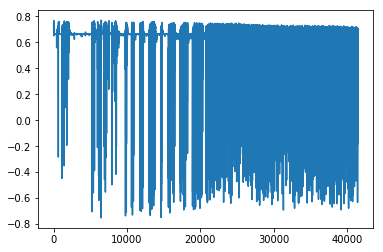

In [177]:
plt.plot(lossG)

## View

In [178]:
fake = netG(fixed_noise).data.cpu()

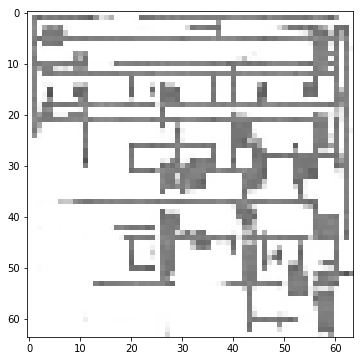

In [201]:
show(vutils.make_grid(fake[44,0,:,:]))

In [139]:
fakeshow(vutils.make_grid(iter(dataloader).next()[0]))

NameError: name 'fakeshow' is not defined

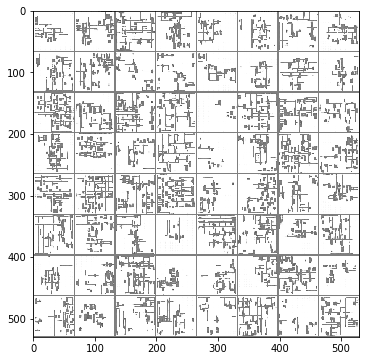

In [186]:
show(vutils.make_grid(fake))

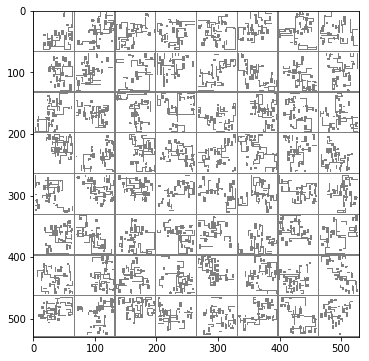

In [180]:
show(vutils.make_grid(iter(dataloader).next()))